#### Imports and Read Data

In [13]:
import datetime
from itertools import chain, combinations
from time import perf_counter
from itertools import zip_longest
import pathlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pyarrow as pa
import numpy as np

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


from utils import load_saved_data, get_connection, get_data


In [14]:
# df = load_saved_data()
root_dir = pathlib.Path("../data")
dir_2018 = root_dir/"311/2018"
try:
    df = pd.read_parquet(dir_2018/"unprocessed")
    if len(df) == 0:
        raise FileNotFoundError
except FileNotFoundError:
    with get_connection() as conn:
        df1 = get_data(conn, 2018, 2018, 2_000_000, 2_000_000)
    df2 = pd.read_feather(root_dir/'2018.feather')
    df = pd.concat([df1, df2])
    df.to_parquet(dir_2018/"unprocessed", partition_cols=["agency"])



In [15]:
display(df.isnull().sum()/2e6 * 100)


created_date                       0.00000
closed_date                        2.27740
complaint_type                     0.00000
descriptor                         0.93560
status                             0.00000
resolution_description             9.34560
resolution_action_updated_date     1.21305
borough                            0.05100
incident_zip                       6.15895
city                               6.12325
bbl                               30.71885
latitude                          10.50730
longitude                         10.50730
due_date                          81.49550
agency                             0.00000
dtype: float64

#### Drop, Fill, and Explore

In [16]:

current_date = pd.Timestamp.now().normalize()
# remove impossible records
# (close in future)
df = df.drop(df[df['closed_date']>current_date].index)
# (close before created)
df = df.loc[(df['closed_date']>df['created_date'])|(df['closed_date'].isnull())]
# Fill borough missing with unspecified
df['borough'].fillna('Unspecified', inplace=True)

In [17]:
df.dtypes.value_counts()

object                    8
timestamp[ns][pyarrow]    4
double[pyarrow]           2
category                  1
Name: count, dtype: int64

In [18]:
df.dtypes

created_date                      timestamp[ns][pyarrow]
closed_date                       timestamp[ns][pyarrow]
complaint_type                                    object
descriptor                                        object
status                                            object
resolution_description                            object
resolution_action_updated_date    timestamp[ns][pyarrow]
borough                                           object
incident_zip                                      object
city                                              object
bbl                                               object
latitude                                 double[pyarrow]
longitude                                double[pyarrow]
due_date                          timestamp[ns][pyarrow]
agency                                          category
dtype: object

In [19]:
display(df.describe())
# display(df.describe(include='string'))


created_date                    closed_date  \
count                        2749935                        2704387   
mean   2018-06-19 16:33:09.595934976  2018-07-15 20:16:57.474858496   
min              2010-01-05 16:12:25            2018-01-01 00:00:00   
25%       2018-03-23 10:49:07.500000            2018-04-04 14:43:28   
50%              2018-06-27 13:37:00            2018-07-10 07:31:27   
75%       2018-09-28 20:53:45.500000     2018-10-12 13:01:14.500000   
max              2018-12-31 23:59:56            2024-02-22 16:20:00   
std                              NaN                            NaN   

      resolution_action_updated_date      latitude     longitude  \
count                        2725684  2.563366e+06  2.563366e+06   
mean   2018-07-15 08:48:31.596451328  4.072730e+01 -7.392399e+01   
min              2012-12-06 00:00:00  4.049895e+01 -7.425473e+01   
25%              2018-04-05 00:00:00  4.066493e+01 -7.396879e+01   
50%              2018-07-10 23:02:42  4.071856e+01 -7.392667e+01   
75%              2018-10-13 14:39:30  4.080068e+01 -7.387611e+01   
max              2024-02-22 00:00:00  4.091294e+01 -7.370038e+01   
std                              NaN  8.609226e-02  8.371429e-02   

                            due_date  
count                        1221627  
mean   2018-07-14 21:02:14.292905472  
min              2012-09-20 18:00:45  
25%              2018-04-21 13:51:38  
50%              2018-07-13 20:08:49  
75%              2018-10-07 16:24:23  
max              2022-07-21 02:22:26  
std                              NaN

In [20]:
df[(df['borough']=='Unspecified')]['created_date'].count()#/2e6

41153

In [21]:
df['closed_date'].isnull().sum()

45548

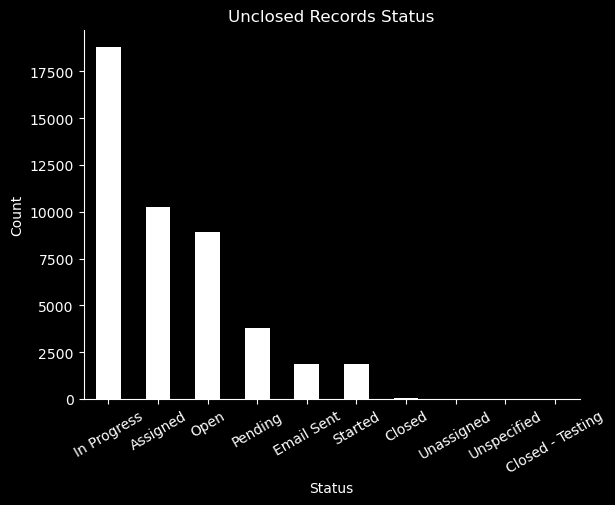

In [22]:
unclosed_status = df[(df['closed_date'].isnull())].groupby('status')['created_date'].count().sort_values(ascending=False)
ax = unclosed_status.plot.bar(title='Unclosed Records Status', ylabel='Count', xlabel='Status', color='w')#.to_clipboard()
ax.set_facecolor((0,0,0,0))
fig = ax.get_figure()
fig.set_facecolor('k')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Other customizations with white for inverted theme
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')

In [23]:
df[(df['status']!='Closed')].groupby('agency')['closed_date'].count()
df[(df['borough']=='Unspecified') &  (df['latitude'].isnull()) & (df['incident_zip'].isnull())].count()
# unclosed = df[(df['status']!='Closed')|(df['closed_date'] == pd.NaT)]['agency'].value_counts()
# unclosed.plot.bar(title='Number of Unclosed Requests by Agency', xlabel='Agency', ylabel='Unclosed Request Count')
# unclosed = df[df['status']!='Closed']['agency'].value_counts()
# unclosed.plot.bar(title='Number of Unclosed Requests by Agency', xlabel='Agency', ylabel='Unclosed Request Count')

C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\2750814593.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[(df['status']!='Closed')].groupby('agency')['closed_date'].count()


created_date                      34205
closed_date                       30955
complaint_type                    34205
descriptor                        33991
status                            34205
resolution_description            34105
resolution_action_updated_date    18320
borough                           34205
incident_zip                          0
city                                  9
bbl                                   0
latitude                              0
longitude                             0
due_date                          19596
agency                            34205
dtype: int64

In [24]:
# remove null closed dates
df = df.loc[df['closed_date'].notnull()]

#### Feature Engineering

##### Add target feature

In [25]:
df['hours_to_complete'] =  pd.to_datetime(df['closed_date']) - pd.to_datetime(df['created_date'])
df['hours_to_complete'] = df.loc[:,'hours_to_complete'].astype('float64') / (3.6e12)

##### Add number of requests created by hour and grouped

In [26]:
def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def make_rounded_time_column(time_col:pd.Series, interval:str = 'H'):
    return pd.to_datetime(time_col.astype('int64')).dt.floor(interval)

def add_created_count_feat(df:pd.DataFrame,
                           features:list[str],
                           inplace = False,
                           interval:str = 'H'):
    trunc_name = '_'.join(['created']+[name[:2] for name in features])
    created_by_date = df.groupby(
        by=[
            f'created_{interval}',
            *features
            ]
    )['created_date'].count()

    # ab['time'] = pd.to_datetime(ab['created_date'].astype(str)+' '+ab['hour'].astype(str)+':00:00')
    # ab.drop(['created_date', 'hour'], axis=1, inplace=True)
    # ab.set_index('time', inplace=True)
    if not inplace:
        return created_by_date.unstack(level=features).fillna(0)
    else:
        df.set_index(
            [
                f'created_{interval}',
                *features
            ],
            inplace=True)
        df[trunc_name] = created_by_date.fillna(0)
        df.reset_index(inplace=True)


def add_powerset_created(df:pd.DataFrame, s:set|list, interval:str = 'H'):
    if f'created_{interval}' not in df.columns:
        df[f'created_{interval}'] = make_rounded_time_column(df['created_date'], interval)
    if f'closed_{interval}' not in df.columns:
        df[f'closed_{interval}'] = make_rounded_time_column(df['closed_date'], interval)

    for features in powerset(s):
        start = perf_counter()

        if not features:
            print("general")
            add_created_count_feat(df, features=[], inplace=True, interval=interval)
        # each complaint type seems to be handled by a single agency
        # this reduces runtime a bit by removing this redundancy
        elif 'agency' in features and 'complaint_type' in features:
            continue
        else:
            print(*features)
            add_created_count_feat(df, list(features),inplace=True, interval=interval)
        print(f'{perf_counter()-start:.3f} seconds\n')


##### Add number of requests open by hour grouped by features

In [27]:
def add_open_count(df:pd.DataFrame, interval:str):
    df.set_index([f'closed_{interval}'], inplace=True)
    # sort by closed date
    df.sort_index(axis=0, level=f'closed_{interval}', ascending=True, inplace=True)
    t_num_closed = df['closed_date'].groupby(level=f'closed_{interval}').count()
    t_num_closed:pd.Series = t_num_closed[
        t_num_closed.index.get_level_values(f'closed_{interval}') < df[f'created_{interval}'].max()
        ].cumsum()

    # remove closed date from index
    df.reset_index(f'closed_{interval}', drop=False, inplace=True)
    df.set_index(f'created_{interval}', inplace=True)
    df.sort_index(level=f'created_{interval}', ascending=True, inplace=True)

    # count number created per hour
    t_num_created = df['created_date'].groupby(level=f'created_{interval}').count().cumsum()

    # change index of closed to be more like created
    t_num_closed.index.rename(f'created_{interval}', inplace=True)
    missing_indices = t_num_closed.index.union(t_num_created.index)
    t_num_closed = t_num_closed.reindex(missing_indices, method='ffill')
    t_num_closed.rename(t_num_created.name, inplace=True)

    # display(t_num_closed)
    # display(t_num_created)
    # display(df)
    df["open"] = t_num_created - t_num_closed
    df.reset_index(inplace=True)


def add_open_count_feat(df:pd.DataFrame, features:list[str], interval:str):
    # col name for new feature
    trunc_name = '_'.join(['open']+[name[:2] for name in features])

    # set the index to features and date closed
    df.set_index([f'closed_{interval}']+features, inplace=True)

    # sort by closed date
    df.sort_index(axis=0, level=f'closed_{interval}', ascending=True, inplace=True)

    # count number closed per hour
    t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count()
    t_num_closed:pd.Series = t_num_closed[t_num_closed.index.get_level_values(f'closed_{interval}') < df[f'created_{interval}'].max()]
    t_num_closed = t_num_closed.unstack(level=features, fill_value=0).cumsum()

    # remove closed date from index
    df.reset_index(f'closed_{interval}', drop=False, inplace=True)
    # df.reset_index(features, drop=False, inplace=True)

    # Add created date to index
    df.set_index(f'created_{interval}', append=True, inplace=True)
    # if features:
    #     df = df.reorder_levels(['created_{interval}']+features)
    df.sort_index(level=f'created_{interval}', ascending=True, inplace=True)

    # count number created per hour
    t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count()

    # unstack to get columns for all features
    # get cumsum over the features then restack into a series
    t_num_created = t_num_created.unstack(level=features, fill_value=0).cumsum()

    # change index of closed to be more like created
    t_num_closed.index.rename(f'created_{interval}', inplace=True)
    missing_indices = t_num_closed.index.union(t_num_created.index)
    t_num_closed = t_num_closed.reindex(missing_indices, method='ffill').stack(level=features)

    # stack back into a series
    t_num_created = t_num_created.stack(level=features)
    t_num_closed.rename(t_num_created.name, inplace=True)

    # difference to get number open at a given hour
    diff = t_num_created - t_num_closed
    # diff:pd.Series = t_num_created.combine(t_num_closed, lambda x,y: x-y, fill_value=0)
    diff.fillna(0, inplace=True)
    # reorder axis for merger if needed
    if not all([a == b for a, b in zip(diff.index.names, df.index.names)]):
        diff = diff.reorder_levels(df.index.names)

    # add to the dataframe and reset the index
    df[trunc_name] = diff
    df.reset_index(inplace=True)

def add_powerset_open(df:pd.DataFrame, s:set|list, interval:str = 'H'):
    if f'created_{interval}' not in df.columns:
        df[f'created_{interval}'] = make_rounded_time_column(df['created_date'], interval)
    if f'closed_{interval}' not in df.columns:
        df[f'closed_{interval}'] = make_rounded_time_column(df['closed_date'], interval)

    for features in powerset(s):
        start = perf_counter()

        if not features:
            print("general")
            add_open_count(df, interval)
        # each complaint type seems to be handled by a single agency
        # this reduces runtime a bit by removing this redundancy
        elif 'agency' in features and 'complaint_type' in features:
            continue
        else:
            print(*features)
            add_open_count_feat(df, list(features), interval)
        print(f'{perf_counter()-start:.3f} seconds\n')


In [28]:
# calculate number of open requests grouped by
# an element of the powerset of s
features= ['borough', 'agency','complaint_type']
add_powerset_created(df, features)



general
0.116 seconds

borough
0.742 seconds

agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\3800869002.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  created_by_date = df.groupby(


0.587 seconds

complaint_type
0.802 seconds

borough agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\3800869002.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  created_by_date = df.groupby(


1.960 seconds

borough complaint_type
1.776 seconds

general
2.337 seconds

borough
3.169 seconds

agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count()
C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count()


3.075 seconds

complaint_type
7.779 seconds

borough agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count()
C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count()


9.076 seconds

borough complaint_type
90.959 seconds



In [30]:
add_powerset_open(df, features)
df

general
3.686 seconds

borough
3.682 seconds

agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count()
C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count()


3.825 seconds

complaint_type
9.247 seconds

borough agency


C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count()
C:\Users\Morri\AppData\Local\Temp\ipykernel_8544\511794481.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count()


12.507 seconds

borough complaint_type
88.326 seconds



borough                 complaint_type           created_H  \
0               QUEENS                   Building/Use 2010-01-05 16:00:00   
1               QUEENS  General Construction/Plumbing 2010-01-07 08:00:00   
2            MANHATTAN  General Construction/Plumbing 2010-01-11 11:00:00   
3             BROOKLYN  General Construction/Plumbing 2010-01-14 06:00:00   
4               QUEENS                   Building/Use 2010-01-15 15:00:00   
...                ...                            ...                 ...   
2704382  STATEN ISLAND            Noise - Residential 2018-12-31 23:00:00   
2704383  STATEN ISLAND            Noise - Residential 2018-12-31 23:00:00   
2704384  STATEN ISLAND            Noise - Residential 2018-12-31 23:00:00   
2704385  STATEN ISLAND                          Sewer 2018-12-31 23:00:00   
2704386    Unspecified              Highway Condition 2018-12-31 23:00:00   

                   closed_H agency         created_date          closed_date  \
0       2018-06-29 00:00:00    DOB  2010-01-05 16:12:25  2018-06-29 00:00:00   
1       2018-09-18 00:00:00    DOB  2010-01-07 08:30:31  2018-09-18 00:00:00   
2       2018-08-14 00:00:00    DOB  2010-01-11 11:54:41  2018-08-14 00:00:00   
3       2018-11-01 00:00:00    DOB  2010-01-14 06:31:16  2018-11-01 00:00:00   
4       2018-08-01 00:00:00    DOB  2010-01-15 15:34:43  2018-08-01 00:00:00   
...                     ...    ...                  ...                  ...   
2704382 2018-12-31 23:00:00   NYPD  2018-12-31 23:08:31  2018-12-31 23:18:44   
2704383 2019-01-01 04:00:00   NYPD  2018-12-31 23:39:46  2019-01-01 04:09:14   
2704384 2019-01-01 07:00:00   NYPD  2018-12-31 23:14:00  2019-01-01 07:40:25   
2704385 2019-01-02 09:00:00    DEP  2018-12-31 23:36:00  2019-01-02 09:30:00   
2704386 2019-01-02 14:00:00    DOT  2018-12-31 23:24:38  2019-01-02 14:14:12   

                                                descriptor  status  \
0         Illegal Conversion Of Residential Building/Space  Closed   
1                                   Building Permit - None  Closed   
2        Egress - Doors Locked/Blocked/Improper/No Seco...  Closed   
3                                   Building Permit - None  Closed   
4         Illegal Conversion Of Residential Building/Space  Closed   
...                                                    ...     ...   
2704382                                   Loud Music/Party  Closed   
2704383                                   Banging/Pounding  Closed   
2704384                                   Loud Music/Party  Closed   
2704385                               Street Flooding (SJ)  Closed   
2704386                                  Pothole - Highway  Closed   

                                    resolution_description  ... created_ag  \
0        The Department of Buildings has investigated t...  ...          1   
1        The Department of Buildings investigated this ...  ...          1   
2        The Department of Buildings has investigated t...  ...          1   
3        The Department of Buildings investigated this ...  ...          1   
4        The Department of Buildings has investigated t...  ...          1   
...                                                    ...  ...        ...   
2704382  The Police Department responded to the complai...  ...        147   
2704383  The Police Department responded to the complai...  ...        147   
2704384  The Police Department responded to the complai...  ...        147   
2704385  The Department of Environmental Protection ins...  ...         13   
2704386  The Department of Transportation has completed...  ...          7   

        created_co created_bo_ag created_bo_co   open  open_bo open_ag  \
0                1             1             1   <NA>     <NA>    <NA>   
1                1             1             1   <NA>     <NA>    <NA>   
2                1             1             1   <NA>     <NA>    <NA>   
3                1             1             1   <NA>  

In [33]:
df = df.convert_dtypes(dtype_backend="pyarrow")
df.dtypes

borough                                  string[pyarrow]
complaint_type                           string[pyarrow]
created_H                         timestamp[ns][pyarrow]
closed_H                          timestamp[ns][pyarrow]
agency                                          category
created_date                      timestamp[ns][pyarrow]
closed_date                       timestamp[ns][pyarrow]
descriptor                               string[pyarrow]
status                                   string[pyarrow]
resolution_description                   string[pyarrow]
resolution_action_updated_date    timestamp[ns][pyarrow]
incident_zip                             string[pyarrow]
city                                     string[pyarrow]
bbl                                      string[pyarrow]
latitude                                 double[pyarrow]
longitude                                double[pyarrow]
due_date                          timestamp[ns][pyarrow]
hours_to_complete              

##### Save new frame to a file

In [34]:
df.to_parquet(dir_2018/"processed", partition_cols=['agency'])

#### Visualize New Features

In [22]:
target_df = df[['created_H','agency', 'hours_to_complete']] \
        .groupby(['created_H','agency']) \
                .mean().unstack('agency')
# axes = target_df.plot(
#         # x='created_H',
#         # y='hours_to_complete',
#         title='Hours to Complete over time by Agency',
#         legend=True,
#         subplots=True,
#         ylim=[0,1000]
#         )
# fig = axes[0].get_figure()
# fig.set_size_inches((40,100))


In [23]:
# target_ct_df = df[['created_H','complaint_type', 'hours_to_complete']] \
#         .groupby(['created_H','complaint_type']) \
#                 .mean().unstack('complaint_type')
# axes = target_ct_df.plot(
#         # x='created_H',
#         # y='hours_to_complete',
#         title='Hours to Complete Over Time by Complaint Type',
#         legend=True,
#         subplots=True
#         )
# fig = axes[0].get_figure()
# fig.set_size_inches((40,100))


In [24]:
def get_highest_correlation_to_feat(
    df:pd.DataFrame,
    target:str,
    features:list[str],
    min_corr:float=0.3 # minimum absolute correlation to be added to the dict
    ):
    # row key: [correlation, y_column, [x_columns]]
    high_corr = {}
    for col_names in powerset(features):
        if col_names == ():
            continue
        trunc_name = '_'.join([target]+[name[:2] for name in col_names])
        if trunc_name not in df.columns:
            continue
        col_names = list(col_names)
        # get the correlation between completion time and number open for high freq
        consider_df = df.groupby(col_names)[['hours_to_complete',trunc_name]]
        correlation:pd.DataFrame = consider_df.corr()
        correlation.drop(trunc_name, axis=1, inplace=True)
        correlation.reset_index(level=-1, drop=True, inplace=True)
        abs_correlation = correlation['hours_to_complete'].abs().iloc[1::2]
        hcorr:pd.Series = abs_correlation[(abs_correlation<1)&(abs_correlation>min_corr)]

        # add to dict if no subset of features is in the dict already
        for n, v in hcorr.items():
            tdic = {k:v for k, v in zip(col_names, n)}
            if consider_df.get_group(n)['hours_to_complete'].count() < 1000:
                continue
            if 'complaint_type' in tdic and tdic['complaint_type'] in high_corr:
                continue
            if n not in high_corr:
                high_corr[n] = [v, trunc_name, col_names]
            else:
                high_corr[n] = max(high_corr[n], [v, trunc_name, col_names])
    return high_corr
# select complaint types whose completion time is dependent on number of open requests
# high_freq_df = high_freq_df[high_freq_df['complaint_type'].isin(high_corr)]




In [25]:
# average completion time
# completion_time_by_type = df.groupby('complaint_type')['hours_to_complete'].mean()
# binning completion time
# q2, bins = pd.qcut(completion_time_by_type[completion_time_by_type.index.isin(candidates)], 3, labels=bin_lbls, retbins=True,duplicates='raise')


# number of complaint types
num_of_type = df.groupby('complaint_type')['complaint_type'].value_counts()

bin_lbls = ['Low','Mid','High']
# binning freqency of complaint
q1, bins = pd.qcut(num_of_type, 3, labels=bin_lbls, retbins=True,duplicates='raise')
candidates = q1[q1=='High'].index

# get high frequency records
high_freq_df = df[(df['created_date']>df['created_date'].median())&(df['complaint_type'].isin(candidates))]

# remove outlier records
quants_df = high_freq_df.groupby('complaint_type')['hours_to_complete'].quantile([0.25,0.75])
quants_df = quants_df.unstack()
out_max = (quants_df[0.75] - quants_df[0.25])*1.5
# quants_df.columns
high_freq_df = pd.merge(high_freq_df, out_max.rename('upper_bound'), left_on='complaint_type', right_index=True)
high_freq_df = high_freq_df[high_freq_df['hours_to_complete'] < high_freq_df['upper_bound']]
high_freq_df.drop('upper_bound', axis=1, inplace=True)

# get high correlation to number open
s = ['borough', 'agency', 'complaint_type']
high_corr_open = get_highest_correlation_to_feat(high_freq_df, 'open', s)

In [26]:
high_corr_created = get_highest_correlation_to_feat(high_freq_df, 'created', s)
high_corr_created

{'Broken Parking Meter': [0.4847586671185247,
  'created_co',
  ['complaint_type']],
 ('BRONX', 'DSNY'): [0.3909081184143088,
  'created_bo_ag',
  ['borough', 'agency']],
 ('BROOKLYN', 'DSNY'): [0.3502284603016771,
  'created_bo_ag',
  ['borough', 'agency']],
 ('MANHATTAN', 'DSNY'): [0.42696556382997425,
  'created_bo_ag',
  ['borough', 'agency']],
 ('BROOKLYN', 'Damaged Tree'): [0.35462306079949246,
  'created_bo_co',
  ['borough', 'complaint_type']],
 ('QUEENS', 'Traffic Signal Condition'): [0.5088080733757585,
  'created_bo_co',
  ['borough', 'complaint_type']]}

In [27]:
high_corr_open

{'DOF Property - Update Account': [0.36660184315793415,
  'open_co',
  ['complaint_type']],
 'Graffiti': [0.31283888466496906, 'open_co', ['complaint_type']],
 'Housing - Low Income Senior': [0.33533884431004873,
  'open_co',
  ['complaint_type']],
 'Lead': [0.3433082890149698, 'open_co', ['complaint_type']],
 'Literature Request': [0.30500196096385745, 'open_co', ['complaint_type']],
 'SCRIE': [0.6389764189712229, 'open_co', ['complaint_type']],
 ('MANHATTAN', 'HPD'): [0.33086461499159703,
  'open_bo_ag',
  ['borough', 'agency']],
 ('MANHATTAN', 'Broken Parking Meter'): [0.32879033201352587,
  'open_bo_co',
  ['borough', 'complaint_type']]}

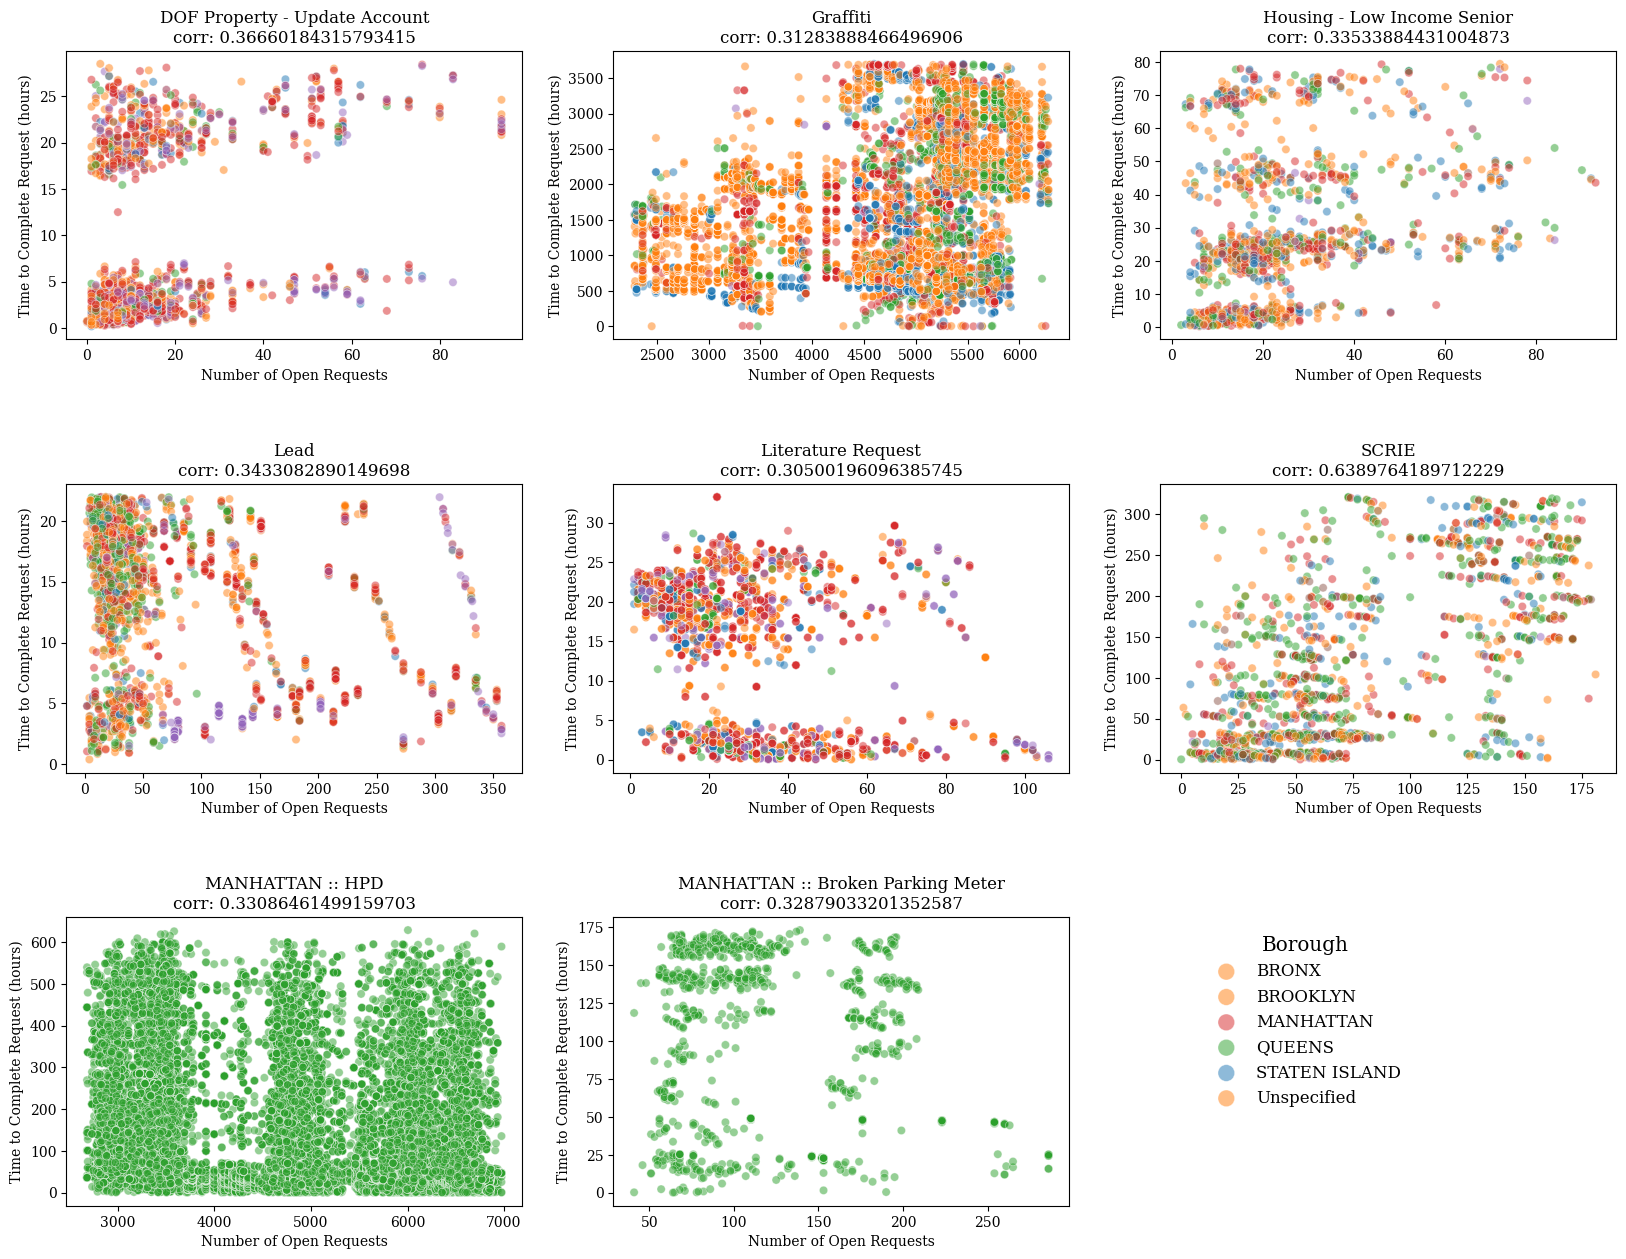

In [28]:
final_set = []
corr_nums = set()
# graph hexbins for high corr, high frequency complaint types
for n, (corr, x, c) in high_corr_open.items():
    if corr not in corr_nums:
        corr_nums.add(corr)
    else:
        continue
    try:
        grp = high_freq_df.groupby(c).get_group(n)
    except KeyError:
        continue
    if isinstance(n, tuple):
        name = ' :: '.join(n)
    else:
        name = n

    title = f'{name}\ncorr: {corr}'
    final_set.append((n,title, x, c))

def nearest_rectangle(num_vars:int):
    length = width = round(num_vars**0.5)

    if length * width < num_vars:
        width += 1

    return length, width

height, width = nearest_rectangle(len(final_set))

boroughs = list(df['borough'].unique())
borough_colors = {b:c for b,c in zip(boroughs, plt.cm.rainbow(np.linspace(0, 1, len(boroughs))))}


fig, axes = plt.subplots(
            nrows=height,
            ncols=width,
            squeeze=False
            # subplot_titles=subplot_titles
        )


fig.set_size_inches(20,15)
plt.subplots_adjust(hspace=0.5)
for (i, ax), (n, title, x, c) in zip_longest(np.ndenumerate(axes), final_set, fillvalue=('_','_','_','_')):
    if n == '_':
        ax.set_axis_off()
        continue
    grp = high_freq_df.groupby(c).get_group(n)
    sns.scatterplot(
        y='hours_to_complete',
        x=x,
        hue='borough',
        hue_order=borough_colors,
        data=grp,
        alpha=0.5,
        ax = ax,
        legend=False,
        )
    ax.set_xlabel("Number of Open Requests")
    ax.set_ylabel('Time to Complete Request (hours)')
    ax.set_title(title)




leg = fig.legend(
    labels=boroughs,
    # handles=handles,
    bbox_to_anchor=[.3,-.2,0.5,0.5],
    fontsize='large',
    markerscale=2,
    frameon=False,
    title="Borough",
    title_fontsize='x-large',
    draggable=True
    )




<Axes: title={'center': 'Open Requests by Hour by Borough'}, xlabel='created_H'>

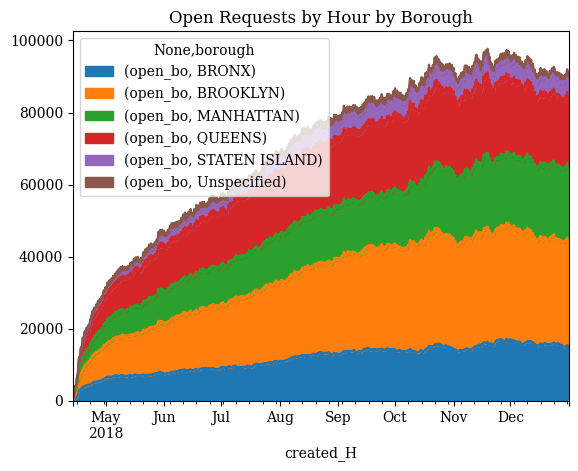

In [29]:
borough_df = df[['created_H','borough', 'open_bo']].groupby(['created_H','borough']).max().unstack().ffill().fillna(0)
borough_df.plot.area(
        title='Open Requests by Hour by Borough',
        )

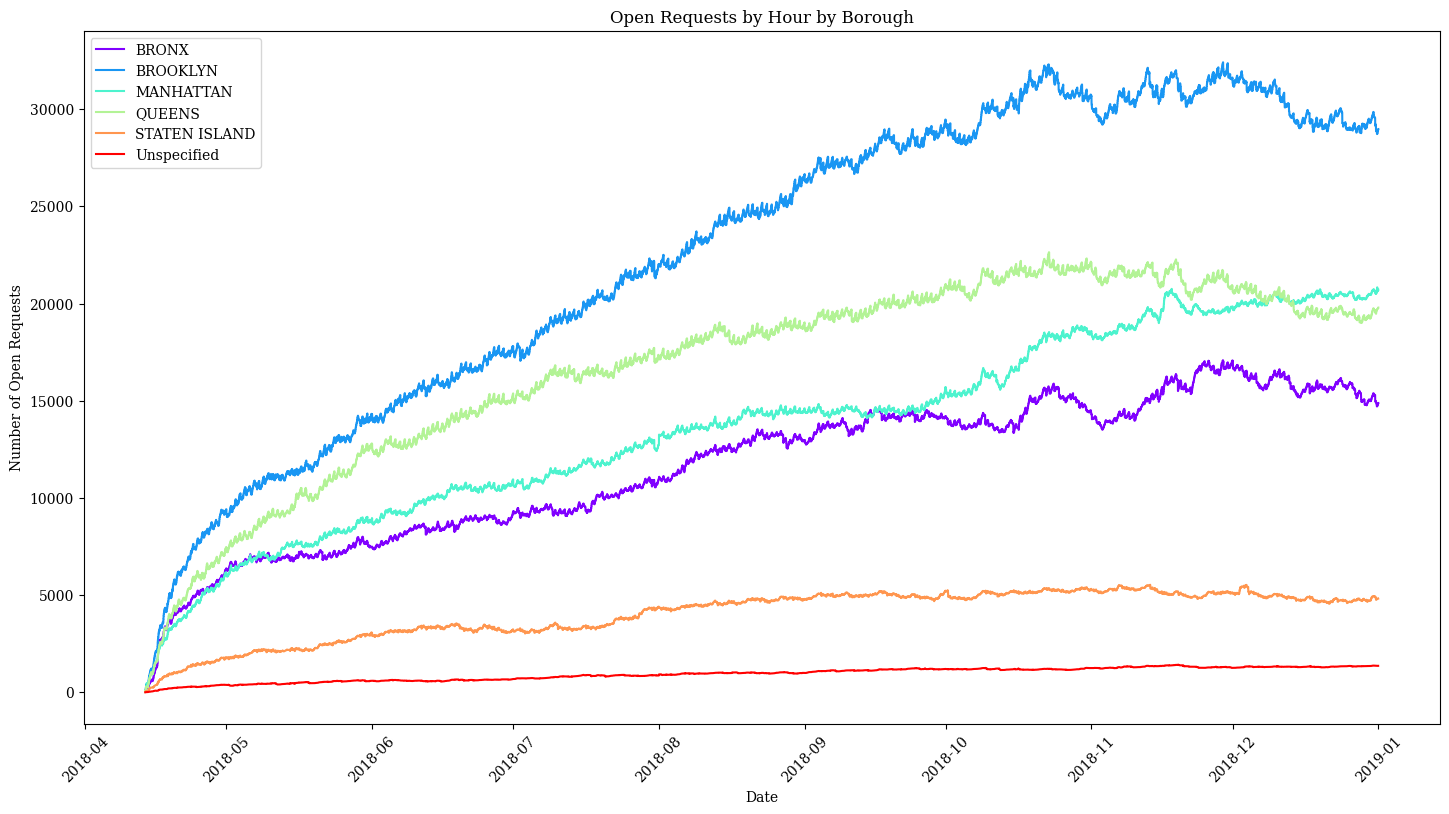

In [30]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches((17.5,9))
# graph number of open requests by borough for the sample
for n, grp in df.groupby(['borough']):
    # forward fill for missing days and fill first day w/ 0
    grp['open_bo'] = grp['open_bo'].ffill().fillna(0)
    grp.plot(
        x='created_date', y='open_bo',
        title='Open Requests by Hour by Borough',
        legend=True, ax=ax, c=borough_colors[n[0]],
        label=n[0])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Open Requests')
ax.tick_params(axis='x',rotation=45)


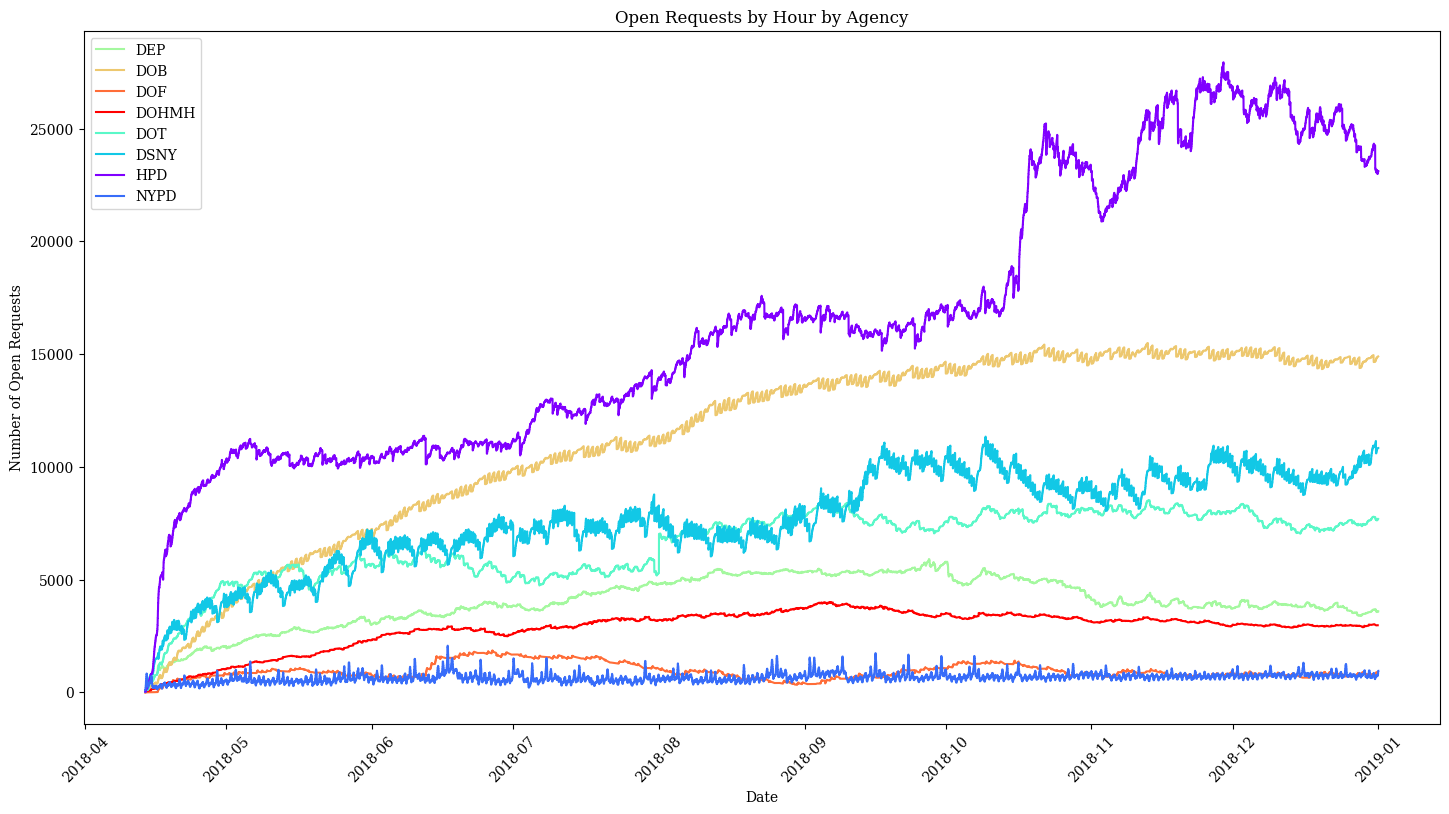

In [31]:

# graph number of open requests by agency for the sample
# df[df['open_bo']>0].groupby('borough').plot(x='created_date', y='open_bo')
high_freq = ['HPD', 'NYPD', 'DSNY', 'DOT', 'DEP', 'DOB', 'DOF', 'DOHMH']

agency_colors = {b:c for b,c in zip(high_freq, plt.cm.rainbow(np.linspace(0, 1, len(high_freq))))}


fig, ax = plt.subplots(1,1)
fig.set_size_inches((17.5,9))

# graph number of open requests by borough for the sample
for n, grp in df[df['agency'].isin(high_freq)].groupby(['agency']):
    # forward fill for missing days and fill first day w/ 0
    grp['open_ag'] = grp['open_ag'].ffill().fillna(0)
    grp.plot(
        x='created_date', y='open_ag',
        title='Open Requests by Hour by Agency',
        legend=True, ax=ax, c=agency_colors[n[0]],
        label=n[0])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Open Requests')
ax.tick_params(axis='x',rotation=45)


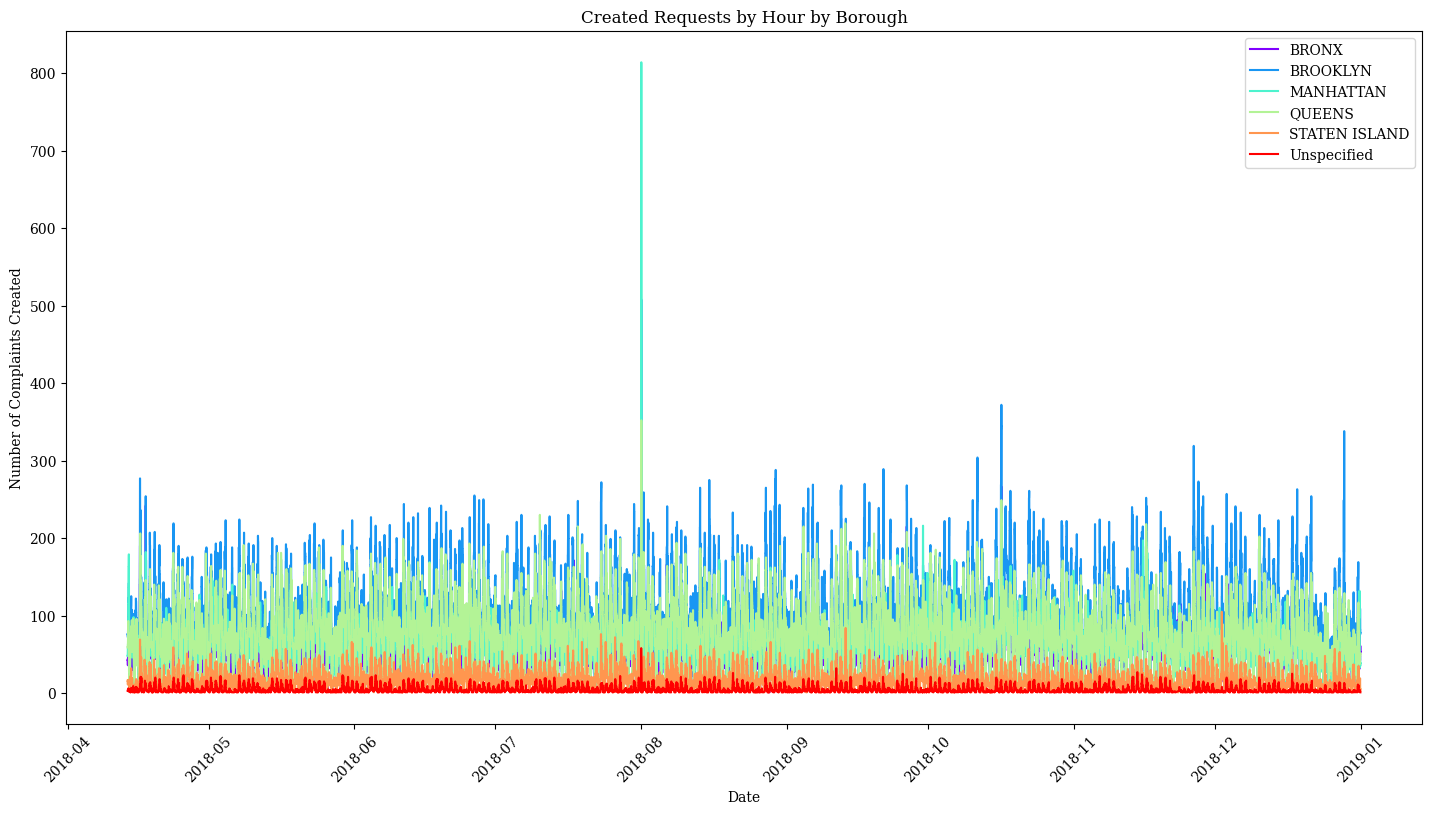

In [32]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches((17.5,9))
# graph number of open requests by borough for the sample
for n, grp in df.groupby(['borough']):
    # forward fill for missing days and fill first day w/ 0
    grp['open_bo'] = grp['created_bo'].fillna(0)
    grp.plot(
        x='created_date', y='created_bo',
        title='Created Requests by Hour by Borough',
        legend=True, ax=ax, c=borough_colors[n[0]],
        label=n[0])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Complaints Created')
ax.tick_params(axis='x',rotation=45)

### Time Series Analysis

#### Stationarity Function

In [33]:
def check_stationarity(series, verbose = False):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)
    if verbose:
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        if verbose: print("\u001b[32mStationary\u001b[0m")
        return True
    else:
        if verbose: print("\x1b[31mNon-stationary\x1b[0m")
        return False


#### General Hours to Complete Autocorrelation

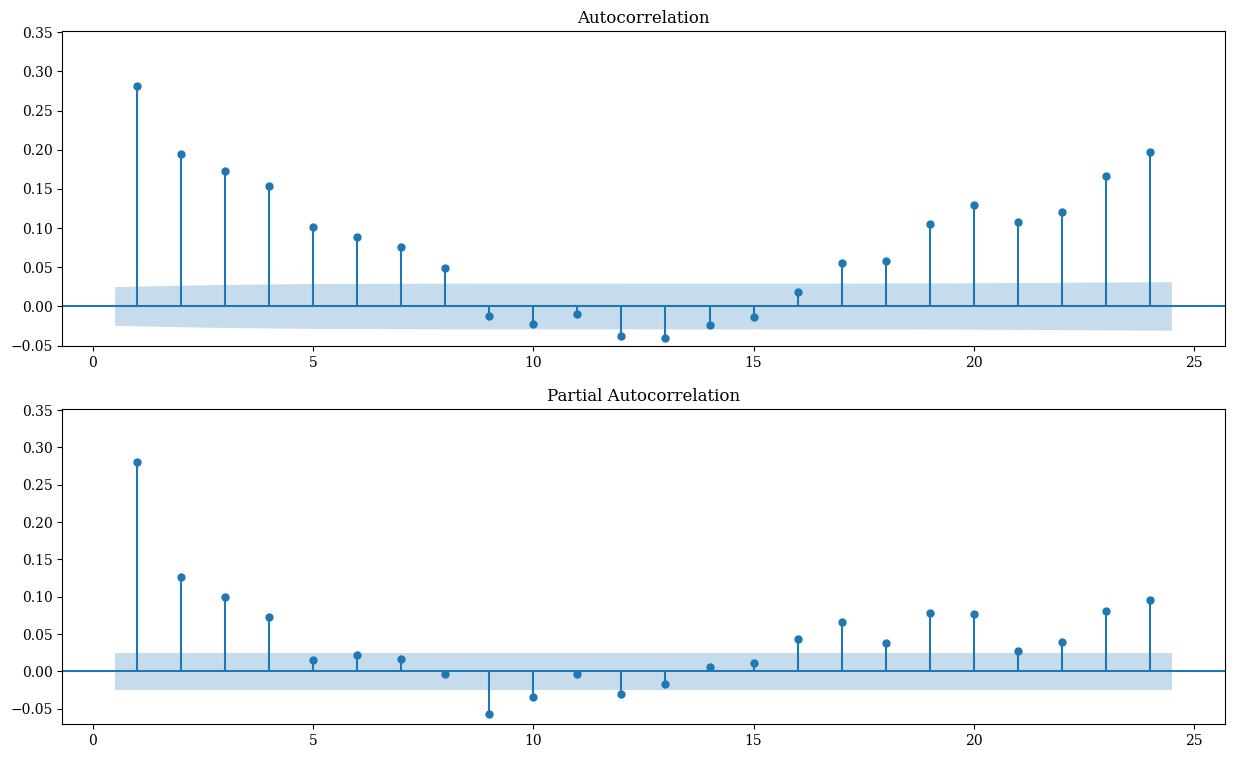

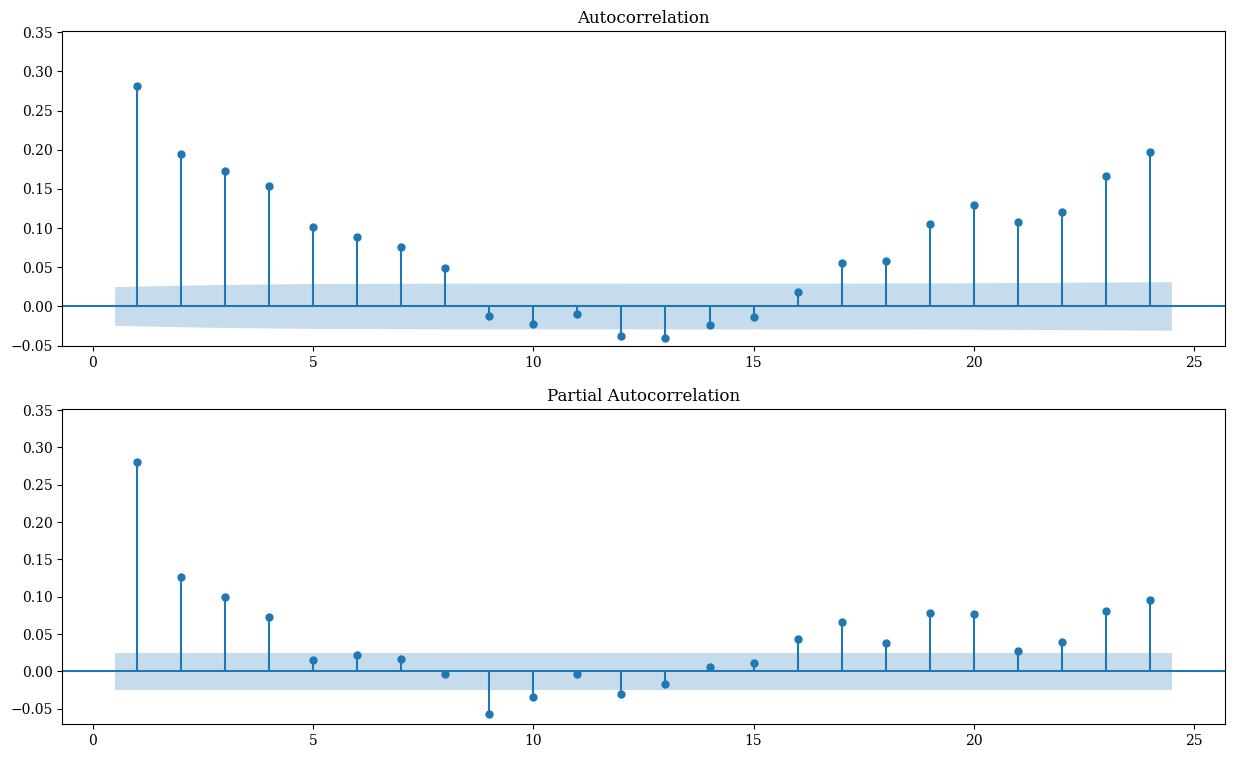

In [35]:
lags = 24
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 9))

to_comp_df = df[['created_H', 'hours_to_complete']].groupby('created_H').mean()
plot_acf(to_comp_df,lags=lags, ax=axes[0], zero=False, auto_ylims=True)
plot_pacf(to_comp_df,lags=lags, ax=axes[1], zero=False, auto_ylims=True)

#### Borough and Agency

In [ ]:
target_df = target_df.fillna(0)
for c in target_df.columns:
    check_stationarity(target_df[c])
    display(acorr_ljungbox(target_df[c], lags=24))
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 9))
    plot_acf(target_df[c],lags=lags, ax=ax[0], zero=False, auto_ylims=True)
    ax[0].set_title(f'{c[1]} ACF')
    plot_pacf(target_df[c],lags=lags, ax=ax[1], method='ols', zero=False, auto_ylims=True)
    ax[1].set_title(f'{c[1]} PACF')

In [40]:
target_ag_bo_df = df[['created_H','agency','borough', 'hours_to_complete']] \
        .groupby(['created_H','agency','borough']) \
                .mean().unstack(['agency','borough']).fillna(0)

#### Agency Only

('hours_to_complete', 'DCA', 'BRONX')
ADF Statistic: -54.637076
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.475887   0.490291
2    3.439204   0.179137
3    3.748384   0.289947
4    3.842475   0.427744
5    3.843007   0.572233
6    3.881396   0.692723
7    4.161418   0.761009
8    4.425259   0.816863
9    5.101301   0.825390
10   6.001052   0.815175
11   6.003833   0.873108
12   7.121806   0.849460
13   8.317713   0.822304
14   8.319018   0.872053
15   8.332268   0.909772
16   8.662149   0.926672
17   8.733541   0.948252
18   8.778434   0.964656
19   8.786746   0.976856
20   8.836558   0.984724
21   8.947916   0.989618
22  11.789497   0.961575
23  12.599611   0.960145
24  16.261328   0.878413

('hours_to_complete', 'DCA', 'STATEN ISLAND')
ADF Statistic: -78.093028
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    1.659202   0.197711
2    2.038486   0.360868
3    2.640724   0.450395
4    2.661484   0.615971
5    2.945344   0.708412
6    3.132959   0.791984
7    3.167874   0.869050
8    3.521073   0.897548
9    3.567992   0.937482
10   3.724804   0.958909
11   4.190112   0.964022
12   4.497941   0.972687
13   4.735773   0.980558
14   4.938345   0.986652
15   5.270142   0.989582
16   5.485528   0.992762
17   5.531017   0.995823
18   5.544397   0.997722
19   5.592472   0.998730
20   5.682151   0.999264
21   5.778907   0.999573
22  19.043761   0.642625
23  19.064964   0.697448
24  27.968747   0.261360

('hours_to_complete', 'DEP', 'BRONX')
ADF Statistic: -8.974956
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    60.743005   6.503378e-15
2    99.415913   2.582906e-22
3   127.444612   1.921868e-27
4   155.358739   1.445903e-32
5   221.616227   6.694752e-46
6   239.214244   8.260999e-49
7   268.091091   3.885335e-54
8   314.563307   3.263161e-63
9   348.631288   1.211903e-69
10  361.865439   1.206228e-71
11  379.300786   1.507262e-74
12  395.078033   4.169217e-77
13  428.947395   1.697550e-83
14  453.665049   5.975512e-88
15  475.334181   9.250192e-92
16  494.625310   4.530958e-95
17  511.302634   7.853963e-98
18  530.180967  4.651085e-101
19  552.143936  6.152828e-105
20  582.199363  1.611453e-110
21  601.304963  8.500829e-114
22  645.967395  1.886341e-122
23  670.191842  8.360337e-127
24  694.265664  3.984430e-131

('hours_to_complete', 'DEP', 'BROOKLYN')
ADF Statistic: -21.295904
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.358575   0.549299
2    0.689996   0.708222
3    1.945455   0.583805
4    2.458493   0.652083
5   12.403490   0.029658
6   13.235091   0.039451
7   15.784939   0.027155
8   18.207742   0.019722
9   19.104568   0.024318
10  20.211527   0.027314
11  20.655600   0.037120
12  31.002638   0.001968
13  32.391158   0.002101
14  33.044523   0.002839
15  33.925987   0.003488
16  34.095067   0.005275
17  36.229247   0.004274
18  36.229395   0.006593
19  36.439213   0.009318
20  36.483934   0.013484
21  36.809189   0.017703
22  36.810337   0.024814
23  37.600972   0.028097
24  52.841281   0.000607

('hours_to_complete', 'DEP', 'MANHATTAN')
ADF Statistic: -49.660257
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1     0.231331  6.305384e-01
2    96.915432  9.017400e-22
3    96.941234  7.064565e-21
4    97.285257  3.720742e-20
5    97.407640  1.858719e-19
6    99.068699  3.924810e-19
7    99.538766  1.343315e-18
8   106.138650  2.362857e-19
9   106.838647  6.462899e-19
10  107.262898  1.899377e-18
11  108.227543  4.136766e-18
12  108.242543  1.331454e-17
13  110.402234  1.558150e-17
14  110.933363  3.687123e-17
15  111.149469  9.697703e-17
16  111.195825  2.656587e-16
17  113.322735  2.851778e-16
18  113.445768  7.157138e-16
19  113.652998  1.684588e-15
20  115.115657  2.271928e-15
21  116.674191  2.898725e-15
22  116.796729  6.636841e-15
23  116.824693  1.544477e-14
24  118.999601  1.461920e-14

('hours_to_complete', 'DEP', 'QUEENS')
ADF Statistic: -78.276275
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    1.095702   0.295211
2    1.468497   0.479866
3    1.500063   0.682256
4    1.642990   0.801046
5    1.809855   0.874780
6    2.135188   0.906855
7    2.163409   0.950245
8    2.178112   0.975059
9    2.683918   0.975521
10   3.035547   0.980575
11   3.085422   0.989548
12   3.757780   0.987421
13   4.054034   0.990603
14   4.569970   0.990944
15   4.577096   0.995142
16   4.700433   0.997053
17   6.289955   0.991016
18   6.298579   0.994828
19   6.328922   0.997022
20   6.437479   0.998163
21   6.578882   0.998833
22   6.684352   0.999294
23  16.988643   0.809809
24  39.580852   0.023710

('hours_to_complete', 'DEP', 'STATEN ISLAND')
ADF Statistic: -79.242710
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.005347   0.941708
2    0.005974   0.997017
3    0.207462   0.976376
4    2.579858   0.630395
5    3.089540   0.686184
6    3.094724   0.796868
7    3.301865   0.855745
8    3.787100   0.875803
9    3.911698   0.917128
10   4.673613   0.911888
11   5.410716   0.909658
12   6.156507   0.907988
13   6.198013   0.938648
14   6.581463   0.949645
15   6.585392   0.968151
16   6.609254   0.980078
17   6.614183   0.988016
18   6.689942   0.992491
19   6.799715   0.995207
20   6.806402   0.997273
21   6.887472   0.998353
22   6.905372   0.999085
23   7.015872   0.999441
24  12.251189   0.976928

('hours_to_complete', 'DHS', 'BRONX')
ADF Statistic: -14.115988
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   291.264167   2.636986e-65
2   291.265913   5.654712e-64
3   291.269117   7.714106e-63
4   291.272340   8.265254e-62
5   291.275567   7.517173e-61
6   291.278798   6.040936e-60
7   291.282041   4.395507e-59
8   291.282942   2.947086e-58
9   291.286157   1.838125e-57
10  291.289123   1.077322e-56
11  291.292149   5.973580e-56
12  291.295371   3.150746e-55
13  583.807333  2.166100e-116
14  876.427692  4.840636e-178
15  876.430780  3.897499e-177
16  876.433743  3.028314e-176
17  876.436998  2.275568e-175
18  876.440256  1.657362e-174
19  876.441239  1.173453e-173
20  876.444467  8.071977e-173
21  876.445339  5.414685e-172
22  876.446202  3.542554e-171
23  876.449144  2.260913e-170
24  876.452096  1.410536e-169

('hours_to_complete', 'DHS', 'BROOKLYN')
ADF Statistic: -10.279576
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   2037.948927        0.0
2   3595.250528        0.0
3   4385.830756        0.0
4   4889.641411        0.0
5   5394.166644        0.0
6   5676.788536        0.0
7   5801.066130        0.0
8   5925.366479        0.0
9   6049.483445        0.0
10  6079.376553        0.0
11  6203.090212        0.0
12  6327.063491        0.0
13  6451.233575        0.0
14  6734.082901        0.0
15  6858.271596        0.0
16  6982.316458        0.0
17  7106.593256        0.0
18  7231.021354        0.0
19  7515.273018        0.0
20  8023.567584        0.0
21  8308.306948        0.0
22  8816.282503        0.0
23  9101.209065        0.0
24  9226.992511        0.0

('hours_to_complete', 'DHS', 'QUEENS')
ADF Statistic: -12.615533
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    98.839098   2.738736e-23
2   196.966697   1.695216e-43
3   196.976234   1.898845e-42
4   295.235971   1.154502e-62
5   295.242315   1.055451e-61
6   393.717617   6.266105e-82
7   393.725189   5.284640e-81
8   393.732053   4.103617e-80
9   393.741477   2.963907e-79
10  393.751187   2.011133e-78
11  393.756050   1.294138e-77
12  493.023248   6.764414e-98
13  591.732765  4.433946e-118
14  591.741821  3.041194e-117
15  591.751236  2.006977e-116
16  690.680594  1.243890e-136
17  789.464599  8.004346e-157
18  888.151890  5.275722e-177
19  987.043817  3.091574e-197
20  987.048460  2.254965e-196
21  987.057533  1.598585e-195
22  987.064111  1.106659e-194
23  987.068699  7.488276e-194
24  987.071061  4.958589e-193

('hours_to_complete', 'DOB', 'BRONX')
ADF Statistic: -14.663218
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    9.778987   0.001765
2   16.107021   0.000318
3   16.678418   0.000823
4   17.680379   0.001425
5   17.913788   0.003056
6   17.944370   0.006373
7   19.576794   0.006560
8   19.680781   0.011614
9   19.962128   0.018148
10  24.580005   0.006201
11  31.960342   0.000774
12  34.083985   0.000654
13  37.090538   0.000401
14  40.375870   0.000223
15  41.677754   0.000252
16  43.585838   0.000228
17  44.262792   0.000313
18  44.902625   0.000428
19  45.219872   0.000638
20  45.286438   0.001009
21  45.387410   0.001540
22  45.389145   0.002368
23  49.496934   0.001072
24  51.531574   0.000900

('hours_to_complete', 'DOB', 'BROOKLYN')
ADF Statistic: -12.809832
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    80.554830  2.827494e-19
2    82.902598  9.952442e-19
3    89.876721  2.328282e-19
4    97.284159  3.722744e-20
5   101.492180  2.561496e-20
6   103.462136  4.750529e-20
7   104.717070  1.142085e-19
8   105.051870  3.947098e-19
9   105.057186  1.486631e-18
10  118.223845  1.159809e-20
11  118.955186  2.940957e-20
12  119.910254  6.440151e-20
13  121.462668  1.034528e-19
14  121.696264  2.926820e-19
15  121.699004  8.852760e-19
16  121.713391  2.570774e-18
17  121.718556  7.251507e-18
18  123.119548  1.079152e-17
19  131.427019  7.825451e-19
20  133.488660  8.610939e-19
21  138.789322  2.308733e-19
22  142.770850  1.092624e-19
23  144.537479  1.332202e-19
24  152.365495  1.202706e-20

('hours_to_complete', 'DOB', 'MANHATTAN')
ADF Statistic: -11.532390
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    79.260468  5.443815e-19
2    91.523304  1.336494e-20
3   104.264198  1.881186e-22
4   128.403392  8.547058e-27
5   132.064720  8.676351e-27
6   146.148182  5.043213e-29
7   151.516991  1.949316e-29
8   151.738088  8.507822e-29
9   152.007146  3.384823e-28
10  152.397859  1.196476e-27
11  153.870540  2.409673e-27
12  154.063562  8.480676e-27
13  154.128372  3.031260e-26
14  154.142464  1.064409e-25
15  154.439210  3.160009e-25
16  154.448236  1.033953e-24
17  154.477993  3.242071e-24
18  155.691746  5.790765e-24
19  160.098863  2.426380e-24
20  185.532138  7.993297e-29
21  189.385583  4.380035e-29
22  196.878572  4.637294e-30
23  204.516165  4.599421e-31
24  218.127866  3.112855e-33

('hours_to_complete', 'DOB', 'QUEENS')
ADF Statistic: -42.644330
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    70.383074  4.883715e-17
2    74.564523  6.434571e-17
3    79.236865  4.474226e-17
4    79.298908  2.451972e-16
5    79.752751  9.453210e-16
6    81.905255  1.442895e-15
7    82.007168  5.363820e-15
8    82.017387  1.917637e-14
9    82.379266  5.435473e-14
10   82.488176  1.630338e-13
11   83.429343  3.193262e-13
12   85.330329  3.932147e-13
13   87.717514  3.811833e-13
14   91.715618  1.797641e-13
15   93.320485  2.372647e-13
16   93.883099  4.790144e-13
17   95.135386  7.028503e-13
18   95.187831  1.670900e-12
19   98.504750  9.980681e-13
20  100.210148  1.155098e-12
21  101.010473  1.911602e-12
22  105.484219  7.002617e-13
23  112.828776  7.961589e-14
24  113.197822  1.551725e-13

('hours_to_complete', 'DOHMH', 'MANHATTAN')
ADF Statistic: -11.875788
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1     5.971255  1.454093e-02
2    16.101351  3.188865e-04
3    44.842534  9.993841e-10
4    52.396775  1.139536e-10
5    54.007607  2.088295e-10
6    54.025343  7.290845e-10
7    55.704907  1.080692e-09
8    60.332980  4.009961e-10
9    61.730924  6.211598e-10
10   65.723222  2.946873e-10
11   69.126604  1.789901e-10
12   74.079235  5.483466e-11
13   76.441713  5.125293e-11
14   81.835352  1.290254e-11
15   83.379884  1.674310e-11
16   85.462246  1.699632e-11
17   85.572482  3.863760e-11
18   86.354107  6.476154e-11
19   87.210926  1.030962e-10
20  106.294085  9.263141e-14
21  111.138526  2.935927e-14
22  119.090977  2.550392e-15
23  201.619641  1.687825e-30
24  215.296961  1.111996e-32

('hours_to_complete', 'DOT', 'BROOKLYN')
ADF Statistic: -79.161633
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.023900   0.877138
2    0.046082   0.977222
3    0.049051   0.997153
4    0.062237   0.999526
5    0.063985   0.999946
6    0.087309   0.999987
7    0.144909   0.999992
8    0.927329   0.998667
9    1.131241   0.999071
10   2.118096   0.995352
11   2.255883   0.997376
12   7.749445   0.804391
13   8.308418   0.822943
14   8.372352   0.869040
15   9.300046   0.861314
16   9.300320   0.900532
17   9.509793   0.922900
18  10.777578   0.903556
19  12.014898   0.884988
20  12.056696   0.914111
21  12.125258   0.936174
22  13.651764   0.913377
23  14.171978   0.921840
24  14.231161   0.941256

('hours_to_complete', 'DOT', 'MANHATTAN')
ADF Statistic: -12.365735
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.032508   0.856918
2    0.235685   0.888836
3    0.329206   0.954445
4    0.473604   0.976019
5    1.789644   0.877418
6    1.789684   0.937990
7    3.392307   0.846497
8    3.425311   0.904908
9    3.443015   0.944119
10   7.869883   0.641545
11   8.352245   0.681446
12   8.587081   0.737736
13   8.588059   0.803295
14   8.638861   0.853466
15  23.486543   0.074342
16  23.644693   0.097557
17  23.812238   0.124627
18  23.966175   0.156139
19  34.910416   0.014318
20  37.446964   0.010338
21  38.144784   0.012394
22  40.043895   0.010685
23  43.154078   0.006640
24  43.468894   0.008789

('hours_to_complete', 'DOT', 'QUEENS')
ADF Statistic: -79.306293
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.000082   0.992773
2    0.007397   0.996308
3    1.932365   0.586563
4    1.932609   0.748152
5    3.452183   0.630635
6    3.452826   0.750235
7    3.466183   0.838794
8    5.297403   0.725368
9    5.376918   0.800292
10   6.247593   0.794050
11   6.415062   0.844286
12   6.465473   0.890826
13   6.504260   0.925863
14   7.858405   0.896572
15   7.950784   0.925741
16   8.294931   0.939597
17   8.322379   0.959159
18   9.806621   0.938035
19  10.011108   0.952671
20  10.046103   0.967328
21  11.101406   0.960775
22  11.433221   0.968006
23  11.596559   0.976235
24  11.660725   0.983467

('hours_to_complete', 'DOT', 'STATEN ISLAND')
ADF Statistic: -50.903762
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    1.047500  3.060835e-01
2   52.261394  4.483142e-12
3   53.413064  1.496850e-11
4   53.416015  6.973728e-11
5   53.454527  2.712881e-10
6   53.512110  9.252132e-10
7   53.593520  2.830018e-09
8   53.770570  7.648130e-09
9   53.787180  2.072084e-08
10  54.016018  4.819044e-08
11  54.965635  7.862936e-08
12  55.645321  1.386261e-07
13  55.735918  3.000100e-07
14  56.228058  5.319965e-07
15  57.361362  7.125370e-07
16  57.578664  1.331722e-06
17  57.579727  2.621244e-06
18  60.264838  1.853927e-06
19  60.266654  3.511394e-06
20  60.278802  6.447644e-06
21  60.645033  1.019548e-05
22  63.845514  5.923634e-06
23  64.697422  7.782528e-06
24  66.751227  6.713587e-06

('hours_to_complete', 'DOT', 'Unspecified')
ADF Statistic: -78.948058
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.135985   0.712305
2    0.154439   0.925687
3    0.176089   0.981354
4    0.280718   0.991025
5    0.326116   0.997123
6    0.372450   0.999063
7    1.258871   0.989508
8    2.427818   0.965012
9    3.108912   0.959820
10   4.148435   0.940402
11   4.474384   0.953935
12   5.366264   0.944614
13   6.623477   0.920499
14   6.849659   0.940352
15   7.687135   0.935713
16   8.675140   0.926187
17   8.680253   0.949762
18   8.837554   0.963388
19   8.838174   0.976072
20   9.036642   0.982479
21   9.037655   0.988915
22  11.881758   0.959773
23  11.883723   0.972226
24  14.297426   0.939645

('hours_to_complete', 'DPR', 'BRONX')
ADF Statistic: -12.478375
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1     8.512929  3.526321e-03
2    36.217354  1.366160e-08
3    51.284891  4.253982e-11
4    65.820551  1.728145e-13
5    67.960526  2.721383e-13
6    82.501211  1.086347e-15
7    82.597832  4.062692e-15
8    82.599492  1.463354e-14
9    83.127500  3.856209e-14
10   89.200907  7.713001e-15
11   92.660516  5.010399e-15
12   94.137819  7.768362e-15
13   96.515558  7.827533e-15
14   99.418386  6.129528e-15
15  104.862998  1.551363e-15
16  105.076104  3.842428e-15
17  105.302055  9.173328e-15
18  105.802287  1.892763e-14
19  107.397567  2.399502e-14
20  143.186507  1.255780e-20
21  143.198424  3.411458e-20
22  171.109596  4.570334e-25
23  177.989904  6.260347e-26
24  184.562266  9.824705e-27

('hours_to_complete', 'DPR', 'BROOKLYN')


C:\Users\Morri\AppData\Local\Temp\ipykernel_22584\4280205532.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 9))


ADF Statistic: -8.733154
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   166.111076   5.231217e-38
2   231.199491   6.246956e-51
3   261.250572   2.411463e-56
4   288.688409   2.981990e-61
5   305.400239   6.911346e-64
6   306.936133   2.668894e-63
7   309.559608   5.491872e-63
8   311.293527   1.622317e-62
9   311.317756   1.035105e-61
10  311.864242   4.811529e-61
11  312.381533   2.149893e-60
12  313.111387   8.258336e-60
13  313.191956   4.156515e-59
14  313.869938   1.505954e-58
15  313.967651   6.949556e-58
16  315.578111   1.502335e-57
17  316.715404   3.955071e-57
18  333.189080   6.885133e-60
19  357.401091   3.011862e-64
20  384.128830   3.976228e-69
21  434.303958   7.183666e-79
22  502.904525   1.811394e-92
23  575.492428  6.216804e-107
24  648.724080  1.467120e-121

('hours_to_complete', 'DPR', 'MANHATTAN')
ADF Statistic: -10.401220
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    84.109832  4.680374e-20
2   115.342598  8.988207e-26
3   130.593815  4.028125e-28
4   134.942830  3.412291e-28
5   151.053837  7.965056e-31
6   161.162196  3.359605e-32
7   163.932565  4.767519e-32
8   165.366707  1.205117e-31
9   171.036412  3.753217e-32
10  171.135123  1.614517e-31
11  171.474930  5.864469e-31
12  172.539578  1.442874e-30
13  173.026063  4.474750e-30
14  174.855169  7.140603e-30
15  177.891095  6.326542e-30
16  178.141479  1.985598e-29
17  178.338524  6.185607e-29
18  179.725871  1.086765e-28
19  180.790818  2.161498e-28
20  193.712383  1.963971e-30
21  219.570445  4.904780e-35
22  239.520298  1.777062e-38
23  261.752387  2.232098e-42
24  273.252930  3.888336e-44

('hours_to_complete', 'DPR', 'QUEENS')
ADF Statistic: -11.639973
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    35.371859  2.723942e-09
2   160.897815  1.152082e-35
3   178.529956  1.831980e-38
4   189.626331  6.376621e-40
5   194.370626  4.543655e-40
6   196.672157  9.691963e-40
7   196.685871  5.775037e-39
8   196.754571  3.084117e-38
9   204.555779  3.671456e-39
10  206.186135  8.259794e-39
11  207.395886  2.166394e-38
12  208.137284  6.794355e-38
13  211.197884  6.805609e-38
14  211.487676  2.451011e-37
15  211.494405  9.715351e-37
16  214.061398  1.122958e-36
17  214.699701  3.115324e-36
18  214.722677  1.117152e-35
19  215.195268  3.162445e-35
20  219.769156  1.327816e-35
21  234.162866  6.093696e-38
22  246.340409  7.755224e-40
23  278.499736  9.832131e-46
24  303.651935  3.082457e-50

('hours_to_complete', 'DPR', 'STATEN ISLAND')
ADF Statistic: -10.875971
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    97.098274  6.597039e-23
2   138.485085  8.479025e-31
3   189.260579  8.817274e-41
4   195.085534  4.278971e-41
5   205.519248  1.872768e-42
6   210.614958  1.041547e-42
7   212.297011  2.842825e-42
8   212.304945  1.623814e-41
9   213.517500  4.823572e-41
10  214.714608  1.363834e-40
11  217.229099  1.950471e-40
12  217.625969  7.371829e-40
13  220.113397  9.878812e-40
14  223.074472  1.025570e-39
15  224.260201  2.394772e-39
16  225.976262  4.228513e-39
17  236.605368  1.122656e-40
18  238.979137  1.410200e-40
19  241.939625  1.321217e-40
20  260.749785  7.703547e-44
21  284.086905  5.430117e-48
22  318.814053  1.835119e-54
23  347.379852  1.087536e-59
24  425.014144  5.398454e-75

('hours_to_complete', 'DPR', 'Unspecified')
ADF Statistic: -72.777413
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1   46.377931  9.750761e-12
2   46.511950  7.944349e-11
3   46.589127  4.250311e-10
4   49.152112  5.427354e-10
5   49.796952  1.524910e-09
6   50.147027  4.392572e-09
7   50.261979  1.283125e-08
8   50.560442  3.188639e-08
9   50.854435  7.437931e-08
10  51.275558  1.553394e-07
11  51.374129  3.538652e-07
12  52.365379  5.340532e-07
13  53.291490  8.040035e-07
14  53.319018  1.678800e-06
15  53.616697  3.043919e-06
16  54.356659  4.533884e-06
17  54.403859  8.538366e-06
18  54.519207  1.522761e-05
19  54.528184  2.744310e-05
20  54.706191  4.542444e-05
21  58.755849  1.966716e-05
22  58.908248  3.236866e-05
23  59.461826  4.568341e-05
24  67.429521  5.321730e-06

('hours_to_complete', 'DSNY', 'BRONX')
ADF Statistic: -12.674394
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   378.217950   3.040492e-84
2   414.943629   7.872921e-91
3   425.068334   8.218103e-92
4   441.568440   2.887768e-94
5   452.533771   1.395441e-95
6   453.722064   7.759330e-95
7   454.110192   5.817864e-94
8   454.152805   4.765257e-93
9   454.278525   3.489509e-92
10  454.329865   2.490910e-91
11  454.974757   1.257697e-90
12  456.652639   3.650151e-90
13  456.734004   2.214497e-89
14  456.839104   1.274161e-88
15  457.506506   5.369594e-88
16  457.834277   2.578065e-87
17  457.842405   1.398418e-86
18  458.213958   6.169567e-86
19  458.391503   2.904225e-85
20  459.241705   9.628420e-85
21  459.687362   3.781623e-84
22  465.973300   8.865364e-85
23  480.895376   3.306683e-87
24  575.329171  3.406619e-106

('hours_to_complete', 'DSNY', 'BROOKLYN')
ADF Statistic: -12.853736
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   539.452829  2.480096e-119
2   586.625890  4.128635e-128
3   595.954940  7.591066e-129
4   599.578508  1.911805e-128
5   600.174453  1.854289e-127
6   600.336067  1.973658e-126
7   600.457645  1.940677e-125
8   601.043683  1.395860e-124
9   601.544914  9.759711e-124
10  601.614916  7.938130e-123
11  601.882973  5.541234e-122
12  602.445057  3.185802e-121
13  603.129651  1.649687e-120
14  603.464435  9.737646e-120
15  603.960921  5.113285e-119
16  661.818789  1.708700e-130
17  711.610380  2.964102e-140
18  713.424644  8.028856e-140
19  725.040288  1.768019e-141
20  733.945712  1.440156e-142
21  739.391757  6.231338e-143
22  757.023730  7.030949e-146
23  767.148426  3.039137e-147
24  778.336325  7.747975e-149

('hours_to_complete', 'DSNY', 'MANHATTAN')
ADF Statistic: -14.605906
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    46.453979  9.379569e-12
2    48.401264  3.088866e-11
3    57.596377  1.916886e-12
4    57.605203  9.235136e-12
5    57.610569  3.784504e-11
6    58.474325  9.183081e-11
7    61.569427  7.330808e-11
8    62.058292  1.836506e-10
9    62.964735  3.583912e-10
10   64.367451  5.354669e-10
11   65.597821  8.316816e-10
12   65.762980  1.969631e-09
13   65.819476  4.677803e-09
14   65.867047  1.070778e-08
15   65.875949  2.398240e-08
16   65.929462  5.094153e-08
17   66.057661  1.017628e-07
18   66.113467  2.030158e-07
19   66.113468  4.020785e-07
20   66.504663  6.705471e-07
21   67.174648  9.898136e-07
22   67.226474  1.793496e-06
23   67.228720  3.232324e-06
24  149.542202  4.029179e-20

('hours_to_complete', 'DSNY', 'QUEENS')
ADF Statistic: -52.266715
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1   28.156522  1.118900e-07
2   38.251021  4.941927e-09
3   38.265291  2.483562e-08
4   39.535462  5.399737e-08
5   39.585813  1.809912e-07
6   39.613267  5.425804e-07
7   39.686408  1.445241e-06
8   39.734130  3.590484e-06
9   39.836797  8.133662e-06
10  39.837023  1.810177e-05
11  40.079122  3.467735e-05
12  40.449928  6.053188e-05
13  40.706780  1.063019e-04
14  41.031882  1.758302e-04
15  41.318464  2.859215e-04
16  41.329927  4.962882e-04
17  41.353297  8.309055e-04
18  41.581344  1.264843e-03
19  41.635835  1.984244e-03
20  41.723045  3.004732e-03
21  41.791994  4.468374e-03
22  42.195478  5.918858e-03
23  43.014129  6.898974e-03
24  43.081452  9.736309e-03

('hours_to_complete', 'DSNY', 'STATEN ISLAND')
ADF Statistic: -78.963068
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.126292   0.722308
2   0.172322   0.917446
3   0.172836   0.981851
4   0.178106   0.996263
5   0.190023   0.999218
6   0.217155   0.999803
7   0.254589   0.999943
8   0.306888   0.999980
9   0.340549   0.999994
10  0.341856   0.999999
11  0.343144   1.000000
12  0.512554   1.000000
13  0.537643   1.000000
14  0.559122   1.000000
15  0.576771   1.000000
16  1.931437   0.999992
17  1.967406   0.999997
18  2.098381   0.999998
19  2.134400   0.999999
20  2.174268   1.000000
21  2.200260   1.000000
22  2.201907   1.000000
23  2.203210   1.000000
24  2.227830   1.000000

('hours_to_complete', 'EDC', 'BROOKLYN')
ADF Statistic: -79.389816
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.001394   0.970213
2   0.164417   0.921080
3   0.178197   0.981030
4   0.188824   0.995814
5   0.192242   0.999195
6   0.201995   0.999841
7   0.214484   0.999968
8   0.353510   0.999965
9   0.360898   0.999993
10  0.363208   0.999999
11  0.373003   1.000000
12  0.392458   1.000000
13  0.407908   1.000000
14  0.419314   1.000000
15  0.431436   1.000000
16  0.445872   1.000000
17  0.549595   1.000000
18  0.558244   1.000000
19  0.559921   1.000000
20  0.568452   1.000000
21  0.583702   1.000000
22  0.602263   1.000000
23  0.617653   1.000000
24  0.621689   1.000000

('hours_to_complete', 'HPD', 'BRONX')
ADF Statistic: -8.148255
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    286.508094   2.866993e-64
2    508.108051  4.631682e-111
3    642.002522  7.894179e-139
4    719.288081  2.320900e-154
5    764.373172  5.887825e-163
6    788.139405  5.623711e-167
7    806.516044  7.283525e-170
8    806.780688  7.113093e-169
9    807.106641  6.277725e-168
10   807.230097  5.756844e-167
11   824.932830  8.380237e-170
12   825.149923  6.677075e-169
13   837.929815  1.033559e-170
14   841.034928  1.833090e-170
15   842.197472  8.170433e-170
16   843.341625  3.550828e-169
17   846.396736  5.846779e-169
18   855.423928  4.999486e-170
19   907.365329  3.034578e-180
20   959.774953  1.466268e-190
21  1030.978634  7.008847e-205
22  1188.066151  1.586415e-237
23  1349.800020  3.411439e-271
24  1590.456102   0.000000e+00

('hours_to_complete', 'HPD', 'BROOKLYN')
ADF Statistic: -10.435660
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    25.174750  5.236332e-07
2    39.700875  2.393671e-09
3    55.152364  6.371021e-12
4    75.488401  1.570756e-15
5    78.394217  1.818310e-15
6    81.767550  1.540676e-15
7    83.928685  2.171482e-15
8    87.216334  1.705963e-15
9    91.459559  8.291457e-16
10   92.263756  1.902975e-15
11   92.490848  5.410222e-15
12   92.604358  1.543356e-14
13   95.523359  1.216039e-14
14  101.291765  2.680550e-15
15  104.365968  1.929788e-15
16  109.186757  6.401172e-16
17  135.089184  1.953160e-20
18  141.884268  2.773656e-21
19  143.898971  3.270186e-21
20  146.259261  3.261367e-21
21  151.029353  1.119001e-21
22  154.731889  6.099817e-22
23  168.306480  4.441137e-24
24  185.087096  7.793947e-27

('hours_to_complete', 'HPD', 'MANHATTAN')
ADF Statistic: -51.952263
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    0.133131  7.152078e-01
2   34.589202  3.083544e-08
3   34.651675  1.443170e-07
4   34.688215  5.383274e-07
5   34.713053  1.716646e-06
6   34.767966  4.779301e-06
7   34.916927  1.159374e-05
8   34.981797  2.694339e-05
9   34.982911  5.999829e-05
10  35.450827  1.045646e-04
11  35.526939  2.027700e-04
12  35.952682  3.297160e-04
13  36.272481  5.382169e-04
14  36.414219  9.042873e-04
15  36.479869  1.506595e-03
16  36.586657  2.396805e-03
17  36.786198  3.596889e-03
18  36.788290  5.583446e-03
19  36.790267  8.428015e-03
20  36.790281  1.239813e-02
21  36.815708  1.767273e-02
22  37.553316  2.055140e-02
23  37.976389  2.562076e-02
24  38.641892  2.976649e-02

('hours_to_complete', 'HPD', 'QUEENS')
ADF Statistic: -12.008180
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    56.091321  6.918183e-14
2    88.221547  6.965213e-20
3   112.514207  3.156486e-24
4   125.537903  3.502676e-26
5   131.999313  8.958227e-27
6   132.086612  4.672336e-26
7   133.894531  9.642796e-26
8   137.897086  6.493542e-26
9   144.958146  9.750429e-27
10  152.556573  1.109746e-27
11  171.193590  6.701168e-31
12  178.979470  6.909703e-32
13  195.444296  1.176077e-34
14  213.243908  1.069850e-37
15  219.413568  2.347467e-38
16  219.645012  8.230422e-38
17  224.924035  2.650942e-38
18  224.939324  9.762080e-38
19  226.094547  2.060190e-37
20  233.540610  2.333636e-38
21  267.206827  1.410832e-44
22  304.135771  1.768879e-51
23  334.104446  5.528071e-57
24  383.452262  1.854615e-66

('hours_to_complete', 'HPD', 'STATEN ISLAND')
ADF Statistic: -10.595758
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    21.179511   4.182115e-06
2    31.223838   1.658937e-07
3    36.992223   4.618846e-08
4    40.935747   2.771434e-08
5    42.335422   5.037924e-08
6    42.853379   1.247010e-07
7    42.895658   3.493995e-07
8    43.183421   8.112516e-07
9    43.719613   1.589639e-06
10   43.911838   3.413875e-06
11   43.914145   7.522674e-06
12   44.051347   1.496704e-05
13   44.818137   2.244056e-05
14   45.164099   3.836579e-05
15   45.169398   7.199876e-05
16   45.428009   1.192949e-04
17   45.433968   2.097877e-04
18   47.159330   2.005403e-04
19   47.965127   2.595160e-04
20   49.017637   3.056842e-04
21   52.995876   1.377148e-04
22   56.341179   7.638884e-05
23  843.961159  1.726331e-163
24  859.044809  6.818962e-166

('hours_to_complete', 'NYPD', 'BRONX')
ADF Statistic: -17.509548
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1     4.161647   4.134917e-02
2     7.186231   2.751249e-02
3     9.145156   2.742193e-02
4    11.114779   2.530390e-02
5   938.584267  1.185584e-200
6   939.230774  1.238606e-199
7   939.679680  1.293483e-198
8   940.116006  1.251644e-197
9   940.442113  1.191902e-196
10  940.594856  1.162527e-195
11  940.699341  1.098846e-194
12  940.716536  1.031796e-193
13  940.770114  9.093630e-193
14  940.913242  7.355853e-192
15  941.225614  5.268216e-191
16  941.335717  4.023565e-190
17  941.564106  2.804572e-189
18  941.860266  1.833150e-188
19  942.013118  1.248701e-187
20  942.254207  7.923863e-187
21  942.553237  4.761833e-186
22  942.595883  3.165124e-185
23  943.305327  1.482912e-184
24  943.662315  8.073305e-184

('hours_to_complete', 'NYPD', 'BROOKLYN')
ADF Statistic: -22.987631
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1     0.403704   5.251827e-01
2     0.863905   6.492403e-01
3     1.200346   7.529214e-01
4     1.503927   8.259456e-01
5   546.413706  7.607724e-116
6   546.491823  8.054980e-115
7   546.593760  7.632378e-114
8   546.636001  6.856929e-113
9   546.648625  5.821908e-112
10  546.652877  4.663697e-111
11  546.659747  3.529898e-110
12  546.660290  2.549593e-109
13  546.660298  1.760279e-108
14  546.666090  1.162493e-107
15  546.670865  7.391520e-107
16  546.690954  4.501367e-106
17  546.697733  2.668812e-105
18  546.697733  1.538737e-104
19  546.701536  8.598967e-104
20  546.706799  4.670553e-103
21  546.712507  2.470469e-102
22  546.719324  1.273830e-101
23  546.724105  6.420064e-101
24  546.736567  3.151407e-100

('hours_to_complete', 'NYPD', 'MANHATTAN')
ADF Statistic: -31.900009
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    0.302916  5.820601e-01
2    0.510387  7.747665e-01
3    0.732573  8.655169e-01
4    0.897632  9.249003e-01
5   56.663924  5.931273e-11
6   56.763041  2.040251e-10
7   56.819593  6.492125e-10
8   56.876763  1.903238e-09
9   56.902483  5.275475e-09
10  56.925595  1.376513e-08
11  56.955229  3.391092e-08
12  56.969622  8.004654e-08
13  56.980636  1.809239e-07
14  56.996406  3.917396e-07
15  57.004009  8.193778e-07
16  57.010952  1.655073e-06
17  57.015846  3.237821e-06
18  57.024683  6.133757e-06
19  57.025320  1.132323e-05
20  57.026995  2.033343e-05
21  57.027932  3.559289e-05
22  57.029857  6.077850e-05
23  57.031890  1.013982e-04
24  57.032219  1.655517e-04

('hours_to_complete', 'NYPD', 'QUEENS')
ADF Statistic: -11.728829
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    610.974745  6.866576e-135
2    948.550125  1.059150e-206
3   1208.001755  1.346123e-261
4   1363.802516  4.879827e-294
5   1464.974982   0.000000e+00
6   1534.553883   0.000000e+00
7   1580.997760   0.000000e+00
8   1607.913181   0.000000e+00
9   1613.590628   0.000000e+00
10  1613.600053   0.000000e+00
11  1621.375476   0.000000e+00
12  1640.079493   0.000000e+00
13  1653.889990   0.000000e+00
14  1661.886157   0.000000e+00
15  1661.989373   0.000000e+00
16  1662.925661   0.000000e+00
17  1668.960147   0.000000e+00
18  1679.361240   0.000000e+00
19  1694.469373   0.000000e+00
20  1723.486950   0.000000e+00
21  1766.022666   0.000000e+00
22  1856.496509   0.000000e+00
23  2011.207924   0.000000e+00
24  2179.143900   0.000000e+00

('hours_to_complete', 'NYPD', 'STATEN ISLAND')
ADF Statistic: -7.146452
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   119.963151   6.444676e-28
2   186.897335   2.604709e-41
3   255.451957   4.331091e-55
4   285.029687   1.834369e-60
5   319.122792   7.730328e-67
6   320.589211   3.156194e-66
7   341.220970   9.324358e-70
8   368.499116   1.015294e-74
9   372.996973   7.845826e-75
10  393.909722   1.860848e-78
11  394.991436   7.076366e-78
12  395.641103   3.168562e-77
13  395.971627   1.585963e-76
14  396.936473   5.602940e-76
15  407.063948   2.265636e-77
16  418.876989   3.996433e-79
17  461.424546   2.472048e-87
18  474.262542   2.657214e-89
19  535.249424  2.204890e-101
20  594.184042  4.832184e-113
21  711.137925  5.882047e-137
22  772.894186  3.094945e-149
23  807.588760  8.607935e-156
24  878.469847  5.274667e-170

('hours_to_complete', 'TLC', 'MANHATTAN')
ADF Statistic: -5.547744
p-value: 0.000002
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    560.707467  5.898224e-124
2    962.306837  1.090751e-209
3   1253.091217  2.218080e-271
4   1479.896809   0.000000e+00
5   1636.146733   0.000000e+00
6   1711.044802   0.000000e+00
7   1745.966953   0.000000e+00
8   1755.075633   0.000000e+00
9   1765.774829   0.000000e+00
10  1765.796239   0.000000e+00
11  1766.728464   0.000000e+00
12  1767.083884   0.000000e+00
13  1767.092791   0.000000e+00
14  1769.957083   0.000000e+00
15  1771.245529   0.000000e+00
16  1795.384397   0.000000e+00
17  1815.441908   0.000000e+00
18  1867.781125   0.000000e+00
19  1970.466514   0.000000e+00
20  2195.892824   0.000000e+00
21  2514.597752   0.000000e+00
22  2913.215814   0.000000e+00
23  3430.905875   0.000000e+00
24  3949.856151   0.000000e+00

('hours_to_complete', 'DHS', 'MANHATTAN')
ADF Statistic: -11.991305
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1     994.060247  3.510411e-218
2    2138.713247   0.000000e+00
3    3041.453282   0.000000e+00
4    3546.150845   0.000000e+00
5    4235.044114   0.000000e+00
6    4583.860725   0.000000e+00
7    4805.185903   0.000000e+00
8    4928.250129   0.000000e+00
9    5432.324469   0.000000e+00
10   5936.539464   0.000000e+00
11   6285.453408   0.000000e+00
12   6789.557682   0.000000e+00
13   7011.725144   0.000000e+00
14   7360.277790   0.000000e+00
15   8050.117384   0.000000e+00
16   8271.954410   0.000000e+00
17   8493.775306   0.000000e+00
18   8715.754696   0.000000e+00
19   8937.823481   0.000000e+00
20   9287.589518   0.000000e+00
21   9637.452279   0.000000e+00
22   9761.509419   0.000000e+00
23   9885.696056   0.000000e+00
24  10108.853502   0.000000e+00

('hours_to_complete', 'DOB', 'STATEN ISLAND')
ADF Statistic: -13.744927
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1     4.812910  2.824730e-02
2    34.972780  2.545408e-08
3    34.976110  1.232491e-07
4    36.538278  2.242209e-07
5    36.560564  7.335659e-07
6    36.634787  2.074371e-06
7    37.416071  3.911662e-06
8    38.549700  5.956926e-06
9    44.736815  1.032044e-06
10   49.544267  3.236717e-07
11   52.015440  2.708928e-07
12   57.218107  7.218877e-08
13   61.069964  3.378845e-08
14   61.324409  6.863384e-08
15   61.816392  1.225545e-07
16   63.173637  1.514878e-07
17   69.683003  2.445395e-08
18   69.809172  4.867979e-08
19   69.843465  9.765918e-08
20   80.795445  2.875655e-09
21   81.946431  3.807910e-09
22   87.793811  8.112541e-10
23   91.500586  3.974896e-10
24  107.747283  1.392168e-12

('hours_to_complete', 'DOF', 'BROOKLYN')
ADF Statistic: -10.441047
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   1243.653953  1.987088e-272
2   2191.043832   0.000000e+00
3   2738.200716   0.000000e+00
4   3021.075162   0.000000e+00
5   3130.218855   0.000000e+00
6   3155.548358   0.000000e+00
7   3156.558525   0.000000e+00
8   3201.763488   0.000000e+00
9   3336.252638   0.000000e+00
10  3500.551540   0.000000e+00
11  3693.082052   0.000000e+00
12  3879.664278   0.000000e+00
13  4061.733211   0.000000e+00
14  4235.538905   0.000000e+00
15  4380.147067   0.000000e+00
16  4435.143600   0.000000e+00
17  4456.079506   0.000000e+00
18  4456.154191   0.000000e+00
19  4474.898326   0.000000e+00
20  4604.333434   0.000000e+00
21  4877.995553   0.000000e+00
22  5345.287748   0.000000e+00
23  5991.084132   0.000000e+00
24  6897.200844   0.000000e+00

('hours_to_complete', 'HPD', 'Unspecified')
ADF Statistic: -8.825793
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1     5.776111   1.624544e-02
2   103.372442   3.572395e-23
3   146.266666   1.682864e-31
4   173.414411   1.934525e-36
5   174.581567   7.679838e-36
6   236.406807   3.284672e-48
7   239.493992   4.761141e-48
8   242.621399   6.306120e-48
9   335.195468   8.742446e-67
10  336.332549   3.158280e-66
11  624.972107  6.356111e-127
12  629.929162  4.282279e-127
13  629.949978  3.140690e-126
14  635.023668  1.852884e-126
15  640.229018  9.937287e-127
16  682.922255  5.562161e-135
17  682.941451  3.662025e-134
18  709.371814  5.820733e-139
19  724.169096  2.705441e-141
20  767.459817  1.134921e-149
21  772.467850  6.198217e-150
22  777.649061  3.052889e-150
23  848.945188  1.519294e-164
24  863.934798  6.293946e-167

('hours_to_complete', 'HRA', 'Unspecified')
ADF Statistic: -15.283264
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   1078.910657  1.266407e-236
2   3343.897254   0.000000e+00
3   4633.508833   0.000000e+00
4   5129.273562   0.000000e+00
5   5319.175072   0.000000e+00
6   5373.793174   0.000000e+00
7   5385.364734   0.000000e+00
8   5385.377607   0.000000e+00
9   5385.378953   0.000000e+00
10  5385.379549   0.000000e+00
11  5385.380784   0.000000e+00
12  5385.400238   0.000000e+00
13  5385.400240   0.000000e+00
14  5385.402931   0.000000e+00
15  5385.410119   0.000000e+00
16  5385.413851   0.000000e+00
17  5385.414589   0.000000e+00
18  5385.431028   0.000000e+00
19  5385.435673   0.000000e+00
20  5385.441734   0.000000e+00
21  5385.442402   0.000000e+00
22  5385.442433   0.000000e+00
23  5385.450035   0.000000e+00
24  5385.450784   0.000000e+00

('hours_to_complete', 'TLC', 'BROOKLYN')
ADF Statistic: -9.123690
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    68.688781  1.152949e-16
2   133.084196  1.262217e-29
3   174.158269  1.610264e-37
4   212.609937  7.293881e-45
5   224.179825  1.890087e-46
6   226.085599  5.239323e-46
7   230.253813  4.383655e-46
8   231.071816  1.756780e-45
9   231.097650  9.661783e-45
10  240.184642  6.266176e-46
11  240.591489  2.599596e-45
12  246.557981  7.140158e-46
13  249.198690  9.391827e-46
14  250.077385  2.770100e-45
15  250.080787  1.194890e-44
16  250.538914  4.012463e-44
17  251.848744  8.746011e-44
18  257.842703  2.064596e-44
19  262.165209  1.054249e-44
20  289.903688  9.270331e-50
21  321.034400  1.631928e-55
22  380.405318  4.484982e-67
23  465.684299  4.747977e-84
24  534.078384  1.366841e-97

('hours_to_complete', 'DCA', 'QUEENS')
ADF Statistic: -77.993113
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   1.780545   0.182082
2   1.906525   0.385481
3   3.036891   0.385972
4   3.517118   0.475280
5   3.520706   0.620257
6   3.615719   0.728516
7   3.824650   0.799738
8   3.839672   0.871291
9   4.629646   0.865325
10  4.928396   0.895910
11  5.245048   0.918720
12  5.665929   0.931978
13  6.230771   0.937349
14  6.387377   0.955763
15  6.486874   0.970359
16  6.489443   0.981894
17  6.552528   0.988637
18  6.703838   0.992395
19  6.712804   0.995595
20  6.732626   0.997474
21  6.961521   0.998217
22  7.443559   0.998355
23  7.809599   0.998657
24  8.432604   0.998582

('hours_to_complete', 'DOE', 'BROOKLYN')
ADF Statistic: -10.961927
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    56.448705  5.768371e-14
2    72.515768  1.792260e-16
3    83.633260  5.099185e-18
4   100.500776  7.695394e-21
5   107.485087  1.392564e-21
6   115.553120  1.397858e-22
7   120.134845  7.181533e-23
8   125.114823  2.906260e-23
9   125.146870  1.177607e-22
10  125.454099  3.942098e-22
11  125.493450  1.417460e-21
12  125.526071  4.865474e-21
13  125.531367  1.616550e-20
14  125.567478  5.081180e-20
15  129.148207  3.121330e-20
16  129.288078  8.822935e-20
17  129.340536  2.510304e-19
18  134.785086  6.443120e-20
19  154.625376  2.798158e-23
20  164.816263  8.792110e-25
21  165.550258  1.858354e-24
22  173.262451  1.762256e-25
23  196.780474  1.474243e-29
24  201.864743  4.553506e-30

('hours_to_complete', 'DOHMH', 'BROOKLYN')
ADF Statistic: -9.094777
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    75.706033  3.292002e-18
2   123.575398  1.465356e-27
3   145.951930  1.967577e-31
4   157.540083  4.925445e-33
5   180.390665  4.415777e-37
6   181.582155  1.565159e-36
7   182.019532  7.295683e-36
8   182.580161  2.955900e-35
9   183.264747  1.053938e-34
10  185.915159  1.383093e-34
11  187.189756  3.351178e-34
12  187.272881  1.367151e-33
13  188.625961  2.931676e-33
14  201.921640  2.224249e-35
15  208.235086  4.485434e-36
16  208.240145  1.703915e-35
17  215.490718  2.155745e-36
18  218.460518  1.976174e-36
19  220.386479  2.883379e-36
20  232.024231  4.699822e-38
21  241.500474  2.078250e-39
22  279.088185  2.070911e-46
23  298.715258  8.319411e-50
24  320.982714  9.748247e-54

('hours_to_complete', 'DOHMH', 'QUEENS')
ADF Statistic: -6.665984
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    96.068547   1.109739e-22
2   162.803037   4.443956e-36
3   220.187865   1.828557e-47
4   236.725858   4.704383e-50
5   268.952343   4.697943e-56
6   271.307319   1.139200e-55
7   277.592086   3.663087e-56
8   287.344164   2.028024e-57
9   294.008230   4.867718e-58
10  314.989266   1.049305e-61
11  327.360374   1.481681e-63
12  332.114581   8.270626e-64
13  350.730336   5.446296e-67
14  364.639712   3.480278e-69
15  380.796341   7.443946e-72
16  388.662623   8.633750e-73
17  417.328514   4.392873e-78
18  439.989234   4.048913e-82
19  469.833890   1.172087e-87
20  495.104203   3.081343e-92
21  530.537815   6.048350e-99
22  601.752411  3.714225e-113
23  728.079441  5.355114e-139
24  820.861771  8.098126e-158

('hours_to_complete', 'DOT', 'BRONX')
ADF Statistic: -42.726578
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   10.554582   0.001159
2   17.874806   0.000131
3   25.750705   0.000011
4   25.769896   0.000035
5   25.975737   0.000090
6   30.578845   0.000031
7   31.532081   0.000050
8   32.229145   0.000085
9   32.928110   0.000137
10  33.521790   0.000222
11  33.521823   0.000433
12  34.419923   0.000579
13  34.498656   0.001010
14  42.228753   0.000114
15  42.847135   0.000166
16  44.427288   0.000170
17  45.189518   0.000228
18  45.215915   0.000386
19  45.323098   0.000617
20  45.343551   0.000991
21  45.912530   0.001312
22  45.917696   0.002026
23  47.055774   0.002206
24  56.675439   0.000185

('hours_to_complete', 'TLC', 'Unspecified')
ADF Statistic: -11.769761
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    18.093094  2.103630e-05
2    24.692829  4.345305e-06
3    47.430896  2.814268e-10
4    47.836107  1.021023e-09
5    47.981109  3.583601e-09
6    48.340603  1.010190e-08
7    48.607662  2.708047e-08
8    54.072717  6.682915e-09
9    57.203962  4.618842e-09
10   58.976317  5.658347e-09
11   59.823898  9.997331e-09
12   60.921074  1.532740e-08
13   67.046430  2.794204e-09
14   67.341816  5.823832e-09
15   73.609120  1.008690e-09
16   74.739804  1.454489e-09
17   74.778994  3.193323e-09
18   76.830473  3.054412e-09
19   77.544772  4.908607e-09
20   91.100271  4.757016e-11
21   93.777496  3.571532e-11
22  117.085216  5.886000e-15
23  124.759167  5.750942e-16
24  127.646022  4.131720e-16

('hours_to_complete', 'DCA', 'BROOKLYN')
ADF Statistic: -79.092771
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.049940   0.823167
2   0.120477   0.941540
3   0.130843   0.987895
4   0.175002   0.996388
5   0.320895   0.997232
6   0.351407   0.999207
7   0.358848   0.999817
8   0.538808   0.999823
9   0.640027   0.999913
10  0.721102   0.999962
11  1.058327   0.999933
12  1.283126   0.999944
13  1.485877   0.999959
14  1.656475   0.999974
15  9.137508   0.870218
16  9.149777   0.907117
17  9.248508   0.932141
18  9.346902   0.951157
19  9.355539   0.967097
20  9.361212   0.978333
21  9.362627   0.986062
22  9.455140   0.990609
23  9.551651   0.993725
24  9.554547   0.996152

('hours_to_complete', 'DFTA', 'QUEENS')
ADF Statistic: -11.904358
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   149.798624   1.918562e-34
2   227.745865   3.512480e-50
3   303.069120   2.155330e-65
4   324.329343   6.101042e-69
5   331.816938   1.435340e-69
6   331.862951   1.204863e-68
7   331.879849   9.290950e-68
8   341.866142   4.928125e-69
9   353.099008   1.356935e-70
10  372.087053   8.127509e-74
11  385.993562   5.739488e-76
12  393.628486   8.450434e-77
13  411.444287   8.541705e-80
14  430.280872   5.210994e-83
15  440.925717   1.685313e-84
16  449.850002   1.235419e-85
17  451.708754   2.715246e-85
18  451.710985   1.422067e-84
19  452.210599   5.692572e-84
20  456.197934   4.155531e-84
21  490.700825   1.292362e-90
22  522.444384   1.513091e-96
23  593.162488  1.241607e-110
24  658.267979  1.457420e-123

('hours_to_complete', 'DOHMH', 'BRONX')
ADF Statistic: -10.829374
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    16.138857  5.886386e-05
2    33.105531  6.474783e-08
3    38.536648  2.175759e-08
4    38.727011  7.932116e-08
5    41.568130  7.202870e-08
6    44.363926  6.259991e-08
7    44.599098  1.635836e-07
8    44.834993  3.954685e-07
9    45.591115  7.171209e-07
10   46.971699  9.555296e-07
11   48.626453  1.103526e-06
12   49.823234  1.500618e-06
13   51.438301  1.685780e-06
14   51.547391  3.353848e-06
15   52.199339  5.235485e-06
16   54.360086  4.528032e-06
17   54.709460  7.628551e-06
18   57.990187  4.304274e-06
19   63.051177  1.261426e-06
20   72.641048  6.709569e-08
21   72.660115  1.308241e-07
22   77.780577  3.742337e-08
23   90.982055  4.860681e-10
24  112.041880  2.476381e-13

('hours_to_complete', 'TLC', 'QUEENS')
ADF Statistic: -9.683733
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    69.550223  7.449333e-17
2   115.847004  6.984620e-26
3   168.899550  2.199034e-36
4   183.556108  1.284526e-38
5   210.561573  1.560255e-43
6   218.630576  2.038218e-44
7   222.163107  2.292020e-44
8   230.827978  1.978347e-45
9   231.492340  7.978527e-45
10  232.229251  2.927416e-44
11  232.297446  1.405936e-43
12  233.004902  4.731530e-43
13  233.014133  2.128891e-42
14  233.084008  8.928102e-42
15  235.615139  1.126524e-41
16  235.615187  4.559903e-41
17  241.078564  1.378397e-41
18  253.052728  1.951413e-43
19  262.037500  1.119156e-44
20  274.346159  1.353267e-46
21  305.488340  2.426984e-52
22  373.647121  1.101200e-65
23  407.844731  4.308585e-72
24  445.660226  2.982286e-79

('hours_to_complete', 'DOHMH', 'STATEN ISLAND')
ADF Statistic: -9.445978
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    12.482464  4.107900e-04
2    26.435365  1.818166e-06
3    34.353780  1.668129e-07
4    50.419236  2.951636e-10
5    55.561326  1.000508e-10
6    62.420805  1.448355e-11
7    65.849052  1.015038e-11
8    70.354785  4.176628e-12
9    70.409508  1.265589e-11
10   70.449668  3.630109e-11
11   71.793556  5.564699e-11
12   71.840597  1.447151e-10
13   71.841801  3.670460e-10
14   81.010745  1.836792e-11
15   81.013223  4.556896e-11
16   83.505159  3.861713e-11
17   89.755989  6.761120e-12
18   91.661950  7.255104e-12
19   94.327428  5.624668e-12
20  112.908420  5.774596e-15
21  122.880965  2.109630e-16
22  141.169125  2.177997e-19
23  144.827786  1.176354e-19
24  163.574991  9.557622e-23

('hours_to_complete', 'DCA', 'MANHATTAN')
ADF Statistic: -78.600245
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.517174   0.472050
2   0.521938   0.770305
3   0.525622   0.913227
4   0.535283   0.969977
5   0.548000   0.990260
6   0.675215   0.995010
7   0.755902   0.997868
8   0.817170   0.999161
9   0.824523   0.999747
10  0.854217   0.999917
11  1.331826   0.999788
12  1.333205   0.999931
13  1.719016   0.999905
14  2.080886   0.999894
15  2.351412   0.999914
16  2.353258   0.999968
17  2.474383   0.999983
18  2.537466   0.999992
19  2.539562   0.999997
20  2.560703   0.999999
21  2.565359   1.000000
22  2.582767   1.000000
23  3.130833   1.000000
24  3.208560   1.000000

('hours_to_complete', 'DFTA', 'BRONX')
ADF Statistic: -11.491062
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    59.330817  1.332731e-14
2   101.173615  1.072577e-22
3   128.280340  1.269536e-27
4   136.533815  1.558062e-28
5   138.783769  3.244649e-28
6   139.675365  1.173452e-27
7   144.823914  4.953123e-28
8   145.073111  2.086296e-27
9   152.742145  2.383235e-28
10  162.570305  9.544925e-30
11  177.658415  3.118309e-32
12  177.815973  1.197048e-31
13  190.060257  1.491277e-33
14  200.074631  5.303460e-35
15  206.308347  1.107168e-35
16  210.953268  4.800201e-36
17  212.130972  1.029147e-35
18  213.390164  2.070376e-35
19  213.539927  6.780359e-35
20  224.769043  1.332020e-36
21  239.017707  6.524794e-39
22  276.660206  6.393407e-46
23  286.627502  2.279901e-47
24  330.058070  1.414387e-55

('hours_to_complete', 'TLC', 'BRONX')
ADF Statistic: -11.038279
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    44.517105  2.521446e-11
2    49.137493  2.137612e-11
3    60.246570  5.206753e-13
4    67.408965  7.993092e-14
5    70.012169  1.018832e-13
6    75.098242  3.663659e-14
7    79.519068  1.726412e-14
8    80.188101  4.480681e-14
9    80.837745  1.101513e-13
10   82.816957  1.404814e-13
11   86.119139  9.563526e-14
12   92.518881  1.603496e-14
13   95.070919  1.486309e-14
14   95.617251  3.262194e-14
15   95.809341  8.079015e-14
16   96.951064  1.287151e-13
17   97.298023  2.810346e-13
18   97.301033  6.895483e-13
19  110.096235  7.652866e-15
20  115.182533  2.208503e-15
21  127.772755  2.631009e-17
22  136.875098  1.375663e-18
23  154.559533  1.775914e-21
24  167.985858  1.405859e-23

('hours_to_complete', 'DOF', 'QUEENS')
ADF Statistic: -10.173566
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   1680.236634        0.0
2   2878.460355        0.0
3   3661.441674        0.0
4   4133.253896        0.0
5   4315.071921        0.0
6   4364.762232        0.0
7   4364.763306        0.0
8   4402.205473        0.0
9   4560.616206        0.0
10  4793.850674        0.0
11  5035.275542        0.0
12  5268.225891        0.0
13  5506.600621        0.0
14  5726.041300        0.0
15  5894.422223        0.0
16  5960.180997        0.0
17  5975.494932        0.0
18  5981.675649        0.0
19  6050.448542        0.0
20  6281.347068        0.0
21  6643.278855        0.0
22  7245.557995        0.0
23  8121.687654        0.0
24  9190.910995        0.0

('hours_to_complete', 'DFTA', 'BROOKLYN')
ADF Statistic: -12.808313
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    92.033773  8.520979e-22
2   158.201943  4.434907e-35
3   199.227753  6.194722e-43
4   229.521853  1.673111e-48
5   234.275192  1.296421e-48
6   235.165533  6.046406e-48
7   235.165927  3.961916e-47
8   241.725715  9.760654e-48
9   255.025962  8.661681e-50
10  267.028893  1.413913e-51
11  282.741294  3.760228e-54
12  300.022688  4.644732e-57
13  321.740038  6.705674e-61
14  332.299293  2.106990e-62
15  348.413095  4.510860e-65
16  362.427882  2.640619e-67
17  362.875042  1.033172e-66
18  363.360523  3.851676e-66
19  364.263860  1.143964e-65
20  374.876510  3.264451e-67
21  392.964477  2.645386e-70
22  412.543731  1.055296e-73
23  455.827322  5.245726e-82
24  503.317969  3.411940e-91

('hours_to_complete', 'DOF', 'BRONX')
ADF Statistic: -10.797099
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    458.623309  9.582613e-102
2    746.395543  8.361171e-163
3   1014.743289  1.139830e-219
4   1152.487553  3.175901e-248
5   1189.088303  6.784082e-255
6   1194.777113  6.462257e-255
7   1195.754220  5.848447e-254
8   1227.417978  1.141389e-259
9   1274.061129  1.237219e-268
10  1328.208805  3.122314e-279
11  1383.331230  4.752771e-290
12  1438.011094  8.858596e-301
13  1494.966930   0.000000e+00
14  1543.902673   0.000000e+00
15  1592.024750   0.000000e+00
16  1613.384166   0.000000e+00
17  1617.381581   0.000000e+00
18  1618.370622   0.000000e+00
19  1623.043766   0.000000e+00
20  1654.805640   0.000000e+00
21  1794.738460   0.000000e+00
22  1940.063285   0.000000e+00
23  2211.332024   0.000000e+00
24  2568.941858   0.000000e+00

('hours_to_complete', 'DFTA', 'STATEN ISLAND')
ADF Statistic: -53.095343
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    3.469891   0.062495
2   15.245695   0.000489
3   15.249663   0.001615
4   15.259529   0.004192
5   15.335866   0.009020
6   16.136183   0.013041
7   16.206619   0.023294
8   16.360176   0.037506
9   16.500846   0.057131
10  16.962218   0.075204
11  17.478313   0.094502
12  17.812932   0.121490
13  18.327646   0.145471
14  18.709837   0.176335
15  19.025674   0.212573
16  19.433955   0.246803
17  19.951527   0.276716
18  20.462945   0.307368
19  20.859926   0.344592
20  20.902840   0.402871
21  20.903183   0.464870
22  33.364906   0.056922
23  33.365439   0.074907
24  34.173963   0.081624

('hours_to_complete', 'NYPD', 'Unspecified')
ADF Statistic: -10.032265
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    364.482022   2.976138e-81
2    647.211170  2.883235e-141
3    899.014513  1.448054e-194
4   1030.842378  7.386282e-222
5   1114.356212  1.040271e-238
6   1189.037071  1.128866e-253
7   1266.579924  2.817147e-269
8   1352.422293  1.094597e-286
9   1418.561020  7.546622e-300
10  1458.269694  2.595167e-307
11  1483.133464  1.383947e-311
12  1518.683954   0.000000e+00
13  1563.042930   0.000000e+00
14  1585.860502   0.000000e+00
15  1597.990954   0.000000e+00
16  1619.607137   0.000000e+00
17  1644.283754   0.000000e+00
18  1663.817664   0.000000e+00
19  1702.742725   0.000000e+00
20  1730.561378   0.000000e+00
21  1789.432629   0.000000e+00
22  1822.856488   0.000000e+00
23  1864.652494   0.000000e+00
24  1915.961929   0.000000e+00

('hours_to_complete', 'DFTA', 'MANHATTAN')
ADF Statistic: -12.342363
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    26.158478  3.145132e-07
2    56.061400  6.705354e-13
3    68.202269  1.035472e-14
4    81.466438  8.516666e-17
5   106.843018  1.902864e-21
6   107.675071  6.250658e-21
7   108.644676  1.754087e-20
8   115.219716  3.209968e-21
9   115.598943  1.061035e-20
10  116.385364  2.734389e-20
11  118.369458  3.856562e-20
12  124.922320  6.425897e-21
13  131.819945  9.075807e-22
14  141.086857  4.313052e-23
15  142.381061  7.796260e-23
16  146.508546  3.805596e-23
17  151.996525  9.946244e-24
18  152.936007  1.995079e-23
19  154.025396  3.656008e-23
20  172.261994  3.145920e-26
21  179.498384  3.713998e-27
22  214.279480  1.785043e-33
23  233.341123  9.971199e-37
24  258.925720  2.790388e-41

('hours_to_complete', 'DCA', 'Unspecified')
ADF Statistic: -12.405375
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    63.097443  1.967294e-15
2    85.770910  2.371830e-19
3    90.662720  1.578368e-19
4   116.855079  2.507435e-24
5   120.461398  2.506113e-24
6   123.312853  3.280697e-24
7   126.018618  4.262224e-24
8   130.552001  2.173754e-24
9   137.047697  4.194628e-25
10  145.459606  3.196662e-26
11  155.618598  1.057194e-27
12  166.429124  2.563047e-29
13  174.646705  2.093404e-30
14  181.614040  3.046005e-31
15  185.642142  1.726041e-31
16  186.492844  4.188713e-31
17  187.941487  7.498496e-31
18  187.975836  2.504944e-30
19  189.300395  4.515873e-30
20  190.994123  6.741856e-30
21  193.968353  5.544658e-30
22  201.737920  5.197665e-31
23  215.121949  3.871222e-33
24  222.015194  5.402438e-34

('hours_to_complete', 'EDC', 'MANHATTAN')
ADF Statistic: -14.452854
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    11.485518  7.014058e-04
2    50.175136  1.272353e-11
3    50.188415  7.284072e-11
4    51.743440  1.560811e-10
5    52.543431  4.173380e-10
6    52.603213  1.410217e-09
7    52.605809  4.434490e-09
8    53.187836  9.918499e-09
9    53.187910  2.692630e-08
10   53.245707  6.703112e-08
11   53.288486  1.590936e-07
12   53.370267  3.539264e-07
13   53.394270  7.715184e-07
14   53.413632  1.617608e-06
15   53.413703  3.290611e-06
16   53.414983  6.459422e-06
17   53.479685  1.198908e-05
18   53.498914  2.195779e-05
19   54.437091  2.833547e-05
20   54.729394  4.506401e-05
21   54.807304  7.541130e-05
22   54.812894  1.262598e-04
23   54.922397  1.998435e-04
24  105.738952  3.103968e-12

('hours_to_complete', 'NYCEM', 'Unspecified')
ADF Statistic: -34.531049
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    3.879863  4.886855e-02
2    5.035087  8.065751e-02
3    6.166914  1.037659e-01
4   90.290622  1.142268e-18
5   90.443506  5.421897e-18
6   90.643831  2.226832e-17
7   90.763712  8.621552e-17
8   91.045829  2.851735e-16
9   91.157016  9.536843e-16
10  91.439401  2.774612e-15
11  91.721921  7.660257e-15
12  92.004576  2.018007e-14
13  92.008372  5.763954e-14
14  92.291296  1.398346e-13
15  92.445193  3.462013e-13
16  96.600305  1.496338e-13
17  96.781647  3.499106e-13
18  97.046254  7.673479e-13
19  97.069097  1.811253e-12
20  97.327866  3.776566e-12
21  97.544042  7.824184e-12
22  97.828045  1.542112e-11
23  97.910746  3.223169e-11
24  98.059160  6.424718e-11

('hours_to_complete', 'DOHMH', 'Unspecified')
ADF Statistic: -12.595773
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    0.020572  8.859515e-01
2    0.029599  9.853096e-01
3    0.048598  9.971918e-01
4    0.069558  9.994091e-01
5    0.089680  9.998759e-01
6   93.295953  6.255924e-18
7   93.316942  2.574059e-17
8   93.337935  9.751284e-17
9   93.358945  3.441369e-16
10  94.259920  7.626484e-16
11  94.280950  2.405015e-15
12  94.301989  7.217364e-15
13  94.323039  2.070490e-14
14  94.344098  5.699562e-14
15  94.365168  1.510332e-13
16  94.386247  3.863285e-13
17  94.407337  9.561532e-13
18  94.428437  2.294504e-12
19  94.448888  5.350036e-12
20  94.470008  1.213399e-11
21  94.491032  2.681657e-11
22  94.511592  5.783492e-11
23  94.532742  1.218147e-10
24  94.544260  2.518392e-10

('hours_to_complete', 'DOITT', 'BRONX')
ADF Statistic: -79.555135
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.057151   0.811056
2   0.114330   0.944438
3   0.171536   0.982048
4   0.228769   0.993936
5   0.286029   0.997898
6   0.343317   0.999258
7   0.400632   0.999735
8   0.718913   0.999477
9   0.776282   0.999803
10  0.833679   0.999926
11  0.891103   0.999972
12  0.902161   0.999992
13  0.959640   0.999997
14  1.017147   0.999999
15  1.021188   1.000000
16  1.078749   1.000000
17  1.136338   1.000000
18  1.193954   1.000000
19  1.251598   1.000000
20  1.309269   1.000000
21  1.366967   1.000000
22  1.424693   1.000000
23  1.482446   1.000000
24  1.540227   1.000000

('hours_to_complete', 'DSNY', 'Unspecified')
ADF Statistic: -12.078358
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1     0.027972   8.671752e-01
2     0.055961   9.724073e-01
3     0.083961   9.936901e-01
4     0.111974   9.984900e-01
5     0.140003   9.996289e-01
6     0.168045   9.999072e-01
7     0.196101   9.999765e-01
8     0.224171   9.999940e-01
9     0.252253   9.999985e-01
10    0.280349   9.999996e-01
11    0.308459   9.999999e-01
12    0.320556   1.000000e+00
13    0.348692   1.000000e+00
14    0.376842   1.000000e+00
15    0.405005   1.000000e+00
16    0.430858   1.000000e+00
17    0.459048   1.000000e+00
18    0.487251   1.000000e+00
19    0.515468   1.000000e+00
20    0.543695   1.000000e+00
21    0.571938   1.000000e+00
22    0.600191   1.000000e+00
23    0.628454   1.000000e+00
24  584.453868  4.224986e-108

('hours_to_complete', 'DHS', 'Unspecified')
ADF Statistic: -42.037370
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    0.068231  7.939305e-01
2   16.500804  2.611535e-04
3   33.031229  3.172191e-07
4   33.161423  1.106942e-06
5   33.250003  3.356805e-06
6   33.311579  9.133091e-06
7   33.564145  2.077937e-05
8   33.795873  4.423596e-05
9   33.898159  9.306870e-05
10  34.094558  1.780083e-04
11  34.289966  3.242361e-04
12  34.523181  5.575597e-04
13  34.640718  9.611544e-04
14  34.686831  1.635213e-03
15  34.738422  2.678809e-03
16  34.836453  4.184182e-03
17  34.991595  6.237028e-03
18  35.009943  9.425204e-03
19  36.744809  8.538599e-03
20  50.951962  1.616028e-04
21  51.570145  2.197105e-04
22  51.753148  3.380978e-04
23  51.945098  5.085830e-04
24  52.651938  6.428334e-04

('hours_to_complete', 'TLC', 'STATEN ISLAND')
ADF Statistic: -52.685428
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.035739   0.850055
2   25.412030   0.000003
3   25.421275   0.000013
4   26.162523   0.000029
5   26.922269   0.000059
6   27.664229   0.000109
7   29.947180   0.000097
8   30.668768   0.000161
9   31.390715   0.000254
10  31.911768   0.000414
11  31.923484   0.000785
12  32.042609   0.001363
13  32.094653   0.002326
14  32.657033   0.003228
15  33.381066   0.004156
16  33.388454   0.006562
17  34.113183   0.008118
18  34.356361   0.011378
19  34.786872   0.014815
20  35.512637   0.017538
21  36.502734   0.019185
22  43.653315   0.003918
23  46.397836   0.002668
24  50.508002   0.001220

('hours_to_complete', 'DOF', 'MANHATTAN')
ADF Statistic: -10.756044
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    425.435195   1.601142e-94
2    768.604648  1.257828e-167
3    987.232418  1.058749e-213
4   1097.581994  2.531022e-236
5   1152.592570  5.447106e-247
6   1157.429582  7.811955e-247
7   1157.824866  9.297305e-246
8   1183.648034  3.271334e-250
9   1226.569485  2.225745e-258
10  1294.082721  7.239580e-272
11  1365.117339  4.038109e-286
12  1425.821836  3.765041e-298
13  1496.063123   0.000000e+00
14  1556.765433   0.000000e+00
15  1616.420777   0.000000e+00
16  1638.976243   0.000000e+00
17  1650.836112   0.000000e+00
18  1651.087625   0.000000e+00
19  1662.461959   0.000000e+00
20  1692.398760   0.000000e+00
21  1800.943710   0.000000e+00
22  1992.481197   0.000000e+00
23  2206.016345   0.000000e+00
24  2502.283738   0.000000e+00

('hours_to_complete', 'DOF', 'Unspecified')
ADF Statistic: -7.275995
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    2555.372598        0.0
2    4273.778229        0.0
3    5562.380934        0.0
4    6438.944416        0.0
5    6770.881198        0.0
6    6869.667979        0.0
7    6921.710600        0.0
8    6921.768671        0.0
9    6928.765731        0.0
10   6936.135572        0.0
11   6943.996990        0.0
12   6951.865234        0.0
13   6959.818377        0.0
14   6967.587411        0.0
15   6975.263900        0.0
16   6975.355759        0.0
17   7000.553467        0.0
18   7032.193468        0.0
19   7155.811466        0.0
20   7506.960987        0.0
21   8082.760467        0.0
22   8610.159610        0.0
23   9481.718622        0.0
24  10322.021776        0.0

('hours_to_complete', 'DOF', 'STATEN ISLAND')
ADF Statistic: -11.394317
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    694.430300  4.862716e-153
2   1094.865883  1.790170e-238
3   1355.919666  1.081839e-293
4   1478.810576   0.000000e+00
5   1535.594140   0.000000e+00
6   1551.778727   0.000000e+00
7   1553.094112   0.000000e+00
8   1584.564484   0.000000e+00
9   1647.939255   0.000000e+00
10  1718.485176   0.000000e+00
11  1789.903834   0.000000e+00
12  1860.909337   0.000000e+00
13  1931.667425   0.000000e+00
14  2001.755271   0.000000e+00
15  2061.426831   0.000000e+00
16  2092.036179   0.000000e+00
17  2109.310659   0.000000e+00
18  2109.313002   0.000000e+00
19  2127.315116   0.000000e+00
20  2165.041120   0.000000e+00
21  2243.232802   0.000000e+00
22  2457.281633   0.000000e+00
23  2776.377259   0.000000e+00
24  3130.917092   0.000000e+00

('hours_to_complete', 'DOE', 'Unspecified')
ADF Statistic: -9.082110
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    42.587771   6.758059e-11
2    61.708822   3.981984e-14
3    85.473756   2.053340e-18
4   115.928223   3.954521e-24
5   155.830596   7.655045e-32
6   200.138792   1.772823e-40
7   241.677288   1.634501e-48
8   253.179928   3.648010e-50
9   275.079125   4.980704e-54
10  292.330239   6.492692e-57
11  305.871038   5.072965e-59
12  332.278059   7.640147e-64
13  359.224875   8.879102e-69
14  368.642863   5.019186e-70
15  400.601014   5.171880e-76
16  415.316996   2.233032e-78
17  421.738814   5.237668e-79
18  434.262362   6.391577e-81
19  510.654597   3.244299e-96
20  522.514516   5.577385e-98
21  532.266635   2.627841e-99
22  549.129249  3.988711e-102
23  701.603427  2.039539e-133
24  732.007905  4.538431e-139

('hours_to_complete', 'DOITT', 'MANHATTAN')
ADF Statistic: -54.586863
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    1.214563   0.270430
2    3.760889   0.152522
3    4.946593   0.175750
4    5.026222   0.284618
5    5.092740   0.404667
6    8.032839   0.235707
7    8.049783   0.328225
8    8.939271   0.347445
9    9.393774   0.401747
10  11.739319   0.302882
11  14.694093   0.196934
12  15.046416   0.238908
13  16.497981   0.223281
14  16.788122   0.267645
15  17.155090   0.309678
16  17.196124   0.373017
17  17.768162   0.403606
18  18.199959   0.442555
19  18.463394   0.491711
20  21.051928   0.394082
21  21.437499   0.432520
22  28.872330   0.148542
23  29.052389   0.178579
24  29.052393   0.218165

('hours_to_complete', 'DOITT', 'BROOKLYN')
ADF Statistic: -28.912883
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.459819   0.497709
2    0.481566   0.786012
3    0.980141   0.806057
4    0.981218   0.912631
5    1.595584   0.901783
6    1.963000   0.923070
7   15.377129   0.031458
8   15.884221   0.044068
9   17.980006   0.035406
10  18.595838   0.045707
11  18.878522   0.063309
12  19.494941   0.077264
13  20.111654   0.092461
14  20.728661   0.108791
15  21.345961   0.126135
16  21.458707   0.161545
17  29.160487   0.033075
18  29.452163   0.043125
19  29.868636   0.053494
20  30.405550   0.063543
21  30.426942   0.083738
22  31.046303   0.095172
23  31.665960   0.107292
24  31.911754   0.129196

('hours_to_complete', 'DOE', 'STATEN ISLAND')
ADF Statistic: -9.872999
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    10.071022  1.506195e-03
2    13.376292  1.245590e-03
3   111.039774  6.554785e-24
4   111.785916  3.027299e-23
5   112.135038  1.449382e-22
6   112.769136  5.360253e-22
7   112.788802  2.421414e-21
8   112.804741  1.008788e-20
9   112.886160  3.796253e-20
10  112.940038  1.360640e-19
11  113.001552  4.600062e-19
12  113.047265  1.491099e-18
13  113.133896  4.536358e-18
14  113.227525  1.320792e-17
15  113.488824  3.438332e-17
16  113.493402  9.691180e-17
17  113.508386  2.630451e-16
18  113.577343  6.762645e-16
19  128.251729  3.120842e-18
20  134.548122  5.437233e-19
21  137.305790  4.384274e-19
22  138.747285  6.166062e-19
23  138.919093  1.467840e-18
24  148.067382  7.565584e-20

('hours_to_complete', 'DOITT', 'QUEENS')
ADF Statistic: -37.830066
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.152723   0.695946
2    0.305519   0.858336
3    0.435273   0.932863
4   14.339743   0.006286
5   14.339779   0.013589
6   14.492867   0.024590
7   14.646027   0.040814
8   15.164219   0.056030
9   15.317526   0.082575
10  15.470905   0.115813
11  19.295086   0.055998
12  19.343342   0.080573
13  19.496941   0.108483
14  19.650613   0.141547
15  19.804359   0.179567
16  19.958177   0.222110
17  20.112069   0.268537
18  20.117949   0.326219
19  20.271987   0.378381
20  20.426099   0.431575
21  20.580285   0.484818
22  34.107533   0.047901
23  34.261865   0.061465
24  34.269302   0.079995

('hours_to_complete', 'DOE', 'QUEENS')
ADF Statistic: -8.904668
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   150.206859   1.562232e-34
2   203.956044   5.146449e-45
3   269.026501   5.012802e-58
4   318.750126   9.759475e-68
5   357.945020   3.407254e-75
6   382.148269   1.920779e-79
7   396.639631   1.253485e-81
8   410.708911   9.581073e-84
9   417.724424   2.256642e-84
10  423.400727   9.786333e-85
11  428.328594   5.865584e-85
12  430.126514   1.559665e-84
13  431.699137   4.441110e-84
14  445.092281   3.876518e-86
15  452.233597   6.956040e-87
16  460.782553   6.173212e-88
17  474.048274   5.487549e-90
18  510.388299   6.820409e-97
19  529.985161  2.819430e-100
20  593.200565  7.784853e-113
21  668.490565  5.968777e-128
22  708.119748  1.503698e-135
23  742.230343  5.539546e-142
24  789.857159  2.867356e-151

('hours_to_complete', 'EDC', 'QUEENS')
ADF Statistic: -79.220194
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.009165   0.923732
2   0.012845   0.993598
3   0.014443   0.999540
4   0.015422   0.999970
5   0.030273   0.999992
6   0.036884   0.999999
7   0.039438   1.000000
8   0.052870   1.000000
9   0.055797   1.000000
10  0.055835   1.000000
11  0.070729   1.000000
12  0.074579   1.000000
13  0.077643   1.000000
14  0.077871   1.000000
15  0.079195   1.000000
16  0.079893   1.000000
17  0.080372   1.000000
18  0.080416   1.000000
19  0.190342   1.000000
20  0.197012   1.000000
21  0.200325   1.000000
22  0.207243   1.000000
23  0.207248   1.000000
24  0.207359   1.000000

('hours_to_complete', 'EDC', 'Unspecified')
ADF Statistic: -79.397047
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.006597   0.935267
2   0.013196   0.993424
3   0.019799   0.999263
4   0.026405   0.999914
5   0.033015   0.999990
6   0.039627   0.999999
7   0.046242   1.000000
8   0.052861   1.000000
9   0.059483   1.000000
10  0.066108   1.000000
11  0.072736   1.000000
12  0.079367   1.000000
13  0.086002   1.000000
14  0.092639   1.000000
15  0.099280   1.000000
16  0.105924   1.000000
17  0.112571   1.000000
18  0.119221   1.000000
19  0.125875   1.000000
20  0.132531   1.000000
21  0.139191   1.000000
22  0.145854   1.000000
23  0.152520   1.000000
24  0.159189   1.000000

('hours_to_complete', 'DOE', 'MANHATTAN')
ADF Statistic: -11.299421
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    68.119020  1.539188e-16
2   101.941852  7.304796e-23
3   145.879247  2.039895e-31
4   152.898433  4.870171e-32
5   180.275008  4.674212e-37
6   181.878344  1.354072e-36
7   183.406155  3.716326e-36
8   196.160801  4.113097e-38
9   196.692196  1.634596e-37
10  197.006450  6.791991e-37
11  197.006661  3.106783e-36
12  197.006917  1.351913e-35
13  197.324118  4.840172e-35
14  197.691685  1.625977e-34
15  199.368541  2.854815e-34
16  202.509284  2.465582e-34
17  202.515715  8.930003e-34
18  203.242219  2.249504e-33
19  205.440943  2.809590e-33
20  207.160611  4.289691e-33
21  210.896261  2.567769e-33
22  211.002470  7.888446e-33
23  236.527678  2.333895e-37
24  272.986123  4.396125e-44

('hours_to_complete', 'DFTA', 'Unspecified')
ADF Statistic: -13.530236
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    11.224856  8.070904e-04
2    13.138666  1.402733e-03
3    13.993832  2.913561e-03
4    14.813028  5.105142e-03
5    15.081419  1.002005e-02
6    17.476528  7.682611e-03
7    33.228334  2.400505e-05
8    33.498933  5.005801e-05
9    35.713468  4.456627e-05
10   37.785268  4.136052e-05
11   40.800991  2.607651e-05
12   42.559089  2.680859e-05
13   48.153232  6.162452e-06
14   51.887530  2.937997e-06
15   54.860011  1.885198e-06
16   55.311281  3.160764e-06
17   72.453314  8.120734e-09
18   73.818193  1.010205e-08
19   74.024403  1.946601e-08
20   75.939339  1.898341e-08
21   80.848942  5.821383e-09
22   83.521258  4.230589e-09
23  101.775676  6.939813e-12
24  122.223230  3.891715e-15

('hours_to_complete', 'DOE', 'BRONX')
ADF Statistic: -11.557137
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1     3.210332  7.317461e-02
2    17.677411  1.450103e-04
3    21.346071  8.921453e-05
4    23.403094  1.051815e-04
5    33.458937  3.050706e-06
6    44.302861  6.437113e-08
7    50.337829  1.239851e-08
8    57.190307  1.653147e-09
9    61.686484  6.335718e-10
10   65.278518  3.585212e-10
11   65.311686  9.415164e-10
12   65.390236  2.308836e-09
13   66.793340  3.108000e-09
14   66.865123  7.093006e-09
15   97.752518  3.473754e-14
16   98.210348  7.490684e-14
17  101.578609  4.532382e-14
18  104.725758  2.992860e-14
19  113.300121  1.958248e-15
20  119.703436  3.235808e-16
21  122.993154  2.011595e-16
22  126.642081  1.068875e-16
23  129.761681  7.071315e-17
24  135.180461  1.775070e-17

('hours_to_complete', 'EDC', 'STATEN ISLAND')
ADF Statistic: -79.332447
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.000277   0.986733
2   0.000553   0.999723
3   0.000830   0.999994
4   0.001107   1.000000
5   0.001384   1.000000
6   0.001661   1.000000
7   0.001938   1.000000
8   0.002216   1.000000
9   0.002493   1.000000
10  0.002771   1.000000
11  0.003049   1.000000
12  0.003327   1.000000
13  0.003605   1.000000
14  0.003883   1.000000
15  0.004162   1.000000
16  0.004440   1.000000
17  0.004719   1.000000
18  0.004997   1.000000
19  0.005276   1.000000
20  0.005555   1.000000
21  0.005834   1.000000
22  0.006114   1.000000
23  0.006393   1.000000
24  0.006673   1.000000

('hours_to_complete', 'EDC', 'BRONX')
ADF Statistic: -16.691660
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    58.242593  2.317077e-14
2    58.329924  2.156840e-13
3    58.417297  1.280290e-12
4    58.504710  5.978920e-12
5    58.539244  2.434528e-11
6    58.626741  8.552158e-11
7    58.714280  2.724734e-10
8    66.425836  2.519795e-11
9    66.513459  7.318402e-11
10   66.601123  2.000051e-10
11   66.688829  5.178895e-10
12   66.776577  1.277630e-09
13   66.864367  3.016563e-09
14   66.952198  6.842257e-09
15   67.040071  1.495738e-08
16  106.587675  1.990177e-15
17  146.211010  1.347076e-22
18  146.299009  3.883771e-22
19  146.348614  1.106654e-21
20  146.436697  3.016737e-21
21  146.524822  8.015146e-21
22  146.612988  2.078284e-20
23  146.701197  5.265433e-20
24  146.789448  1.304875e-19

('hours_to_complete', 'DHS', 'STATEN ISLAND')
ADF Statistic: -76.635562
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    7.435545   0.006395
2    7.546783   0.022974
3    7.709266   0.052418
4    7.830315   0.097995
5    7.835255   0.165552
6    7.943011   0.242308
7    8.472045   0.292813
8    8.634953   0.374020
9    8.640081   0.471139
10   8.801830   0.551008
11   8.954825   0.626062
12   9.118044   0.692816
13   9.280593   0.751437
14   9.468004   0.799954
15   9.631457   0.842260
16   9.722698   0.880703
17   9.874885   0.908775
18  19.749561   0.347094
19  19.812023   0.405968
20  19.919215   0.462993
21  23.222206   0.332246
22  23.386205   0.380204
23  23.556830   0.428677
24  23.702877   0.478689

('hours_to_complete', 'DEP', 'Unspecified')
ADF Statistic: -79.345946
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.000908   0.975964
2   0.002725   0.998639
3   0.004318   0.999925
4   0.006137   0.999995
5   0.007956   1.000000
6   0.009777   1.000000
7   0.011598   1.000000
8   0.011649   1.000000
9   0.013472   1.000000
10  0.015296   1.000000
11  0.015296   1.000000
12  0.017121   1.000000
13  0.018948   1.000000
14  0.020775   1.000000
15  0.022603   1.000000
16  0.024141   1.000000
17  0.025970   1.000000
18  0.027801   1.000000
19  0.029633   1.000000
20  0.031466   1.000000
21  0.033299   1.000000
22  0.035133   1.000000
23  0.036961   1.000000
24  0.042833   1.000000

('hours_to_complete', 'DOITT', 'Unspecified')
ADF Statistic: -79.340013
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.000585   0.980696
2   0.001171   0.999415
3   0.001757   0.999980
4   0.002343   0.999999
5   0.002930   1.000000
6   0.003517   1.000000
7   0.004104   1.000000
8   0.004691   1.000000
9   0.005279   1.000000
10  0.005867   1.000000
11  0.006455   1.000000
12  0.007044   1.000000
13  0.007633   1.000000
14  0.008222   1.000000
15  0.008811   1.000000
16  0.009401   1.000000
17  0.009991   1.000000
18  0.010581   1.000000
19  0.011171   1.000000
20  0.011762   1.000000
21  0.012353   1.000000
22  0.012944   1.000000
23  0.013536   1.000000
24  0.014128   1.000000

('hours_to_complete', 'DOITT', 'STATEN ISLAND')
ADF Statistic: -79.390634
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.005596   0.940366
2   0.011196   0.994418
3   0.016798   0.999424
4   0.022402   0.999938
5   0.028009   0.999993
6   0.033619   0.999999
7   0.039232   1.000000
8   0.044847   1.000000
9   0.050465   1.000000
10  0.056085   1.000000
11  0.061708   1.000000
12  0.067334   1.000000
13  0.072963   1.000000
14  0.078594   1.000000
15  0.084228   1.000000
16  0.089865   1.000000
17  0.095504   1.000000
18  0.101146   1.000000
19  0.106791   1.000000
20  0.112438   1.000000
21  0.118088   1.000000
22  0.123741   1.000000
23  0.129396   1.000000
24  0.135055   1.000000

('hours_to_complete', 'NYC311-PRD', 'QUEENS')
ADF Statistic: -79.329592
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.000190   0.989011
2   0.000379   0.999810
3   0.000569   0.999996
4   0.000759   1.000000
5   0.000949   1.000000
6   0.001140   1.000000
7   0.001330   1.000000
8   0.001520   1.000000
9   0.001711   1.000000
10  0.001901   1.000000
11  0.002092   1.000000
12  0.002282   1.000000
13  0.002473   1.000000
14  0.002664   1.000000
15  0.002855   1.000000
16  0.003046   1.000000
17  0.003237   1.000000
18  0.003428   1.000000
19  0.003620   1.000000
20  0.003811   1.000000
21  0.004003   1.000000
22  0.004194   1.000000
23  0.004386   1.000000
24  0.004578   1.000000

('hours_to_complete', 'NYC311-PRD', 'STATEN ISLAND')
ADF Statistic: -79.328431
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.000159   0.989937
2   0.000318   0.999841
3   0.000477   0.999997
4   0.000637   1.000000
5   0.000796   1.000000
6   0.000955   1.000000
7   0.001115   1.000000
8   0.001275   1.000000
9   0.001434   1.000000
10  0.001594   1.000000
11  0.001754   1.000000
12  0.001914   1.000000
13  0.002074   1.000000
14  0.002234   1.000000
15  0.002394   1.000000
16  0.002554   1.000000
17  0.002714   1.000000
18  0.002875   1.000000
19  0.003035   1.000000
20  0.003196   1.000000
21  0.003356   1.000000
22  0.003517   1.000000
23  0.003678   1.000000
24  0.003838   1.000000

('hours_to_complete', 'DOB', 'Unspecified')
ADF Statistic: -79.328431
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.000159   0.989937
2   0.000318   0.999841
3   0.000477   0.999997
4   0.000637   1.000000
5   0.000796   1.000000
6   0.000955   1.000000
7   0.001115   1.000000
8   0.001275   1.000000
9   0.001434   1.000000
10  0.001594   1.000000
11  0.001754   1.000000
12  0.001914   1.000000
13  0.002074   1.000000
14  0.002234   1.000000
15  0.002394   1.000000
16  0.002554   1.000000
17  0.002714   1.000000
18  0.002875   1.000000
19  0.003035   1.000000
20  0.003196   1.000000
21  0.003356   1.000000
22  0.003517   1.000000
23  0.003678   1.000000
24  0.003838   1.000000

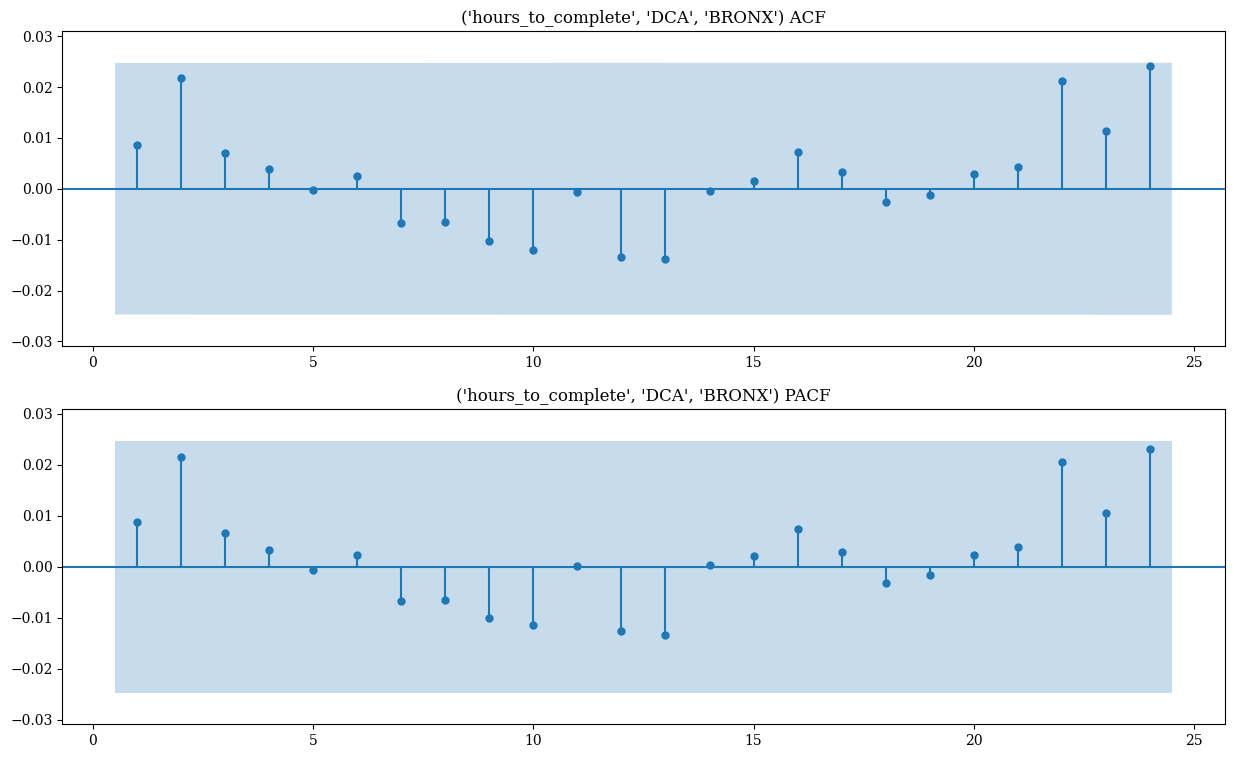

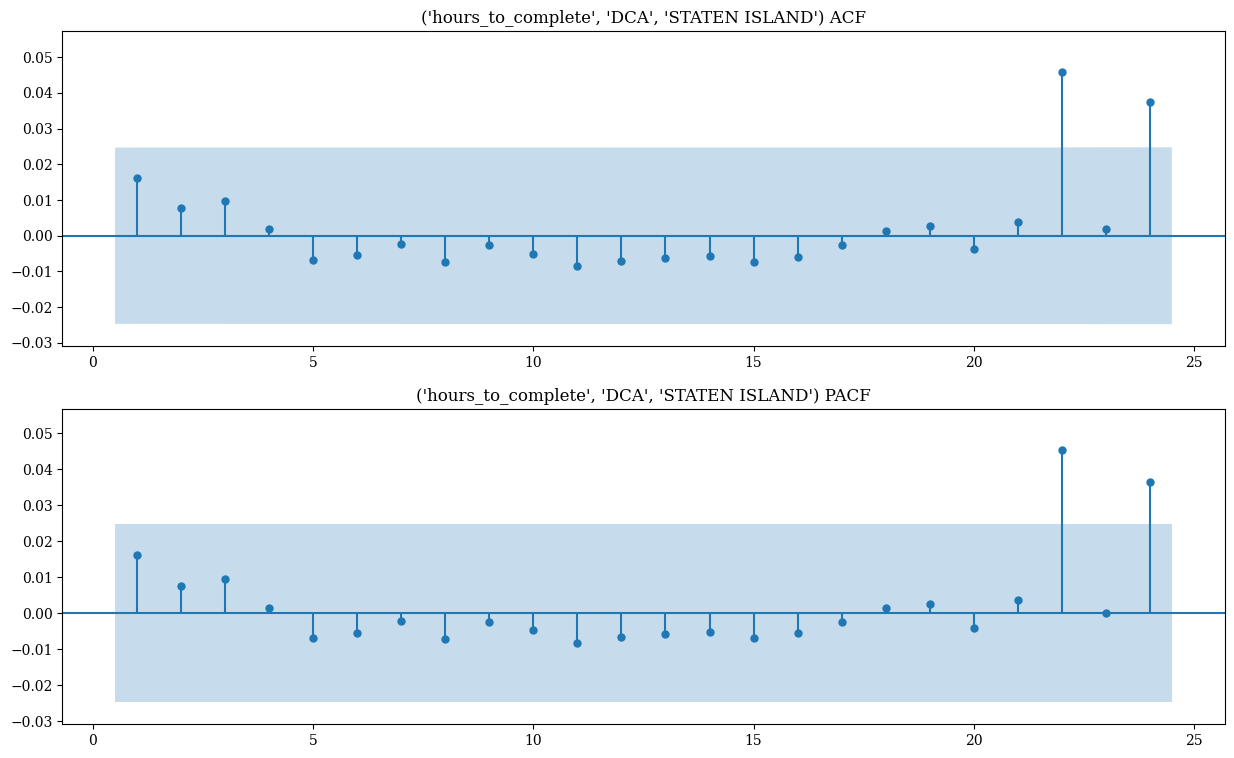

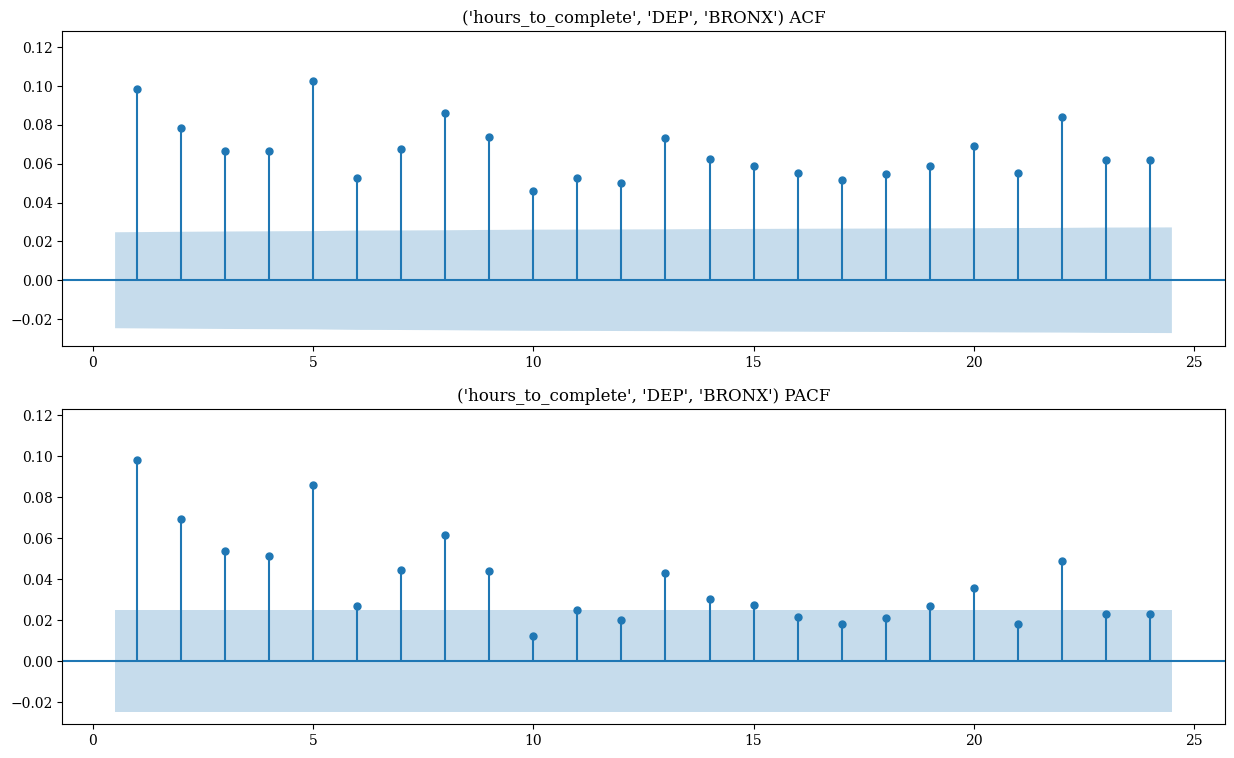

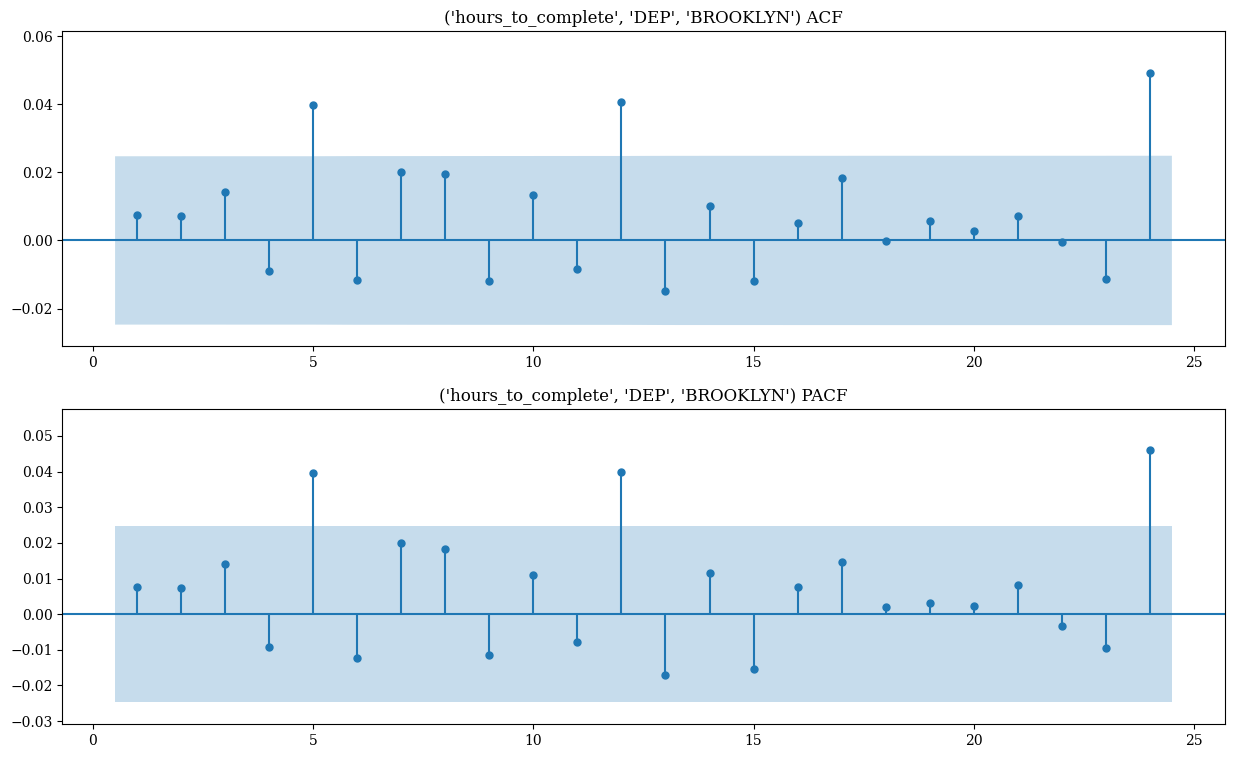

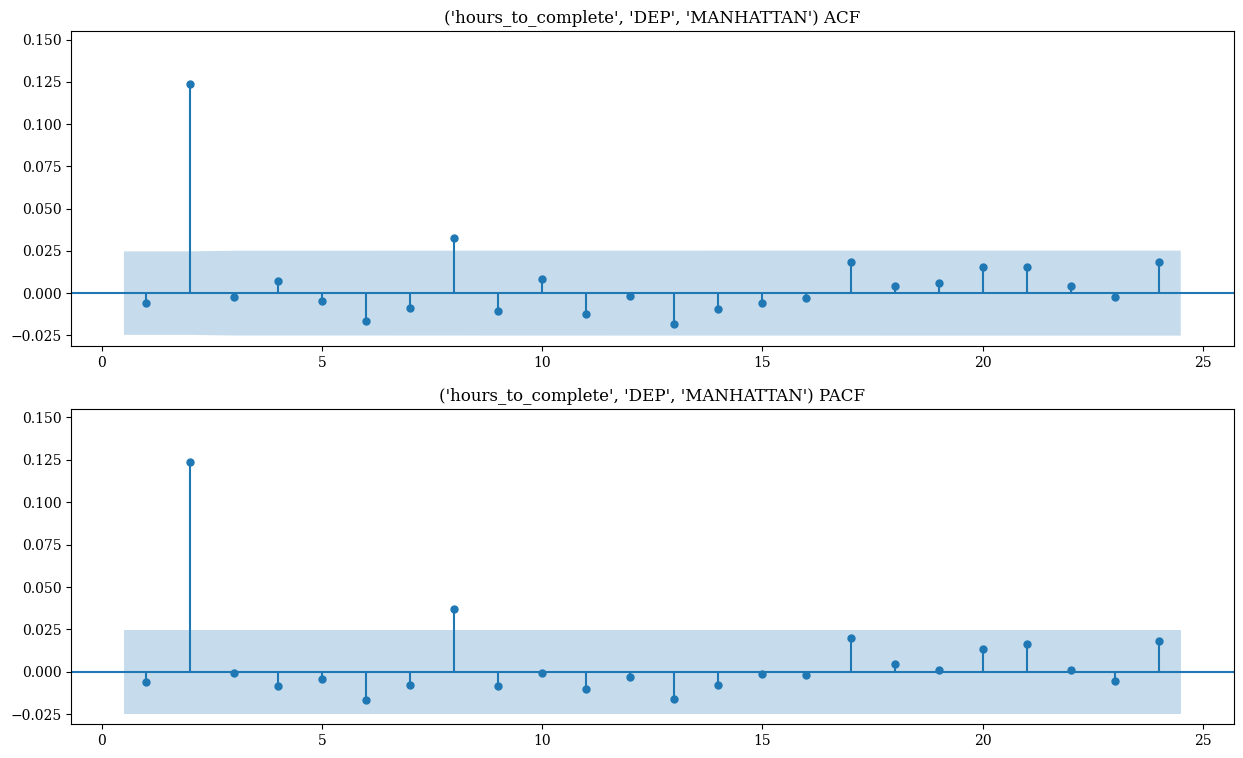

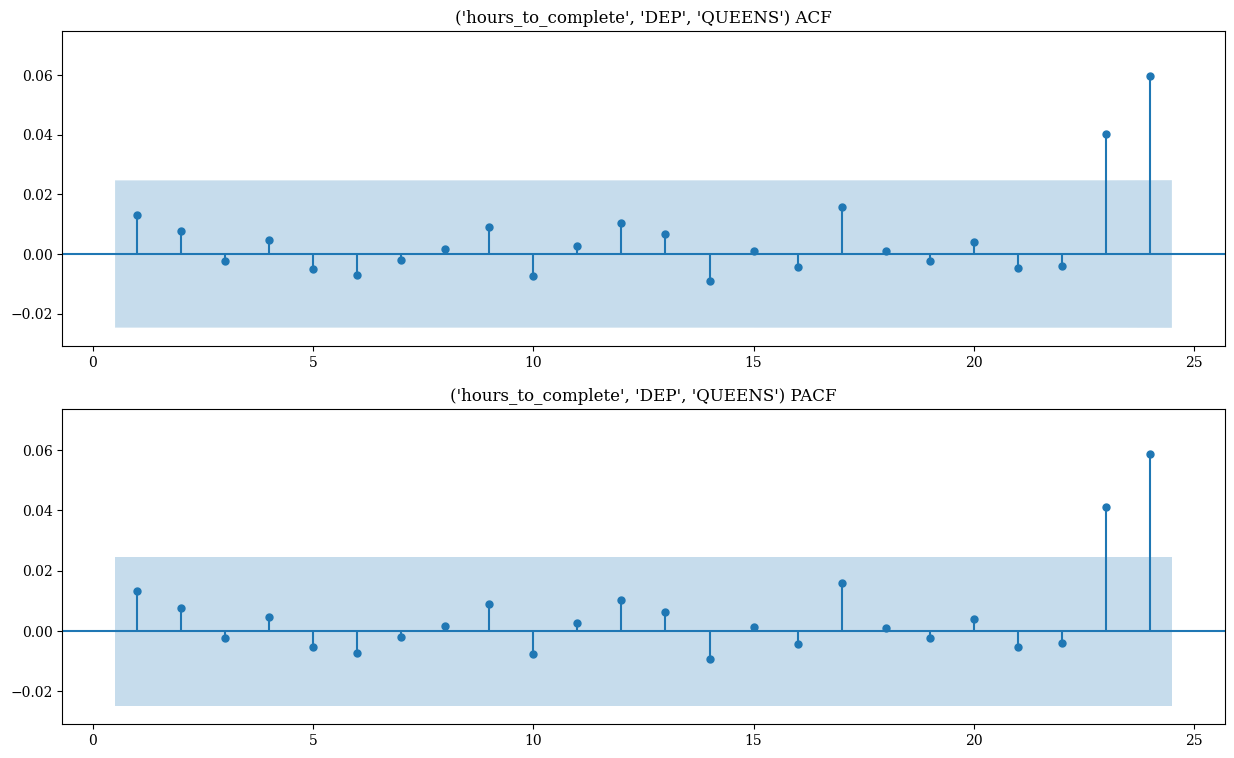

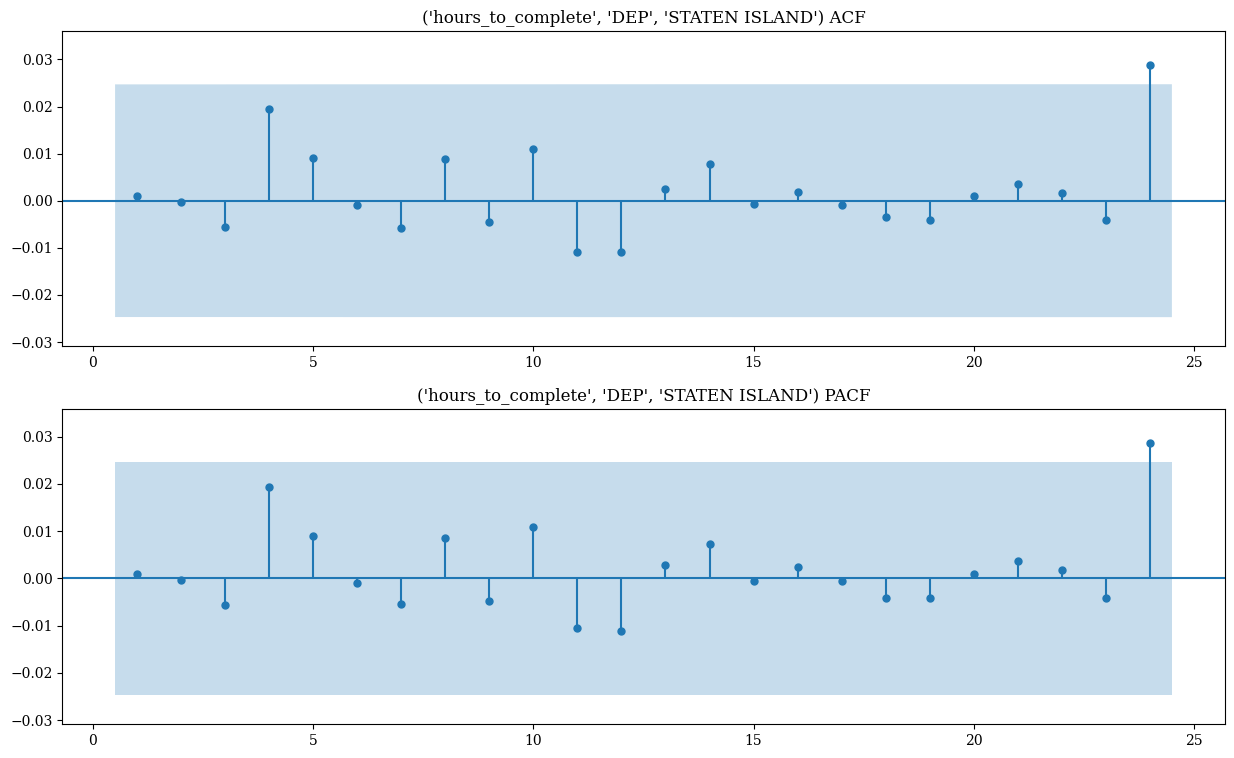

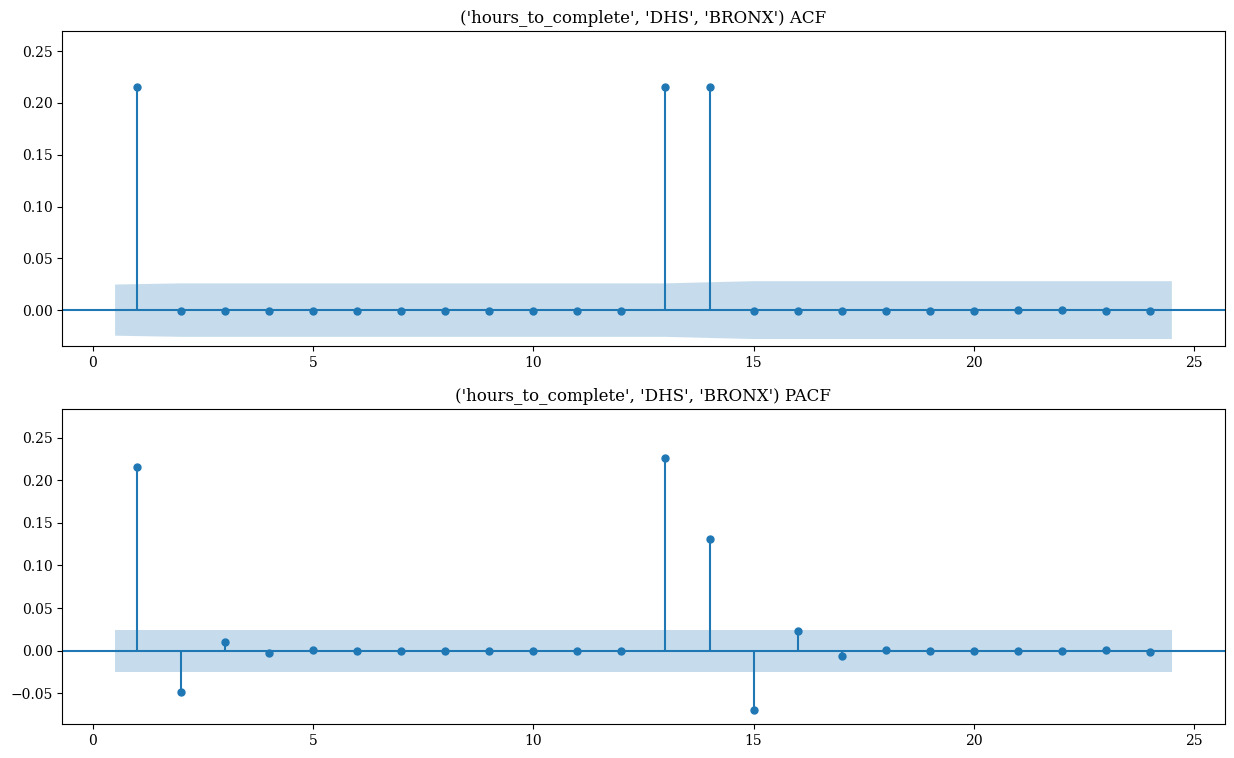

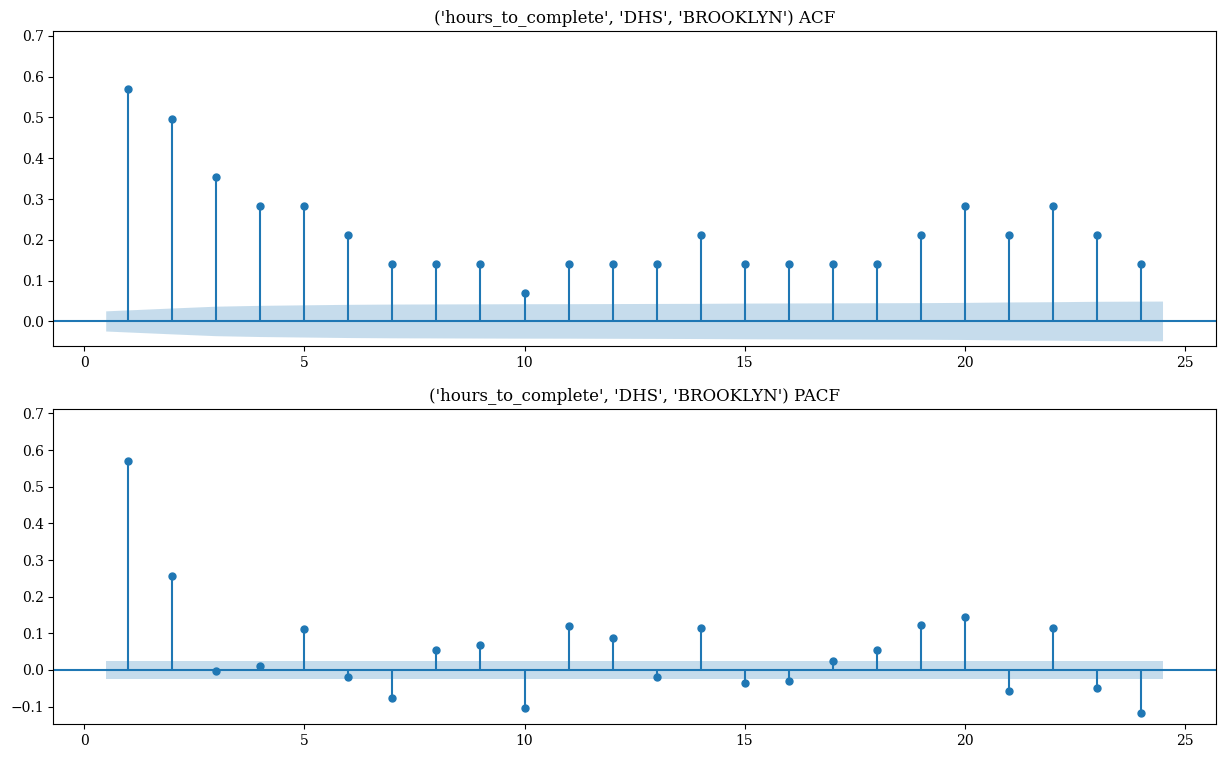

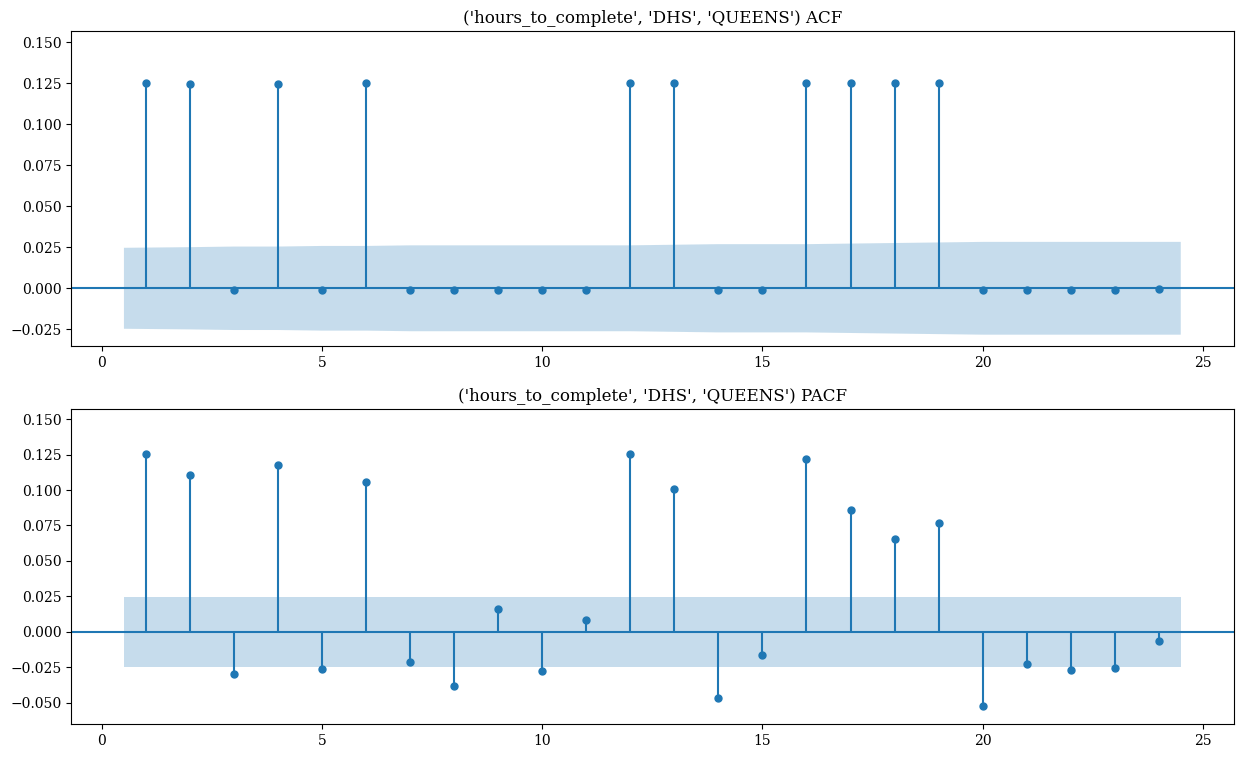

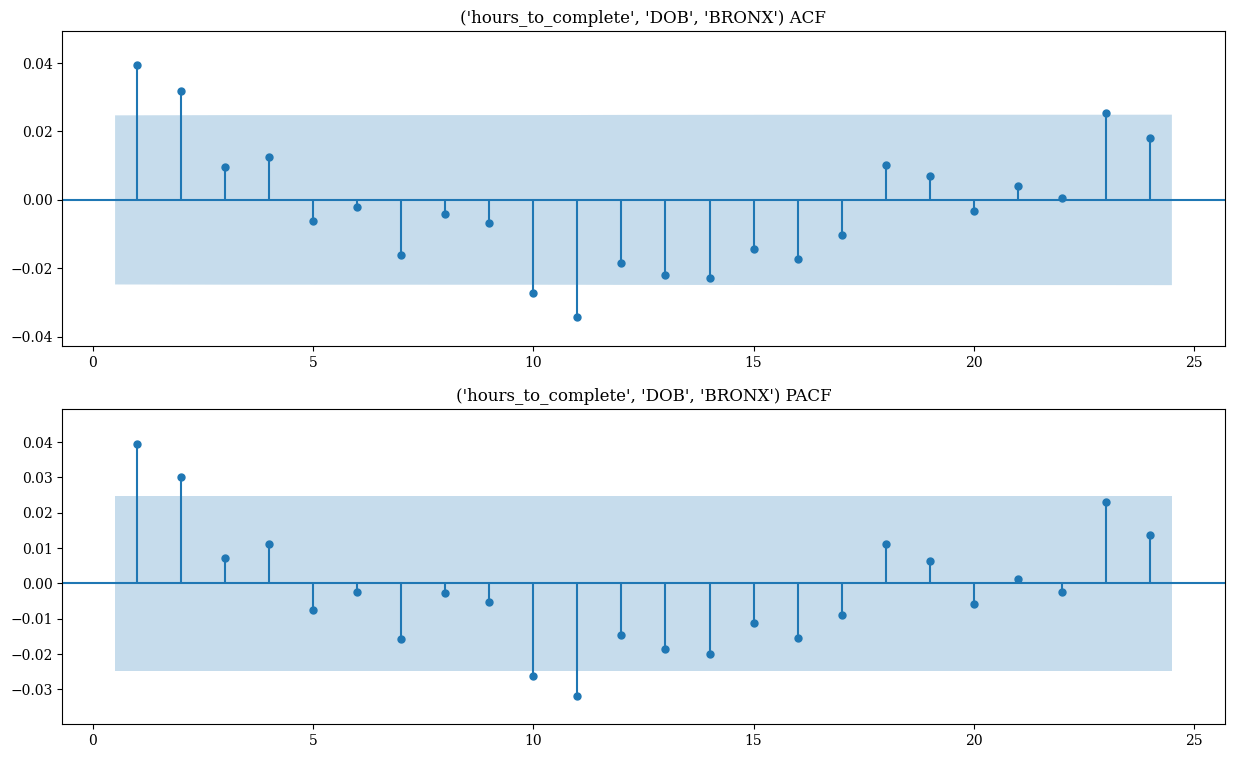

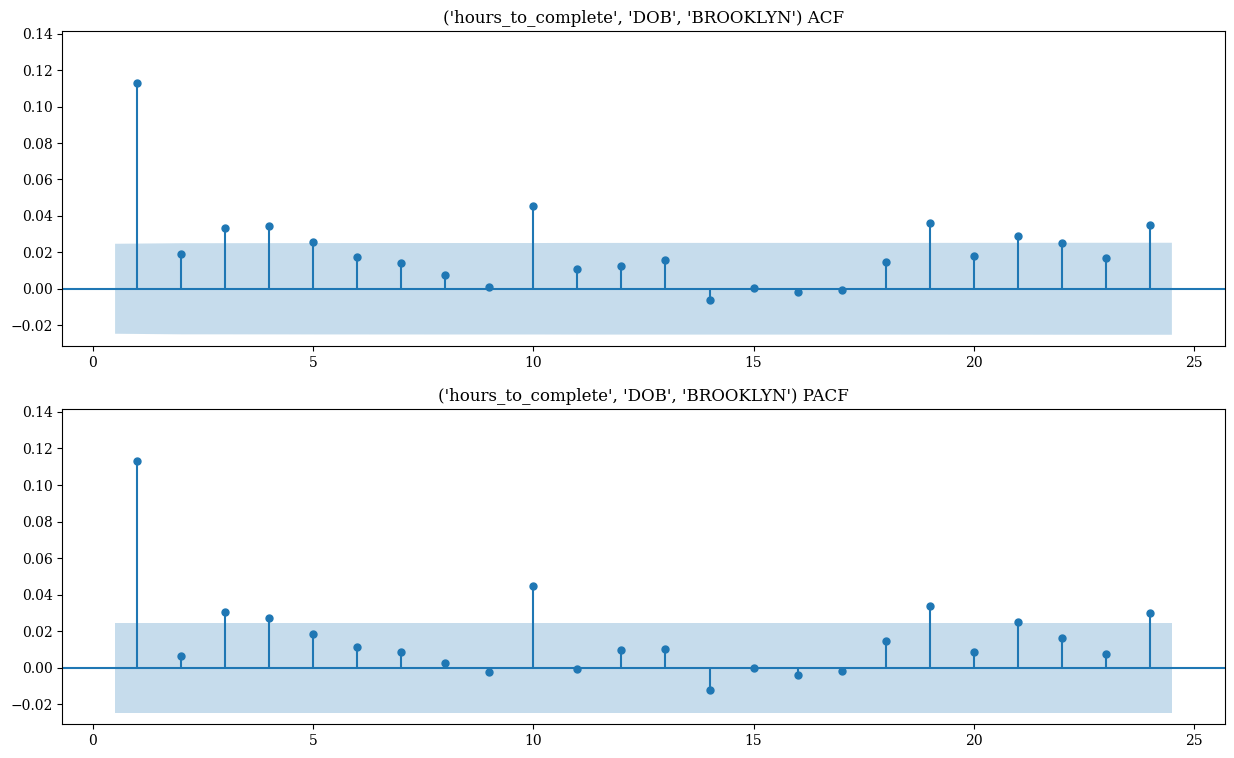

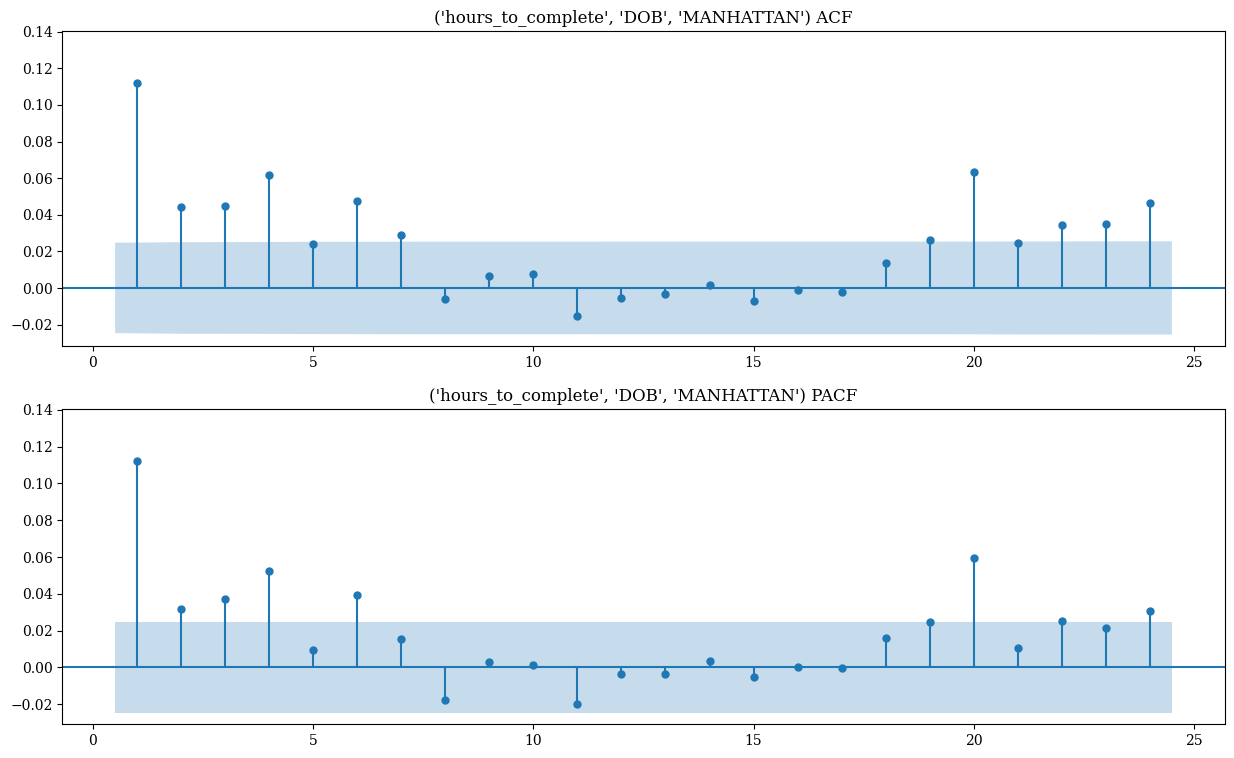

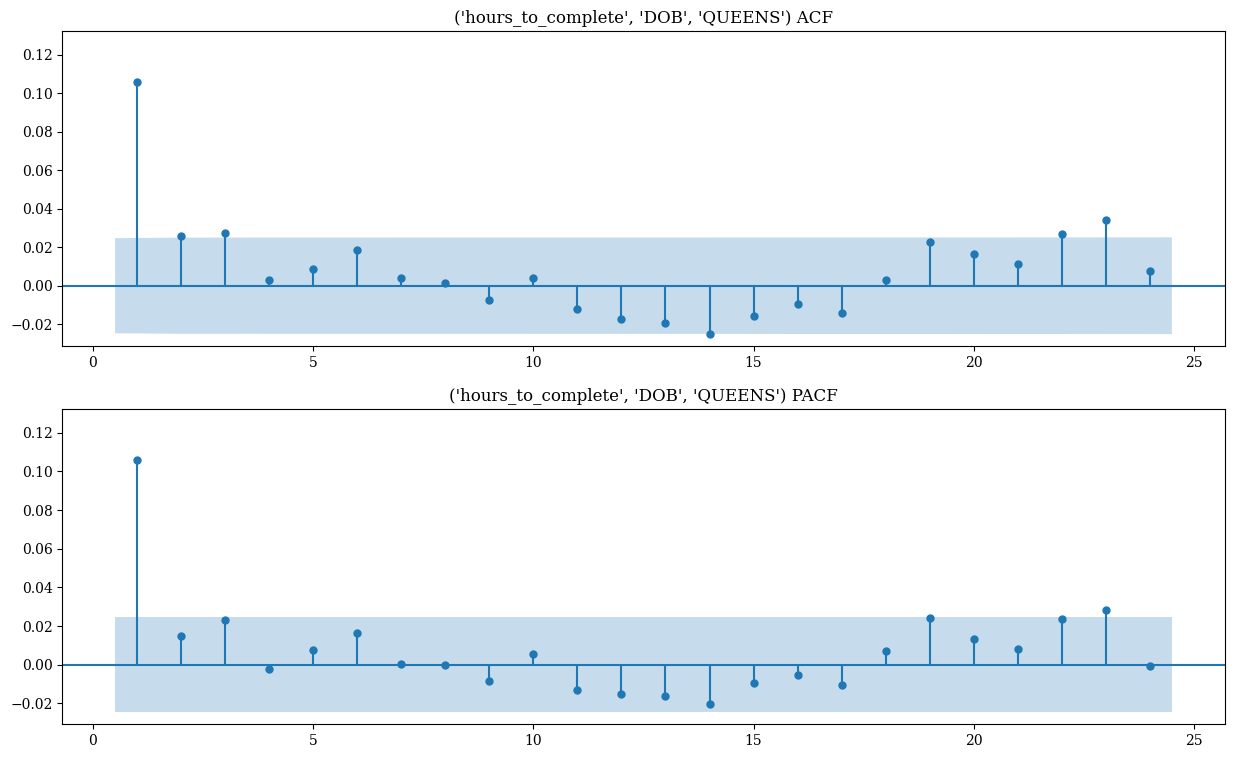

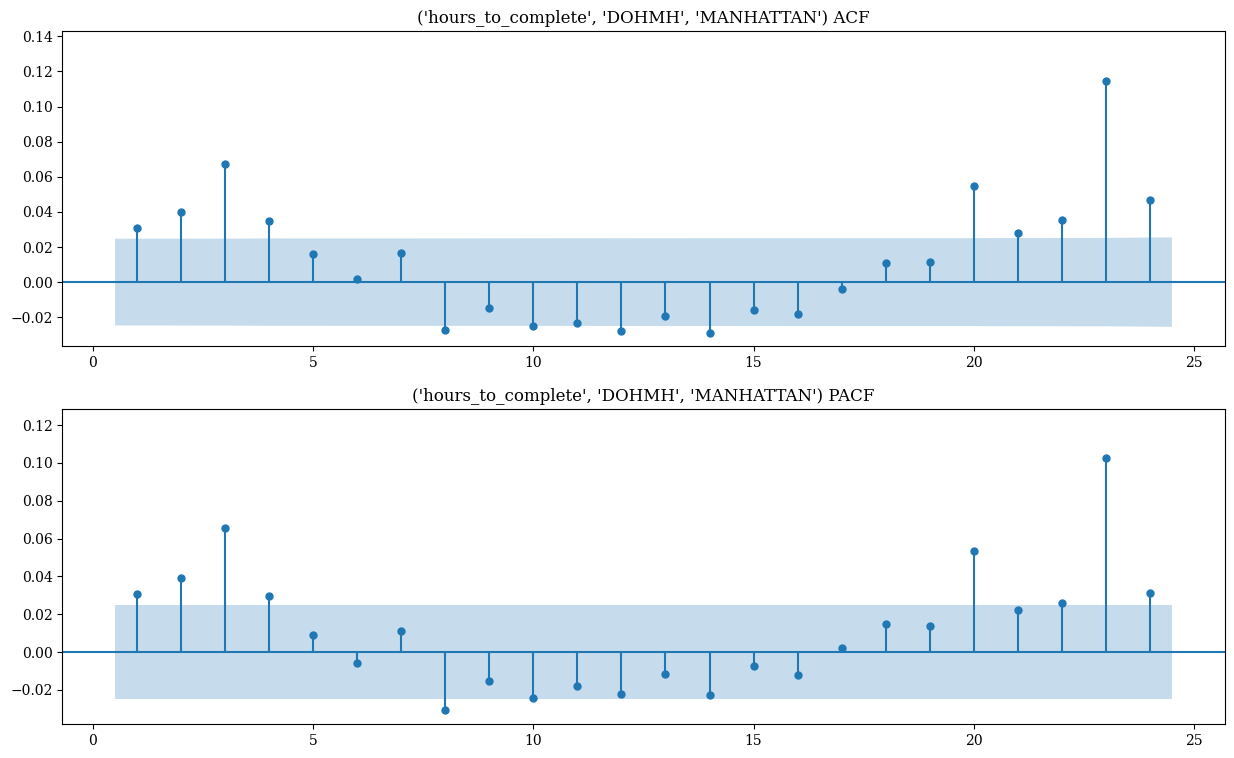

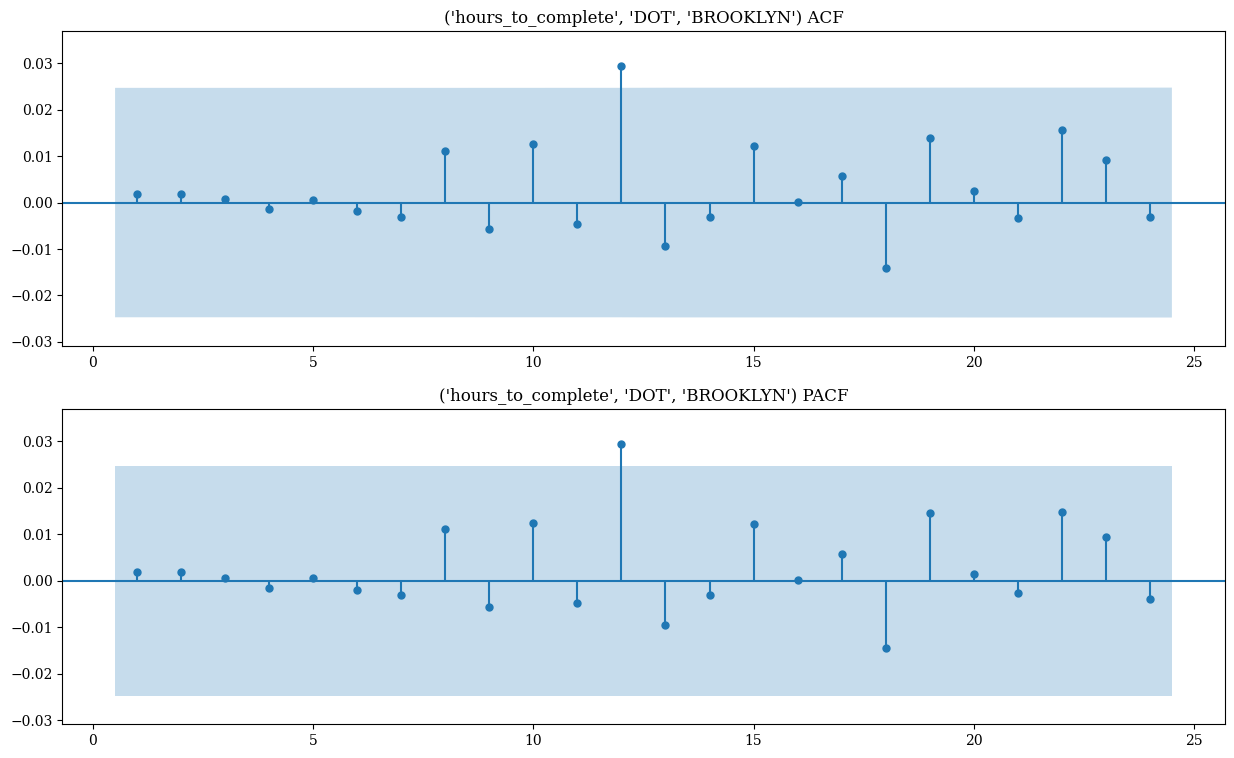

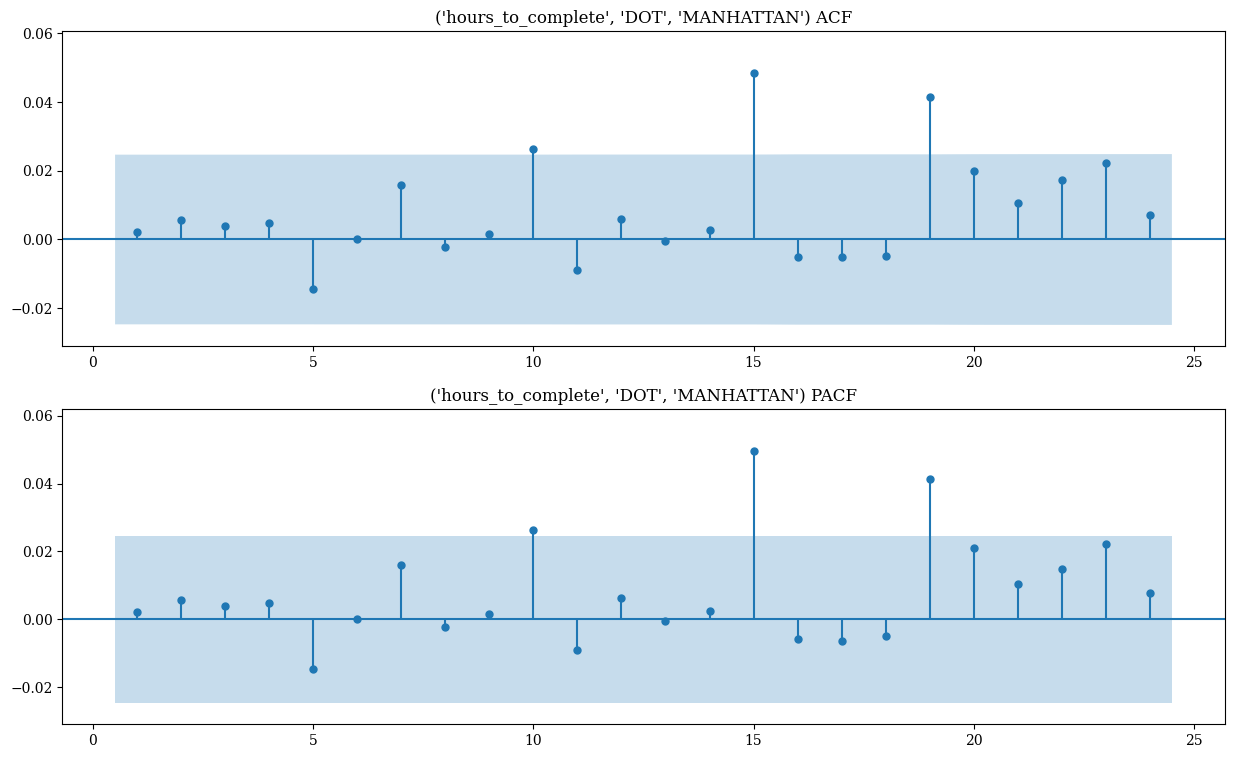

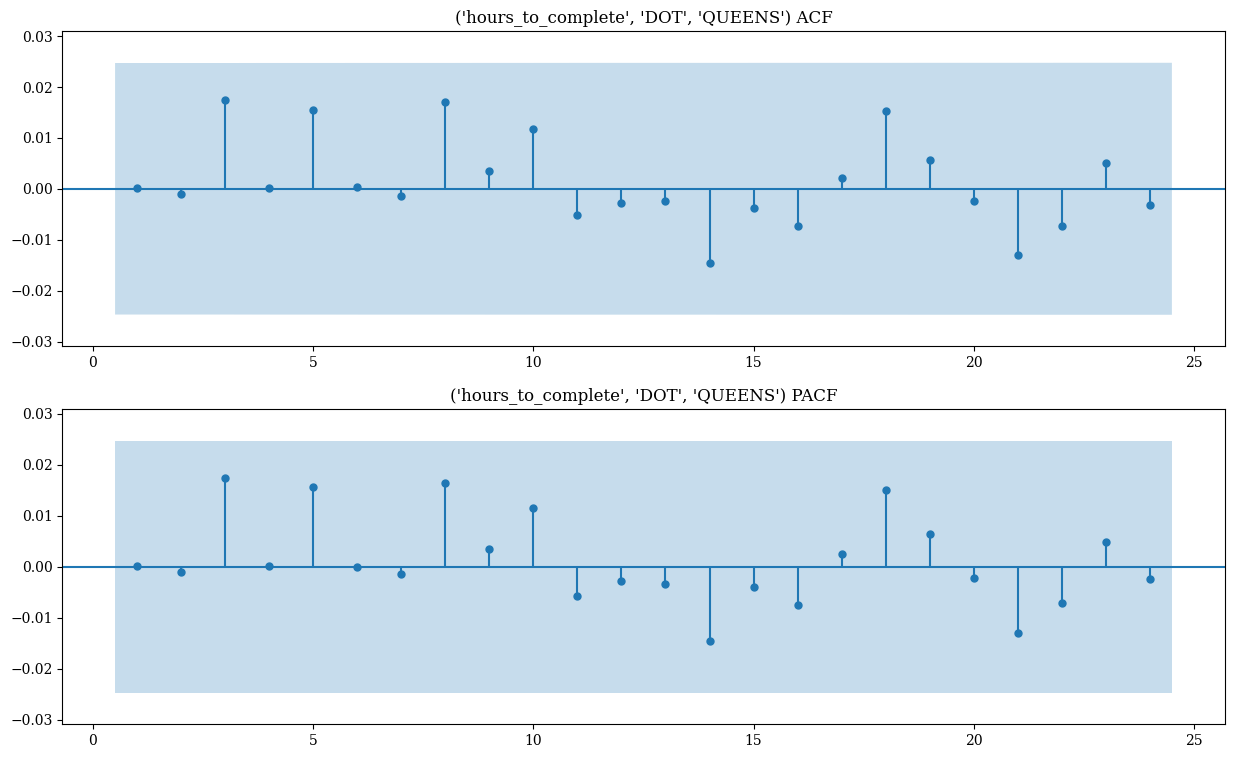

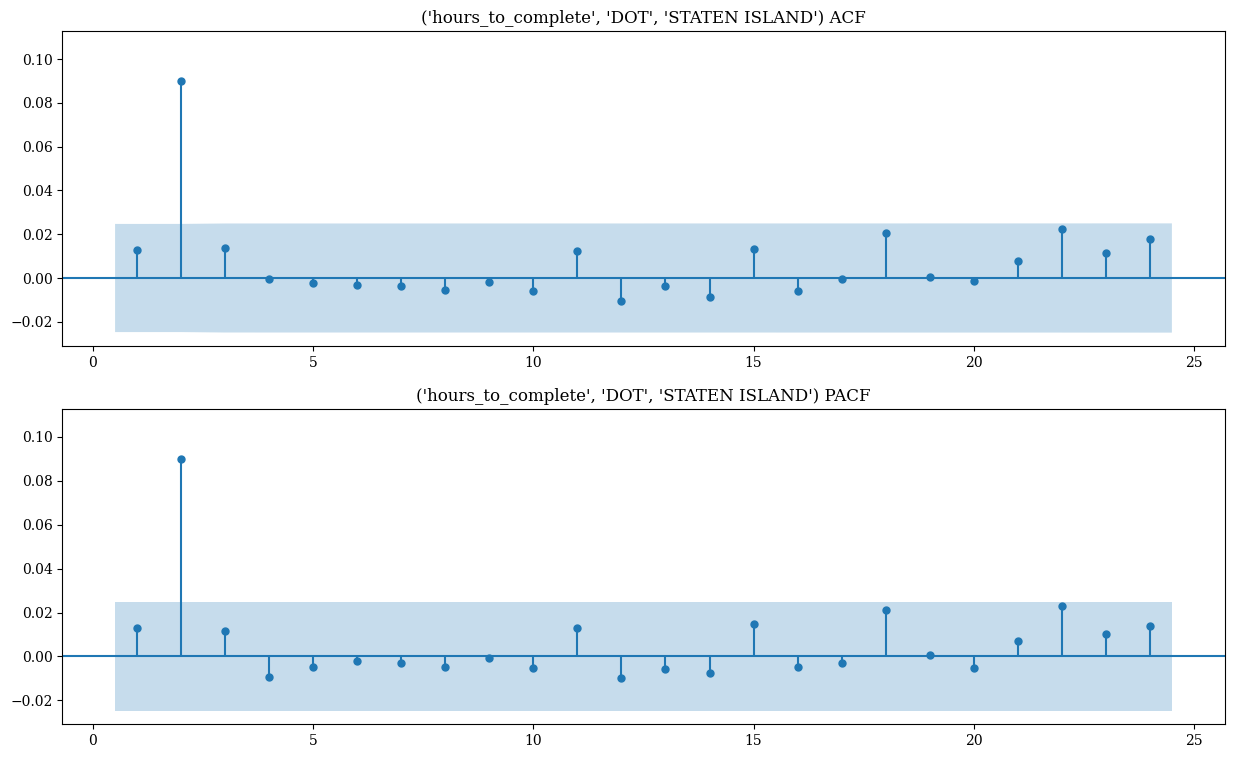

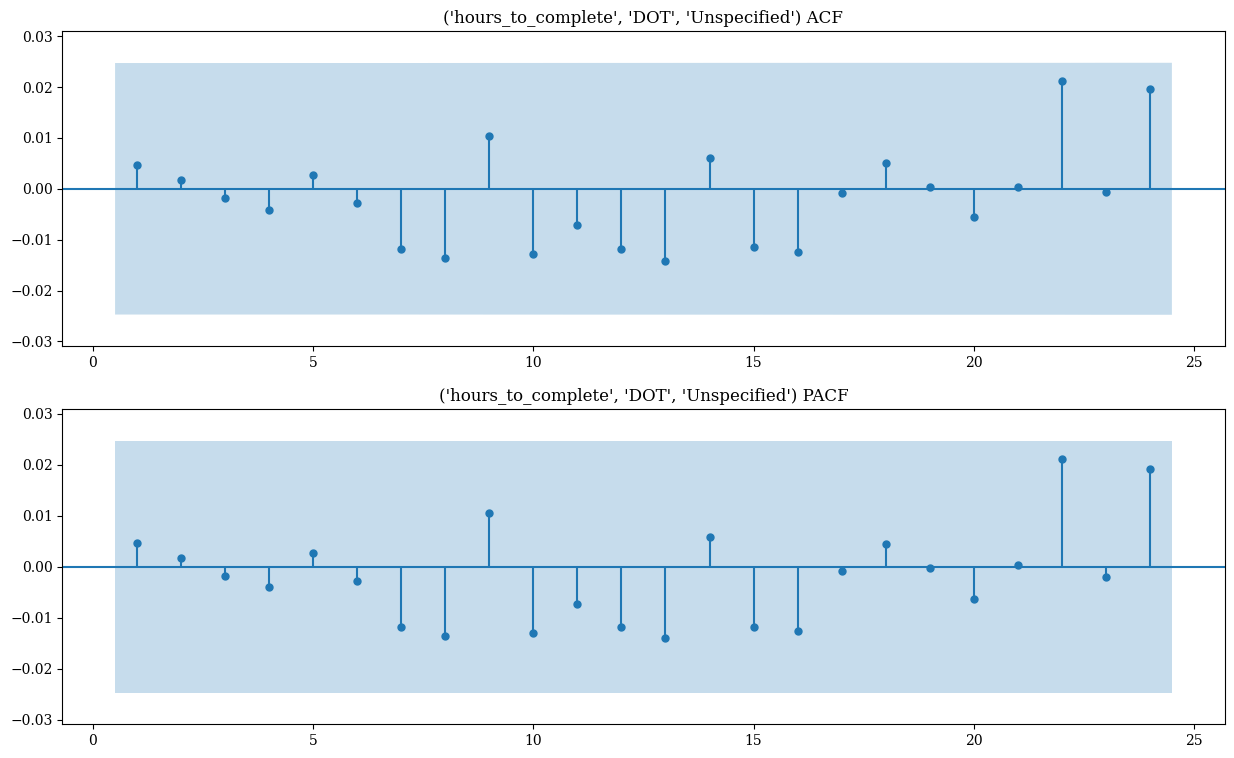

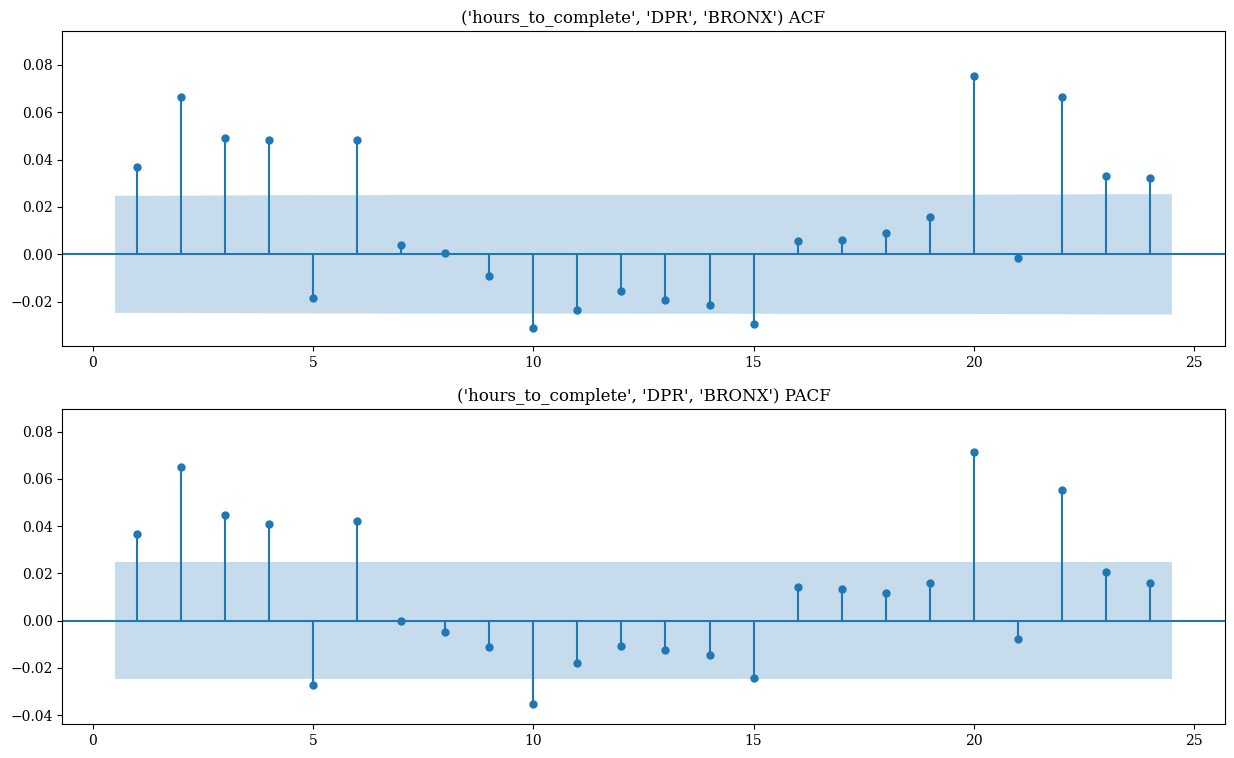

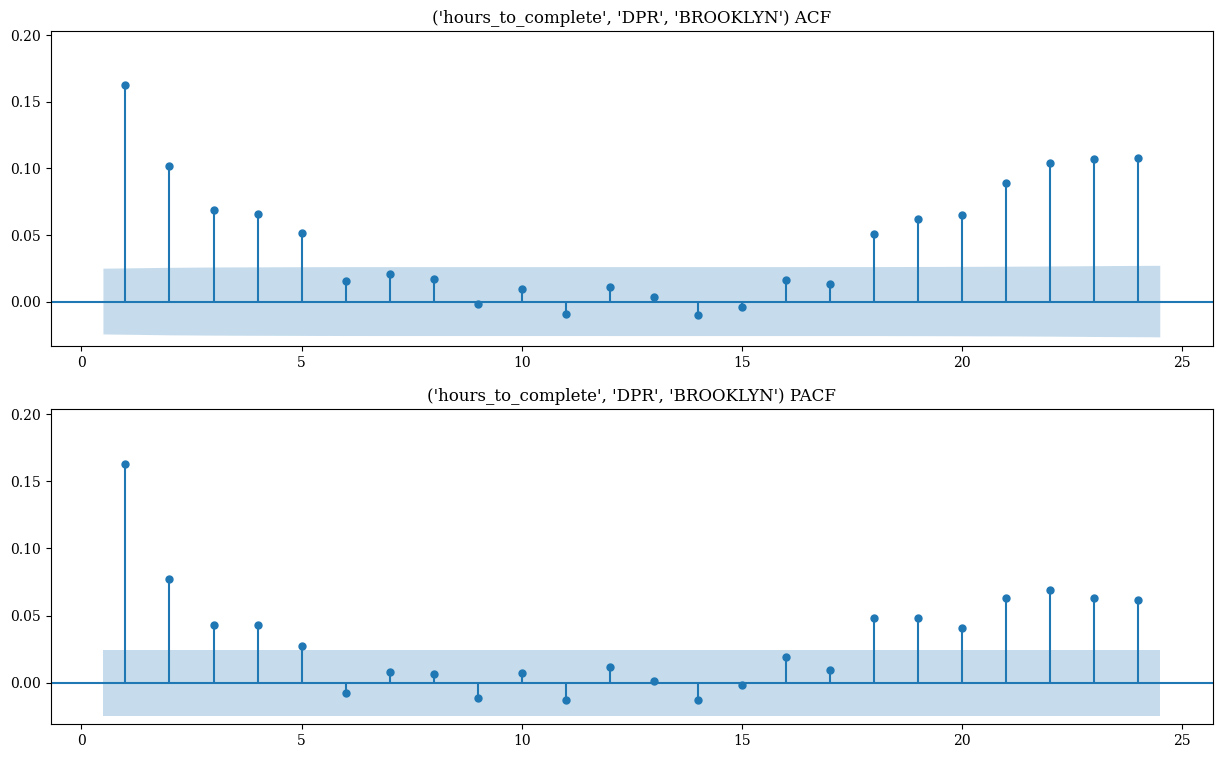

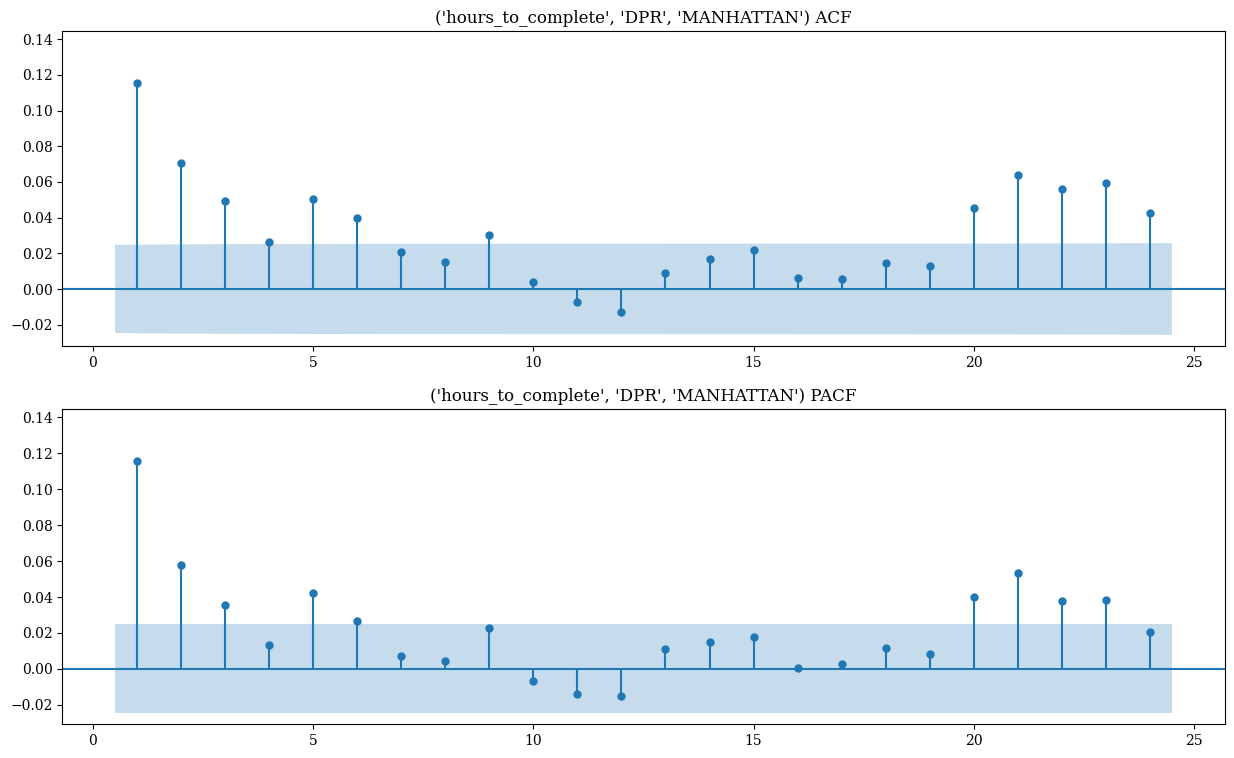

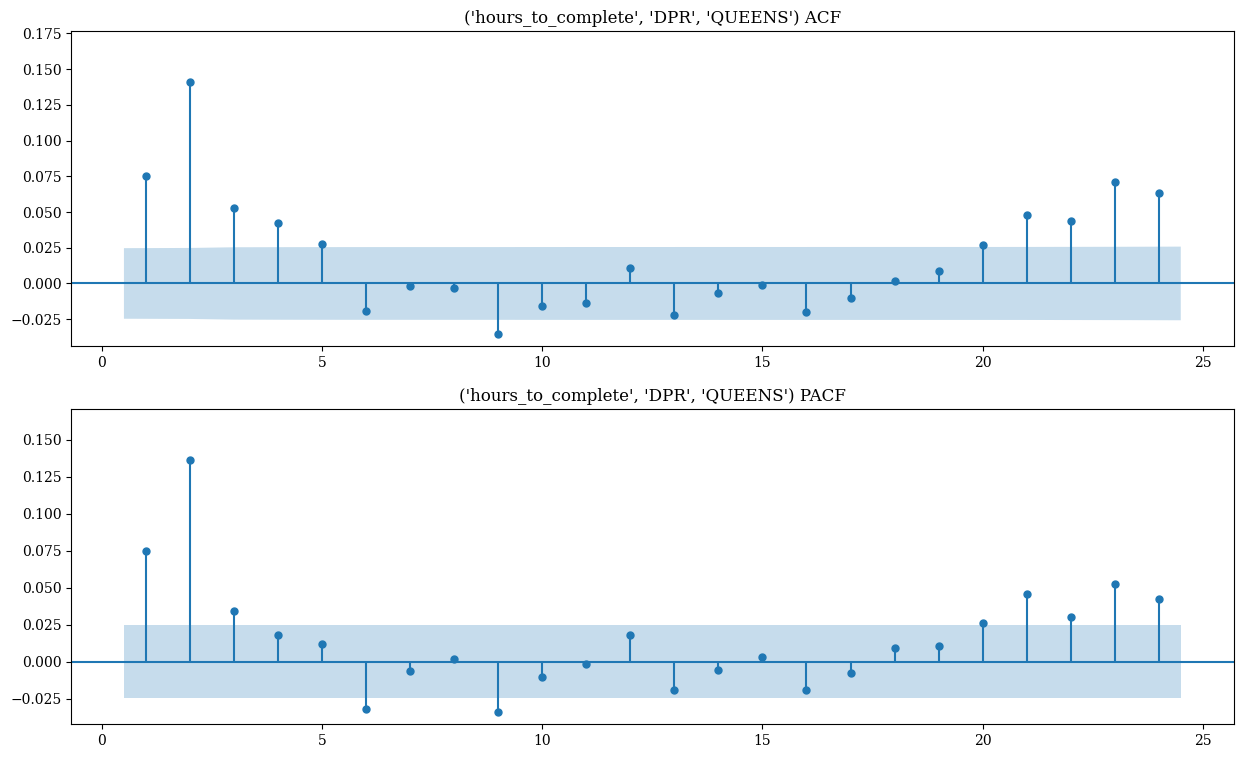

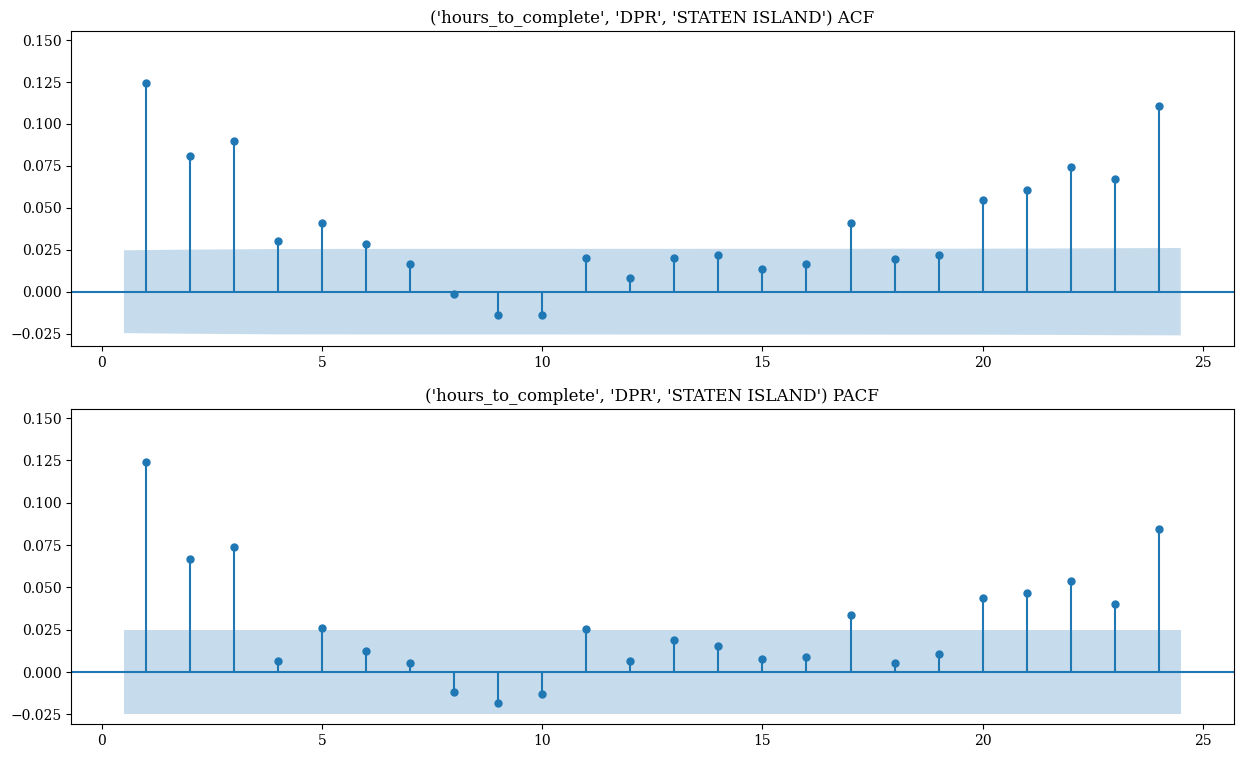

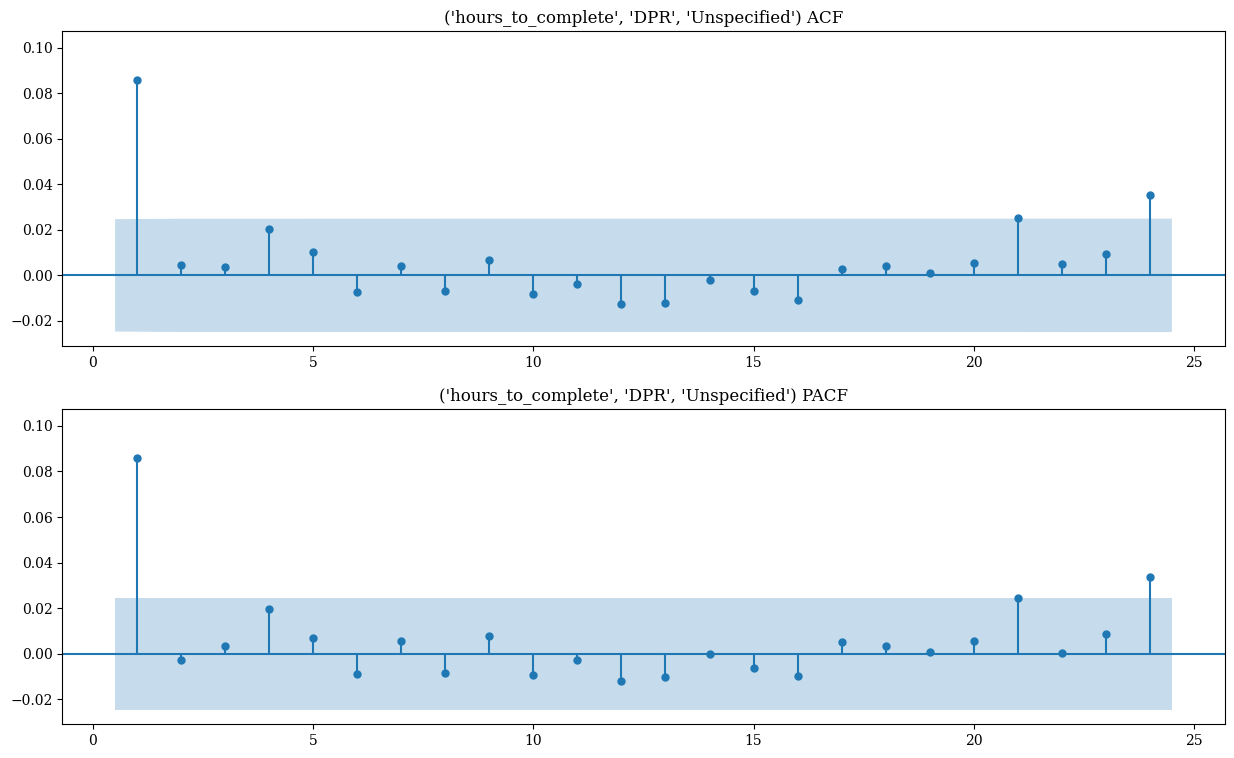

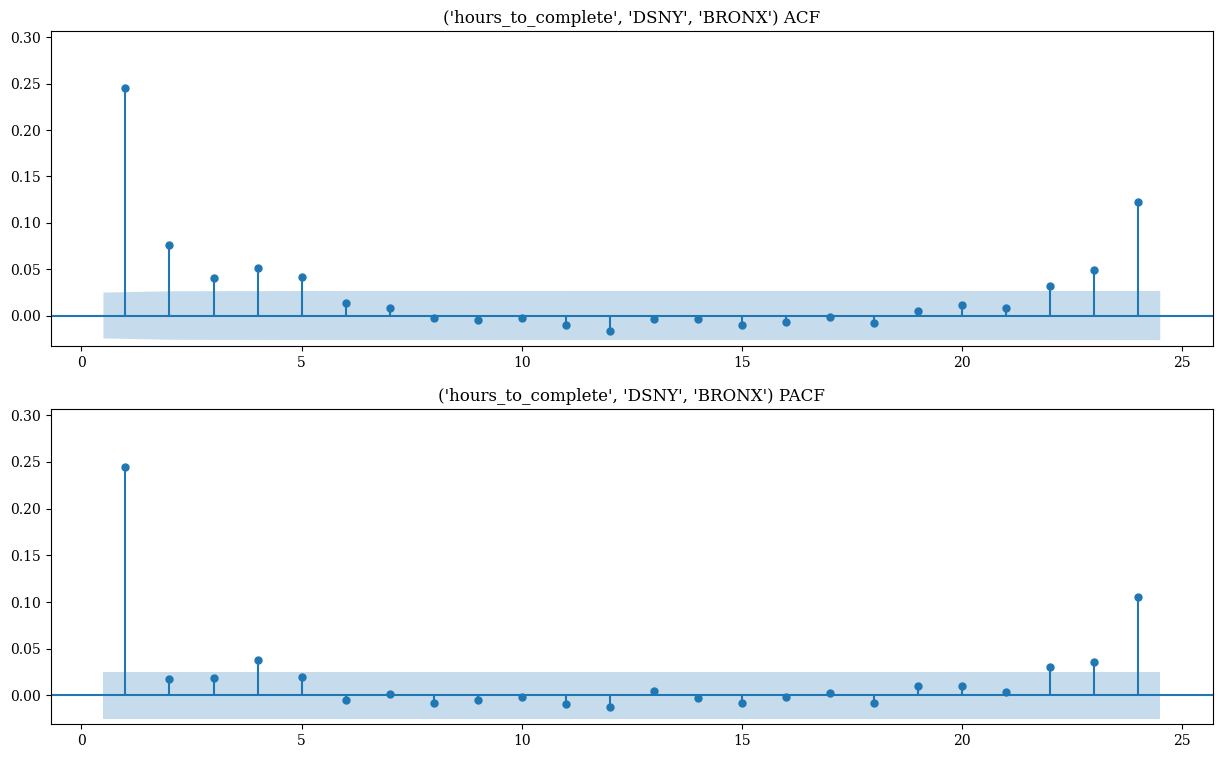

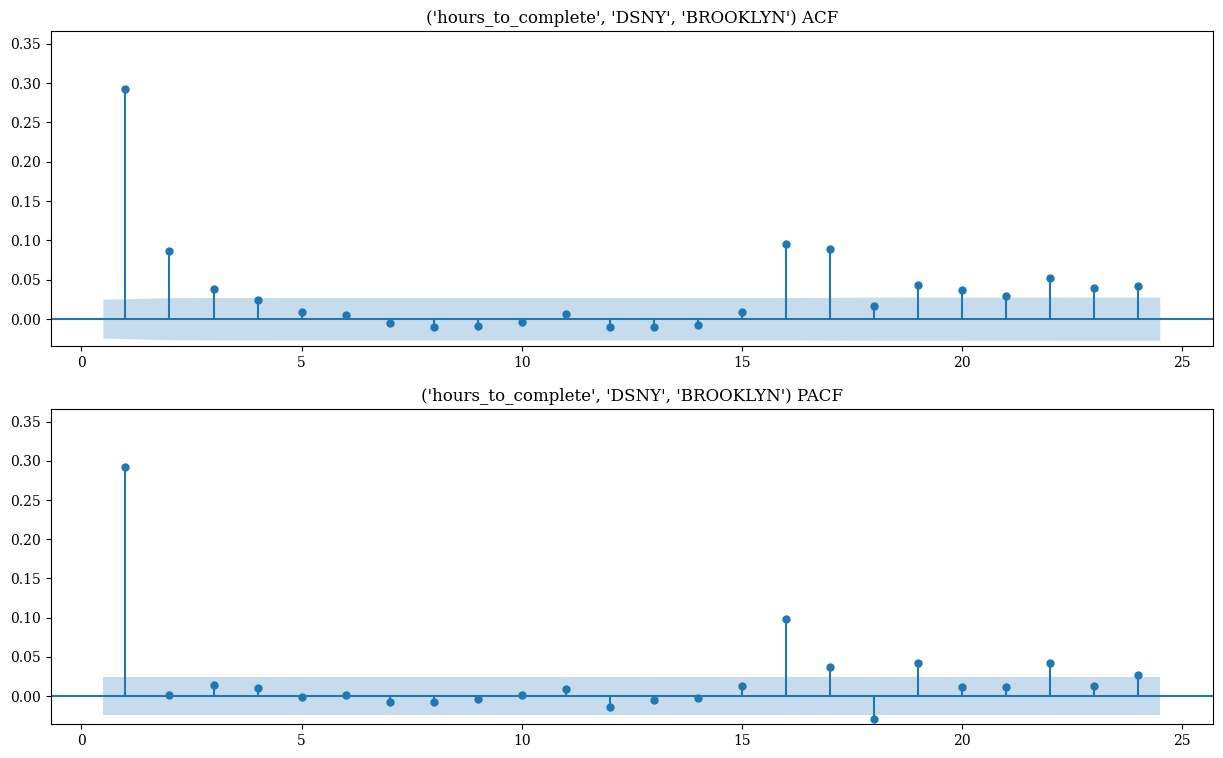

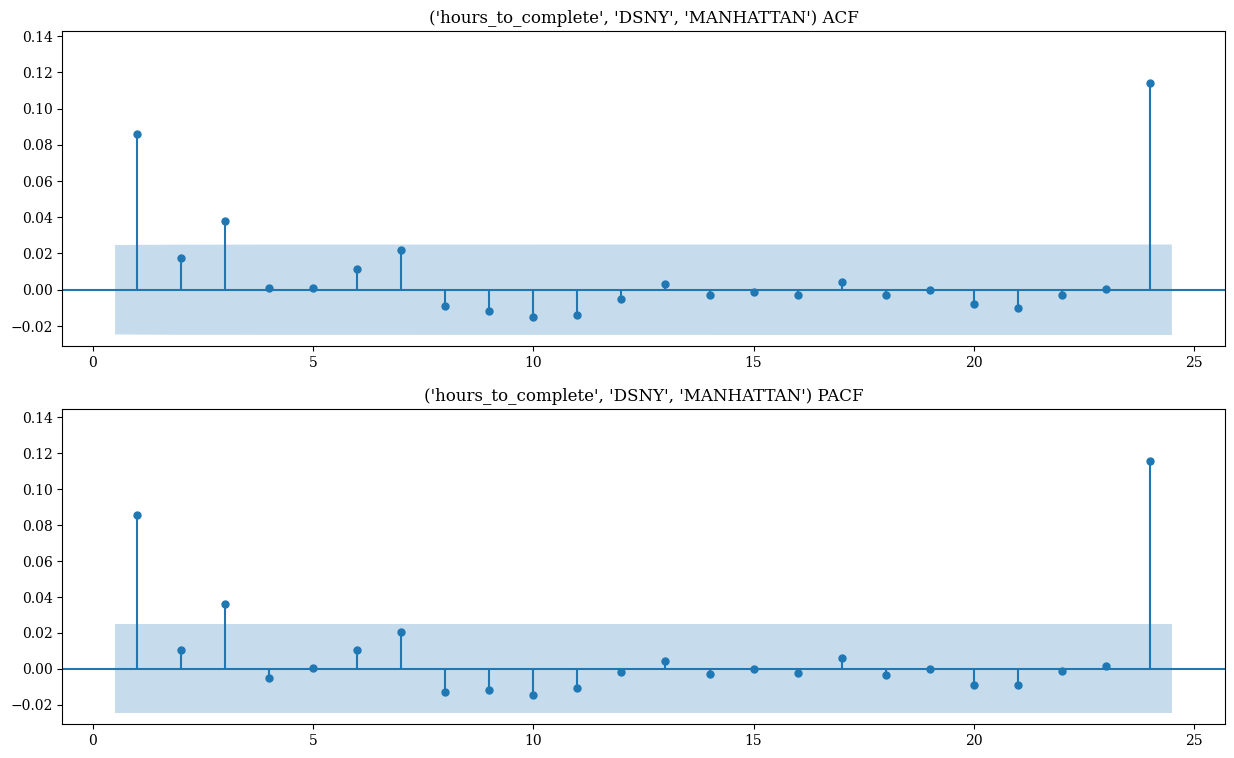

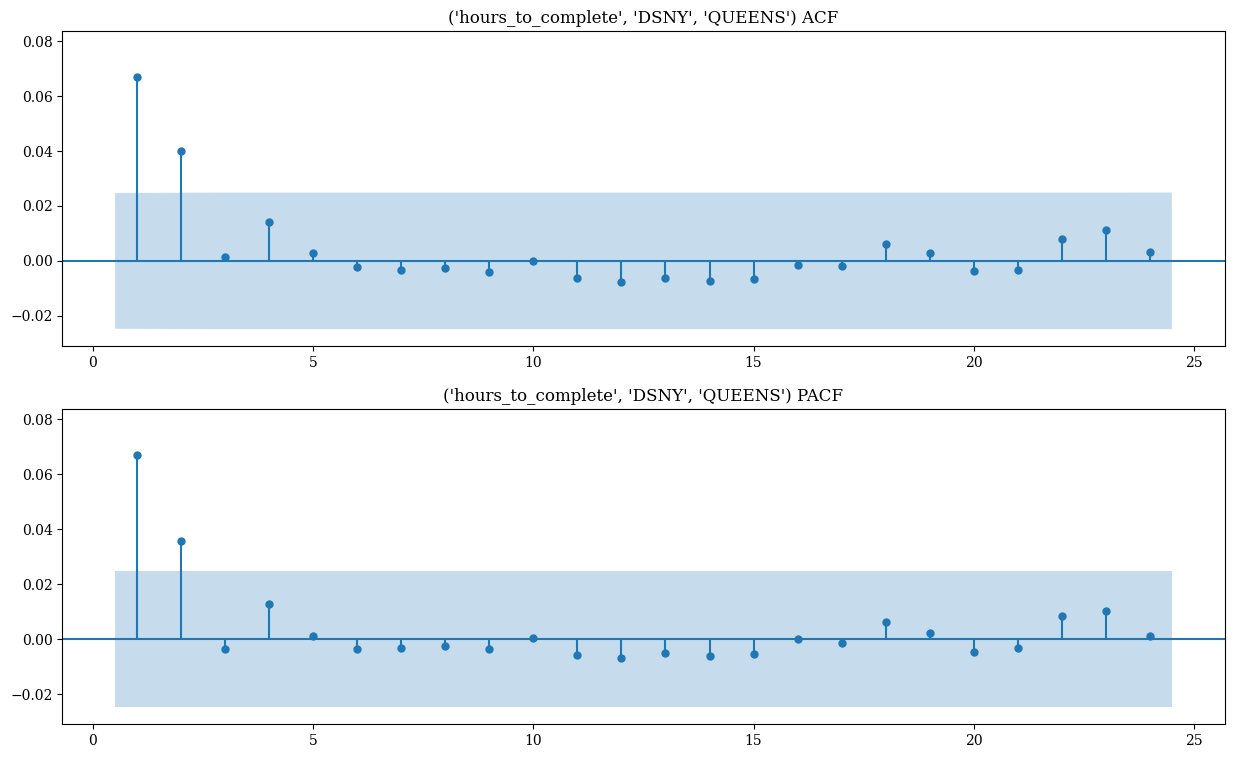

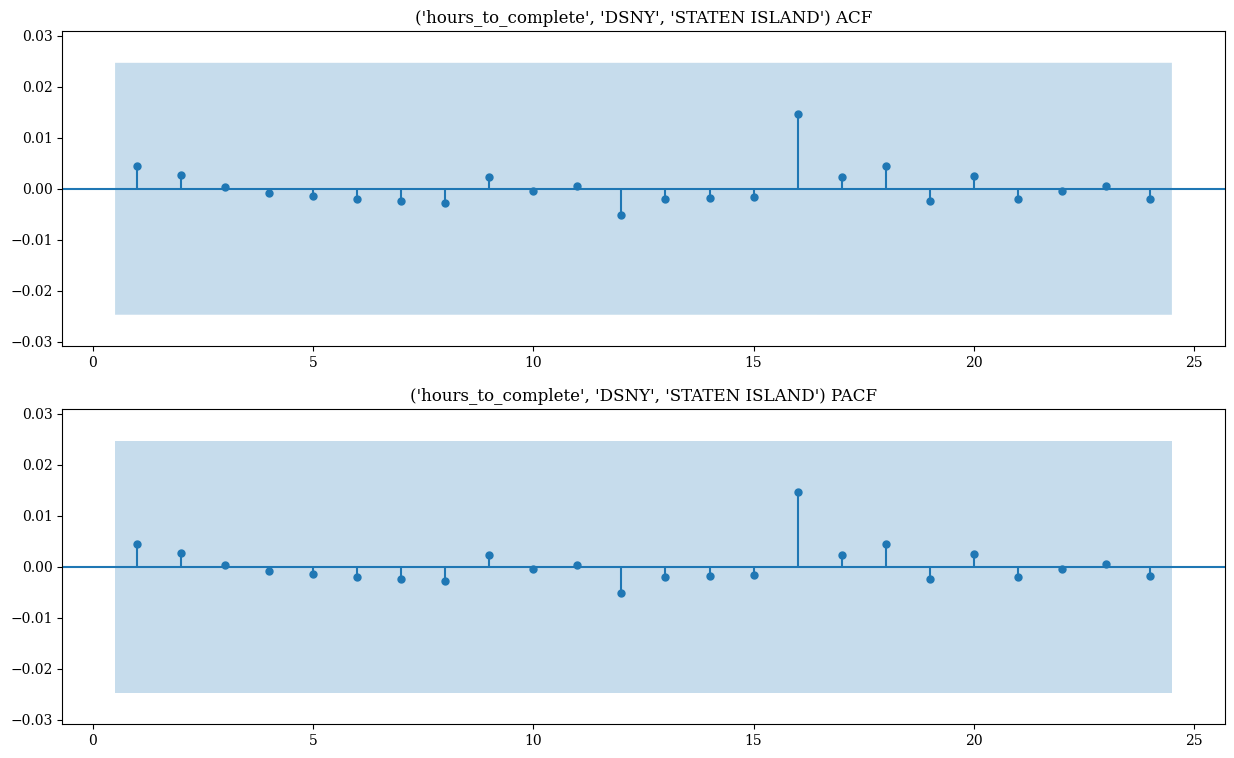

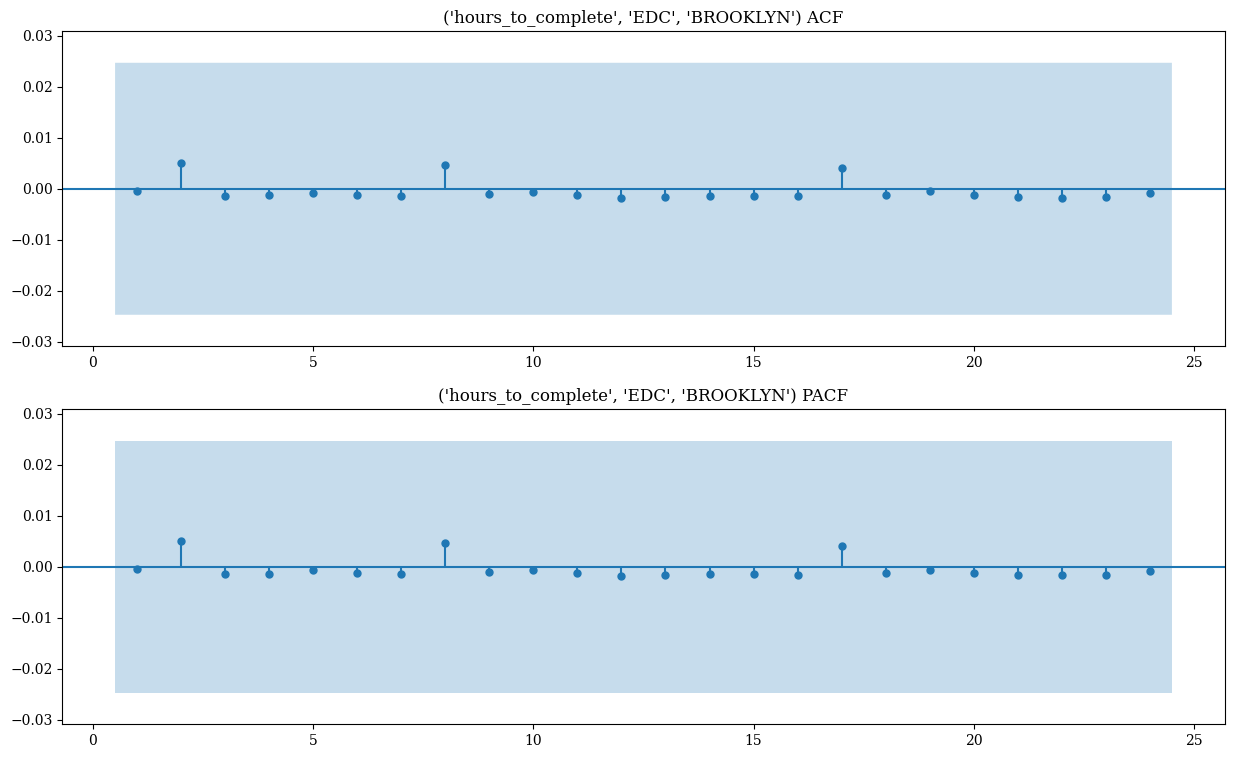

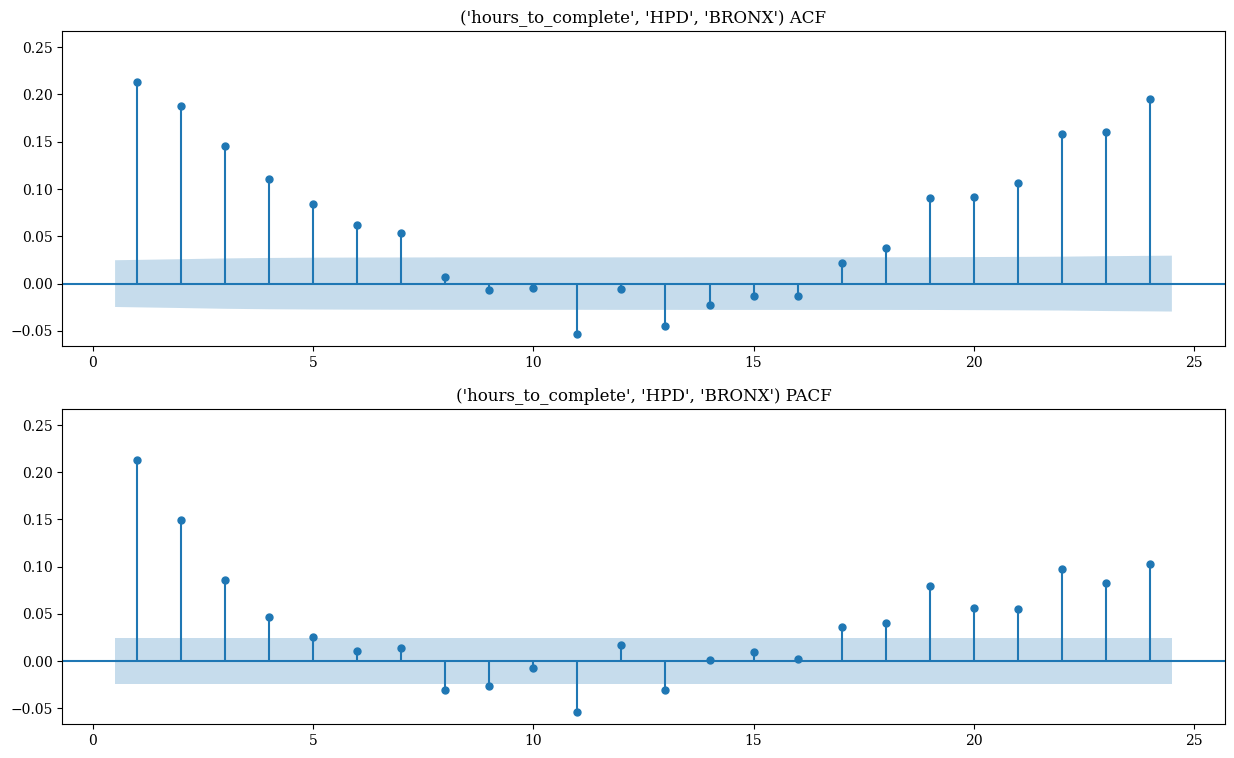

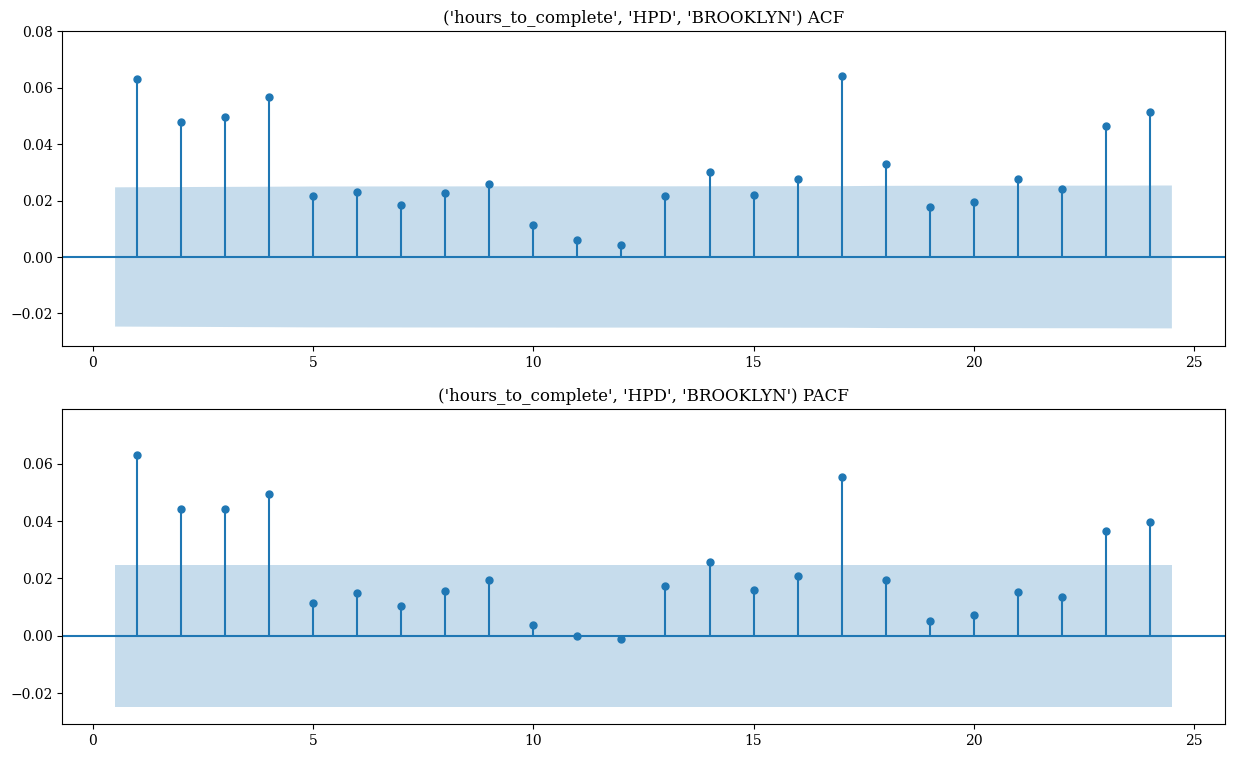

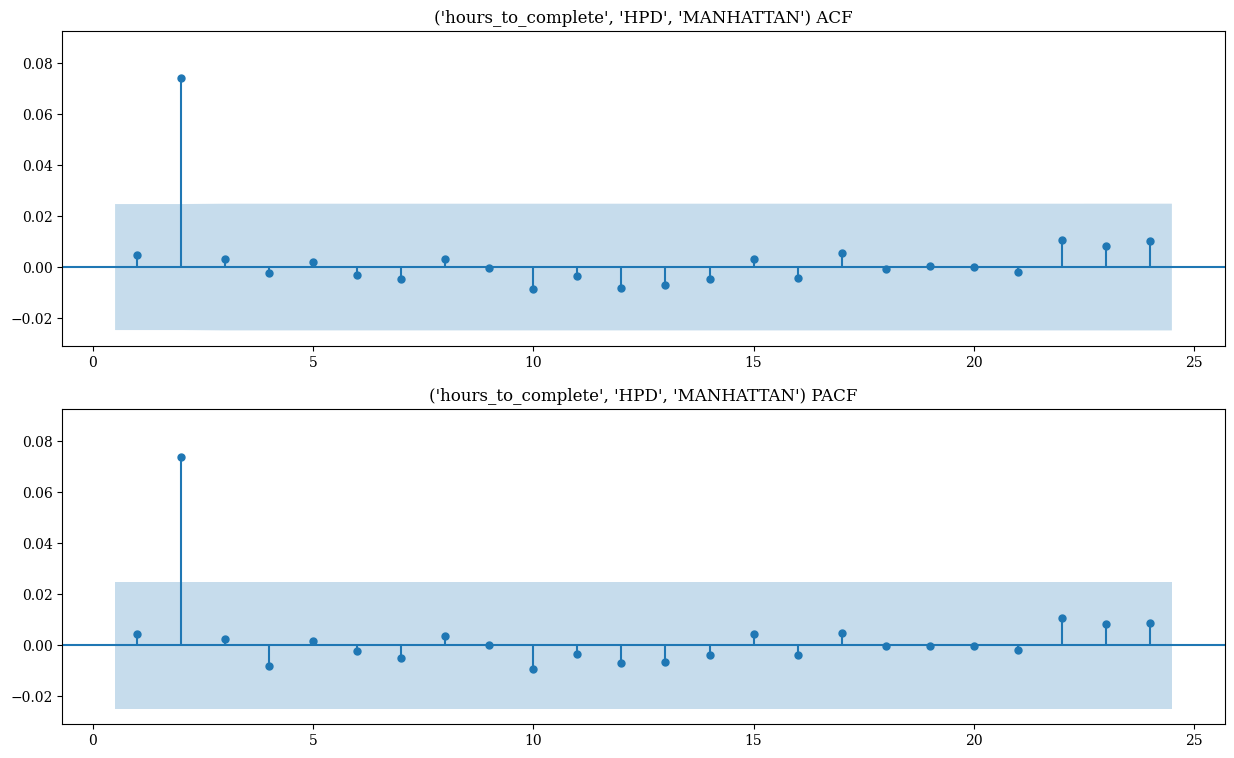

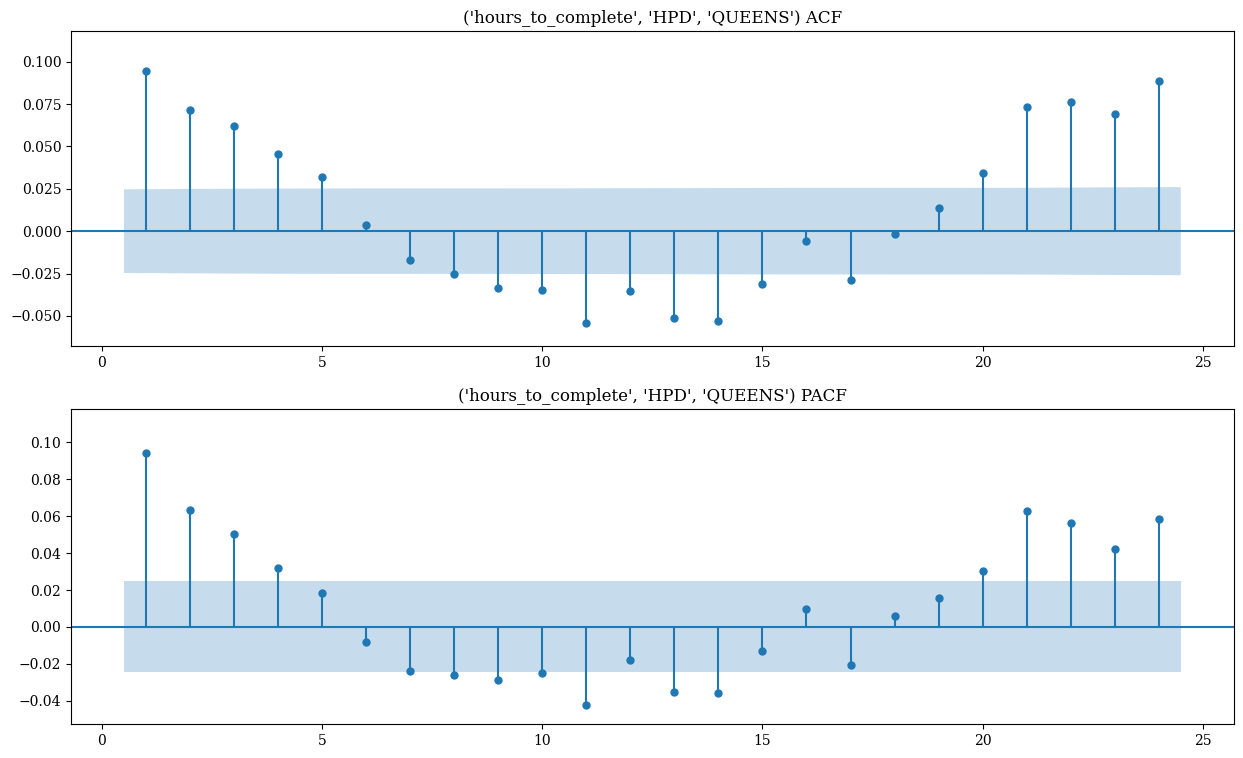

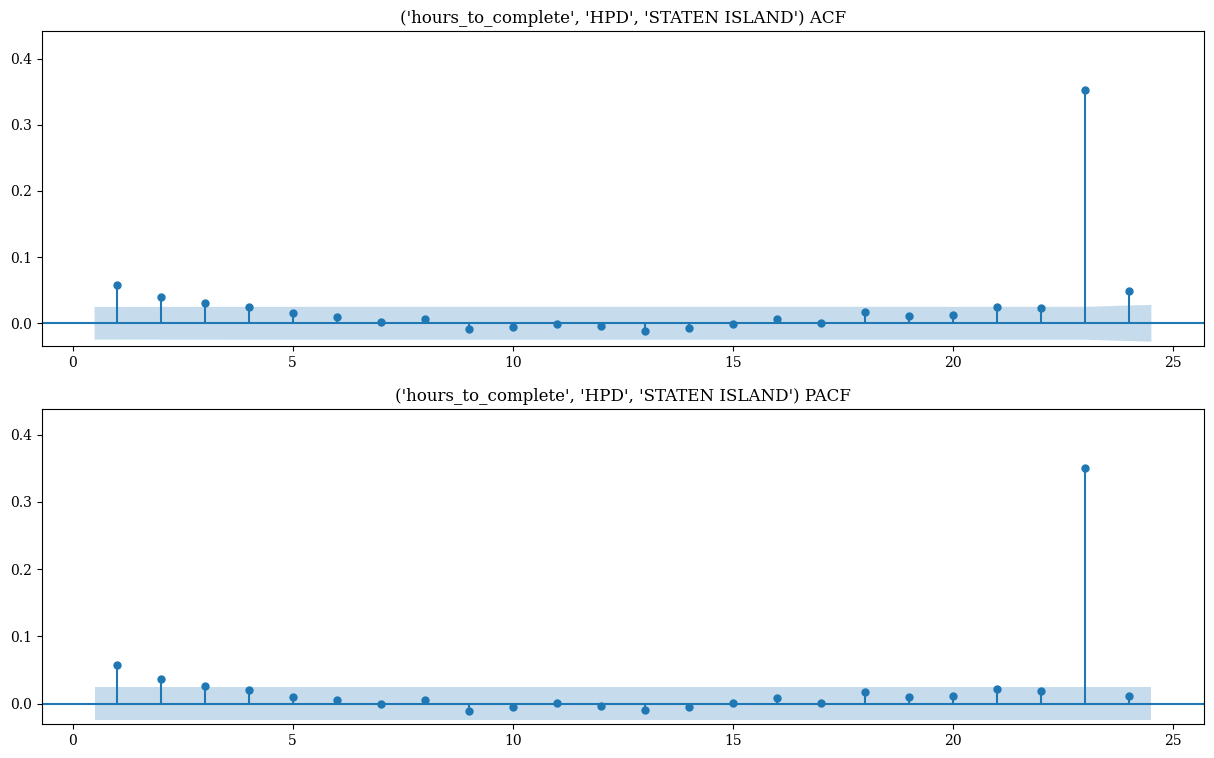

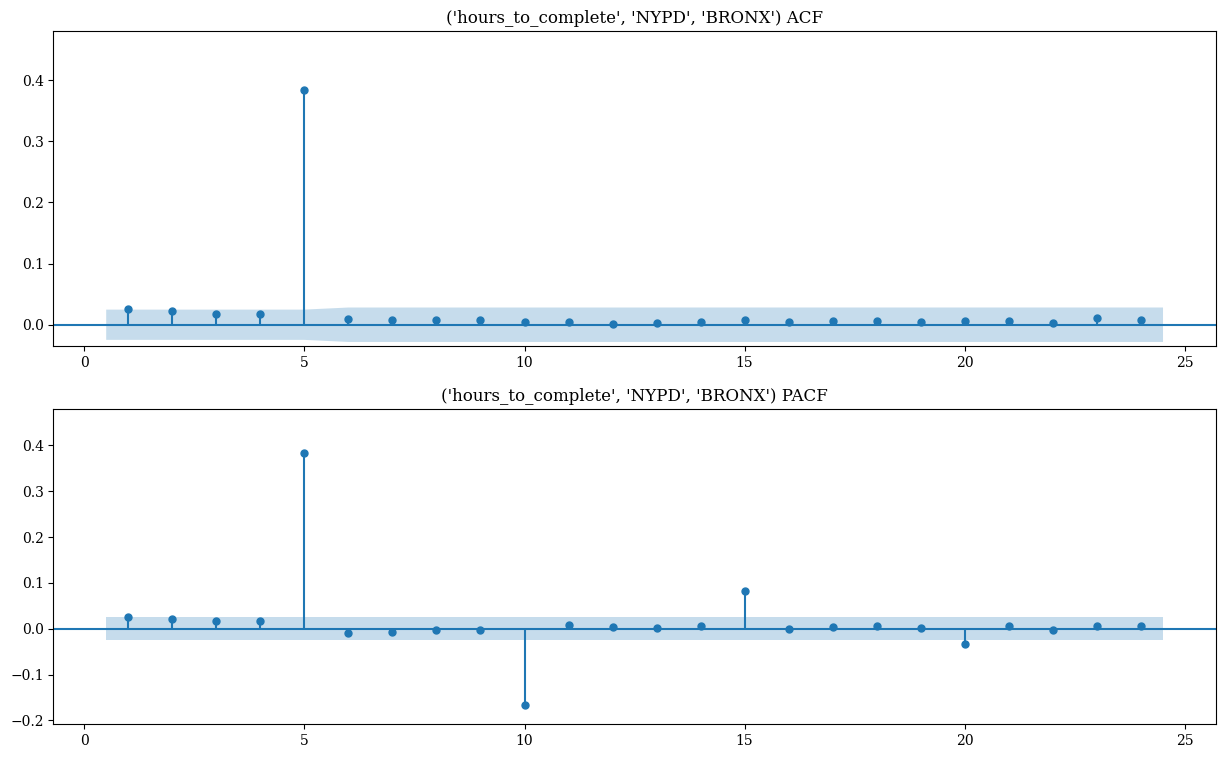

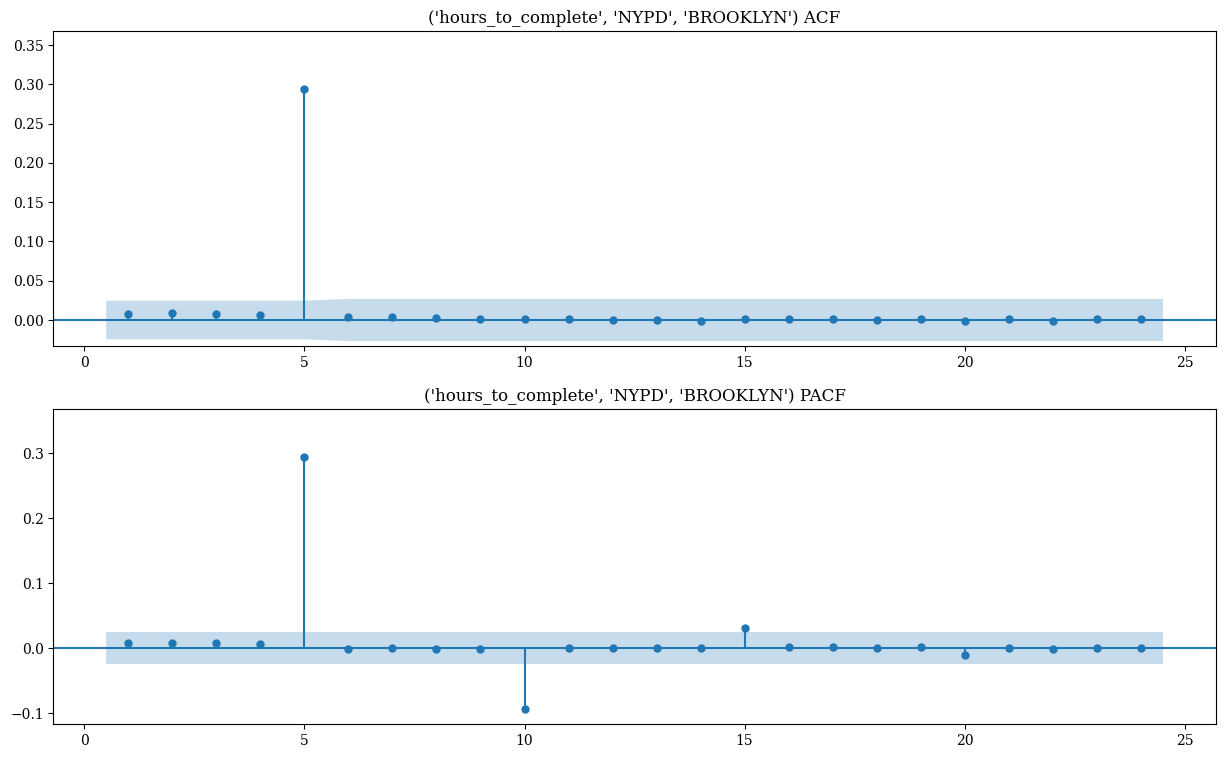

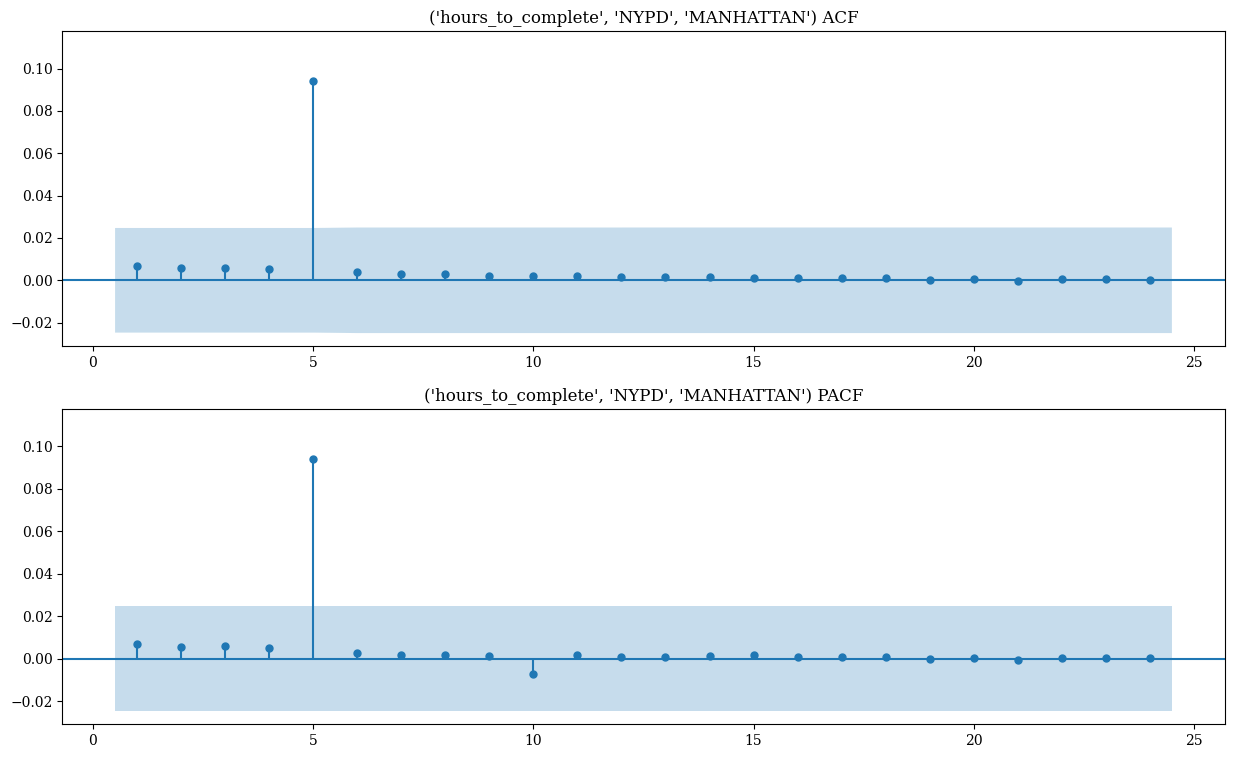

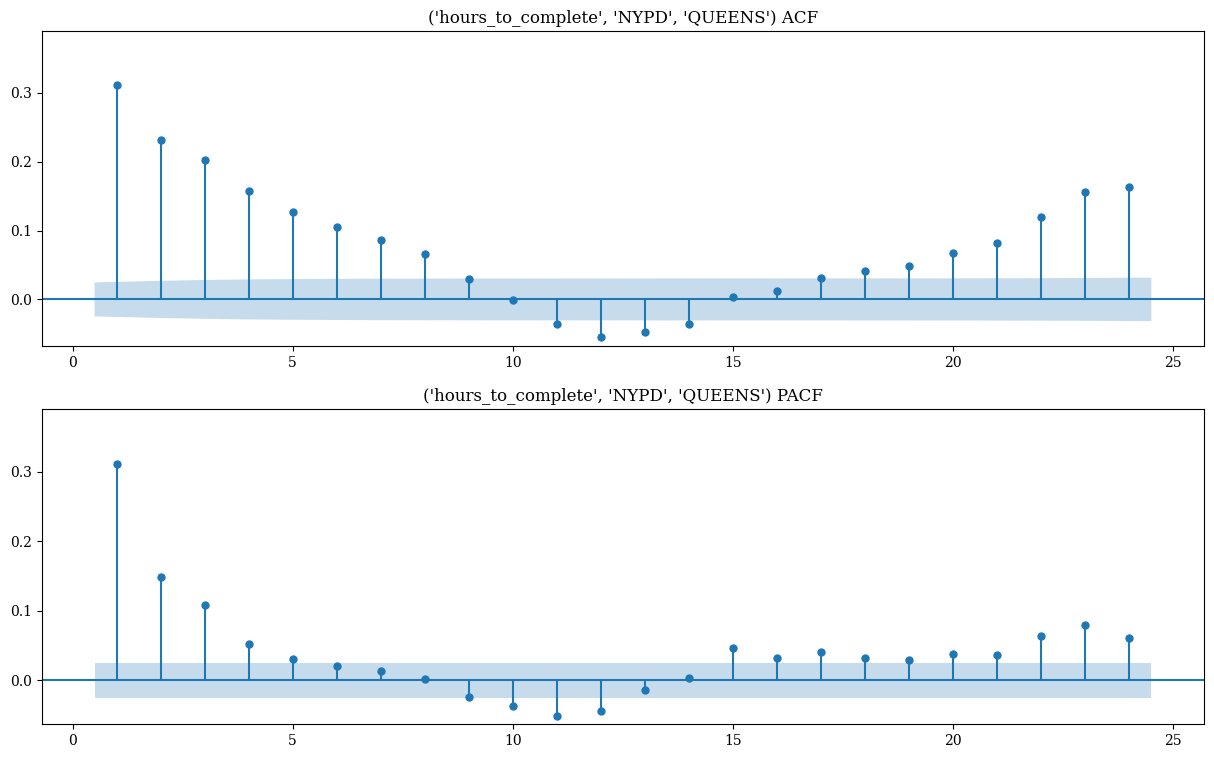

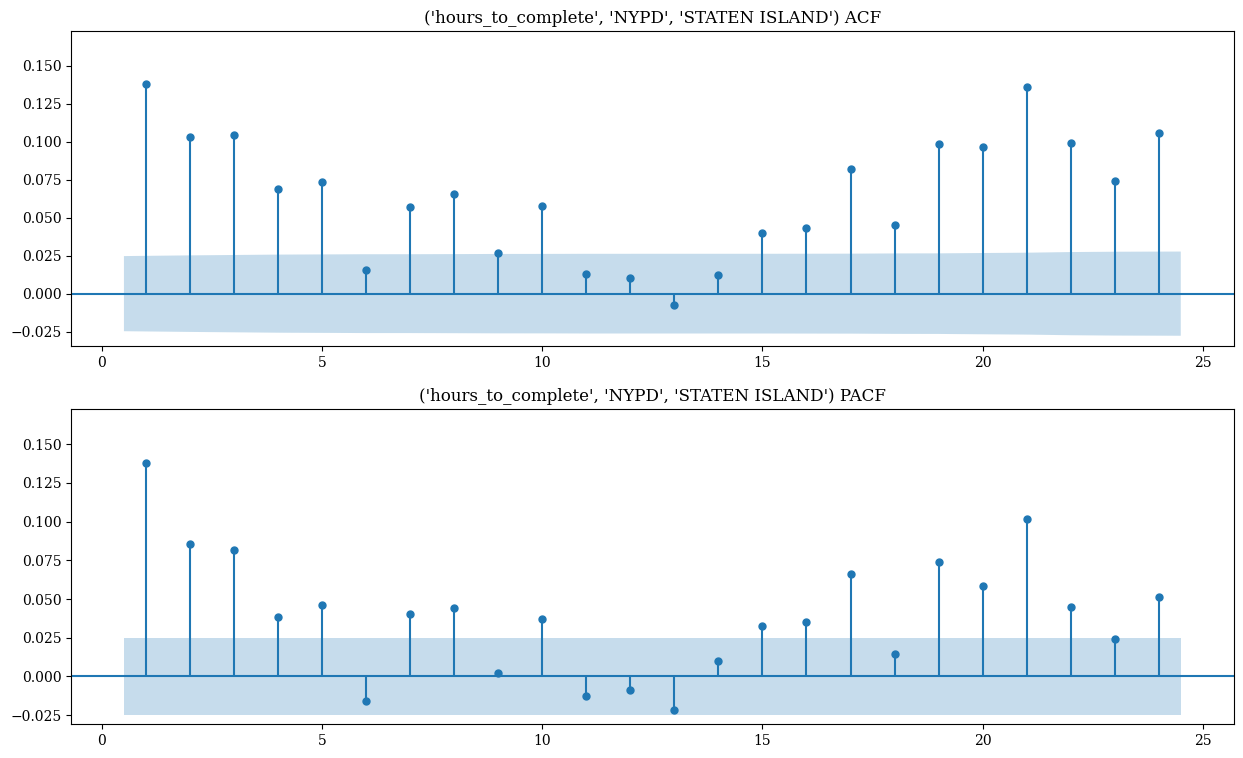

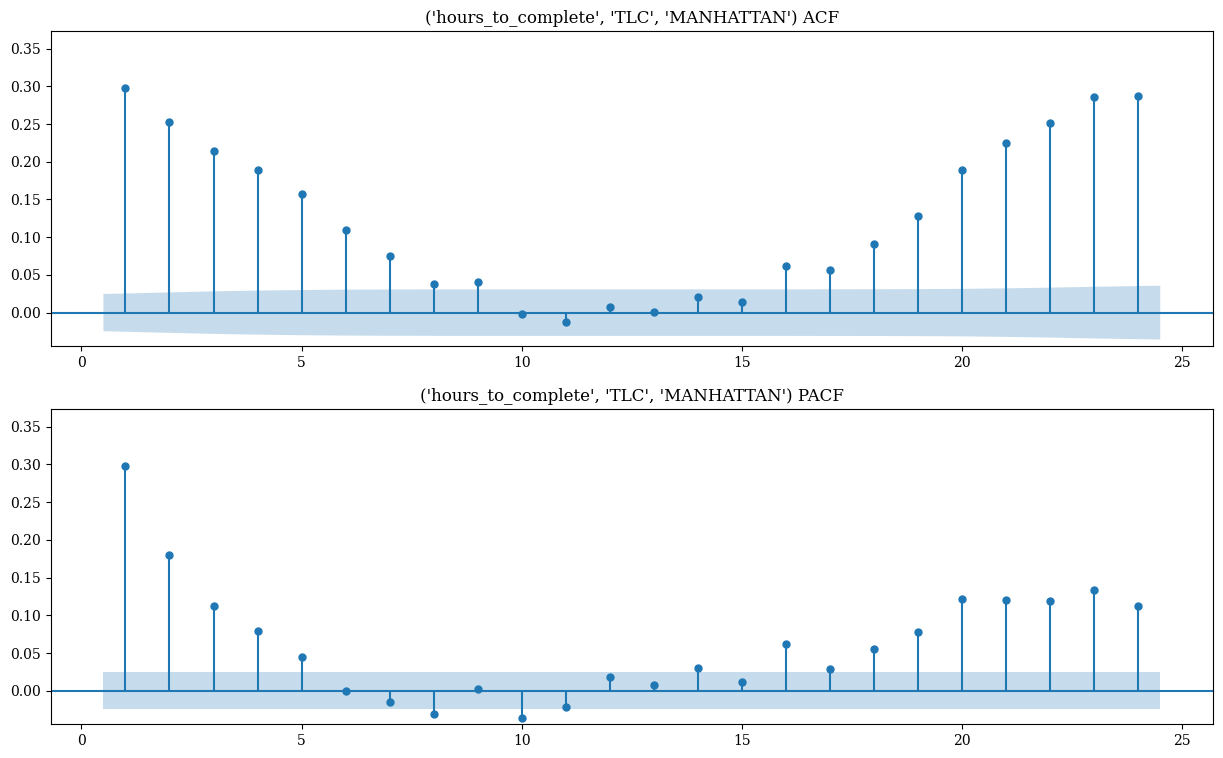

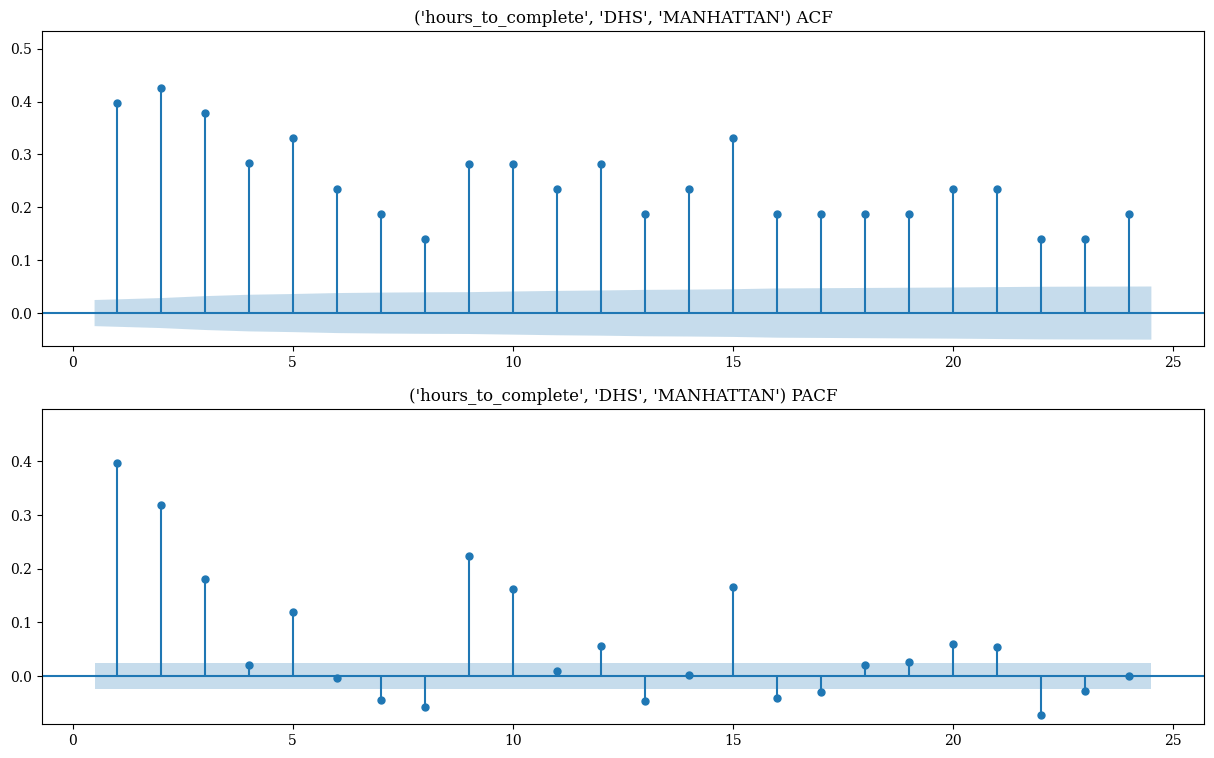

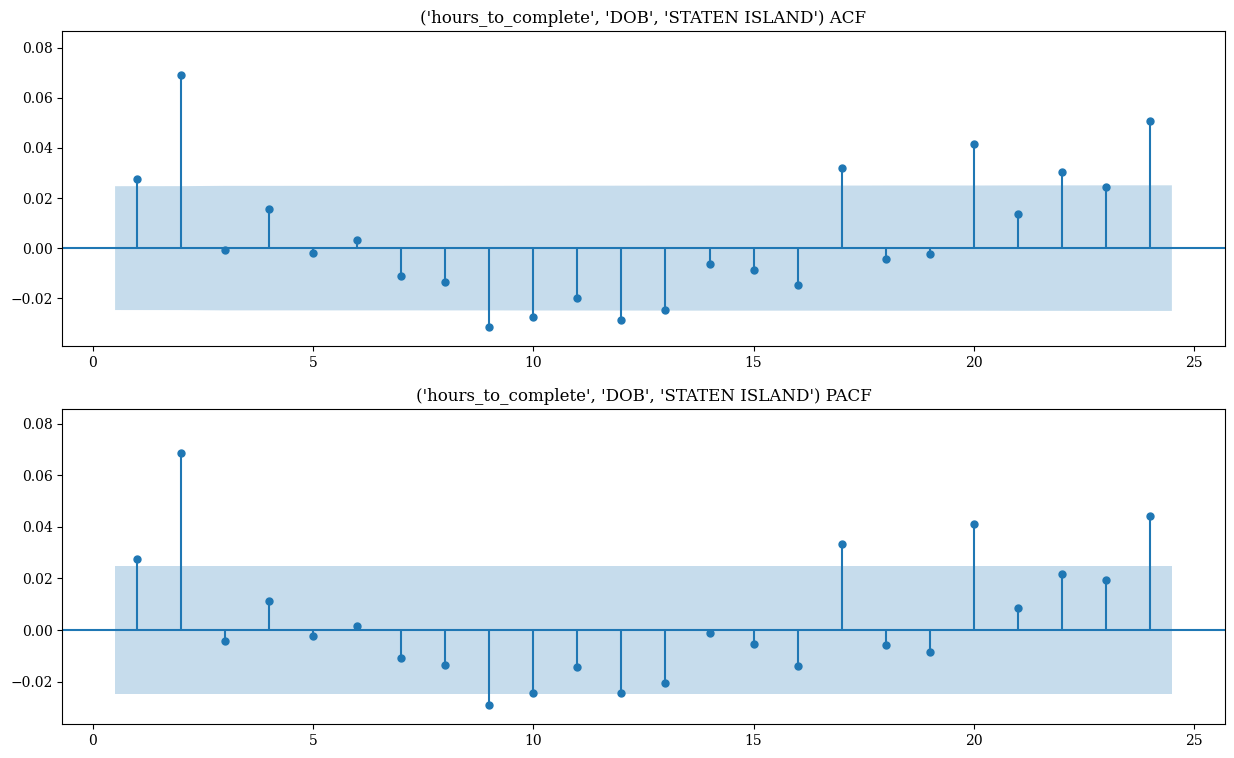

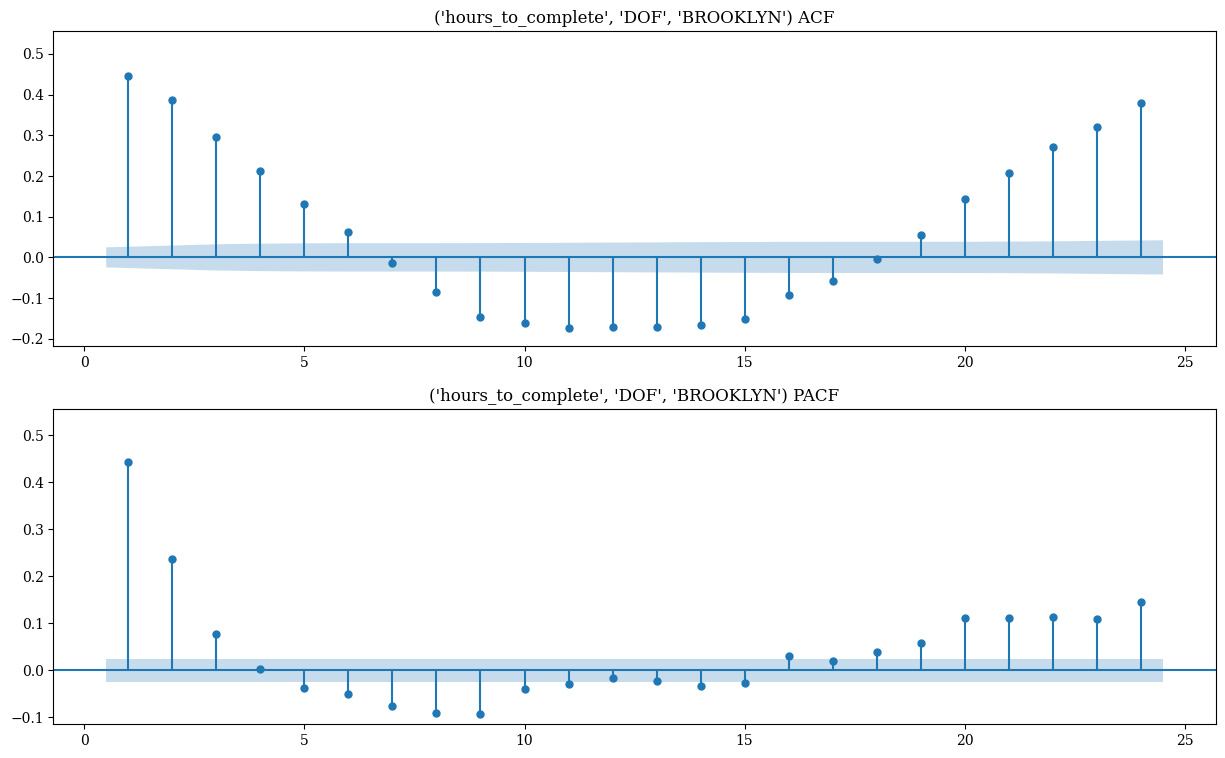

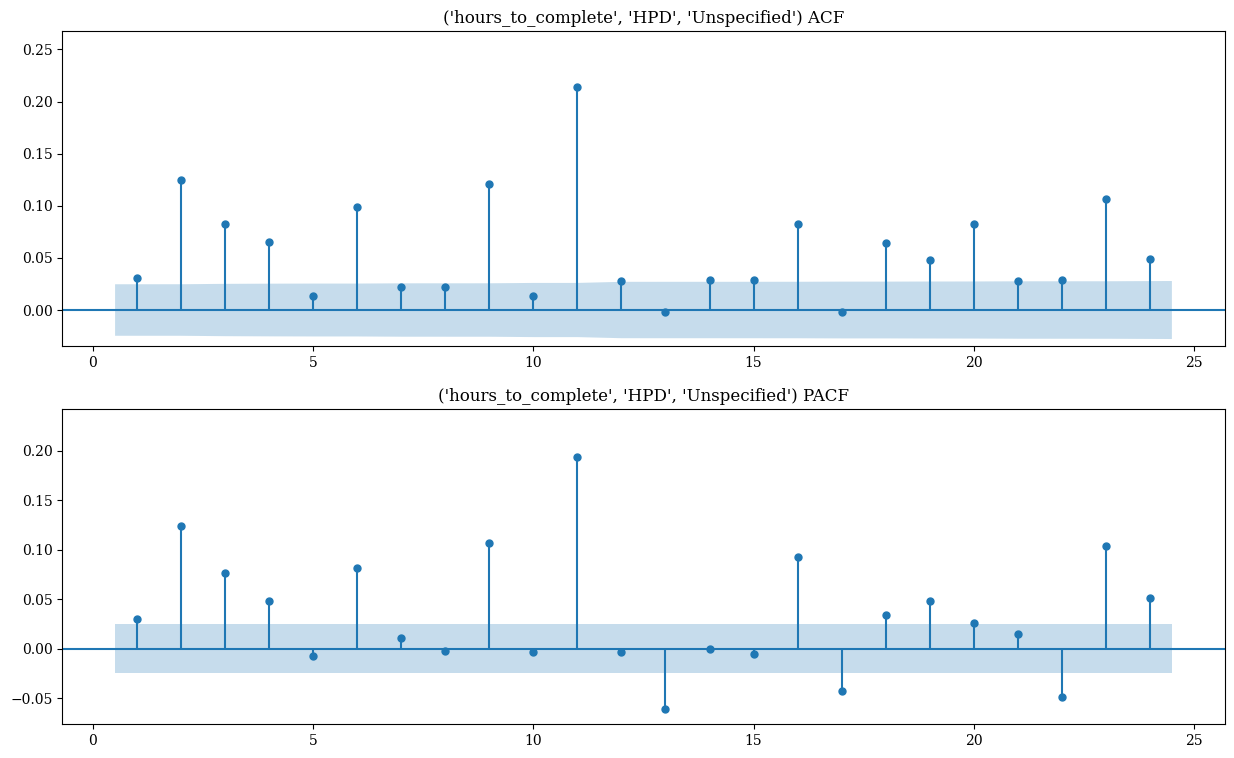

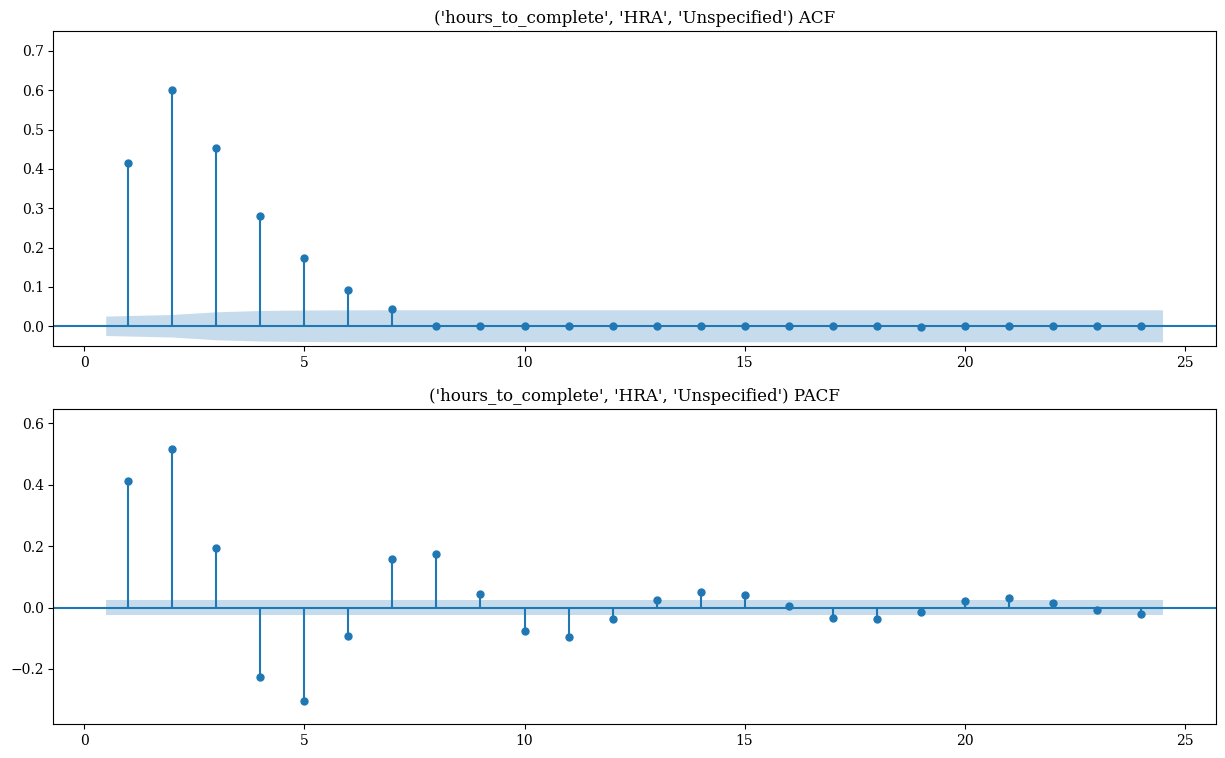

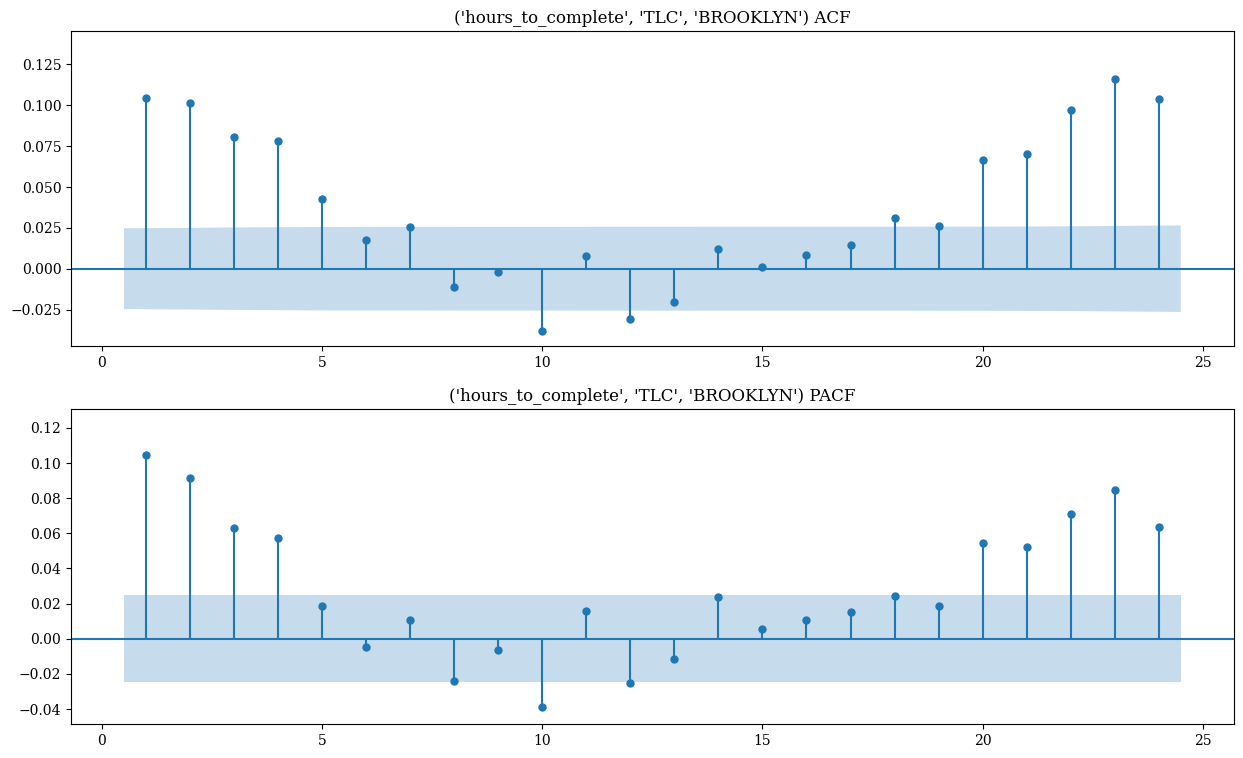

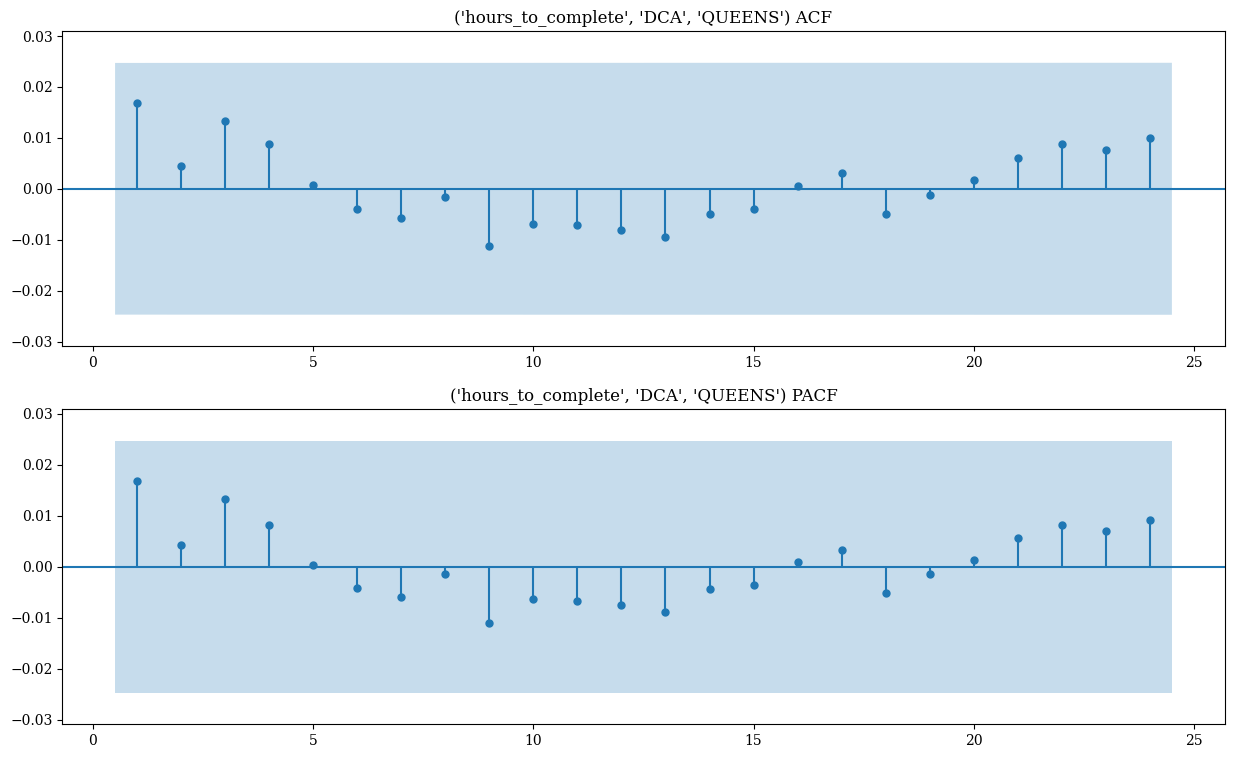

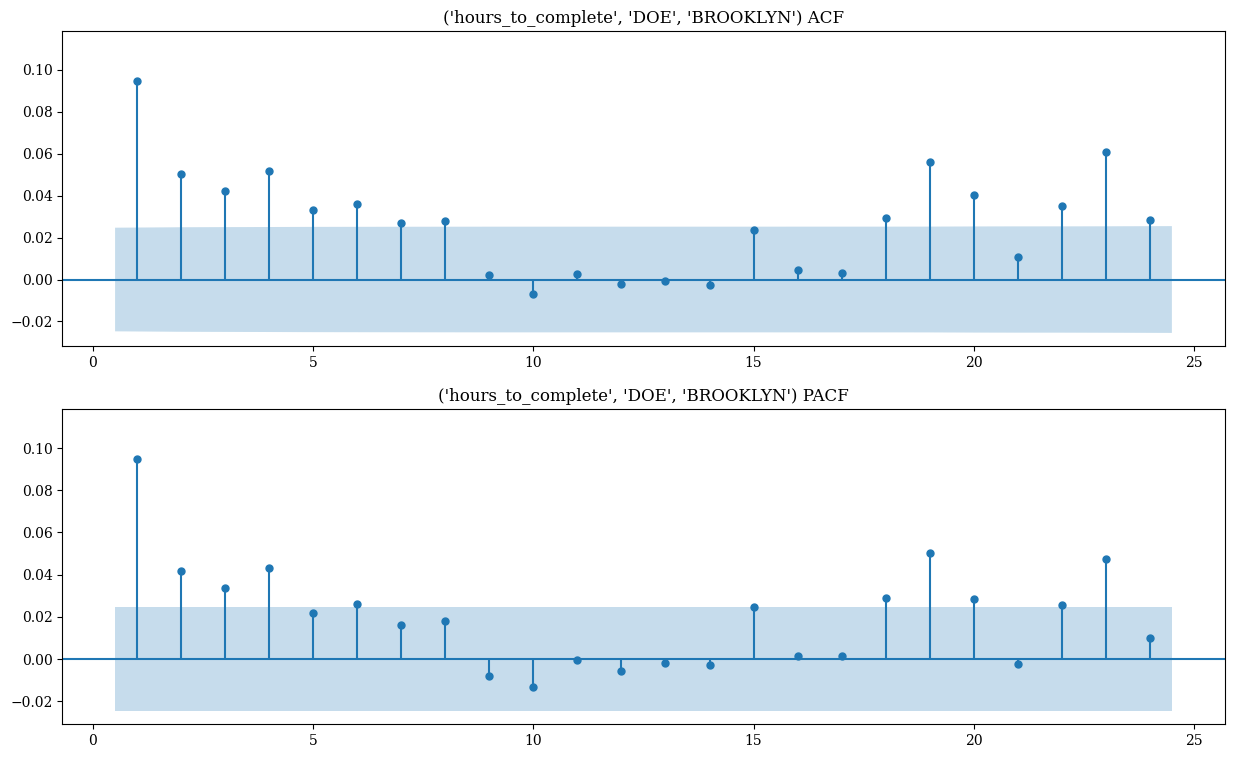

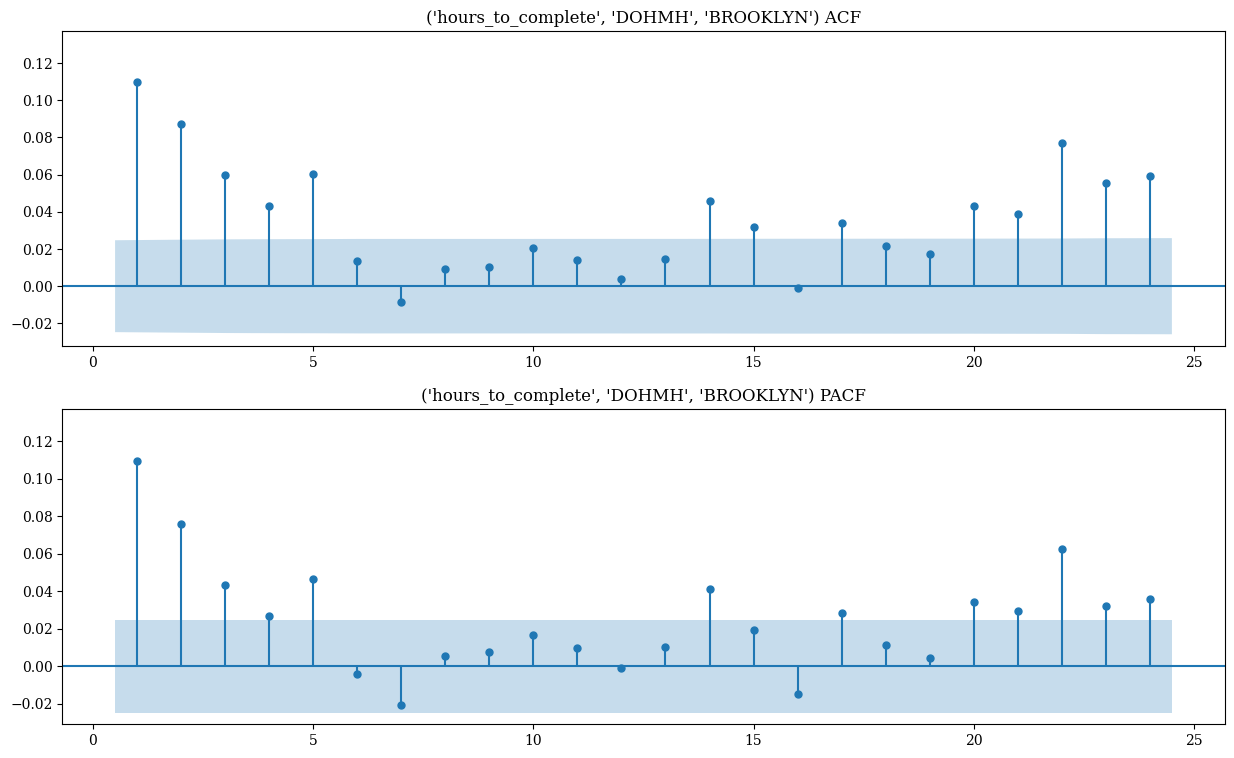

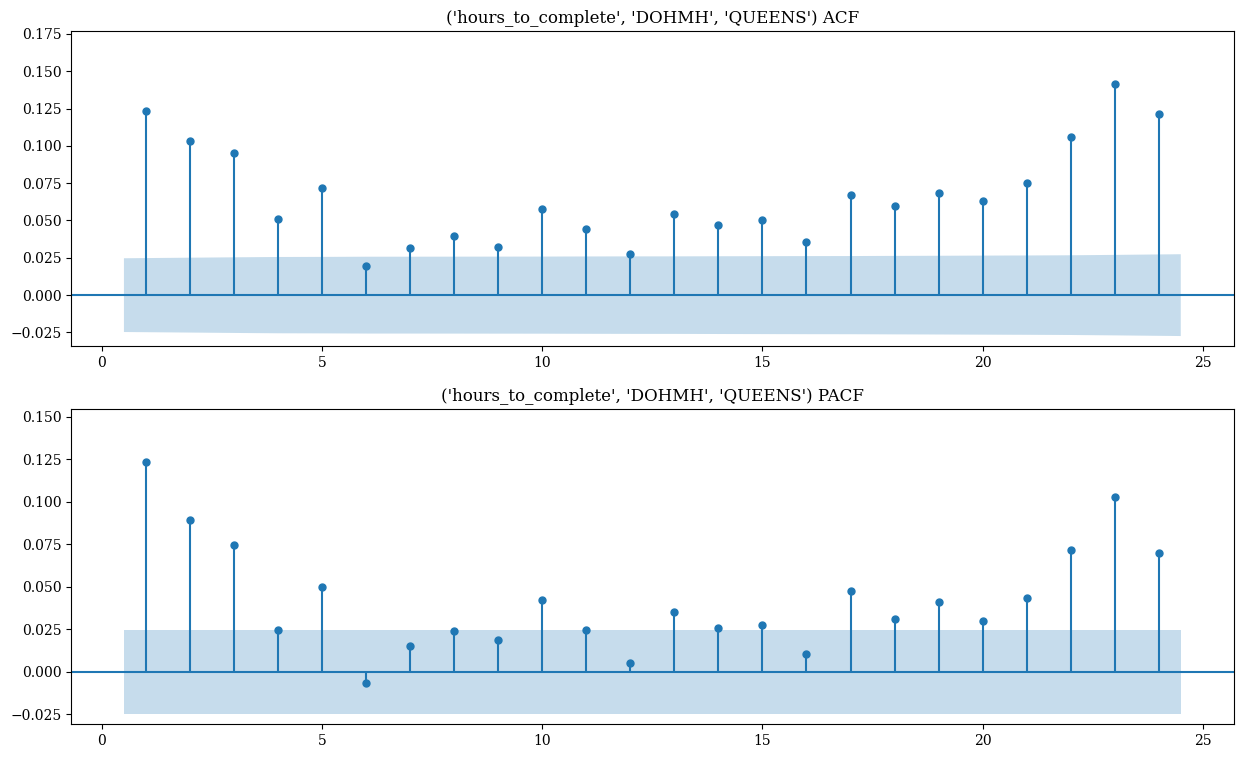

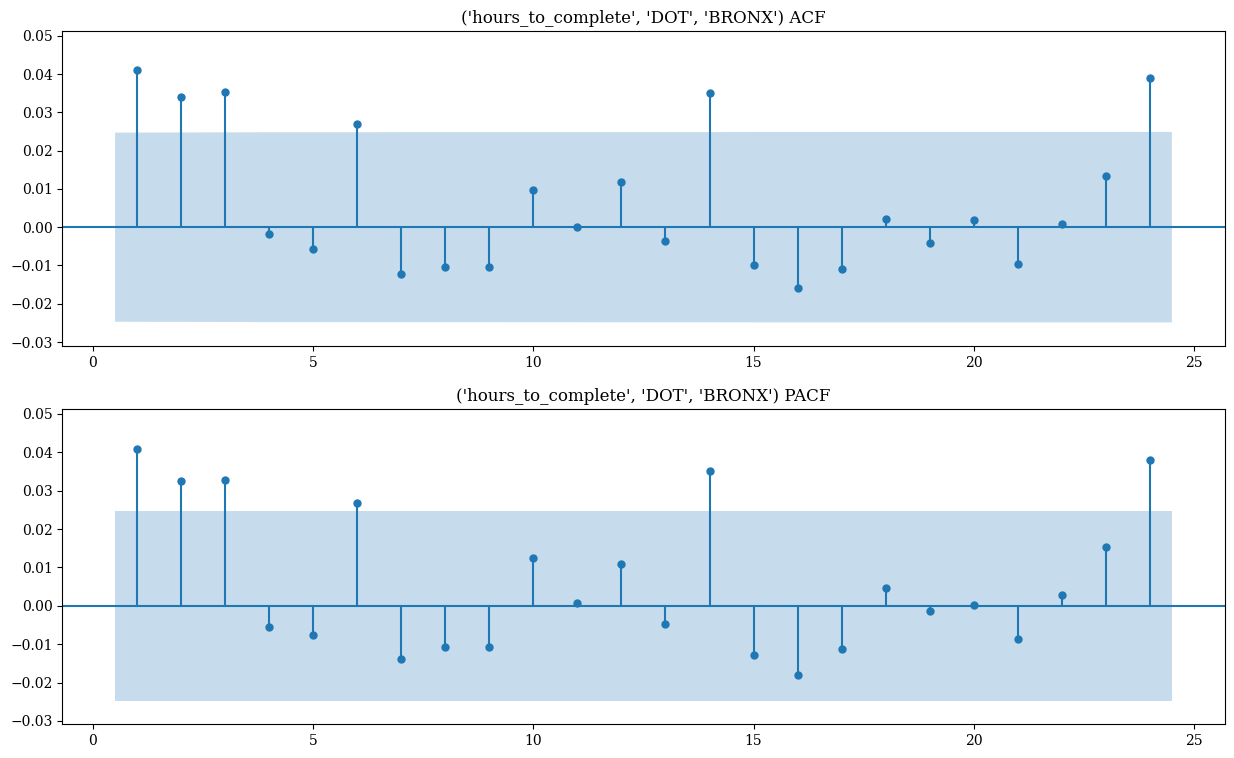

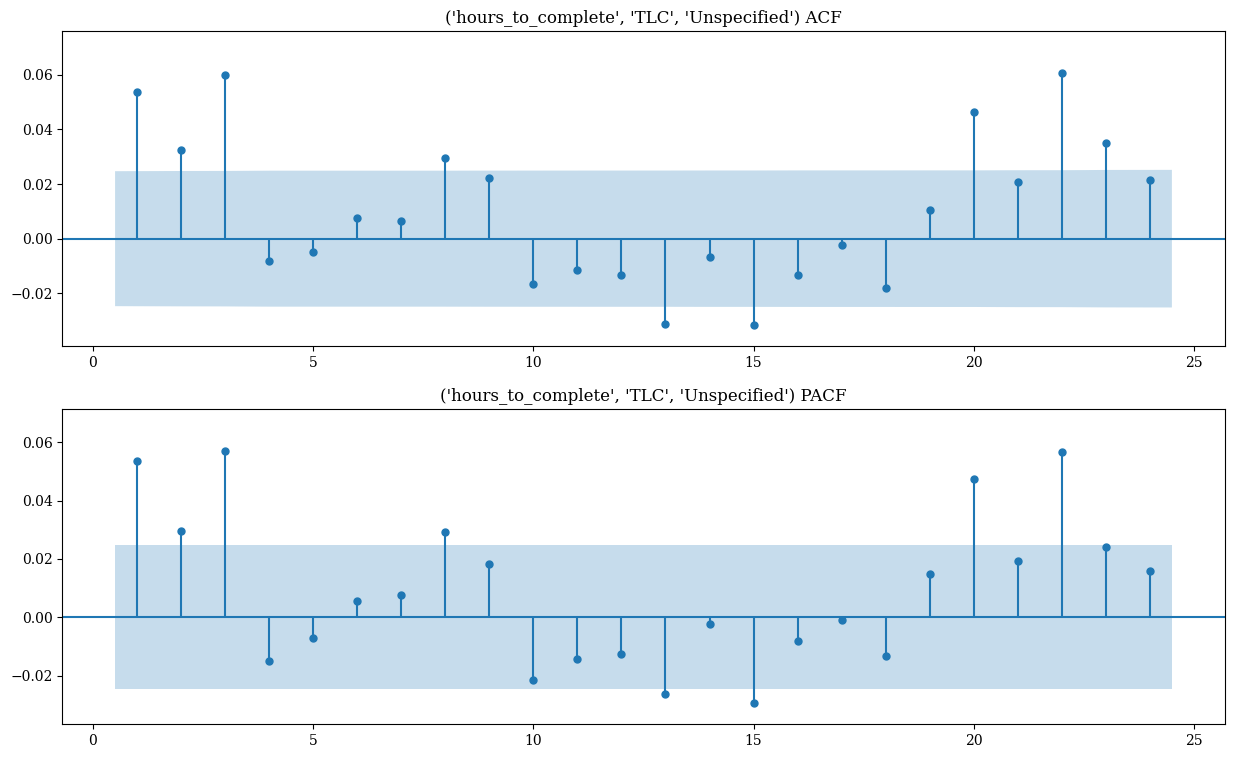

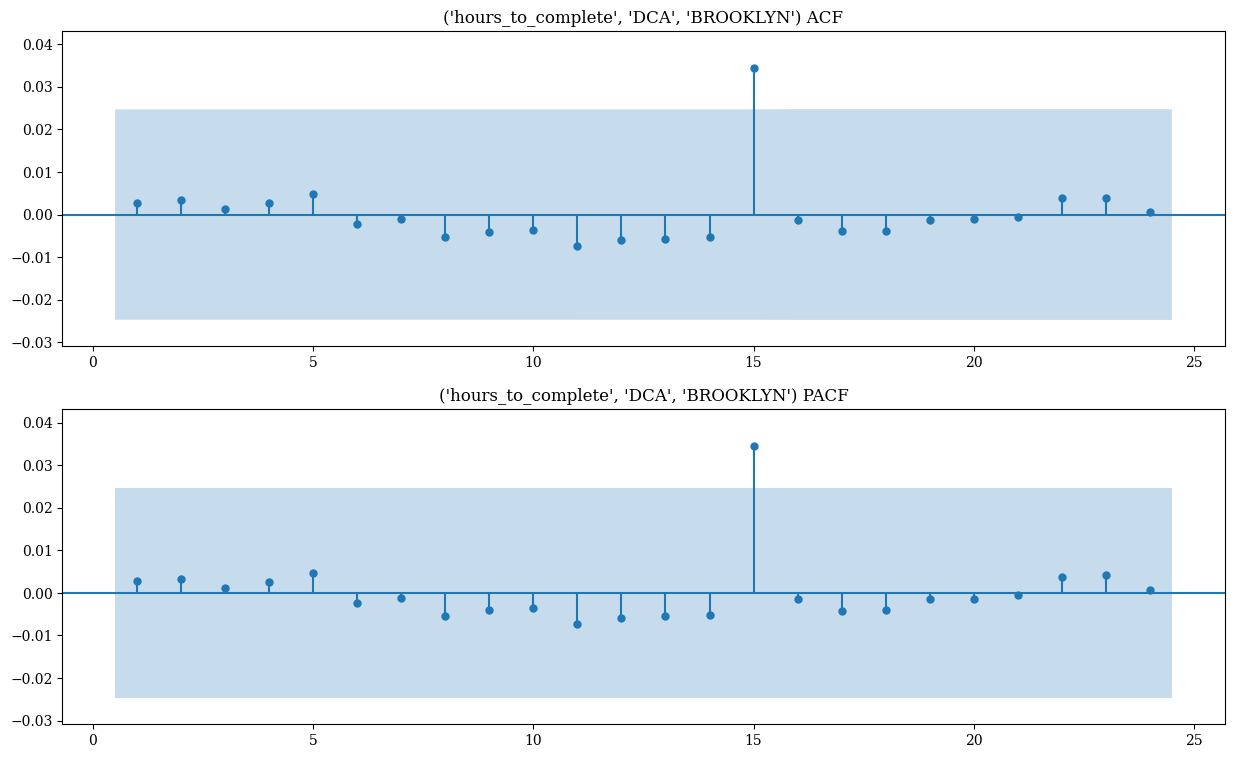

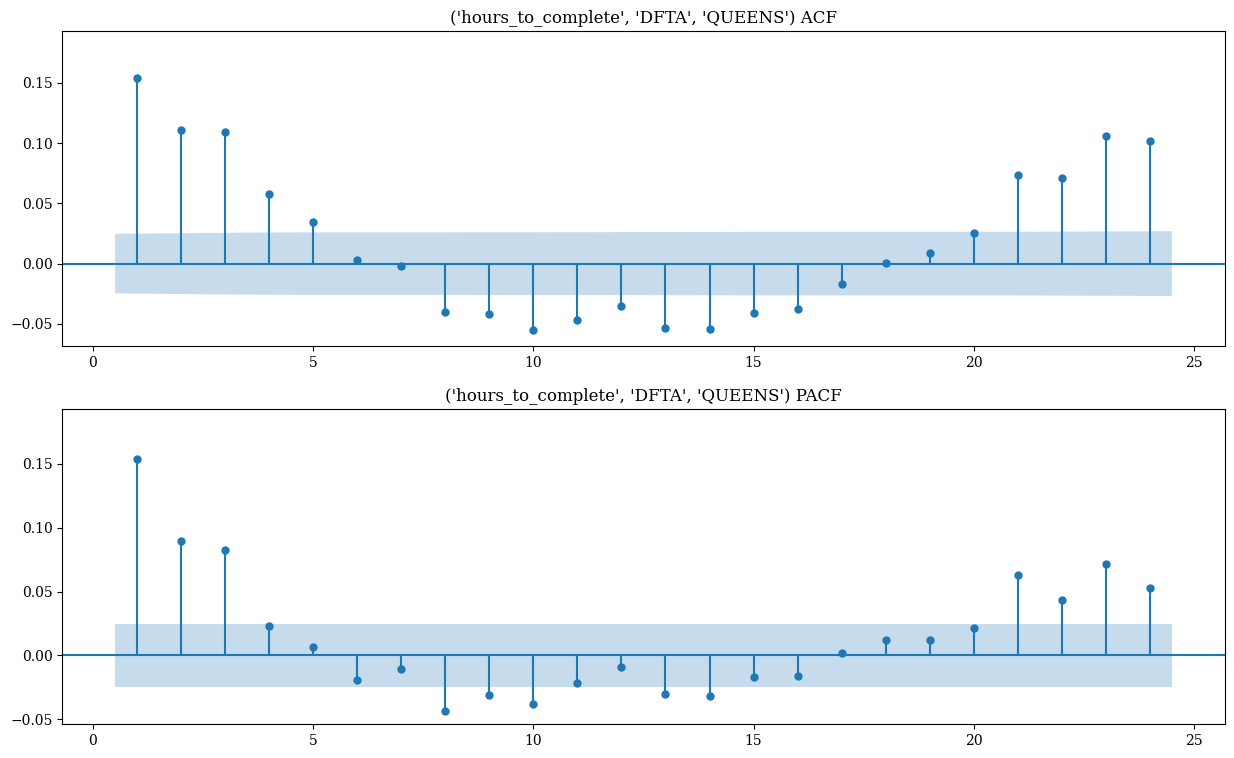

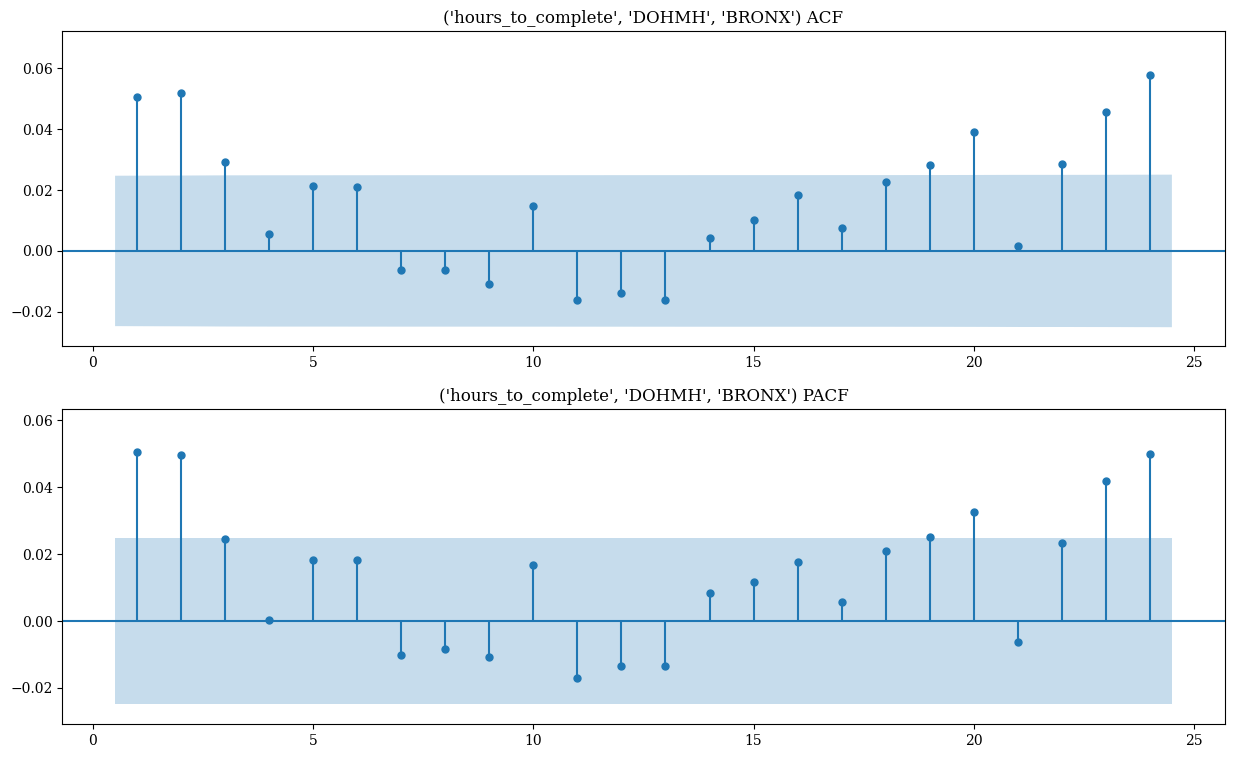

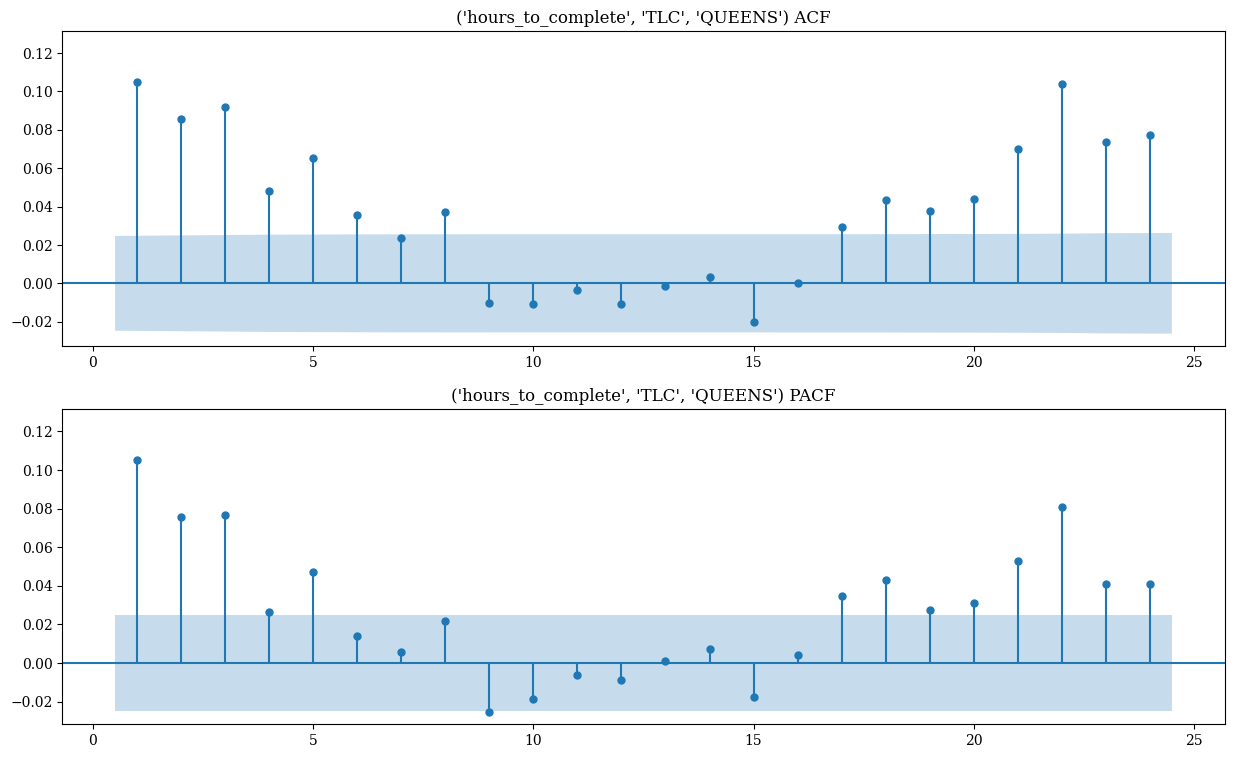

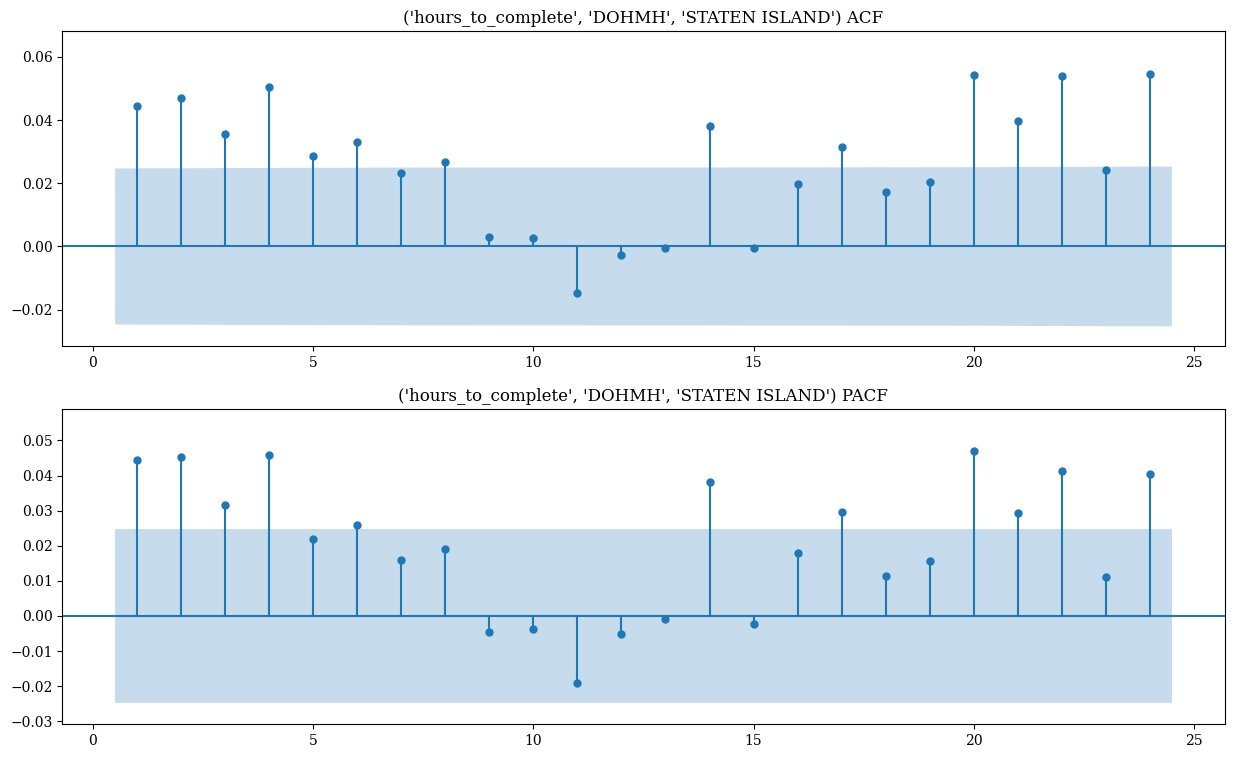

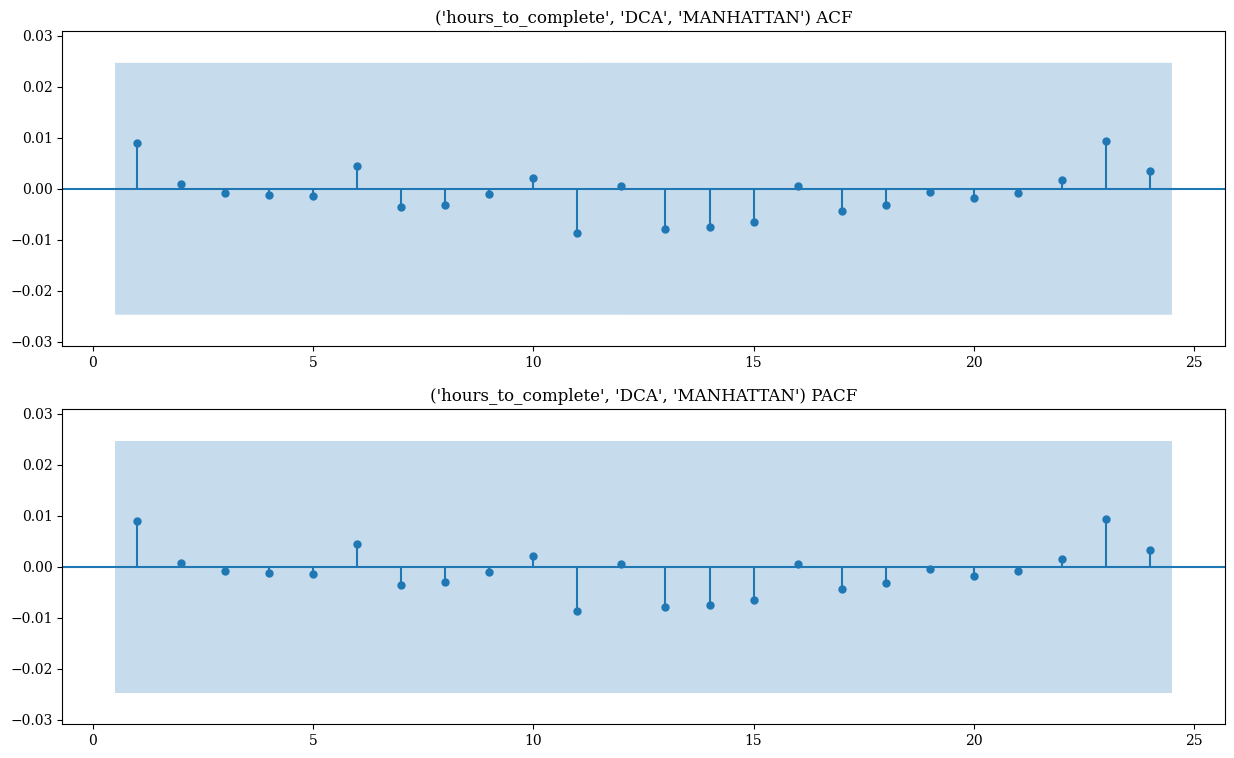

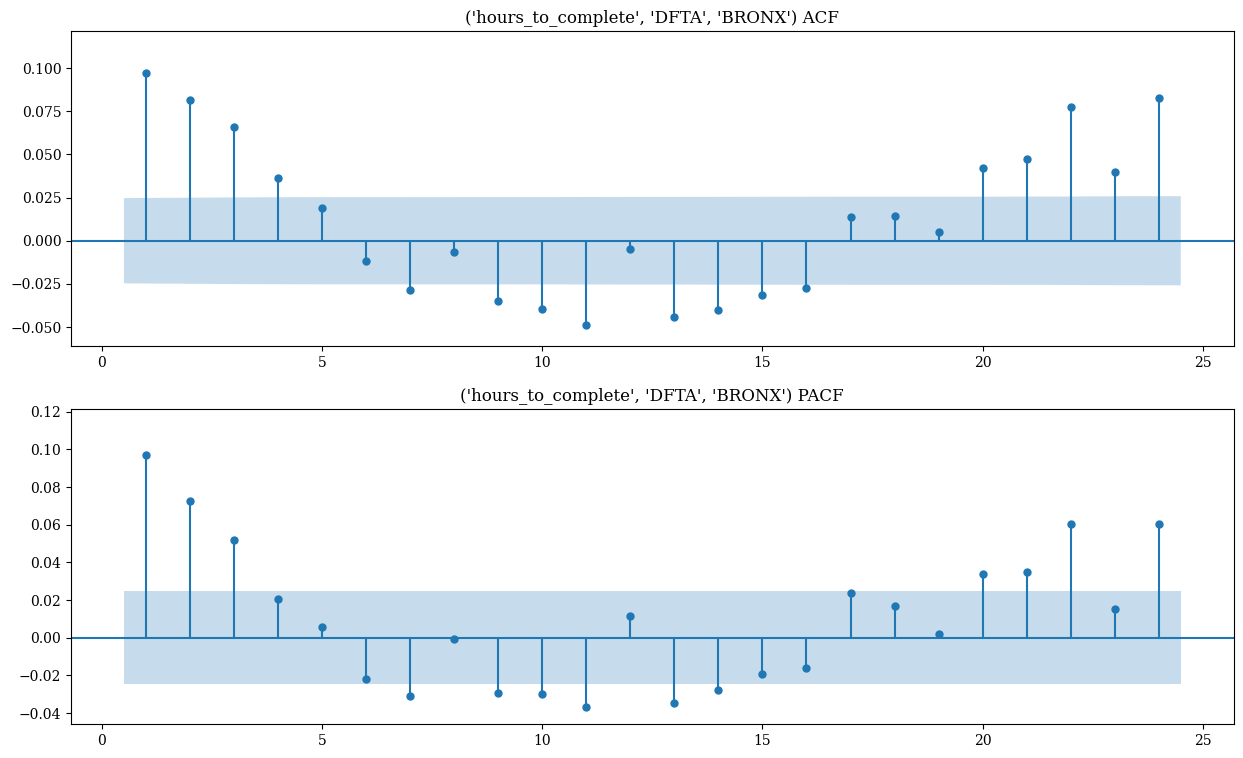

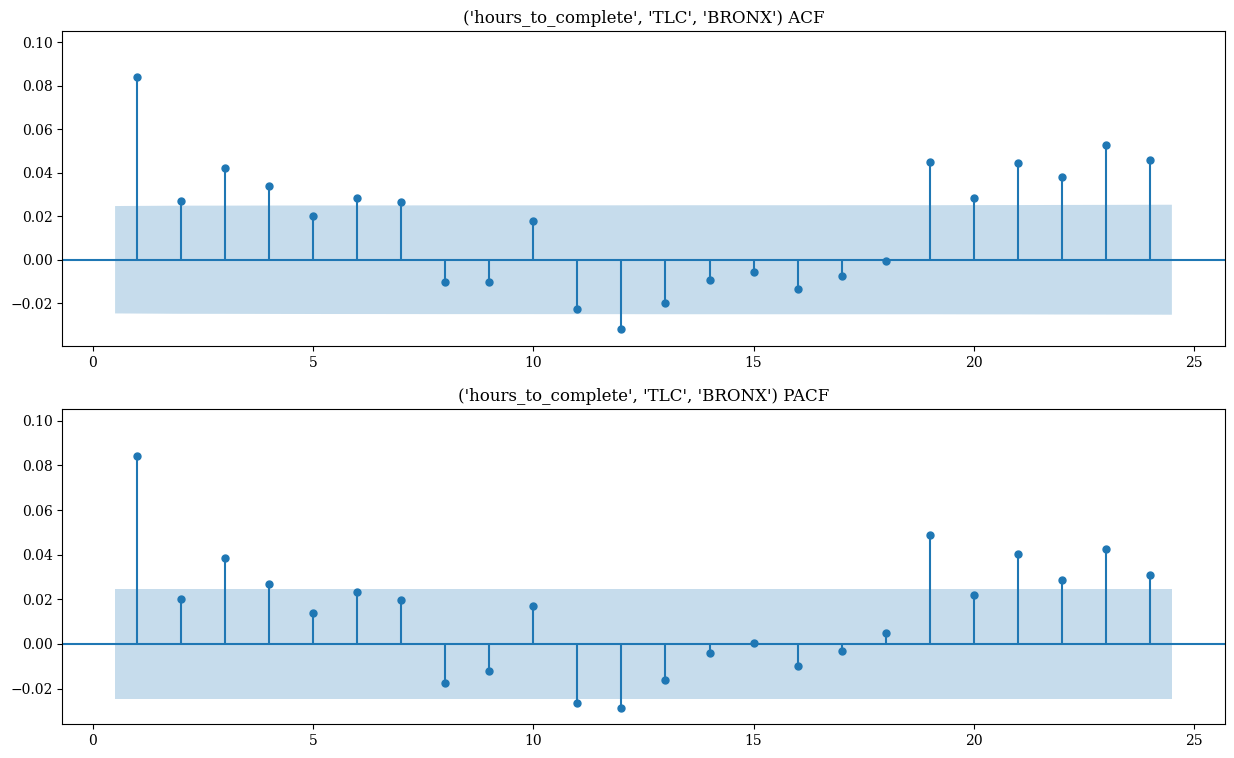

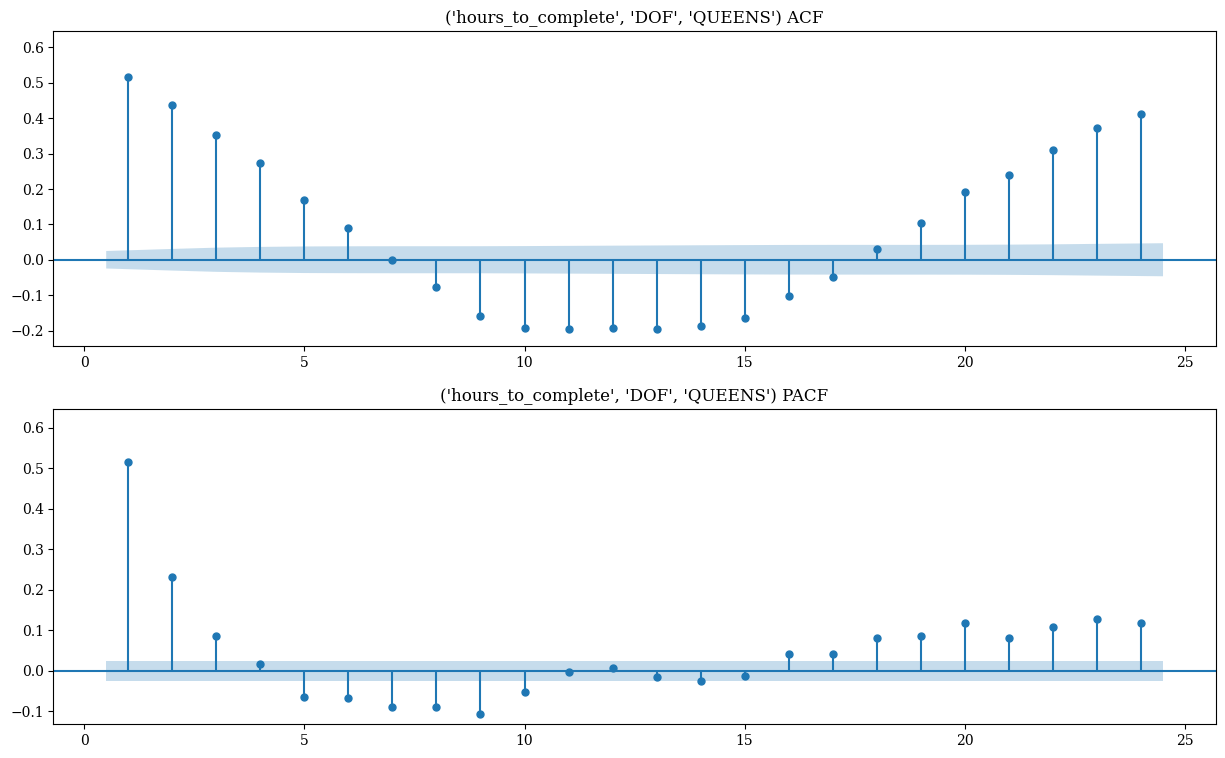

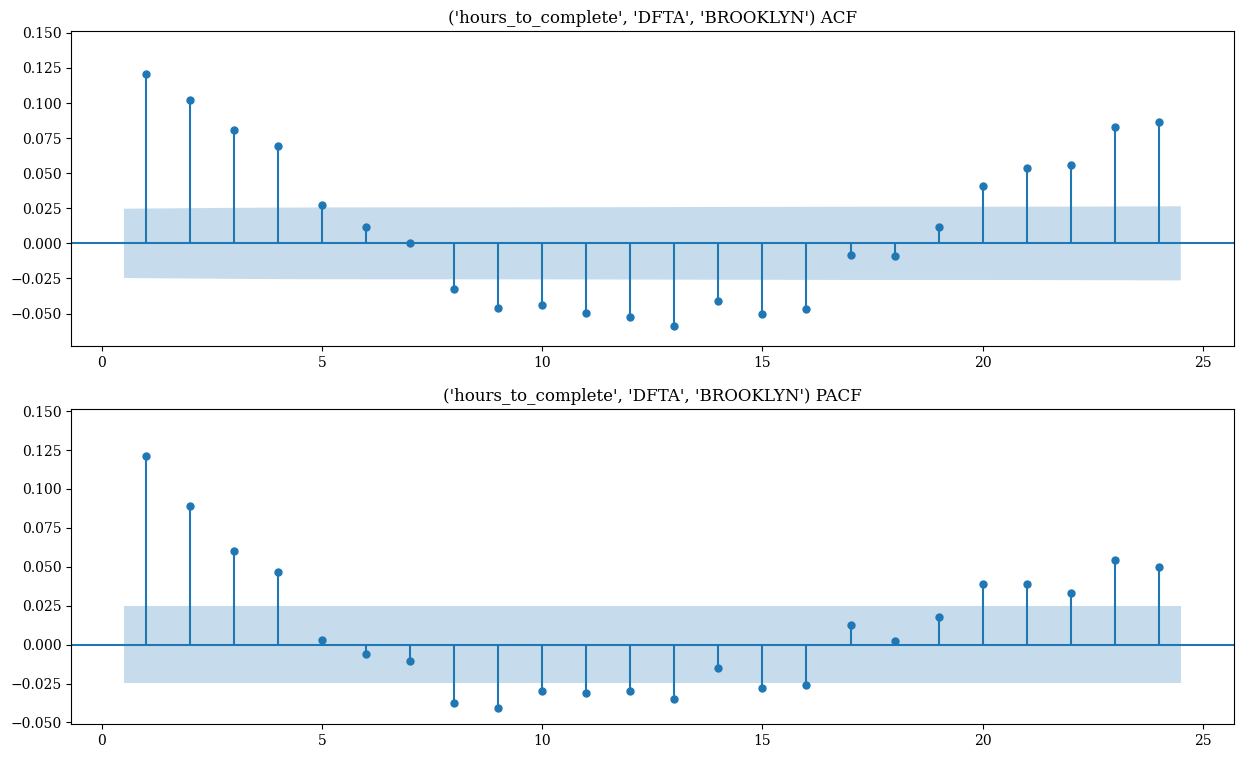

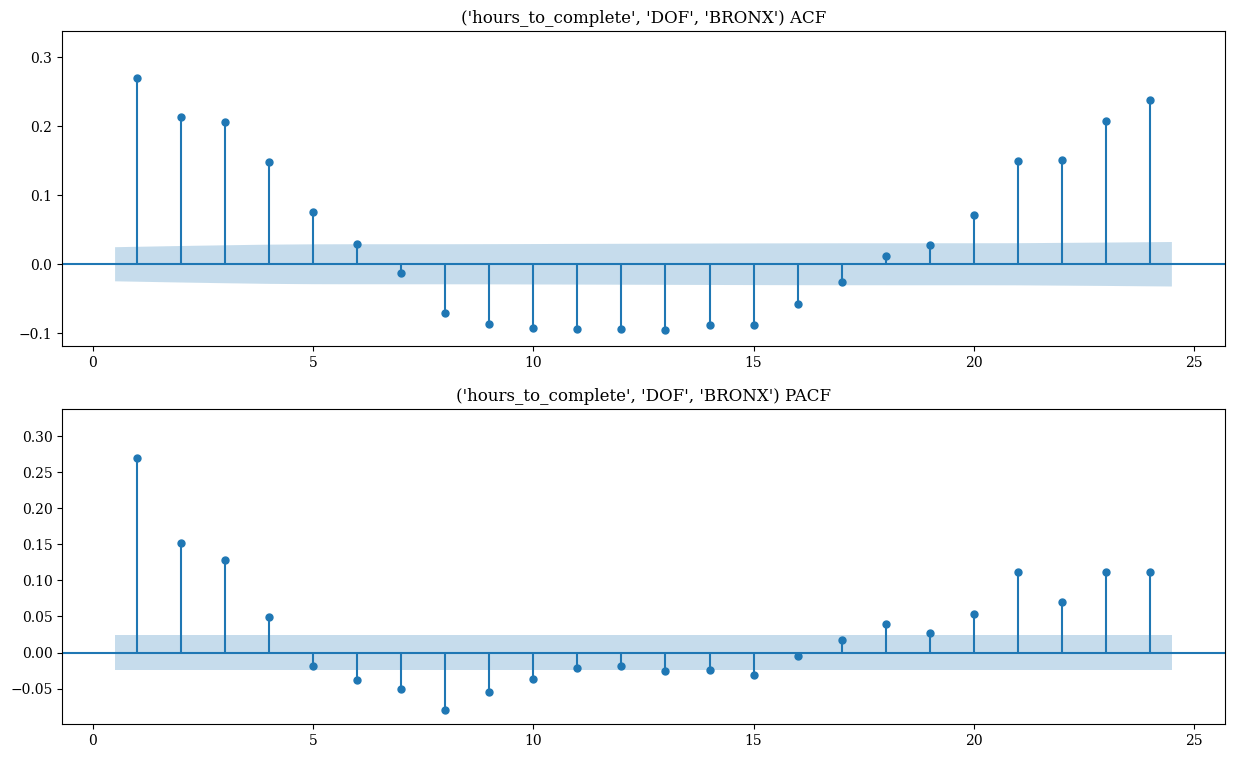

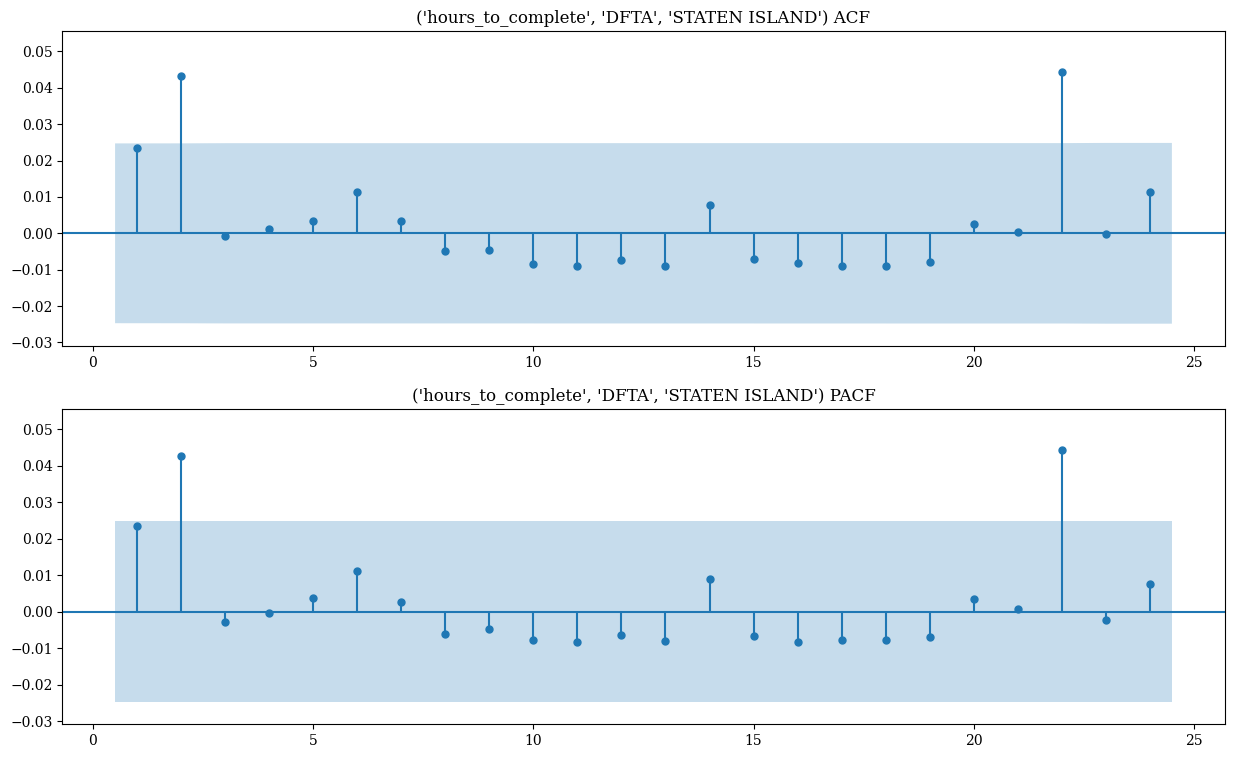

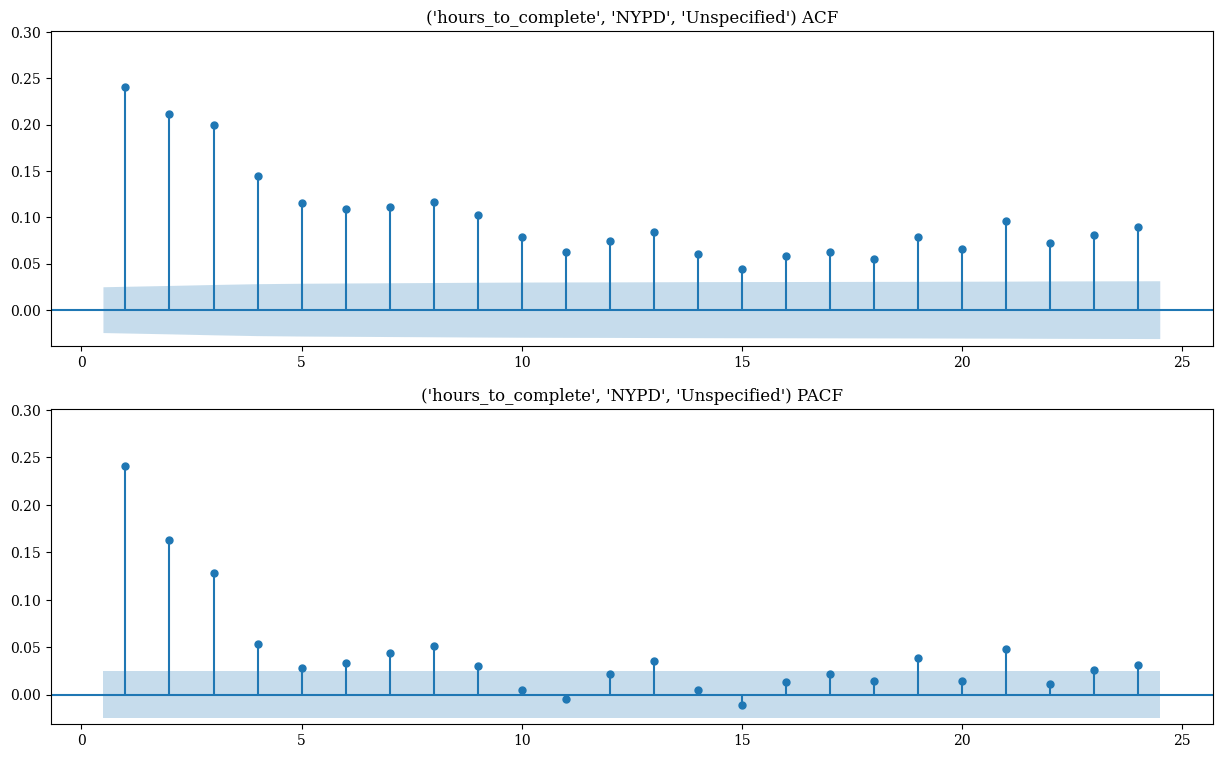

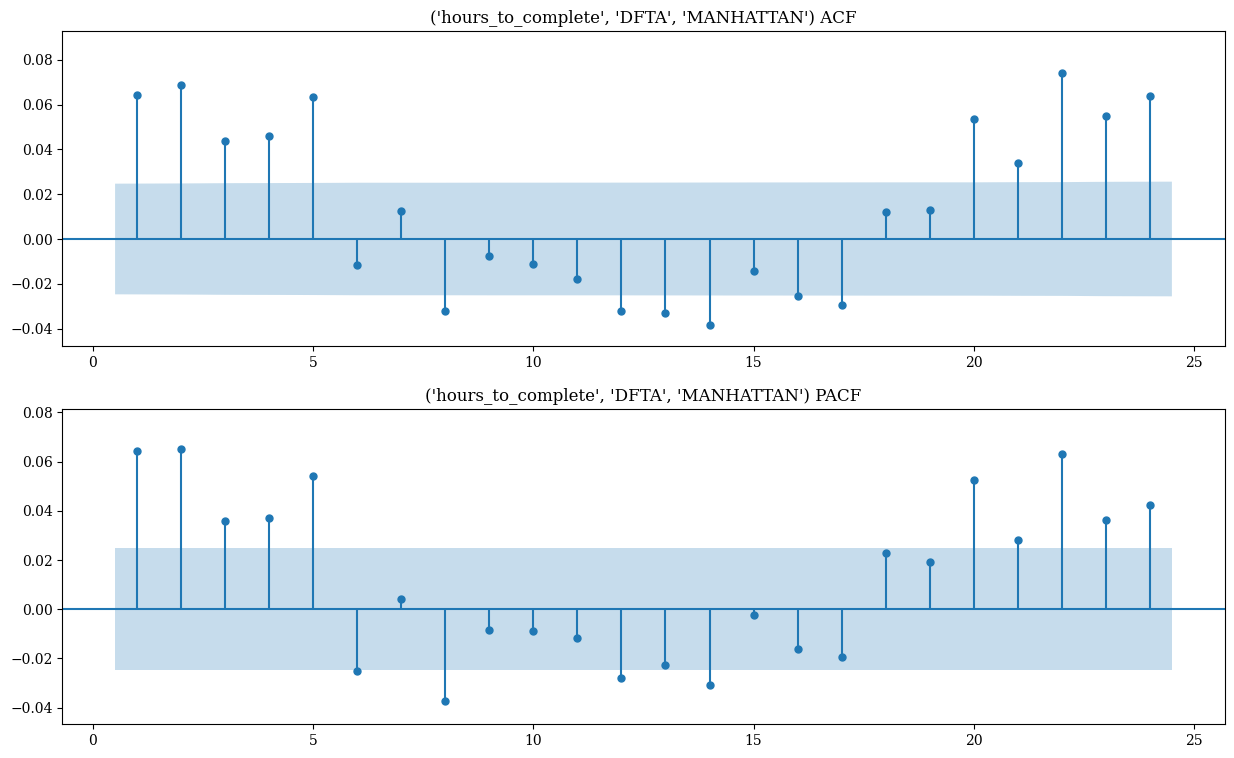

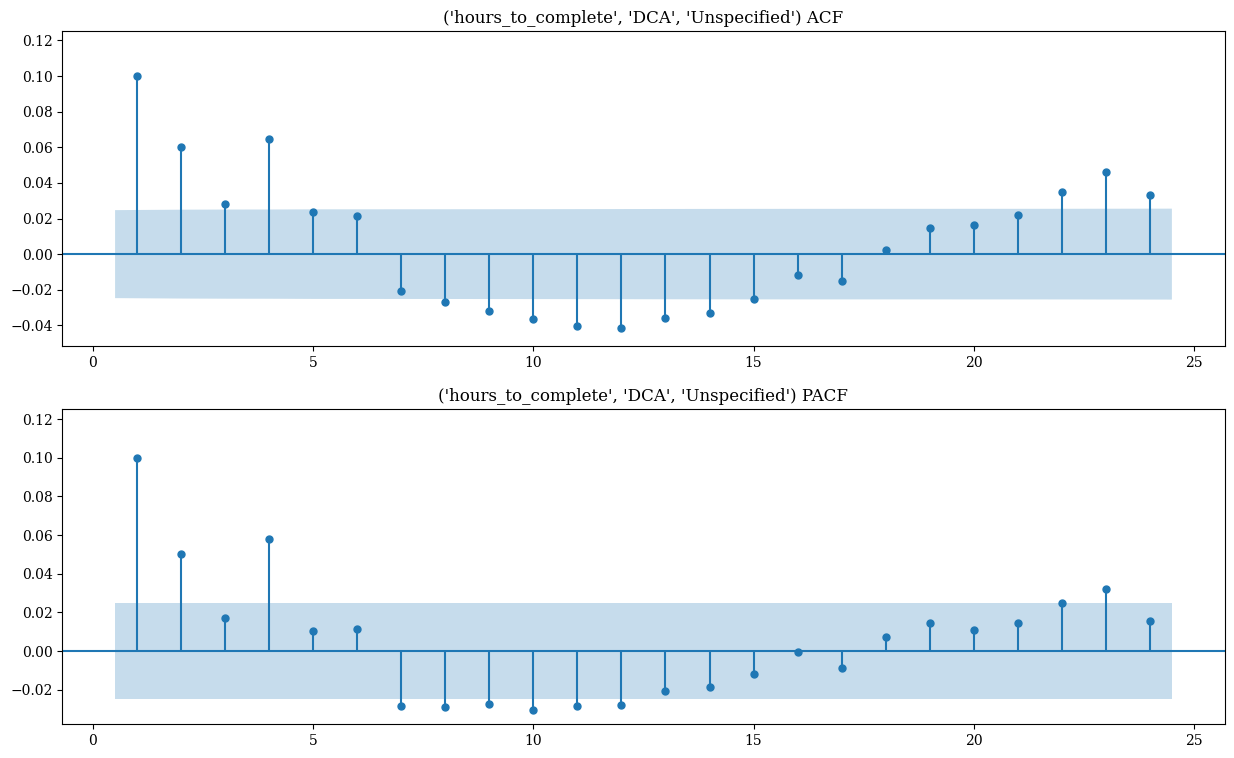

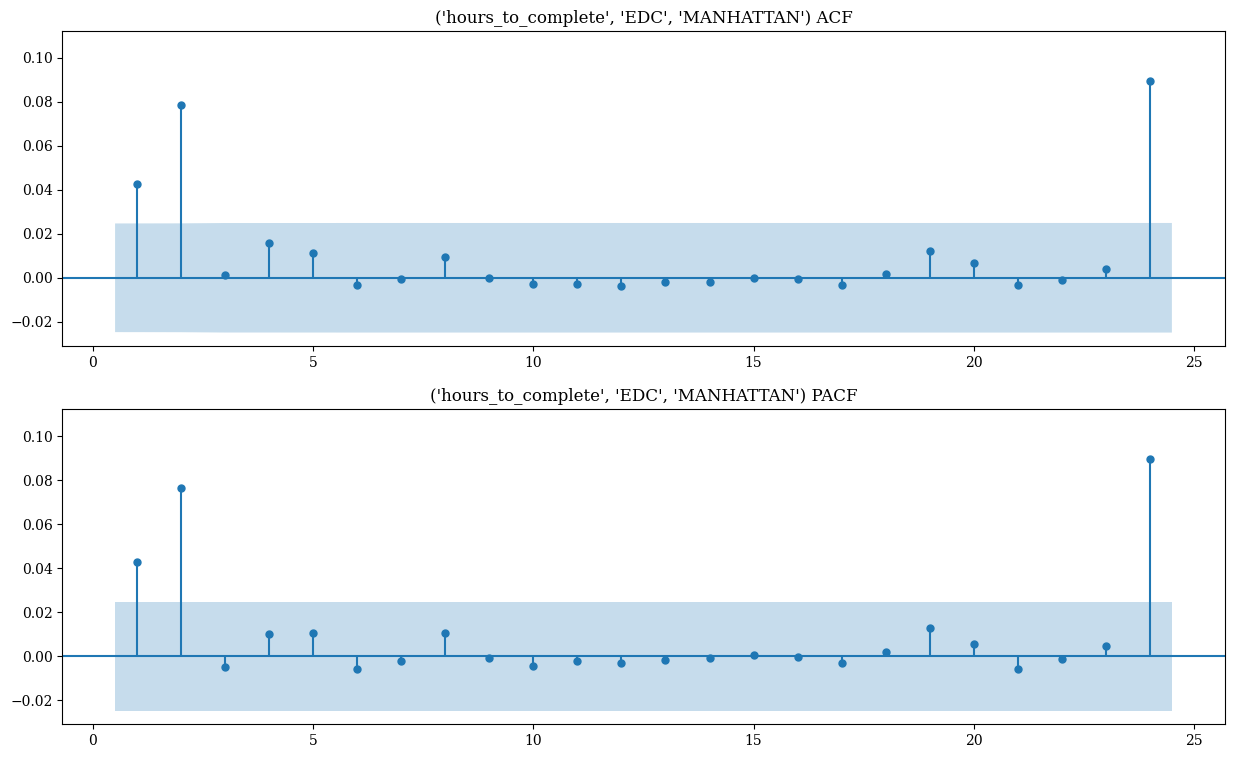

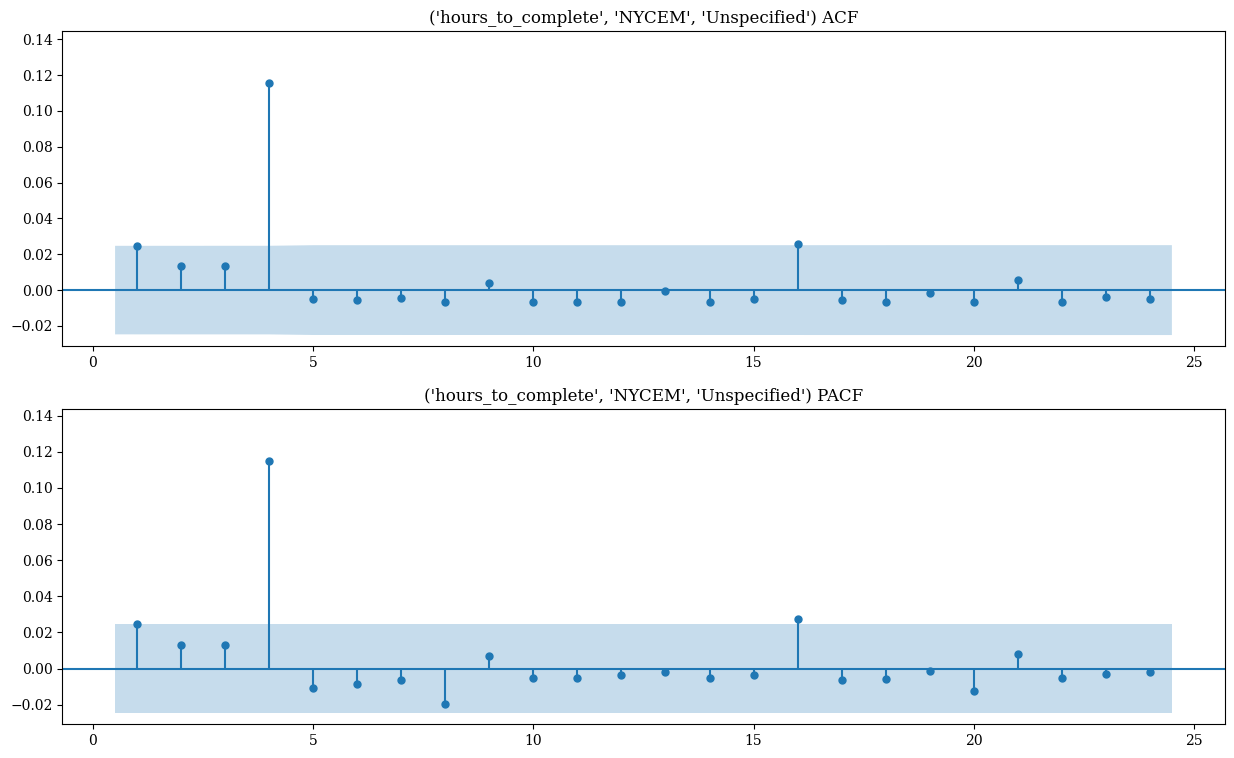

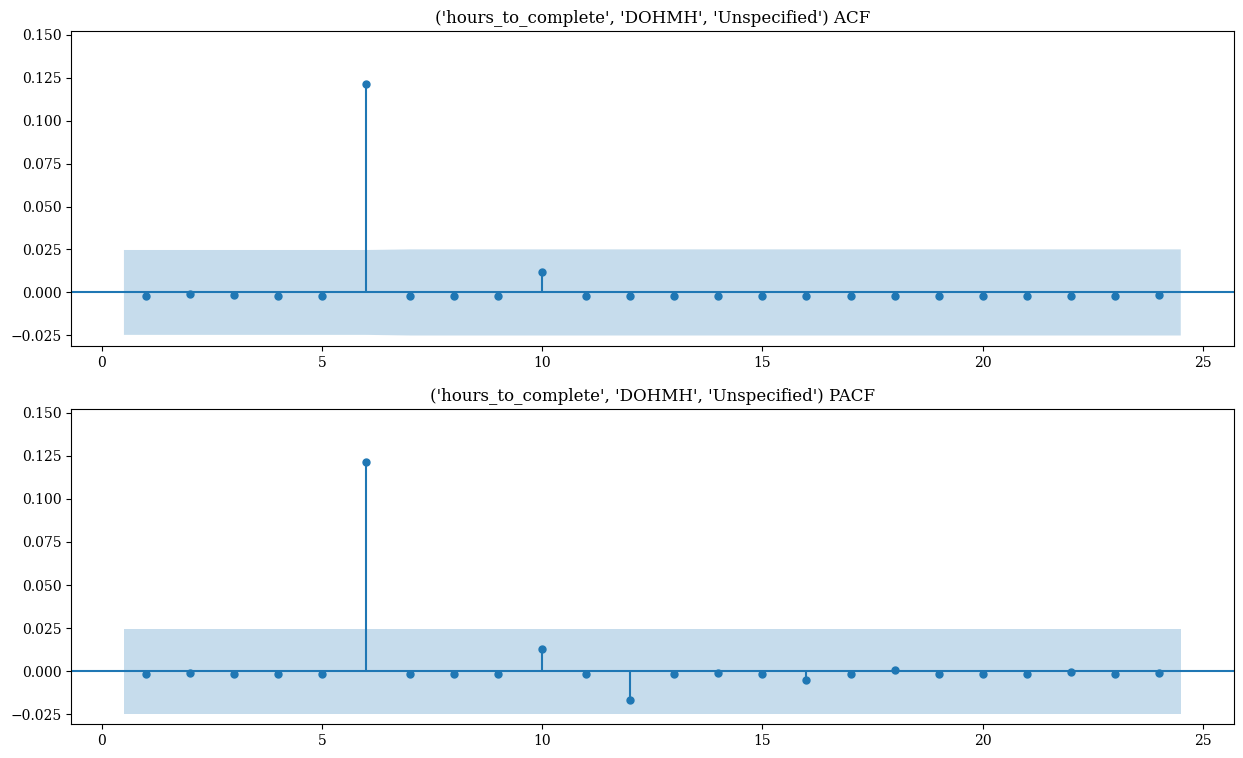

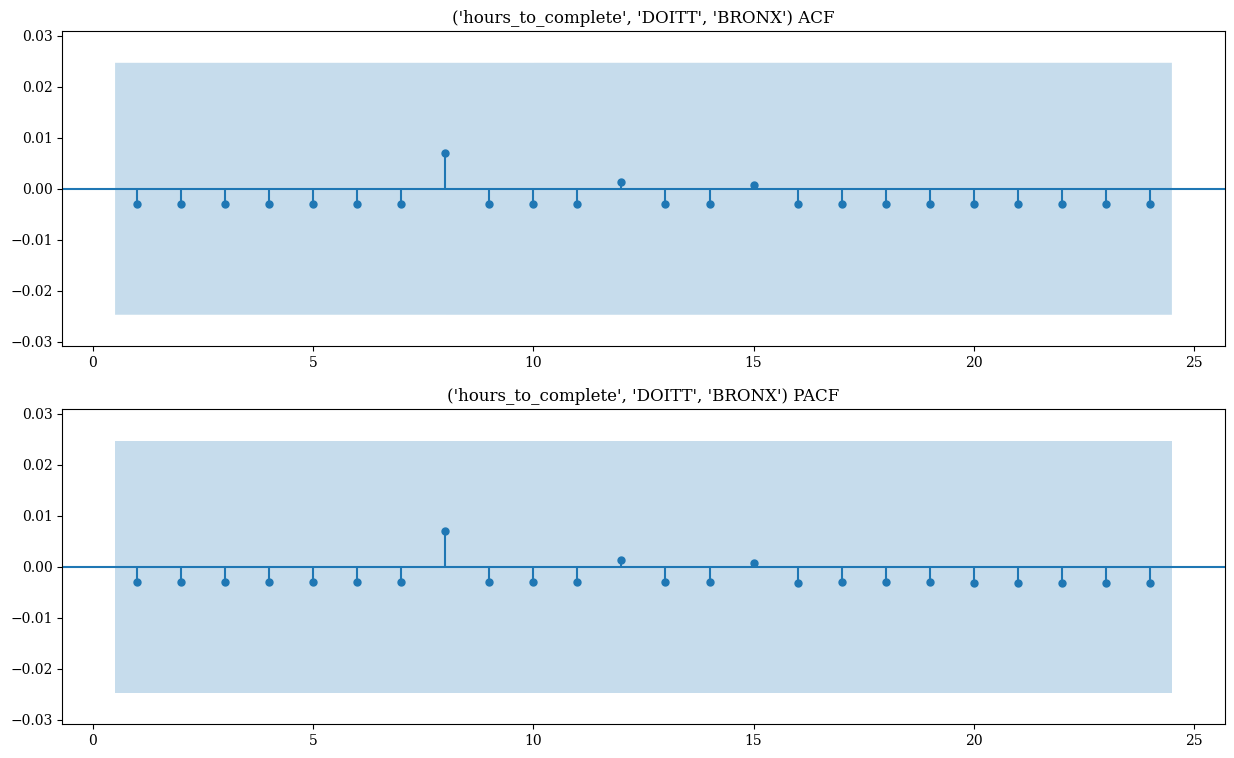

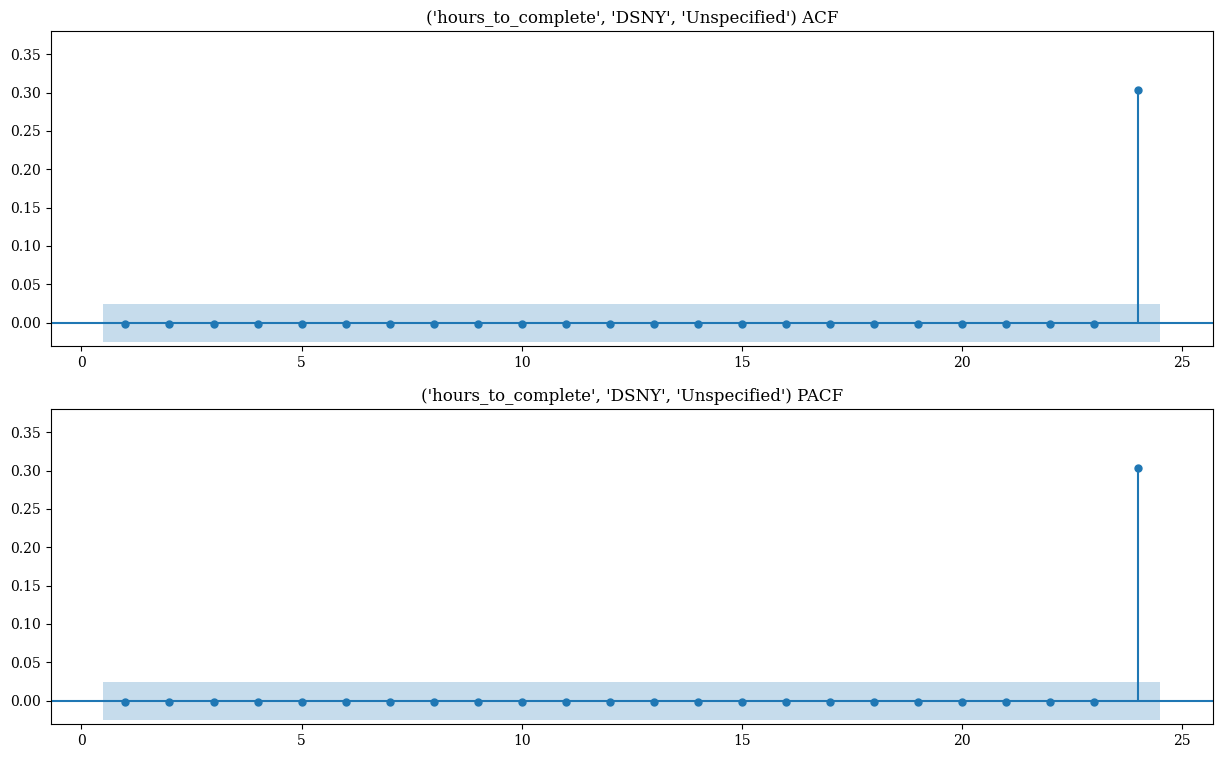

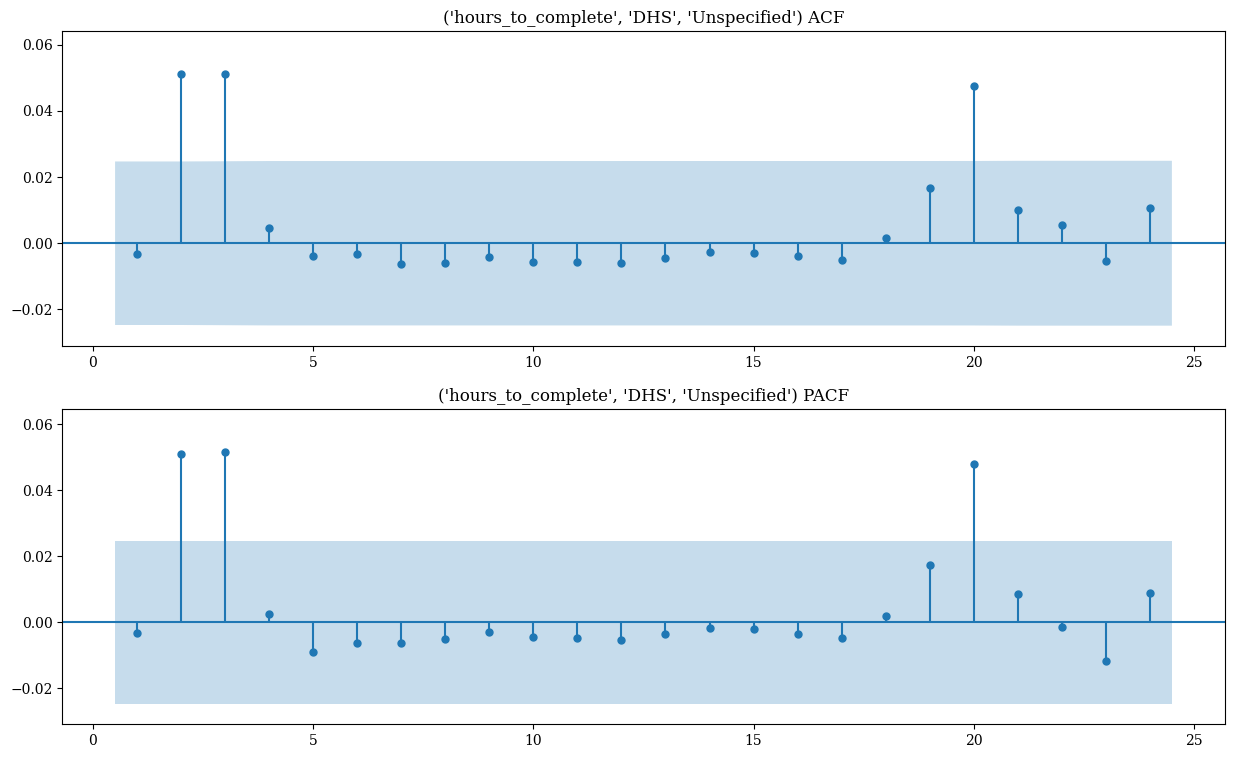

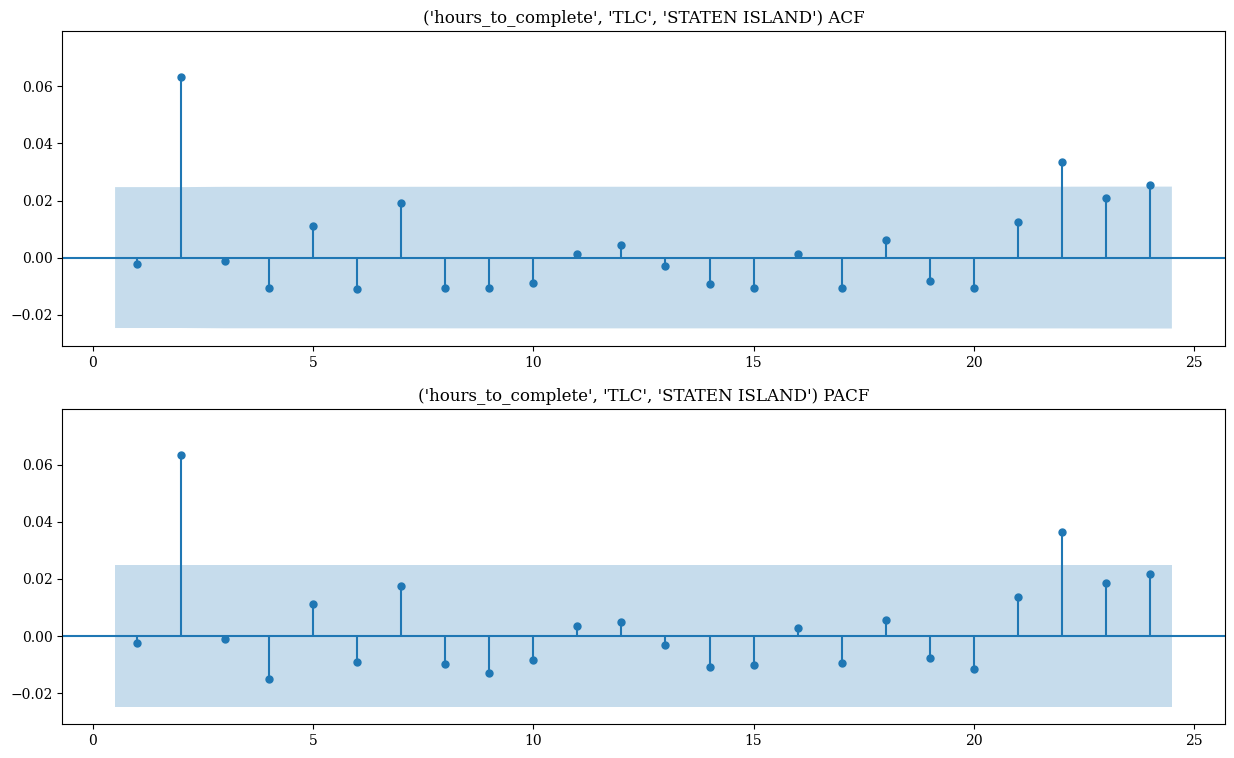

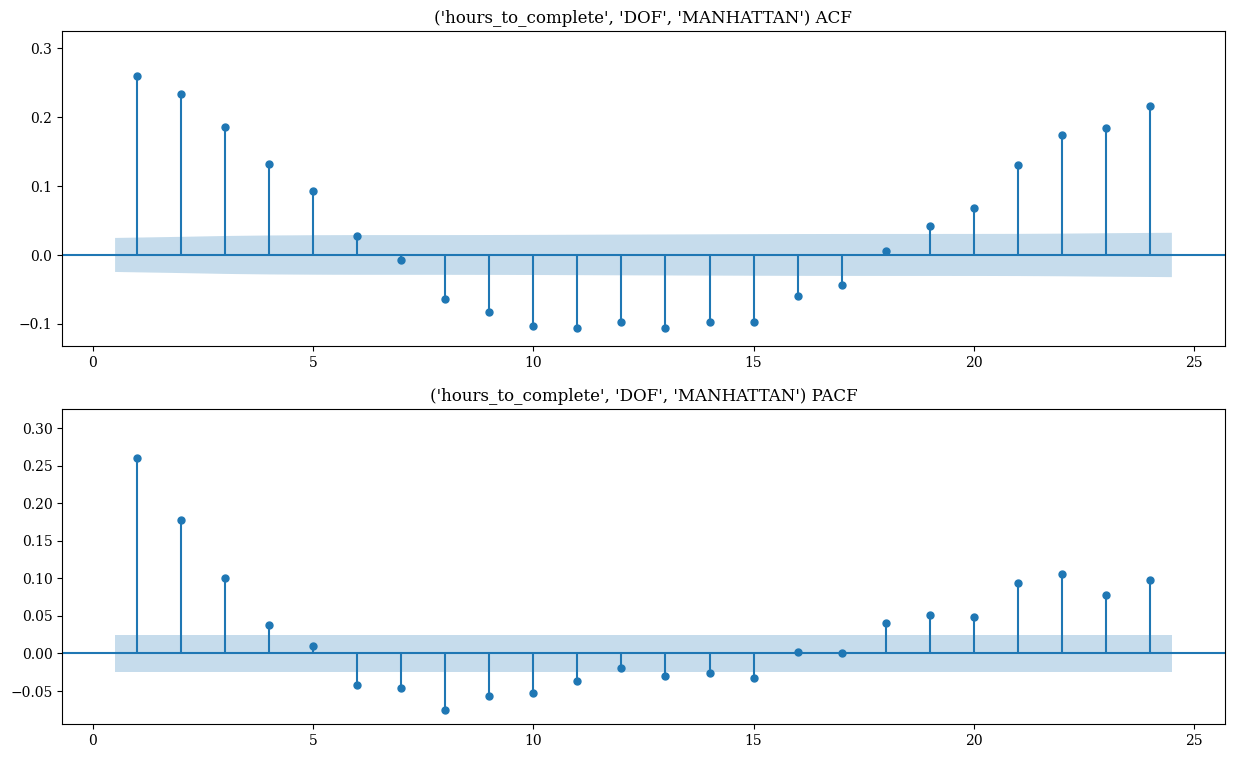

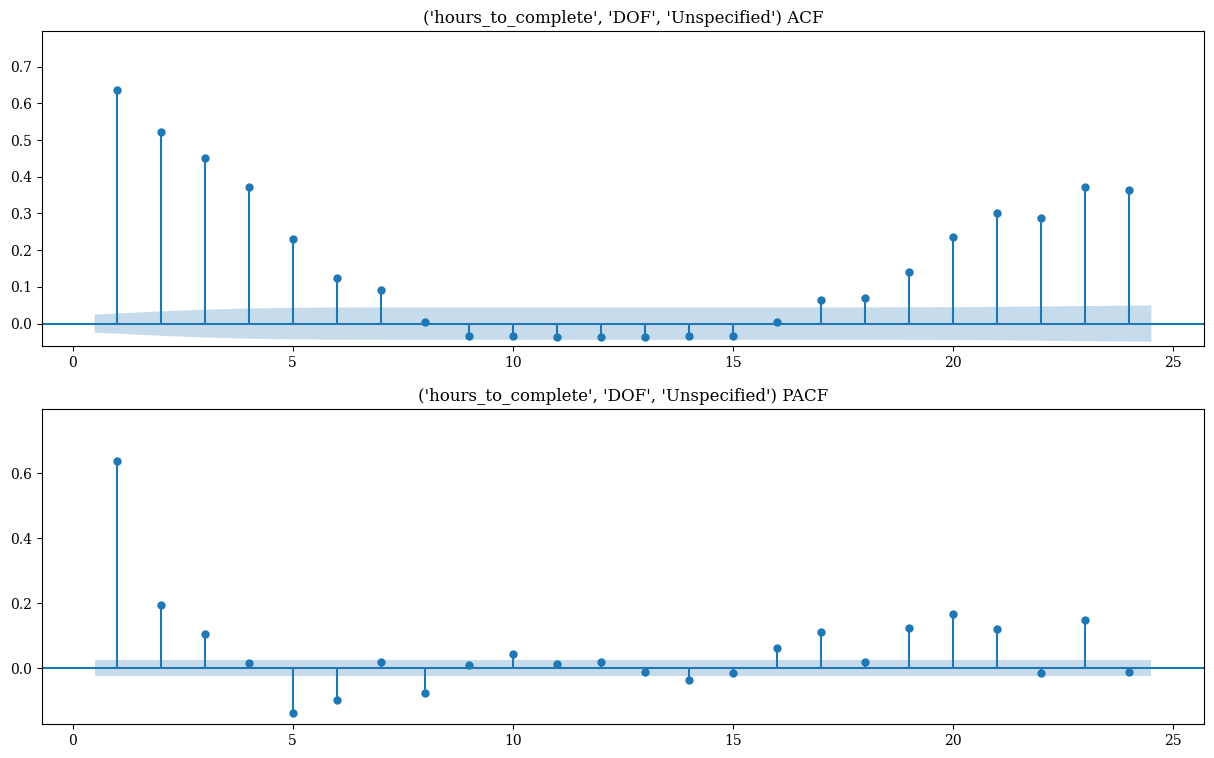

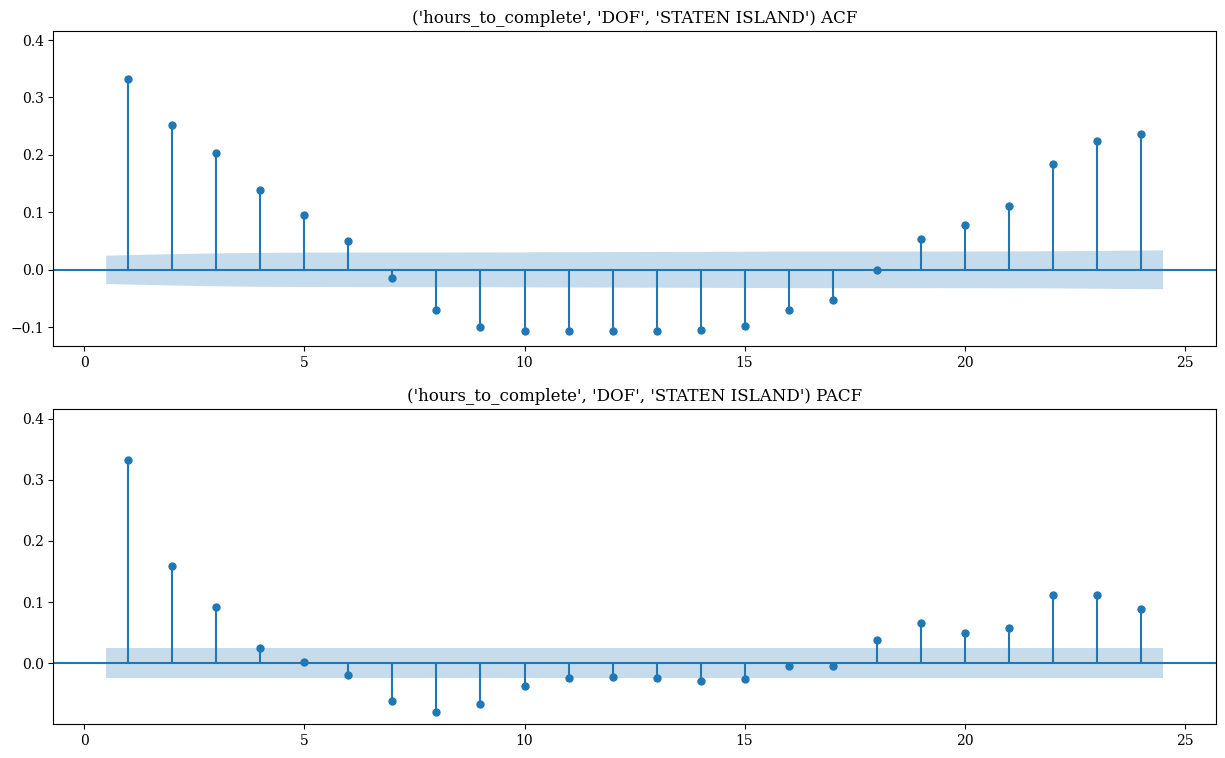

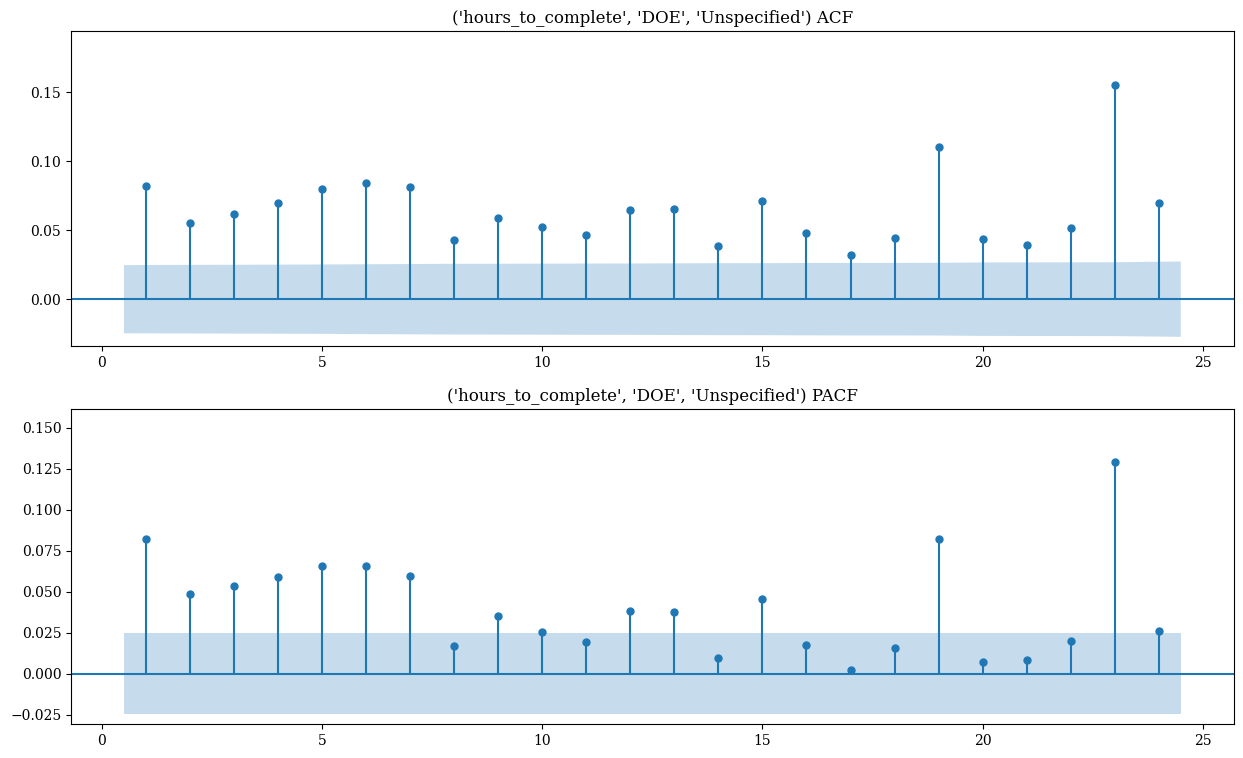

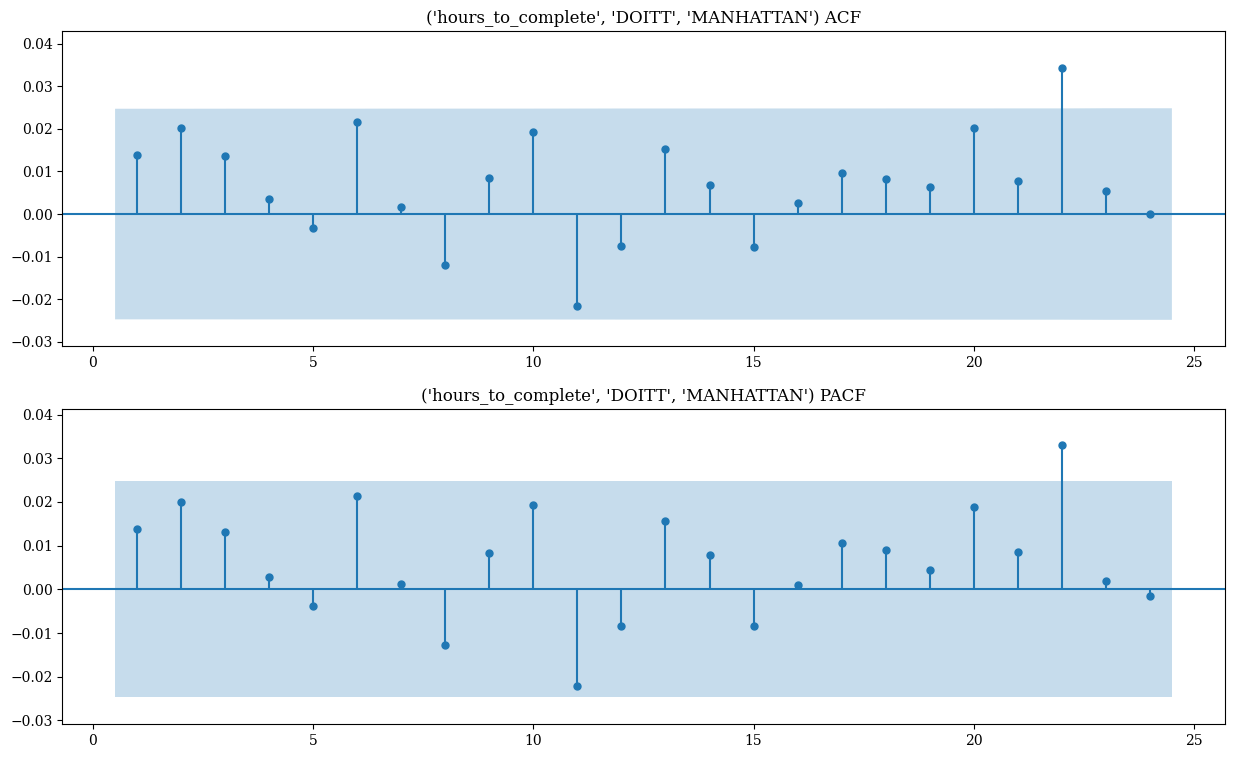

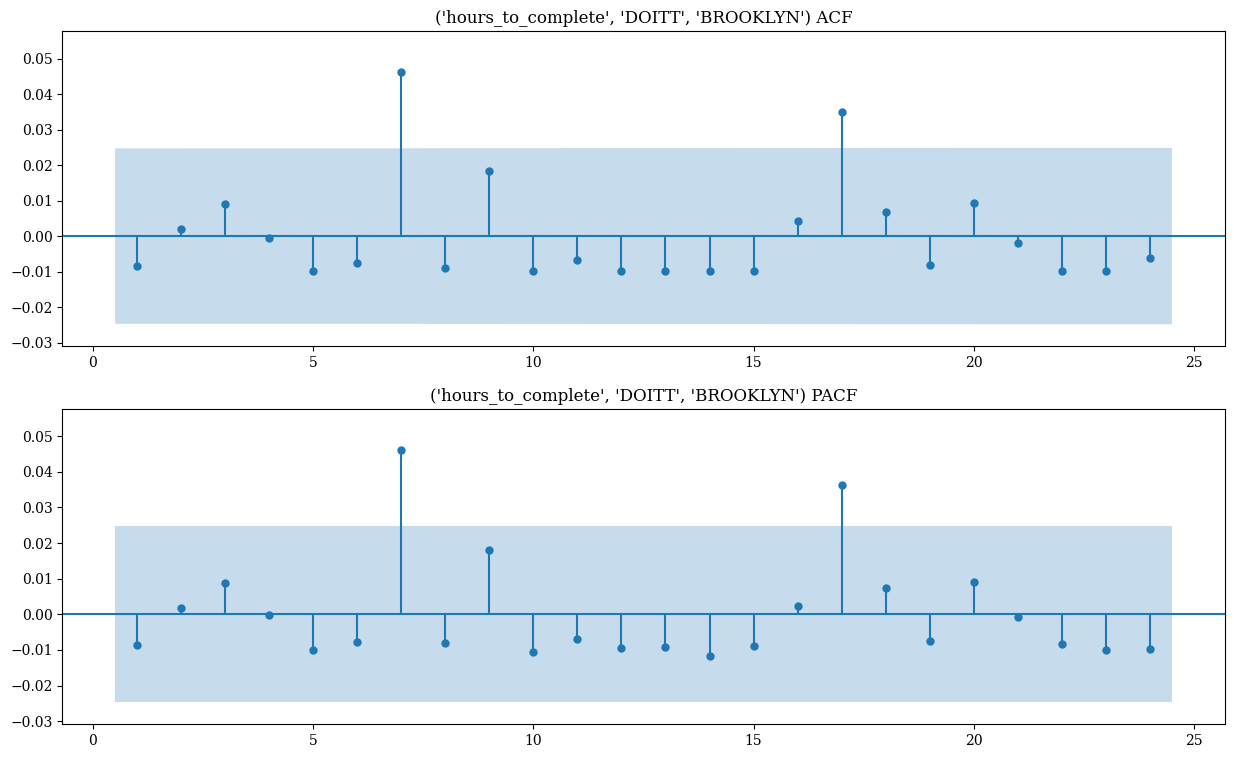

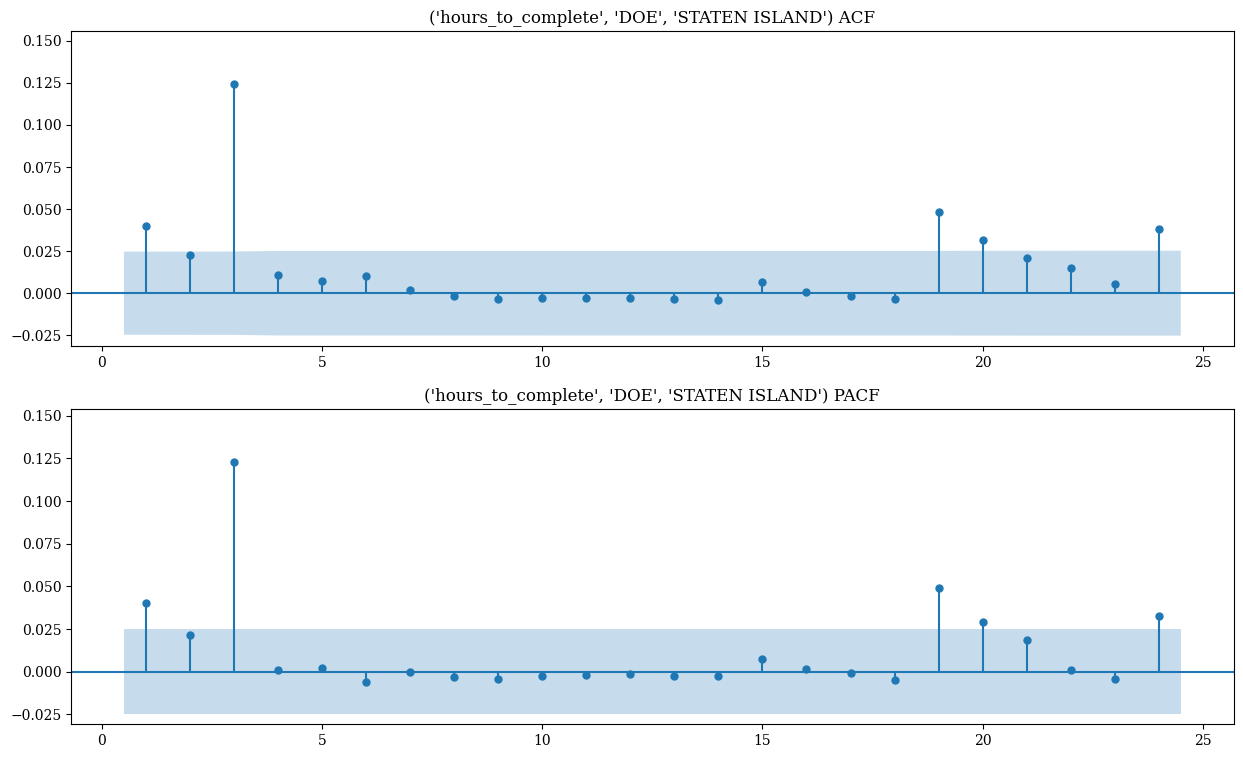

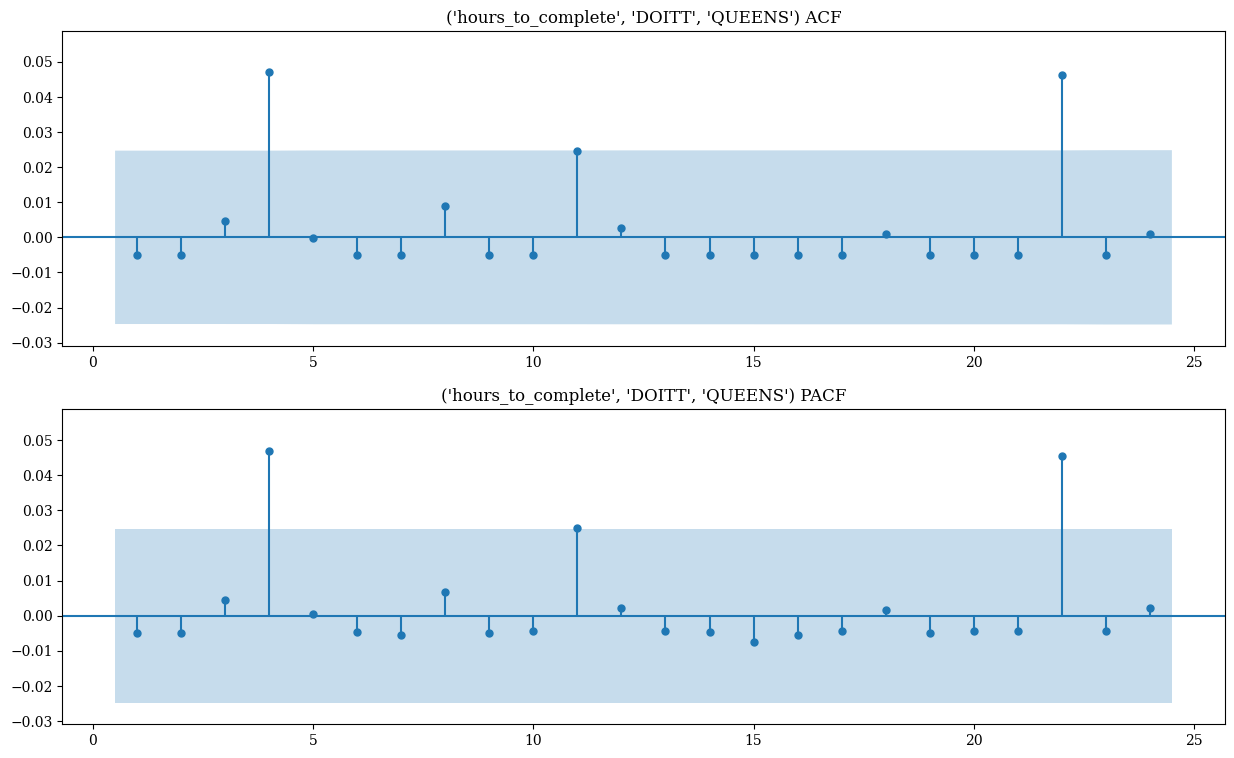

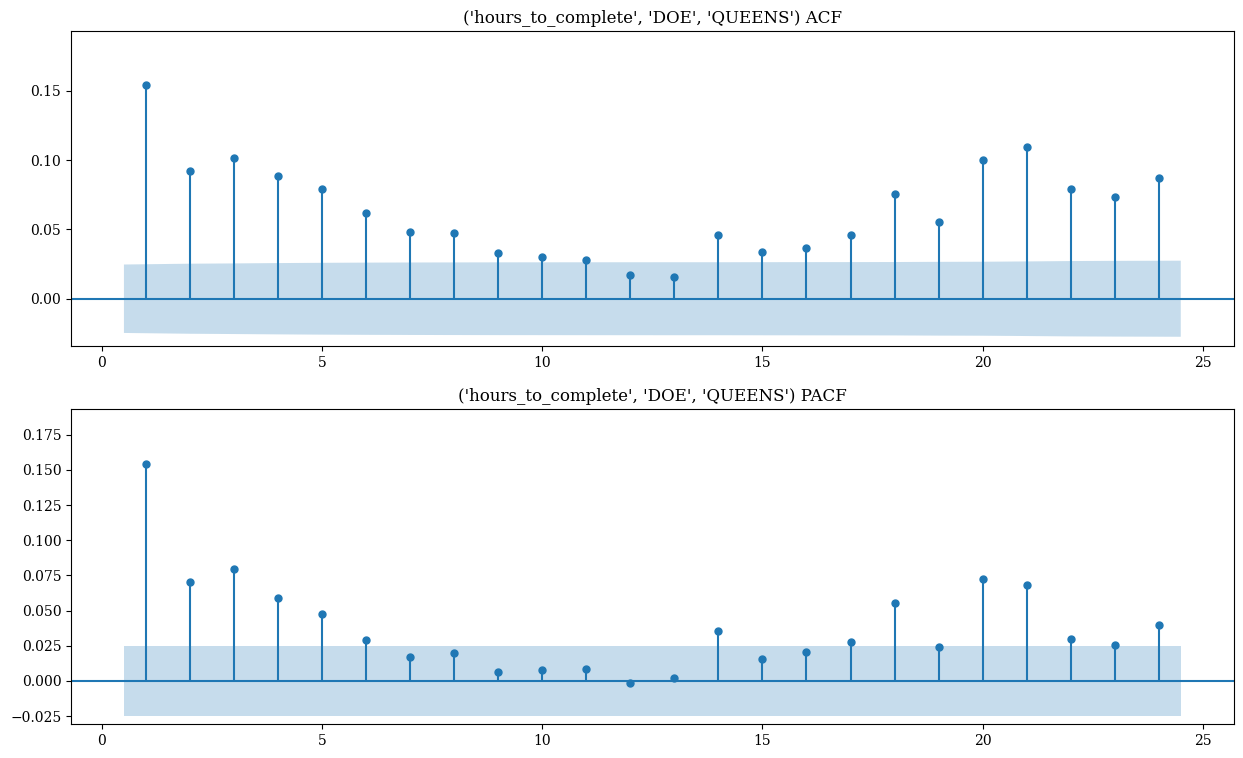

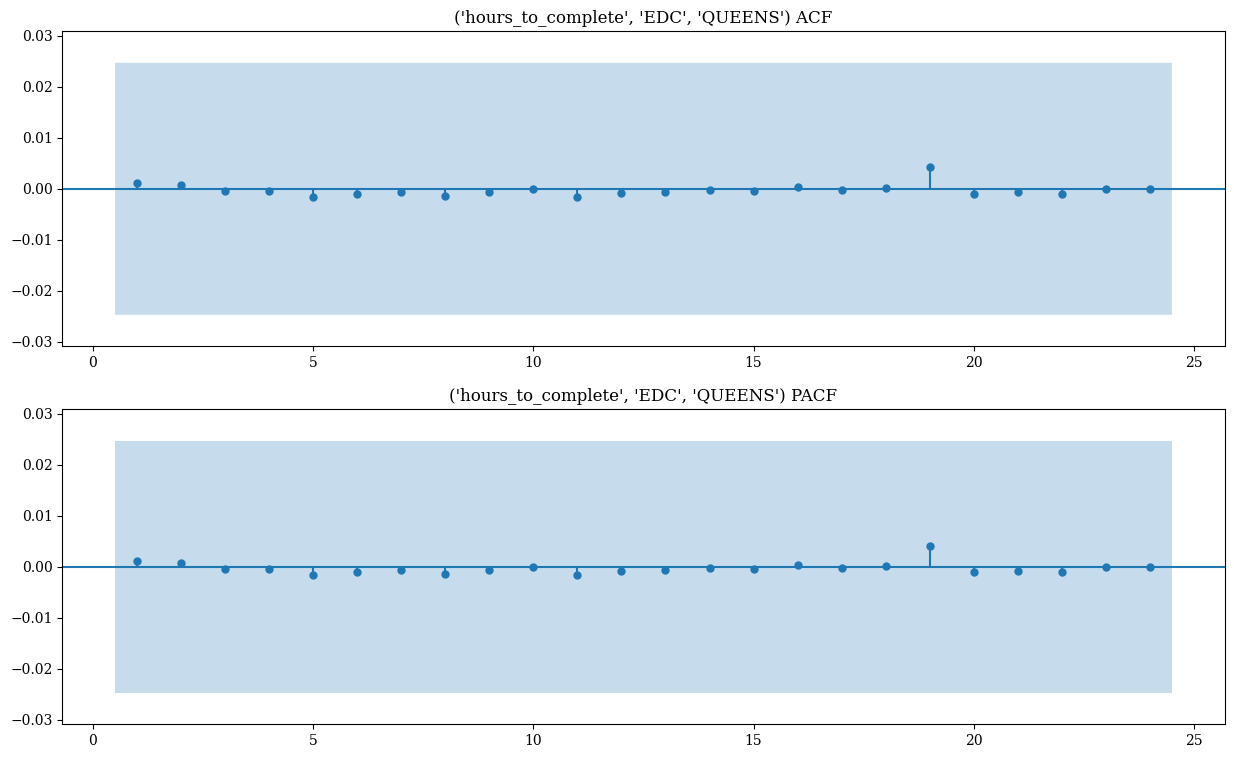

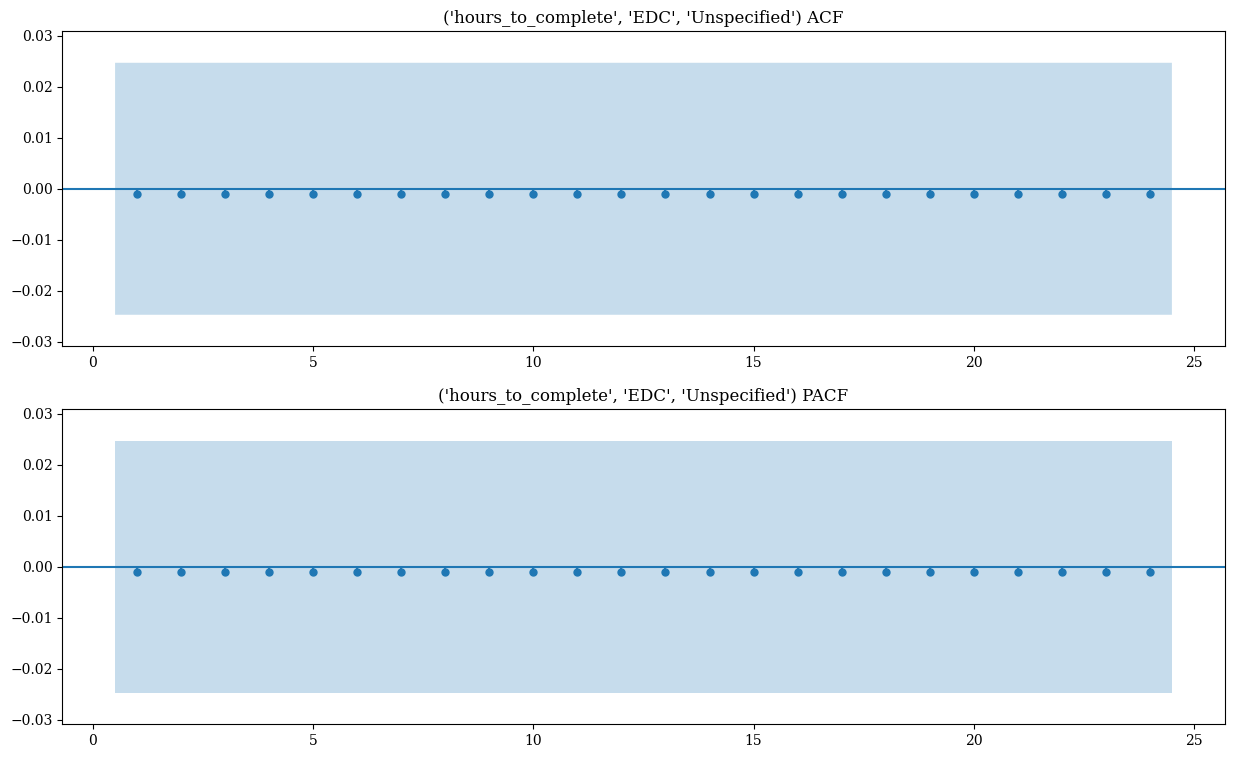

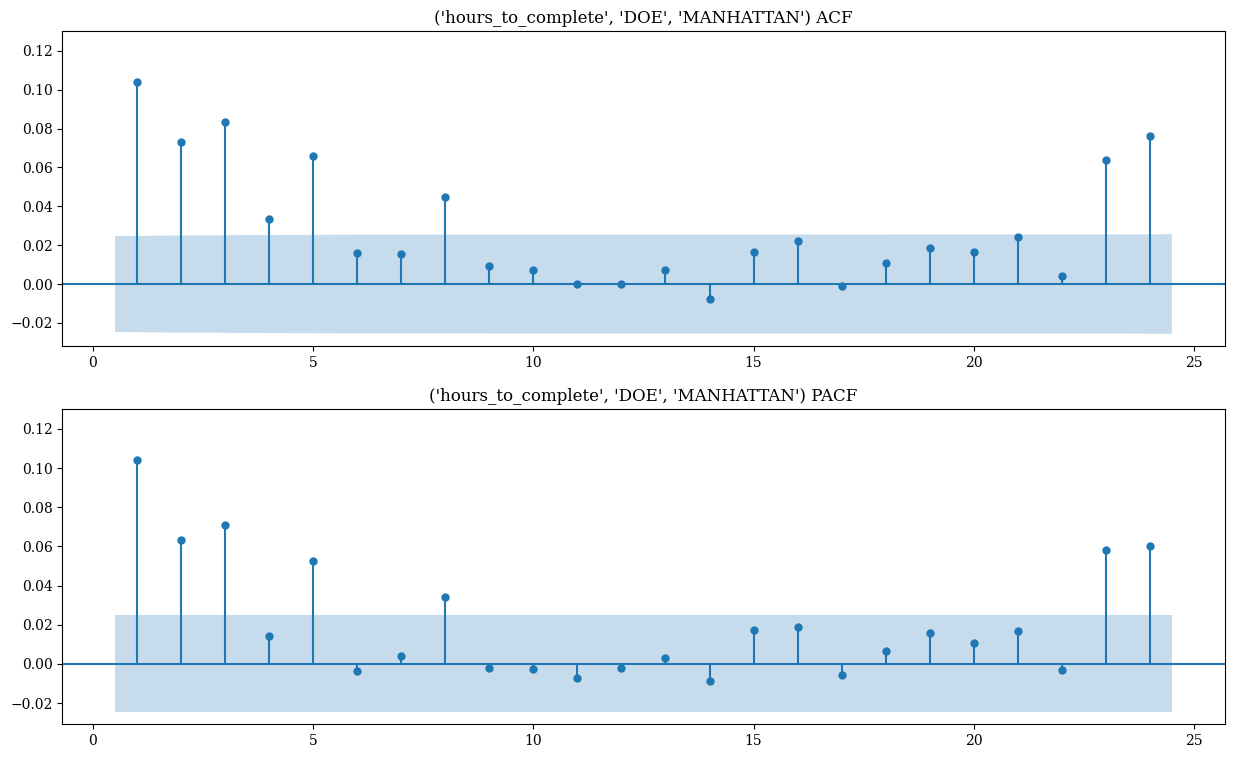

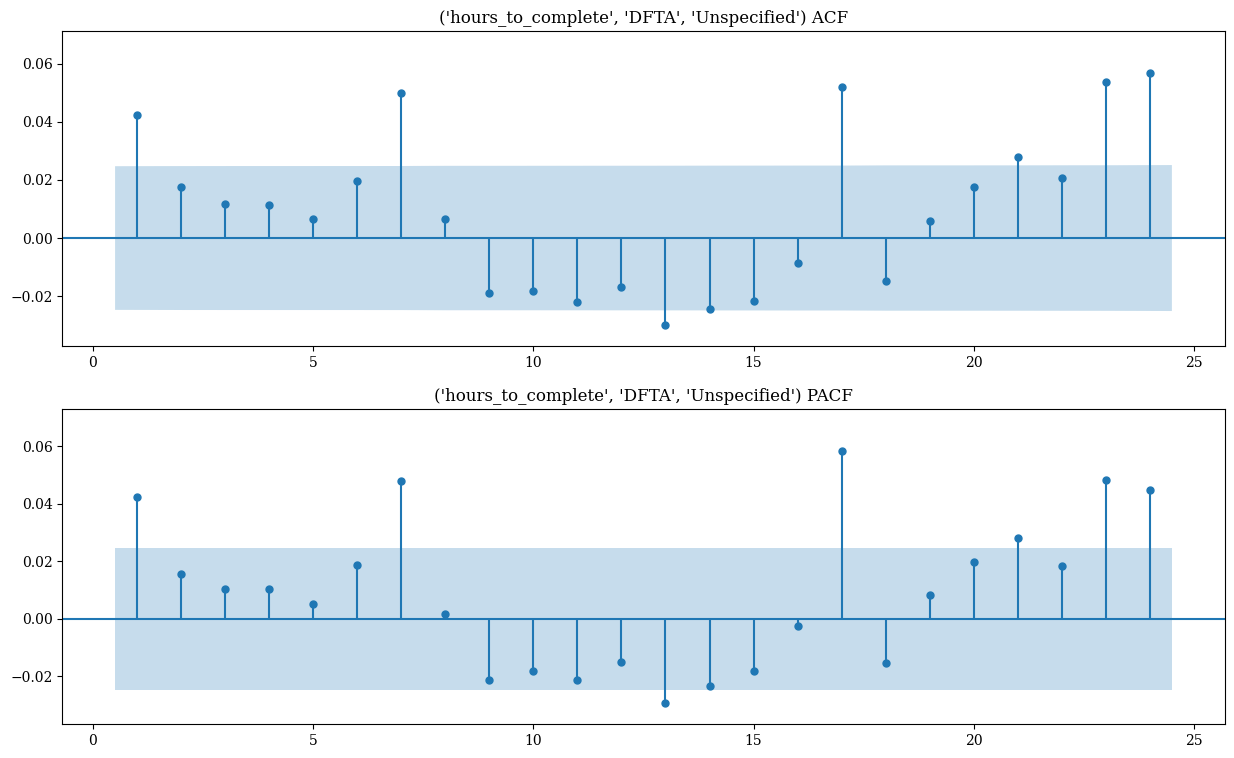

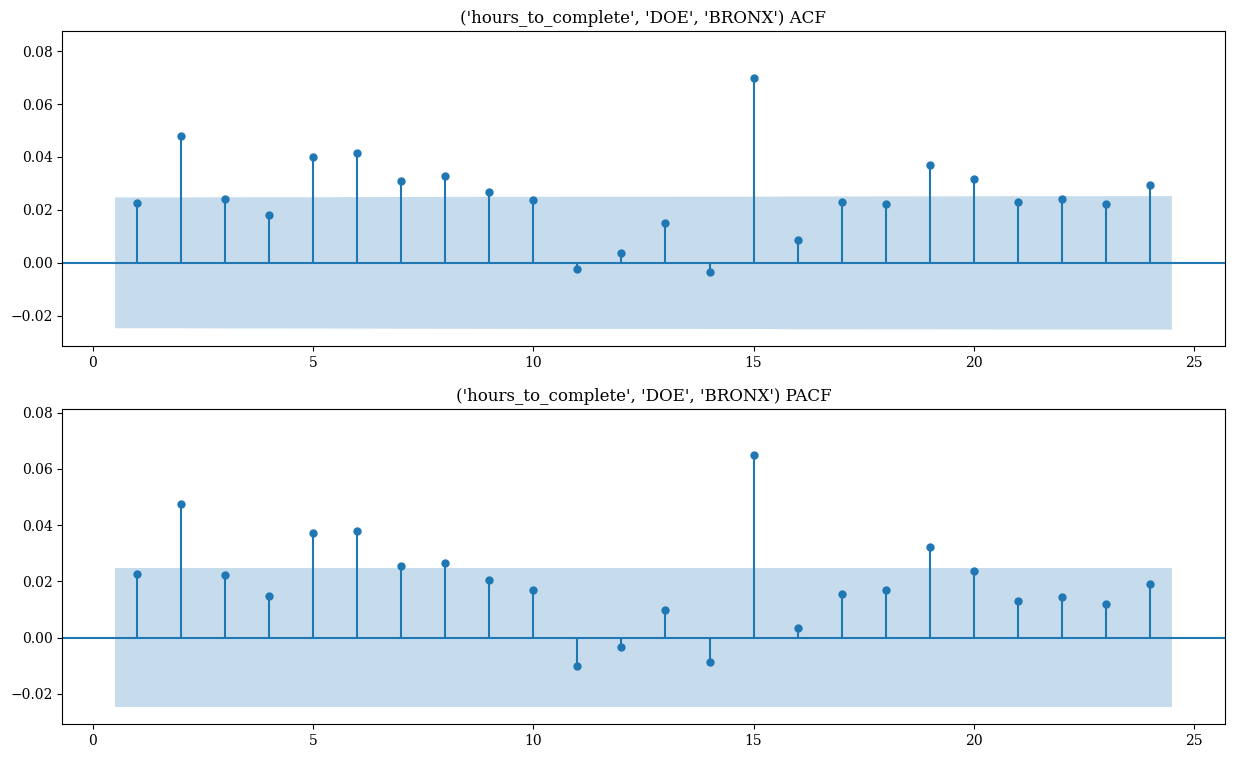

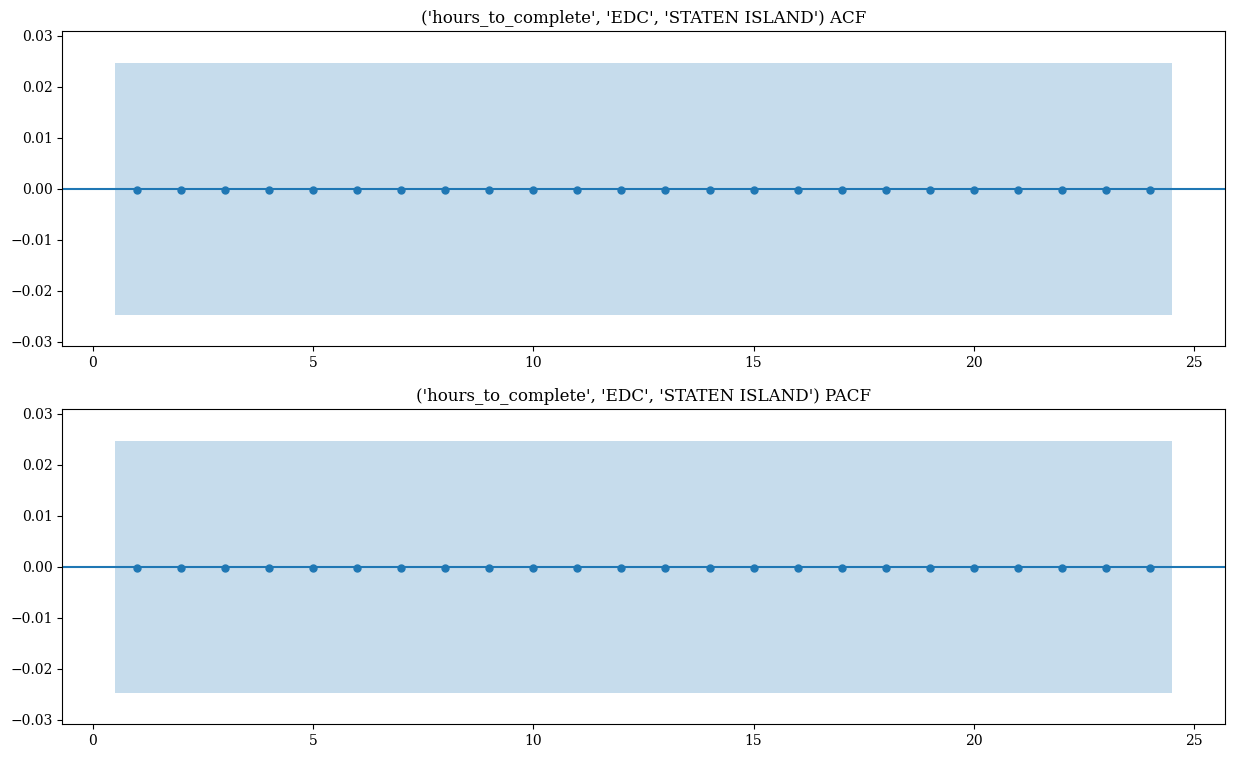

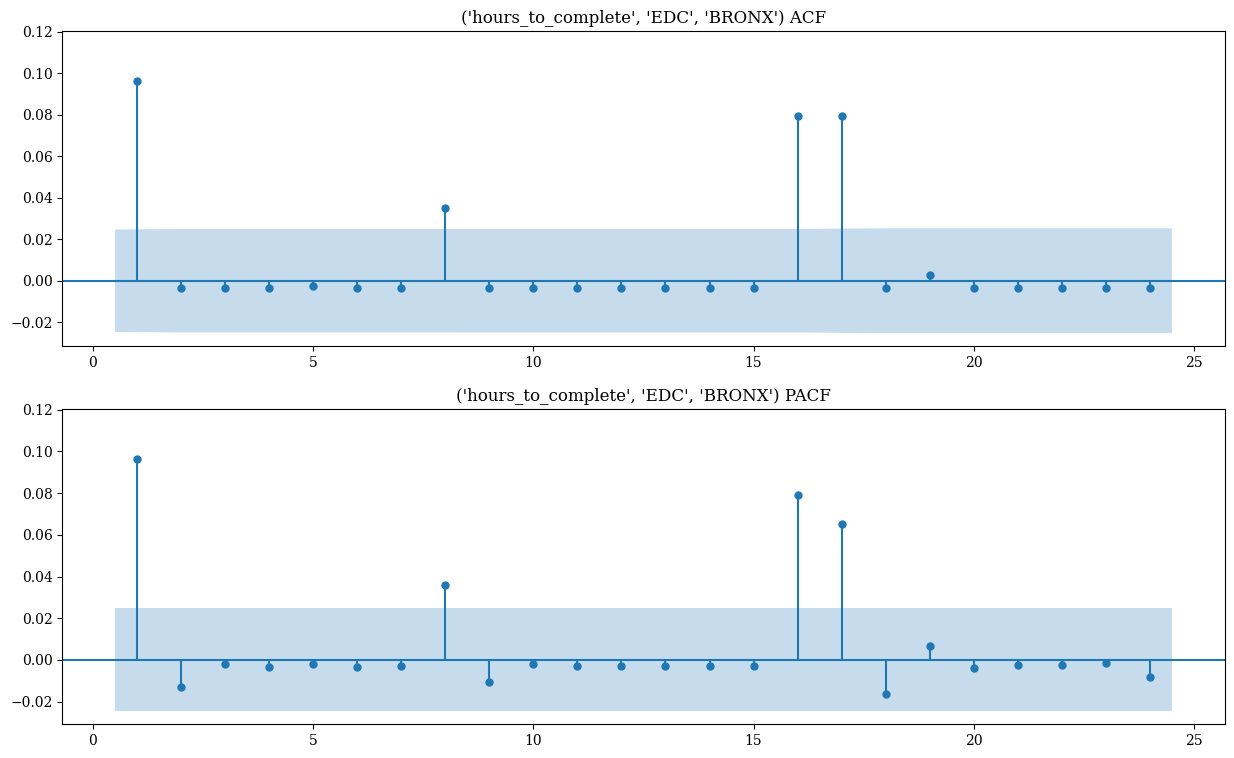

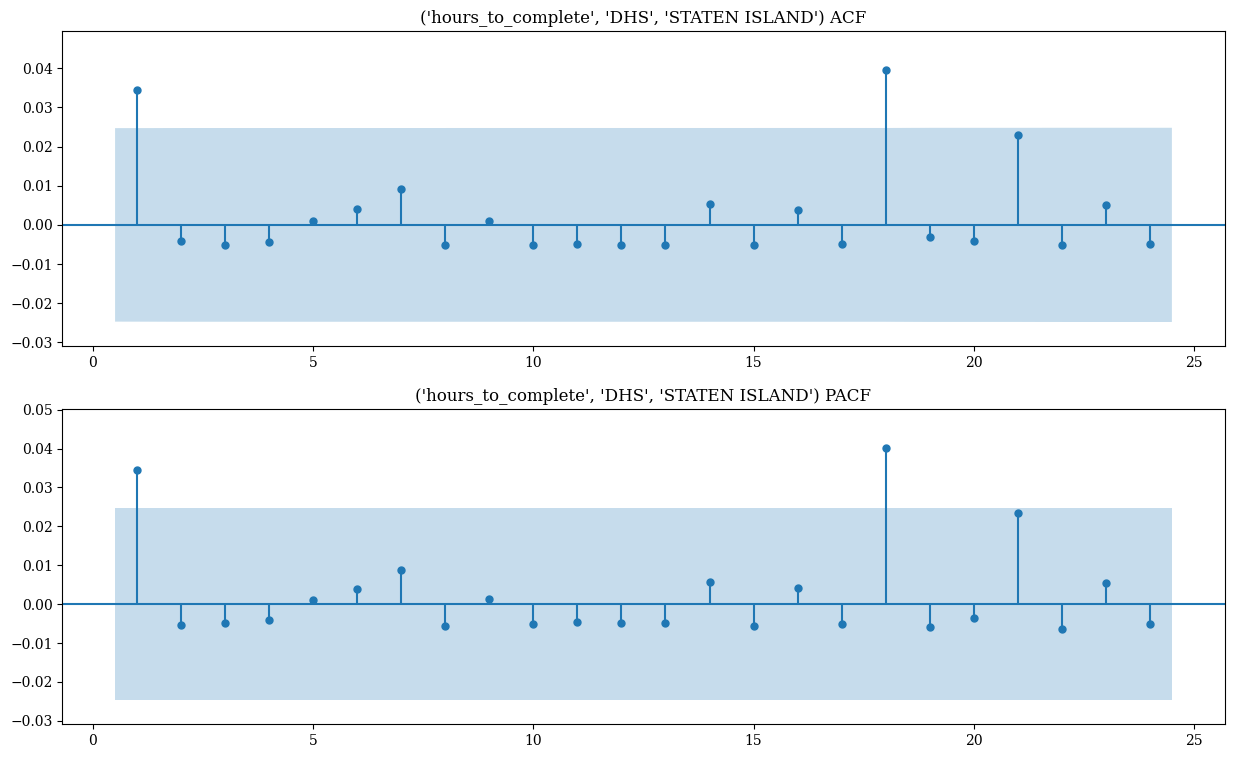

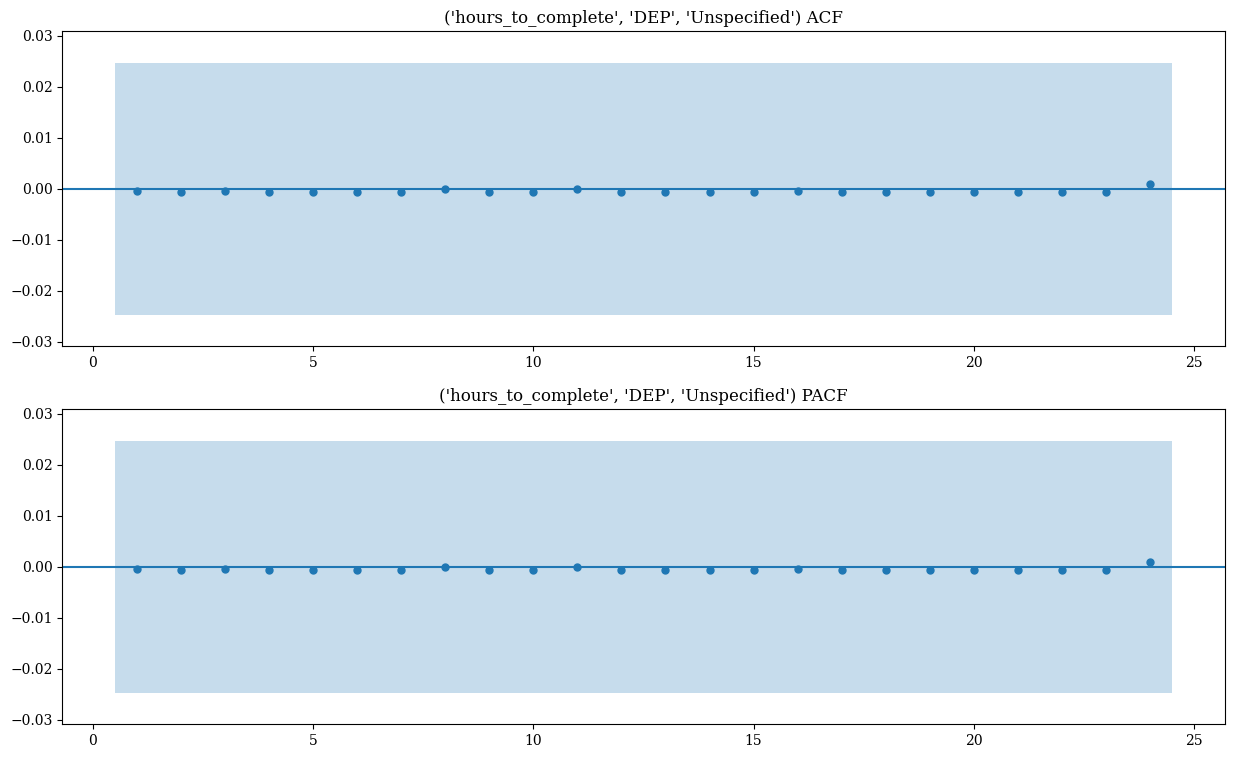

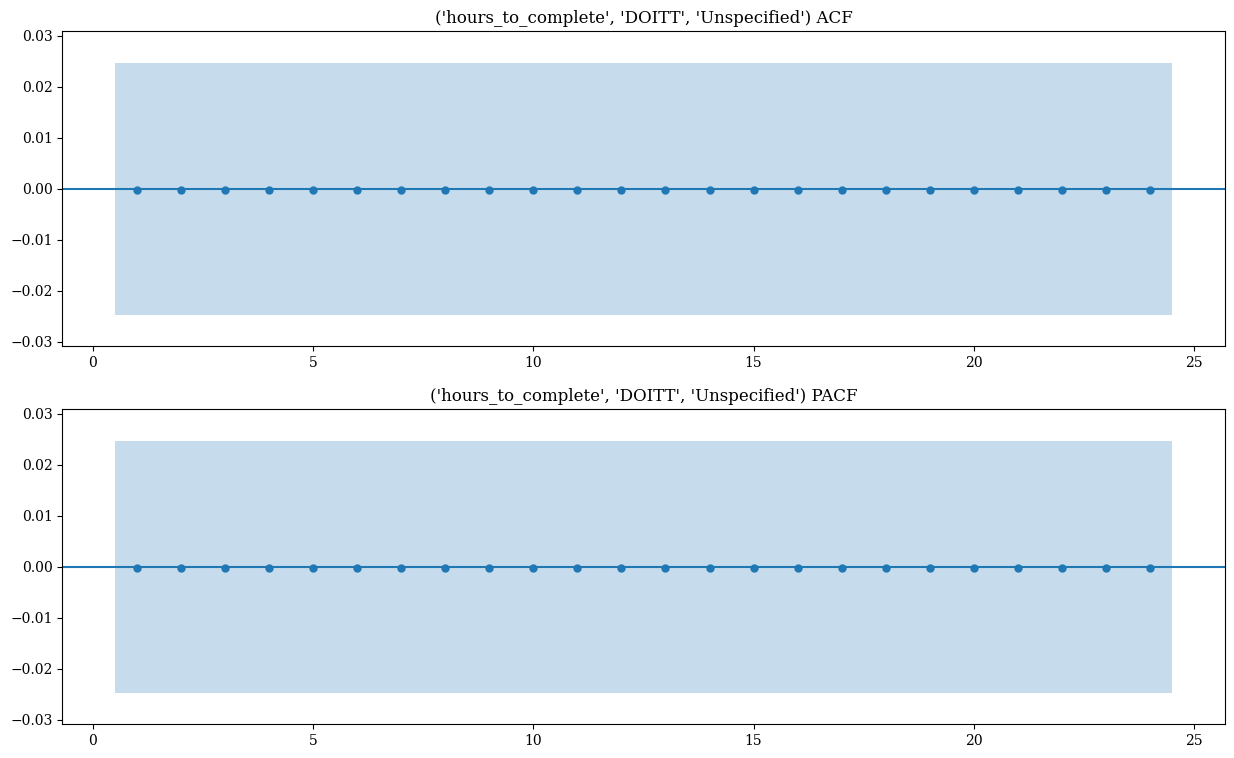

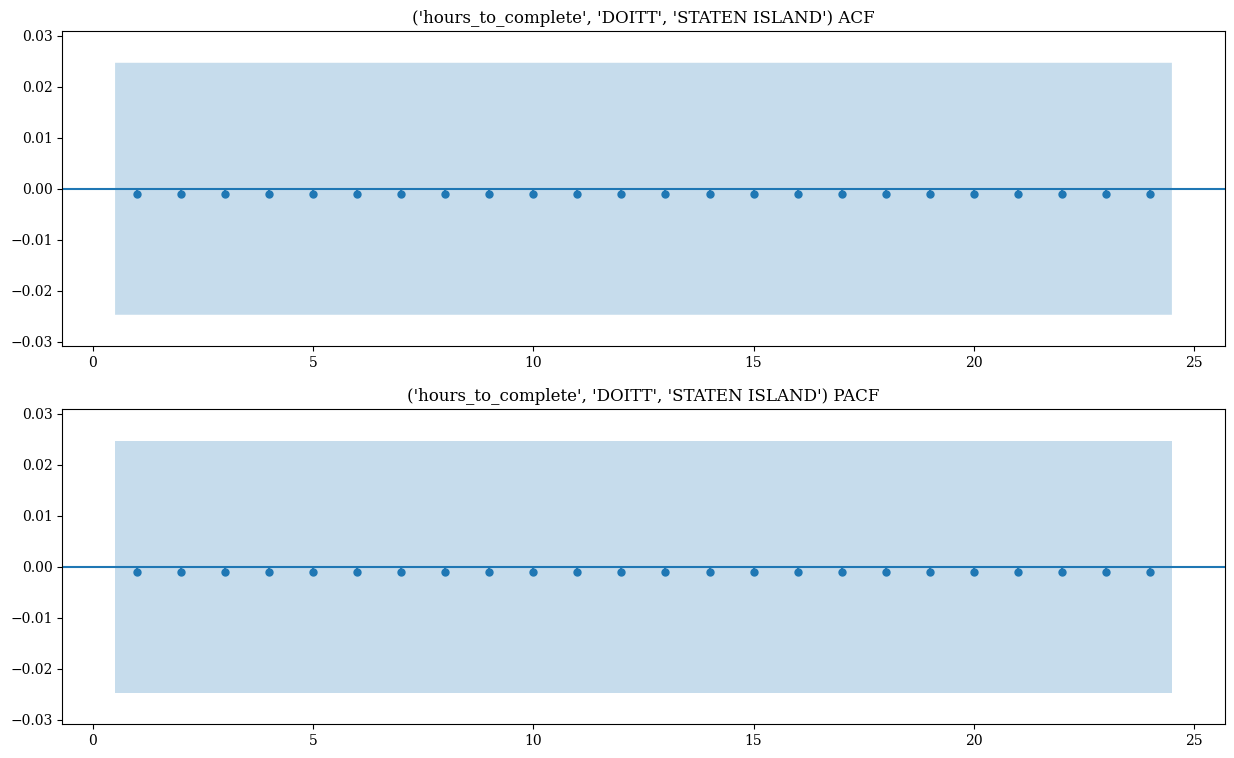

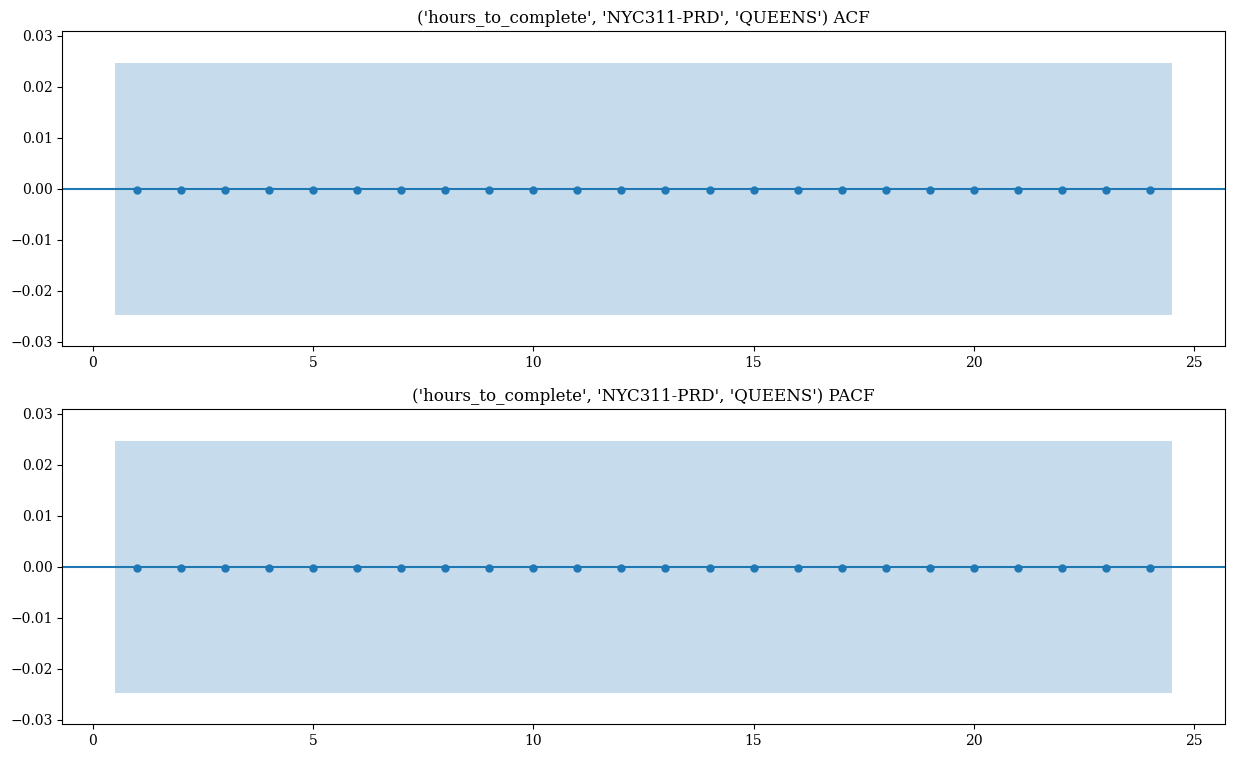

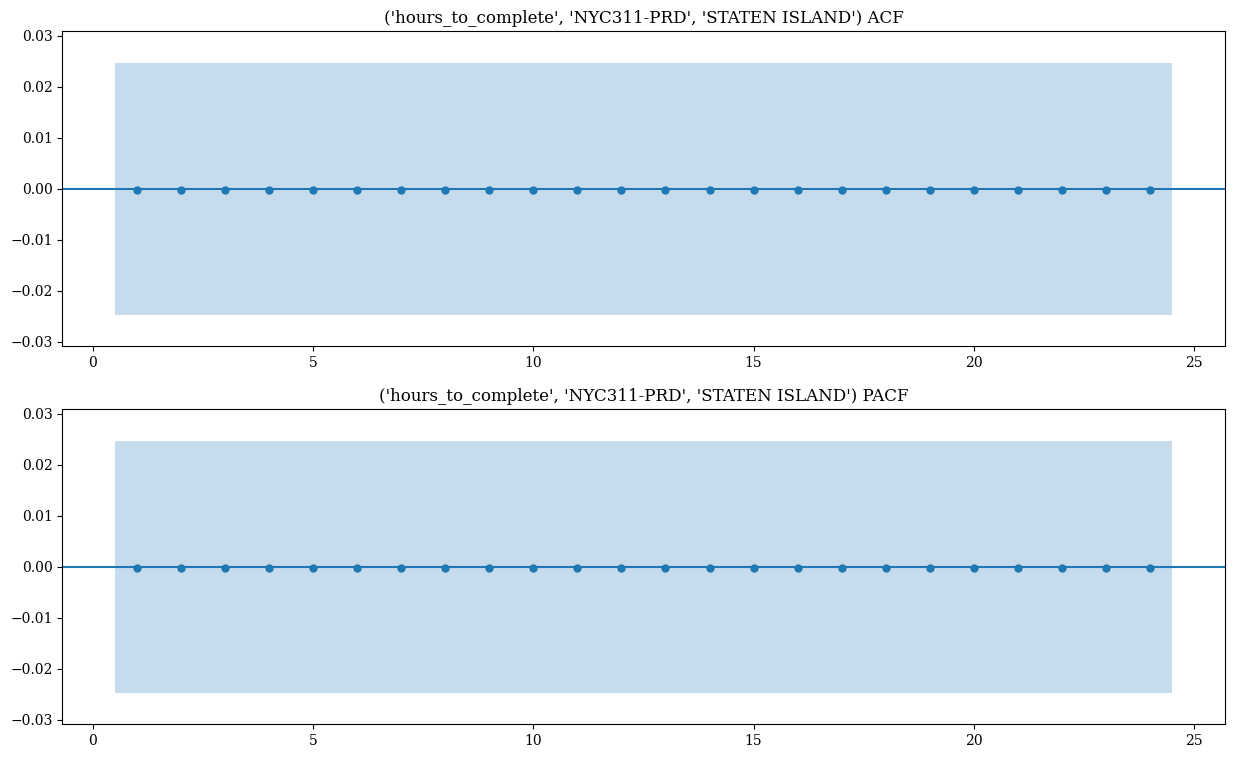

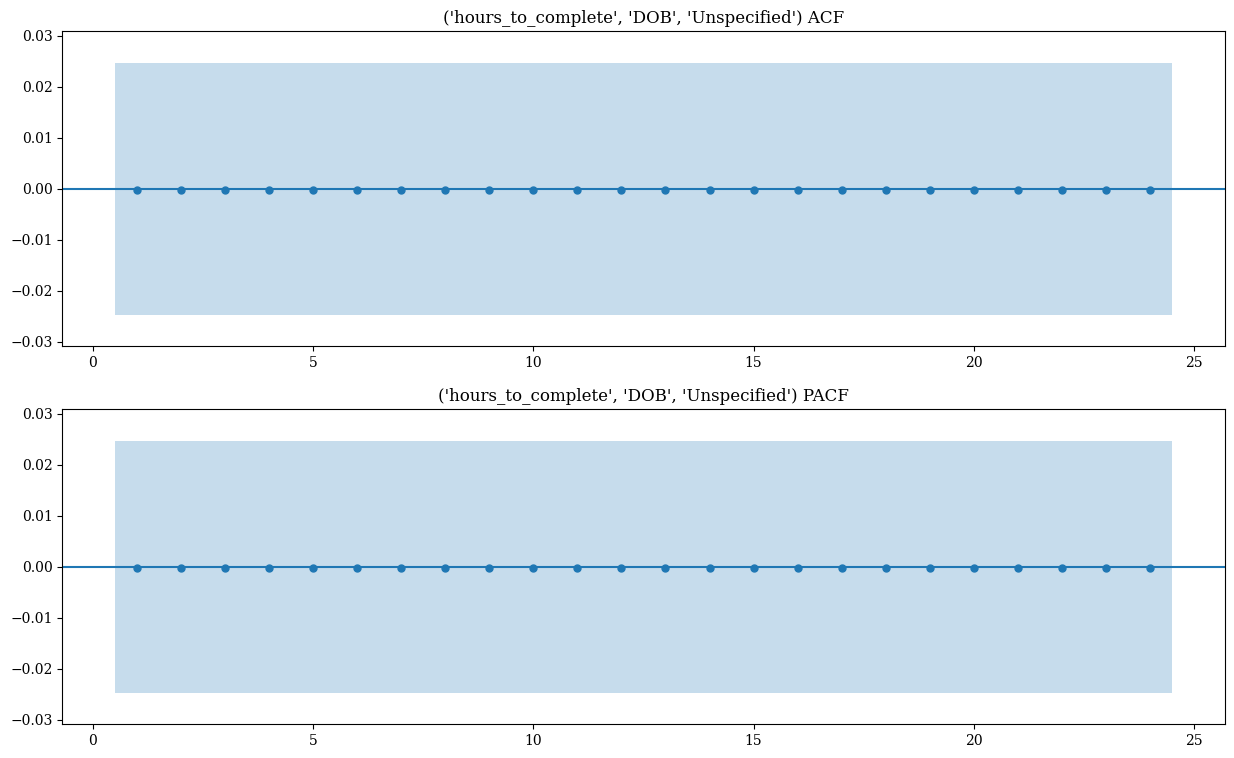

In [41]:
for c in target_ag_bo_df.columns:
    print(c)
    check_stationarity(target_ag_bo_df[c])
    display(acorr_ljungbox(target_ag_bo_df[c], lags=24))
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 9))
    plot_acf(target_ag_bo_df[c],lags=lags, ax=ax[0], zero=False, auto_ylims=True)
    ax[0].set_title(f'{c} ACF')
    plot_pacf(target_ag_bo_df[c],lags=lags, ax=ax[1], method='ols', zero=False, auto_ylims=True)
    ax[1].set_title(f'{c} PACF')

ADF Statistic: -78.383144
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.880569   0.348046
2    1.046127   0.592702
3    1.252586   0.740422
4    1.286525   0.863658
5    1.287985   0.936163
6    1.292305   0.972080
7    1.423862   0.984829
8    1.798983   0.986566
9    1.943915   0.992324
10   2.257990   0.993953
11   7.230117   0.780154
12   8.015339   0.783931
13   8.699504   0.795241
14   8.699517   0.849804
15  12.959774   0.605405
16  13.039843   0.669842
17  13.441233   0.706184
18  13.498690   0.761138
19  13.557442   0.808852
20  13.557897   0.852186
21  13.567587   0.887447
22  14.288951   0.890907
23  14.404200   0.914709
24  15.114985   0.917349

ADF Statistic: -11.372754
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    31.078720  2.477729e-08
2    62.398148  2.821074e-14
3    69.533749  5.371461e-15
4    78.665490  3.339363e-16
5    87.490922  2.260246e-17
6    89.273765  4.288038e-17
7   101.089130  6.426339e-19
8   105.111459  3.837628e-19
9   110.769809  1.024885e-19
10  114.666558  6.091307e-20
11  115.830018  1.247395e-19
12  120.132461  5.815598e-20
13  120.672687  1.482418e-19
14  121.987309  2.566326e-19
15  123.670527  3.660472e-19
16  124.525987  7.371304e-19
17  124.833267  1.840427e-18
18  128.034584  1.257225e-18
19  131.280219  8.343156e-19
20  132.272513  1.458679e-18
21  133.545108  2.217359e-18
22  133.662149  5.429459e-18
23  146.587509  5.528918e-20
24  300.982766  1.063206e-49

ADF Statistic: -11.630069
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    187.273277   1.251809e-42
2    353.021968   2.199144e-77
3    443.429396   8.646863e-96
4    521.535978  1.471695e-111
5    538.028849  4.920013e-114
6    555.439388  9.488121e-117
7    555.497936  9.260262e-116
8    560.657837  6.671231e-116
9    592.891533  7.023344e-122
10   620.288656  7.901200e-127
11   673.415307  2.687395e-137
12   720.009289  2.292903e-146
13   781.083591  1.552204e-158
14   823.302903  1.143543e-166
15   842.914516  5.740339e-170
16   849.018011  2.178025e-170
17   849.056549  1.583219e-169
18   850.149530  6.649802e-169
19   855.917903  2.746538e-169
20   910.497155  4.583334e-180
21   959.319408  1.287170e-189
22  1051.196465  2.458613e-208
23  1141.651393  9.318789e-227
24  1239.364478  9.905868e-247

ADF Statistic: -12.284129
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    3560.574559        0.0
2    6116.882214        0.0
3    8354.133639        0.0
4   10016.282617        0.0
5   11188.685344        0.0
6   12148.523454        0.0
7   12812.235619        0.0
8   13318.578591        0.0
9   13982.297194        0.0
10  14732.797375        0.0
11  15483.315080        0.0
12  16164.220356        0.0
13  16746.757406        0.0
14  17497.767192        0.0
15  18360.177381        0.0
16  19041.438335        0.0
17  19723.467748        0.0
18  20405.937891        0.0
19  21088.867329        0.0
20  21772.382835        0.0
21  22456.128088        0.0
22  22841.363803        0.0
23  23058.595097        0.0
24  23289.345331        0.0

ADF Statistic: -36.551825
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1   108.915201  1.693794e-25
2   112.396943  3.920252e-25
3   112.493195  3.189530e-24
4   123.151806  1.133267e-25
5   126.978590  1.041319e-25
6   128.060624  3.290737e-25
7   128.385310  1.366461e-24
8   129.854673  3.032243e-24
9   130.183478  1.087249e-23
10  132.124803  1.720915e-23
11  132.394673  5.699878e-23
12  132.612538  1.843473e-22
13  132.667697  6.149878e-22
14  132.675813  2.011557e-21
15  132.928883  5.668868e-21
16  133.842024  1.148809e-20
17  134.215762  2.881454e-20
18  134.216780  8.280582e-20
19  134.371878  2.160150e-19
20  136.635627  2.194185e-19
21  136.870733  5.290409e-19
22  137.084721  1.257563e-18
23  137.128252  3.143117e-18
24  141.432350  1.270706e-18

ADF Statistic: -8.419090
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   120.118930   5.957952e-28
2   231.076982   6.641574e-51
3   309.080273   1.077570e-66
4   383.129593   1.227560e-81
5   408.334832   4.739671e-86
6   433.938215   1.403728e-90
7   458.603060   6.306554e-95
8   464.984963   2.272425e-95
9   469.681573   1.772142e-95
10  469.696850   1.309160e-94
11  472.749128   2.062953e-94
12  473.313807   1.051626e-93
13  474.426107   3.925242e-93
14  477.749957   4.792992e-93
15  480.422223   7.784392e-93
16  487.507618   1.438454e-93
17  489.517125   3.051447e-93
18  499.781848   1.159594e-94
19  537.686295  6.775348e-102
20  589.995622  3.682080e-112
21  656.096186  2.456492e-125
22  695.488331  6.951803e-133
23  766.483817  4.198814e-147
24  832.638127  2.624592e-160

ADF Statistic: -10.082657
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   1773.082271        0.0
2   3054.809723        0.0
3   3904.346137        0.0
4   4405.892159        0.0
5   4646.809547        0.0
6   4726.435064        0.0
7   4733.734252        0.0
8   4756.550335        0.0
9   4906.079434        0.0
10  5157.596252        0.0
11  5469.521786        0.0
12  5814.622952        0.0
13  6150.473453        0.0
14  6401.573940        0.0
15  6546.480315        0.0
16  6594.374284        0.0
17  6599.703489        0.0
18  6605.742014        0.0
19  6669.143491        0.0
20  6857.457506        0.0
21  7215.919612        0.0
22  7796.052606        0.0
23  8569.461969        0.0
24  9605.972356        0.0

ADF Statistic: -7.311082
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   185.655191   2.823355e-42
2   338.212394   3.615029e-74
3   387.605377   1.071058e-83
4   434.165426   1.150262e-92
5   445.519201   4.547517e-94
6   448.787801   8.950144e-94
7   448.904106   7.634616e-93
8   455.850823   2.061614e-93
9   457.151849   8.479524e-93
10  460.970201   9.539431e-93
11  475.913981   4.367515e-95
12  480.727991   2.789328e-95
13  493.817324   3.008872e-97
14  501.734105   3.977615e-98
15  523.619083  5.665118e-102
16  527.403310  5.405355e-102
17  541.852145  2.816010e-104
18  553.568696  5.475031e-106
19  605.295572  3.849655e-116
20  628.530390  2.785100e-120
21  658.742993  6.794030e-126
22  745.617087  1.812082e-143
23  840.500817  9.329061e-163
24  953.465119  6.724556e-186

ADF Statistic: -43.860005
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.707418   0.400302
2    3.658552   0.160530
3    7.652570   0.053765
4    8.511714   0.074533
5    8.547618   0.128527
6   13.560320   0.034952
7   13.721362   0.056365
8   15.569335   0.048976
9   15.842084   0.070253
10  15.965748   0.100617
11  21.472221   0.028796
12  23.745846   0.022021
13  24.039823   0.030766
14  24.919929   0.035366
15  24.999233   0.049954
16  25.554354   0.060630
17  25.600017   0.082063
18  26.676416   0.085268
19  27.479658   0.093967
20  28.490369   0.098290
21  28.656891   0.122486
22  34.474972   0.043922
23  34.569885   0.057355
24  46.608737   0.003738

ADF Statistic: -12.567948
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.206251   0.649722
2    0.956265   0.619940
3    0.976166   0.807019
4    1.299906   0.861392
5    1.368850   0.927690
6    1.486791   0.960367
7    1.510239   0.981953
8    2.374747   0.967316
9    3.054797   0.962083
10   3.169063   0.977161
11   3.286575   0.986371
12   4.490515   0.972874
13   4.635633   0.982364
14   5.001551   0.985791
15   5.426447   0.987859
16   5.527961   0.992440
17   5.560028   0.995688
18  10.245411   0.923601
19  10.353131   0.943690
20  14.838304   0.785584
21  16.857688   0.719696
22  17.859379   0.714292
23  17.870146   0.764494
24  18.448885   0.780706

ADF Statistic: -9.527849
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1   118.095181  1.652641e-27
2   148.107788  6.899259e-33
3   159.429777  2.433254e-34
4   169.619136  1.262433e-35
5   183.892362  7.888797e-38
6   189.144703  3.867512e-38
7   197.549035  3.791640e-39
8   202.238303  2.156784e-39
9   207.112808  1.067293e-39
10  217.673241  3.279837e-41
11  220.172403  4.754067e-41
12  230.938408  1.272219e-42
13  246.417725  3.548507e-45
14  248.142059  6.960970e-45
15  255.595019  8.729543e-46
16  256.053316  2.962216e-45
17  256.923590  8.021748e-45
18  266.655983  3.287721e-46
19  269.269468  3.786124e-46
20  285.020367  9.153337e-49
21  301.139015  1.865343e-51
22  316.552354  5.297509e-54
23  324.410076  5.179235e-55
24  348.982872  2.022062e-59

ADF Statistic: -12.168457
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   300.157067   3.044751e-67
2   345.877265   7.828997e-76
3   377.325717   1.803875e-81
4   419.784599   1.475684e-89
5   427.700897   3.165934e-90
6   443.278489   1.372402e-92
7   499.599915  9.772647e-104
8   526.404944  1.514597e-108
9   527.513482  7.349375e-108
10  528.443260  3.666619e-107
11  528.684684  2.431651e-106
12  531.199301  5.031711e-106
13  533.051320  1.382747e-105
14  533.157996  8.583880e-105
15  533.740474  4.066440e-104
16  535.867344  8.771990e-104
17  543.247549  1.428802e-104
18  543.648264  6.760626e-104
19  544.747367  2.216254e-103
20  548.158182  2.314880e-103
21  548.371576  1.109102e-102
22  551.591772  1.217480e-102
23  590.871508  3.748684e-110
24  754.848326  6.975093e-144

ADF Statistic: -12.468342
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    2.266944   0.132160
2    7.979740   0.018502
3    8.041602   0.045160
4    8.104427   0.087827
5    8.171168   0.147051
6    8.212540   0.222942
7    8.256033   0.310560
8    8.371075   0.398087
9    8.425399   0.491908
10   8.519847   0.578195
11   8.553203   0.663058
12   8.609192   0.735898
13   8.731126   0.792934
14   8.750849   0.846672
15   8.893490   0.883020
16   8.969844   0.914650
17   9.039906   0.939002
18   9.040795   0.958790
19   9.228219   0.969494
20   9.229663   0.980091
21   9.230402   0.987282
22   9.272028   0.991791
23   9.346058   0.994649
24  16.354499   0.874857

ADF Statistic: -53.828816
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1    0.547588   0.459305
2    8.836112   0.012058
3    9.673733   0.021553
4   10.139542   0.038142
5   10.557521   0.060894
6   10.805360   0.094582
7   10.807693   0.147230
8   10.824629   0.211835
9   11.229889   0.260280
10  11.342265   0.331481
11  11.467734   0.404950
12  11.511573   0.485658
13  11.519391   0.567391
14  11.529520   0.644029
15  11.636736   0.706291
16  11.827027   0.755799
17  11.972856   0.801778
18  12.196324   0.836938
19  12.496588   0.863317
20  12.539549   0.896255
21  12.887288   0.912520
22  13.068430   0.931235
23  14.720926   0.904356
24  15.346005   0.910225

ADF Statistic: -15.283264
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   1078.910657  1.266407e-236
2   3343.897254   0.000000e+00
3   4633.508833   0.000000e+00
4   5129.273562   0.000000e+00
5   5319.175072   0.000000e+00
6   5373.793174   0.000000e+00
7   5385.364734   0.000000e+00
8   5385.377607   0.000000e+00
9   5385.378953   0.000000e+00
10  5385.379549   0.000000e+00
11  5385.380784   0.000000e+00
12  5385.400238   0.000000e+00
13  5385.400240   0.000000e+00
14  5385.402931   0.000000e+00
15  5385.410119   0.000000e+00
16  5385.413851   0.000000e+00
17  5385.414589   0.000000e+00
18  5385.431028   0.000000e+00
19  5385.435673   0.000000e+00
20  5385.441734   0.000000e+00
21  5385.442402   0.000000e+00
22  5385.442433   0.000000e+00
23  5385.450035   0.000000e+00
24  5385.450784   0.000000e+00

ADF Statistic: -79.330356
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat  lb_pvalue
1   0.000211   0.988402
2   0.000423   0.999789
3   0.000634   0.999996
4   0.000846   1.000000
5   0.001058   1.000000
6   0.001269   1.000000
7   0.001481   1.000000
8   0.001693   1.000000
9   0.001906   1.000000
10  0.002118   1.000000
11  0.002330   1.000000
12  0.002543   1.000000
13  0.002755   1.000000
14  0.002968   1.000000
15  0.003180   1.000000
16  0.003393   1.000000
17  0.003606   1.000000
18  0.003819   1.000000
19  0.004032   1.000000
20  0.004246   1.000000
21  0.004459   1.000000
22  0.004672   1.000000
23  0.004886   1.000000
24  0.005100   1.000000

ADF Statistic: -34.531049
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat     lb_pvalue
1    3.879863  4.886855e-02
2    5.035087  8.065751e-02
3    6.166914  1.037659e-01
4   90.290622  1.142268e-18
5   90.443506  5.421897e-18
6   90.643831  2.226832e-17
7   90.763712  8.621552e-17
8   91.045829  2.851735e-16
9   91.157016  9.536843e-16
10  91.439401  2.774612e-15
11  91.721921  7.660257e-15
12  92.004576  2.018007e-14
13  92.008372  5.763954e-14
14  92.291296  1.398346e-13
15  92.445193  3.462013e-13
16  96.600305  1.496338e-13
17  96.781647  3.499106e-13
18  97.046254  7.673479e-13
19  97.069097  1.811253e-12
20  97.327866  3.776566e-12
21  97.544042  7.824184e-12
22  97.828045  1.542112e-11
23  97.910746  3.223169e-11
24  98.059160  6.424718e-11

ADF Statistic: -10.740939
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1   121.786657   2.570444e-28
2   175.408181   8.139496e-39
3   268.215261   7.509105e-58
4   294.966358   1.319916e-62
5   399.479137   3.841712e-84
6   405.853837   1.541305e-84
7   410.965558   1.060756e-84
8   430.134814   6.653597e-88
9   443.614484   6.644856e-90
10  449.602147   2.540261e-90
11  453.279707   2.886617e-90
12  461.644558   3.175660e-91
13  466.806183   1.621821e-91
14  467.040194   8.858866e-91
15  467.129334   4.998860e-90
16  469.055858   1.116472e-89
17  475.084730   3.321987e-90
18  477.194044   6.444305e-90
19  479.940993   8.963139e-90
20  490.667126   2.613359e-91
21  509.467899   1.550165e-94
22  541.288874  1.742327e-100
23  554.499015  1.525421e-102
24  561.512594  2.611266e-103

ADF Statistic: -4.886715
p-value: 0.000037
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


lb_stat      lb_pvalue
1    758.799528  4.898715e-167
2   1308.064867  9.064066e-285
3   1736.036711   0.000000e+00
4   2074.576041   0.000000e+00
5   2352.220681   0.000000e+00
6   2486.004633   0.000000e+00
7   2600.762483   0.000000e+00
8   2687.366890   0.000000e+00
9   2796.772064   0.000000e+00
10  2867.905571   0.000000e+00
11  2939.176287   0.000000e+00
12  3001.914153   0.000000e+00
13  3080.361158   0.000000e+00
14  3160.506725   0.000000e+00
15  3250.135332   0.000000e+00
16  3366.177547   0.000000e+00
17  3455.288387   0.000000e+00
18  3614.495461   0.000000e+00
19  3819.756917   0.000000e+00
20  4122.210361   0.000000e+00
21  4527.421143   0.000000e+00
22  5045.207137   0.000000e+00
23  5563.830152   0.000000e+00
24  6244.953970   0.000000e+00

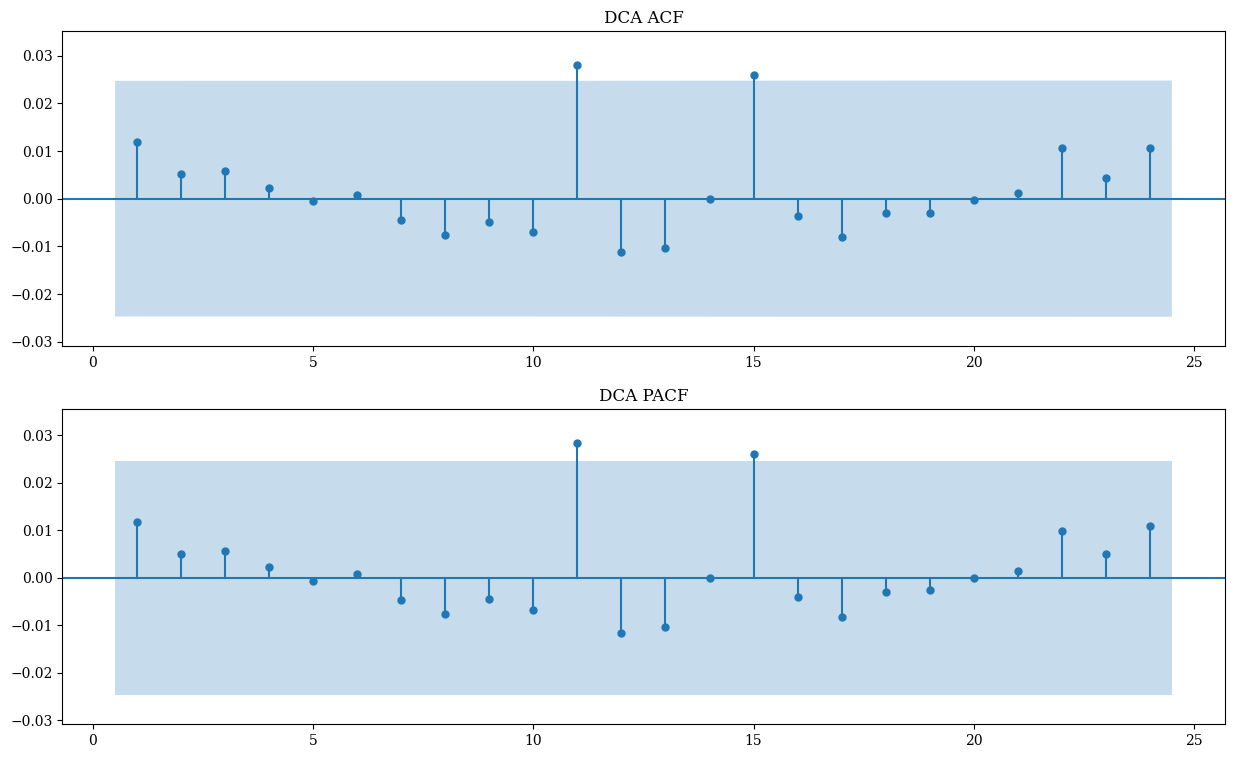

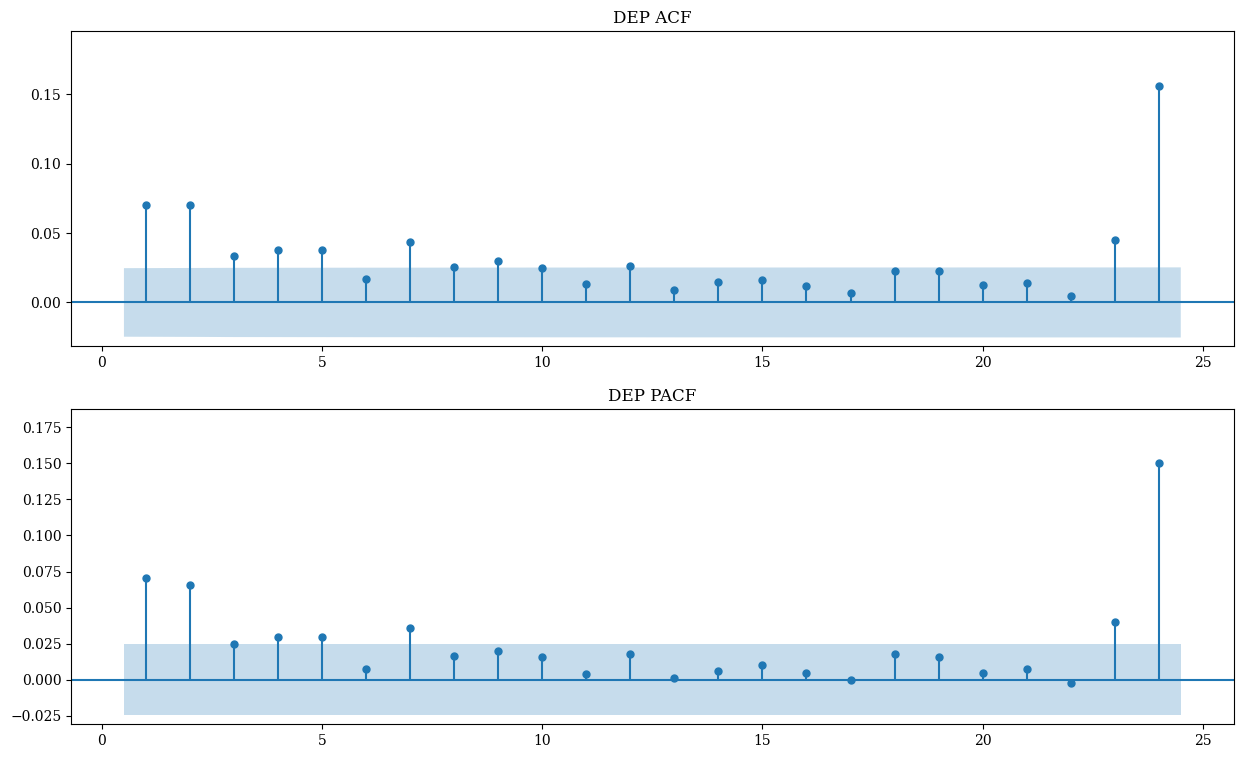

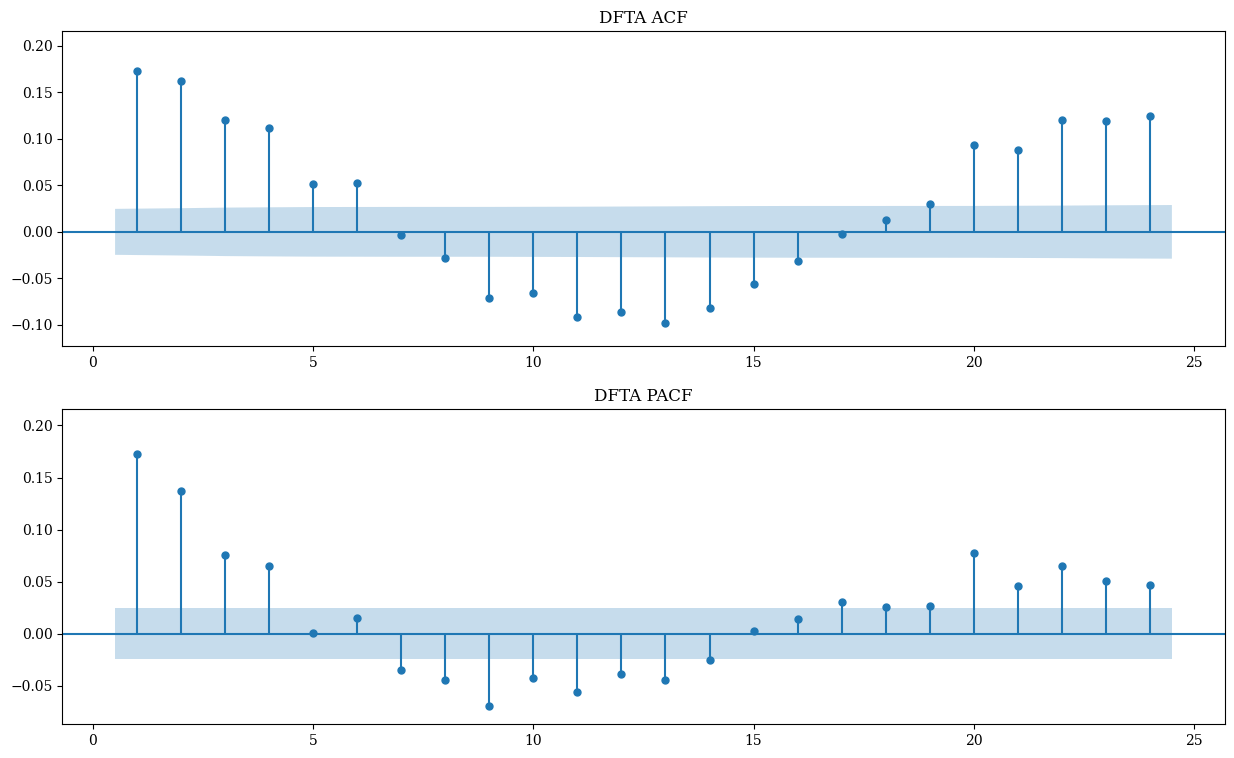

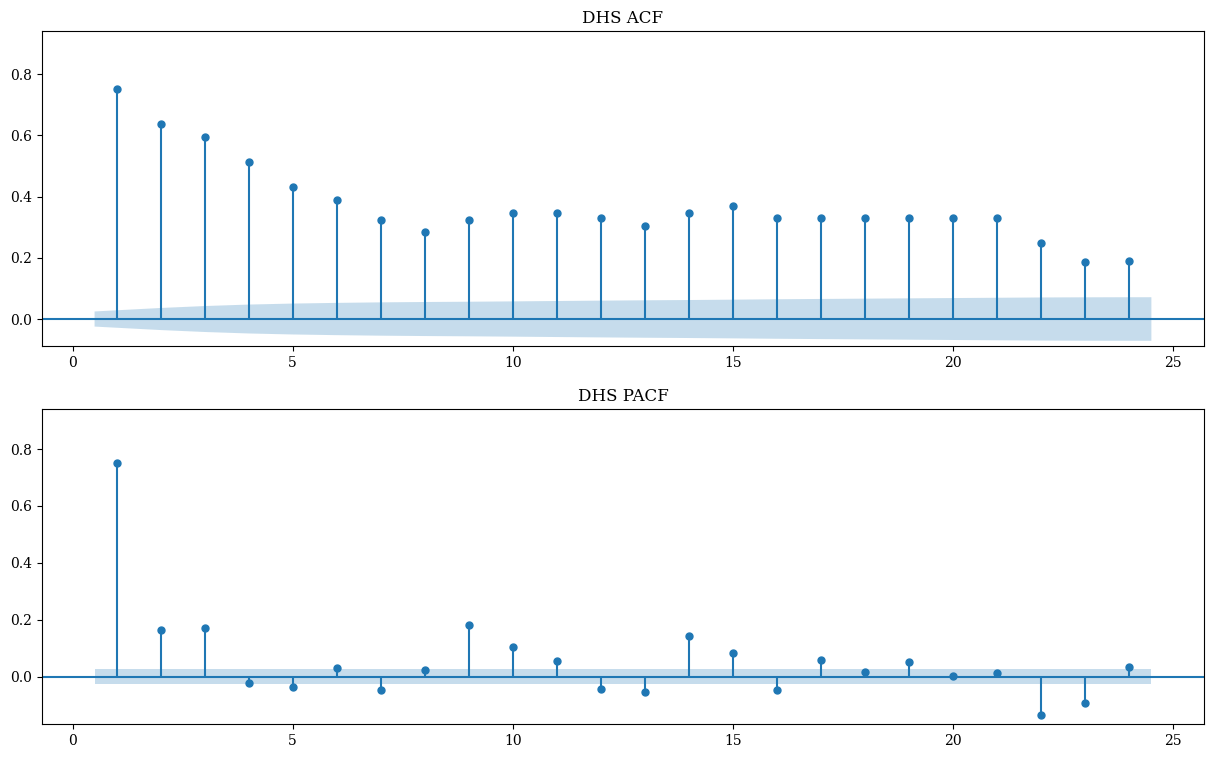

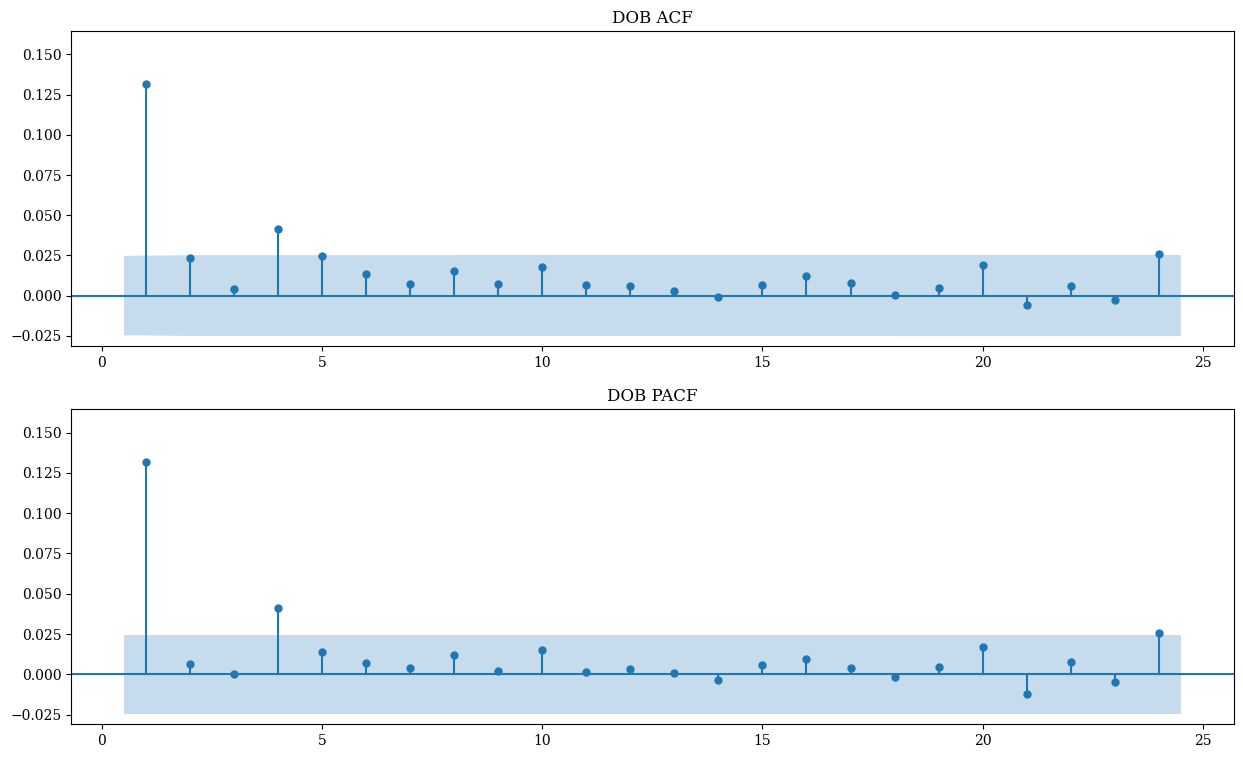

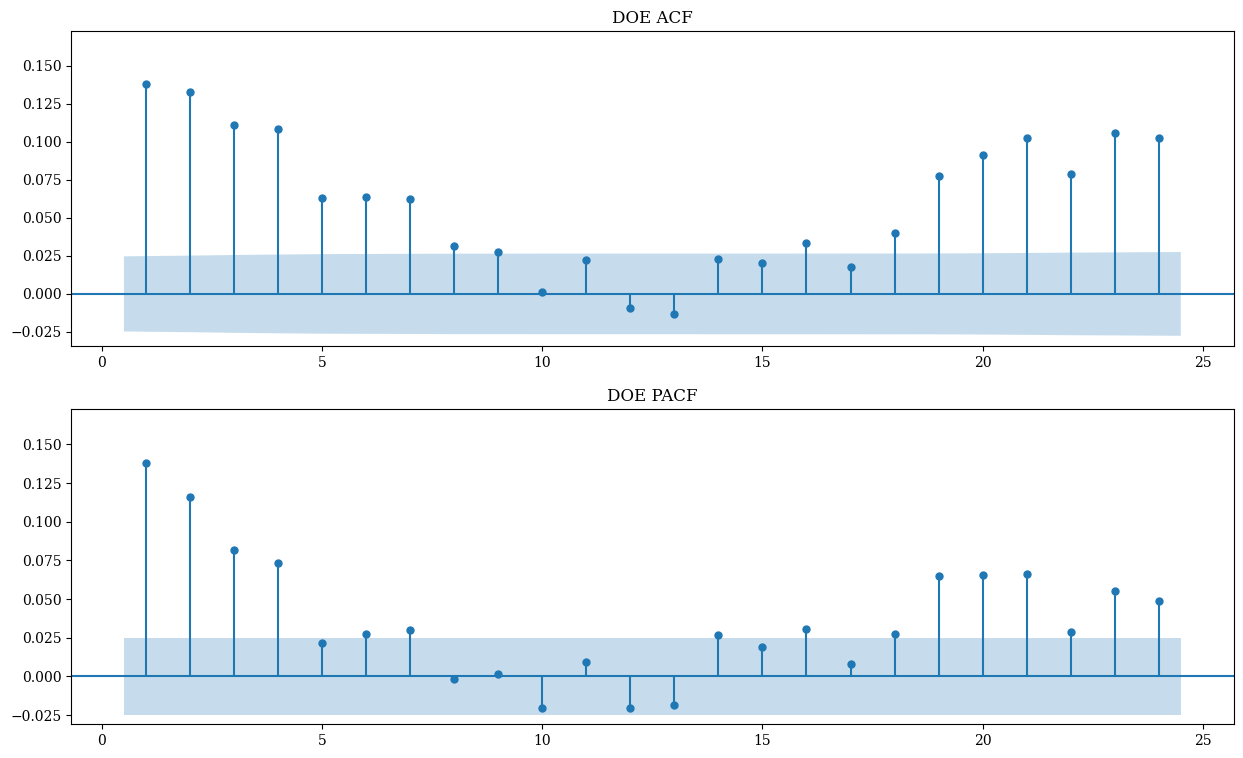

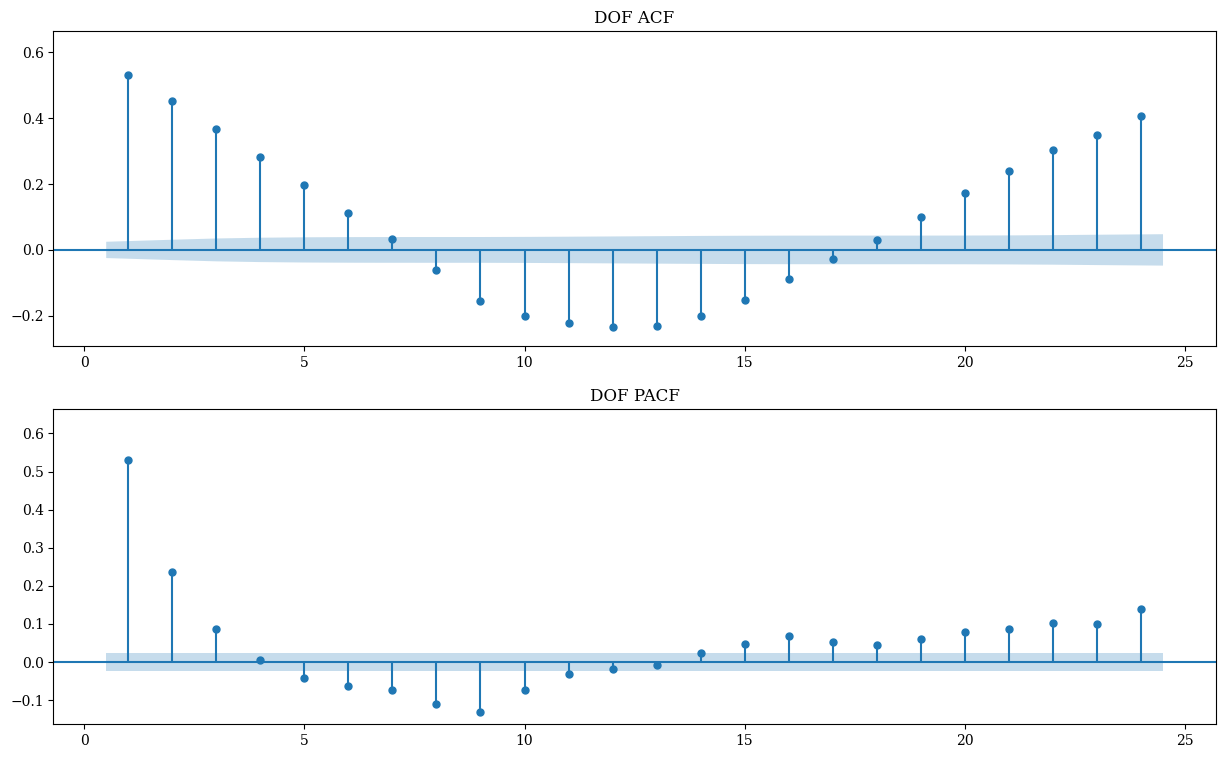

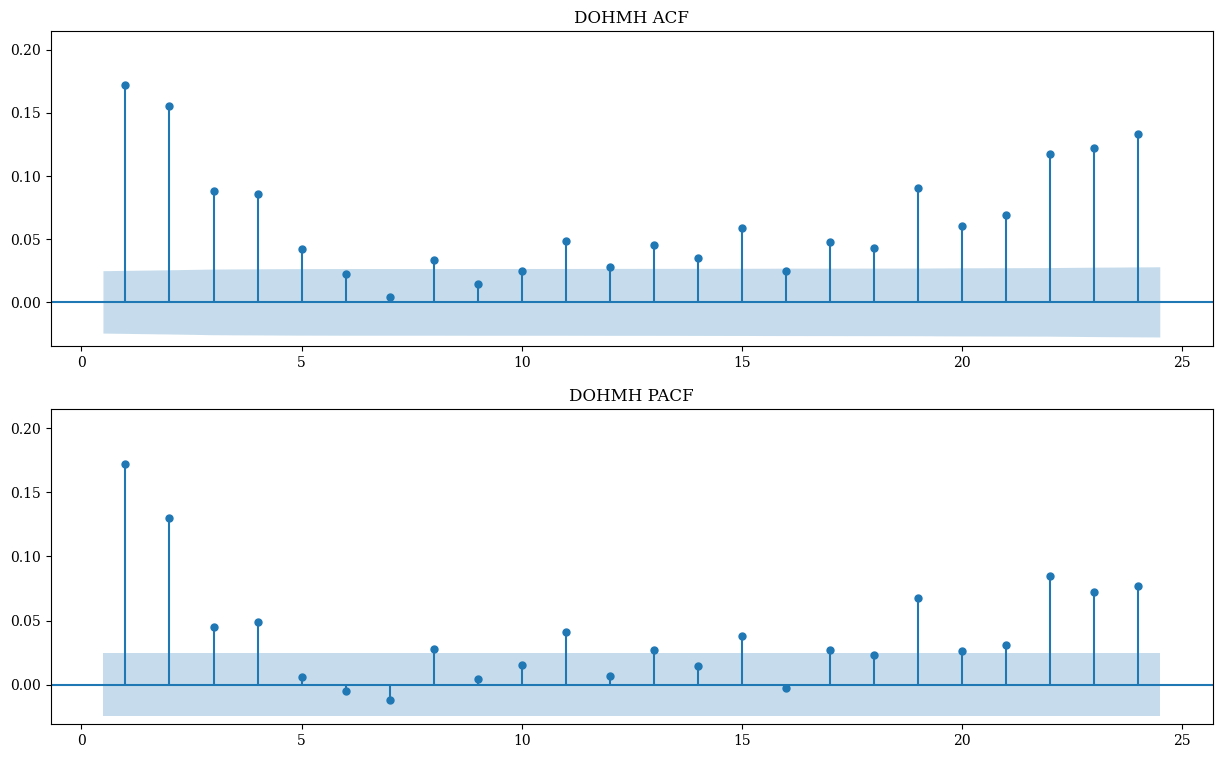

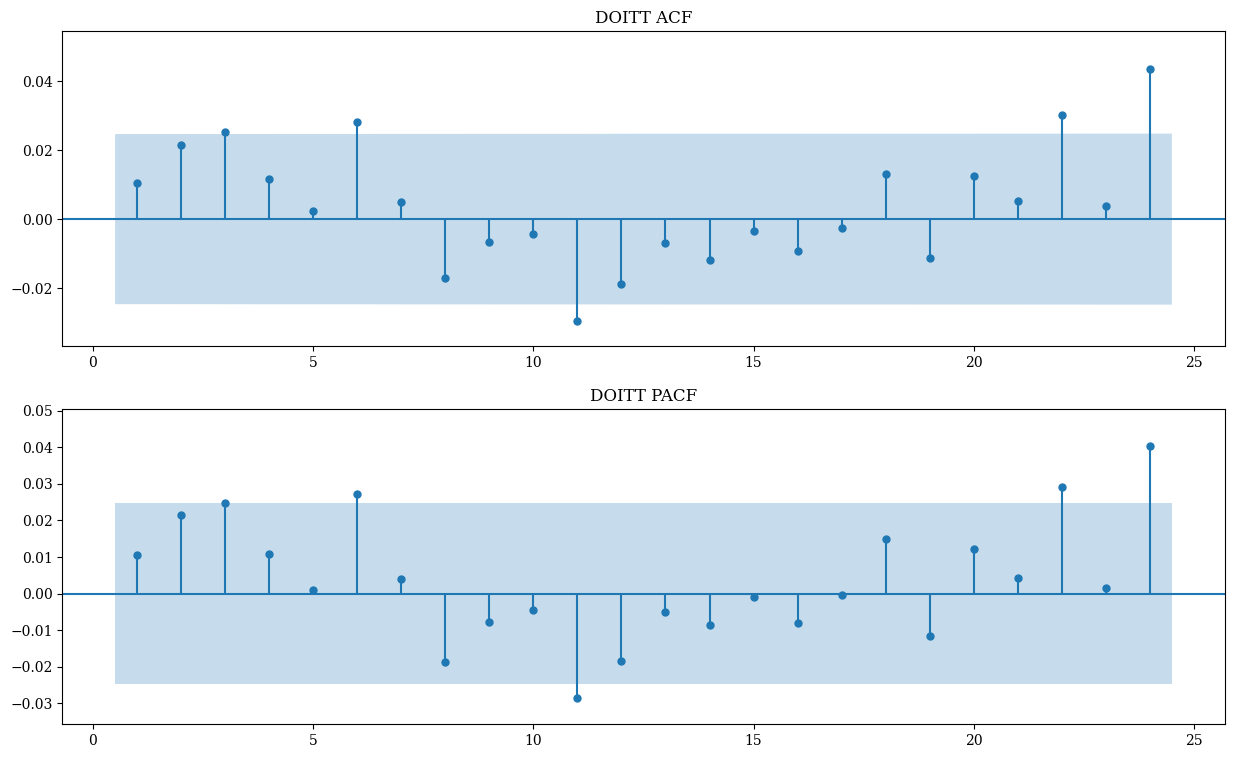

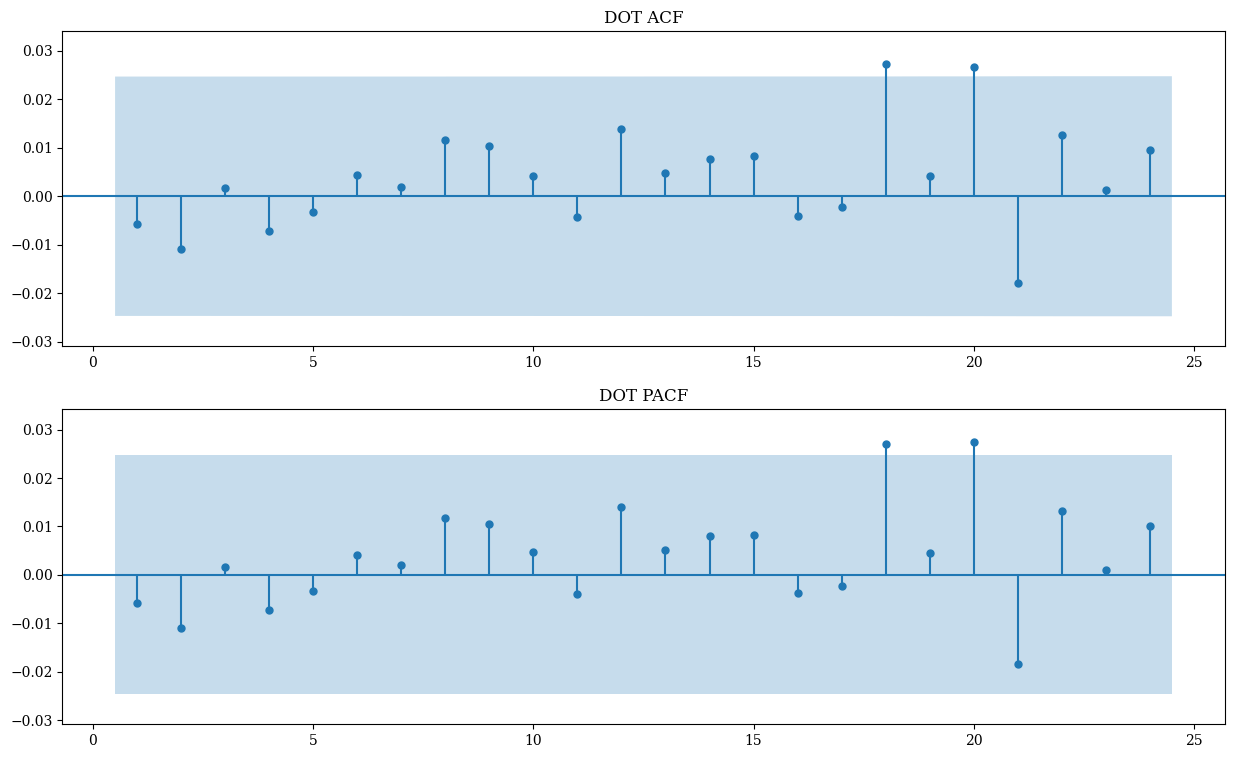

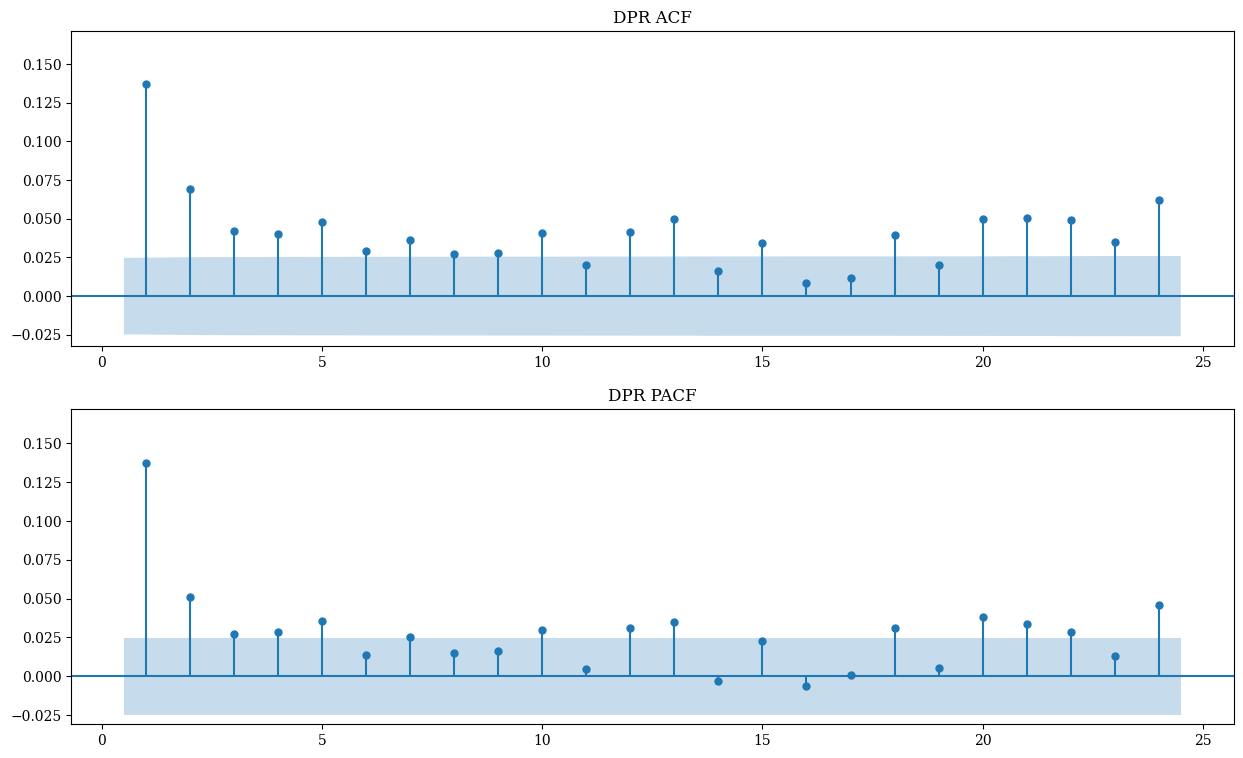

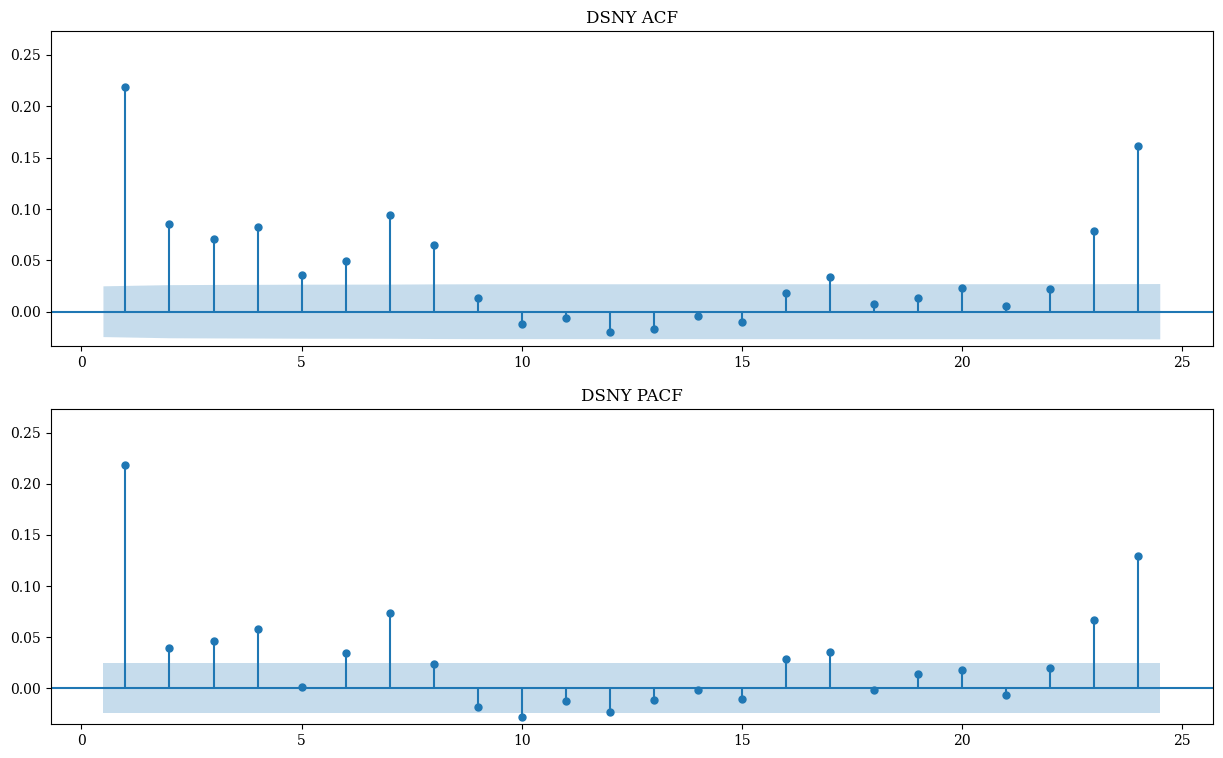

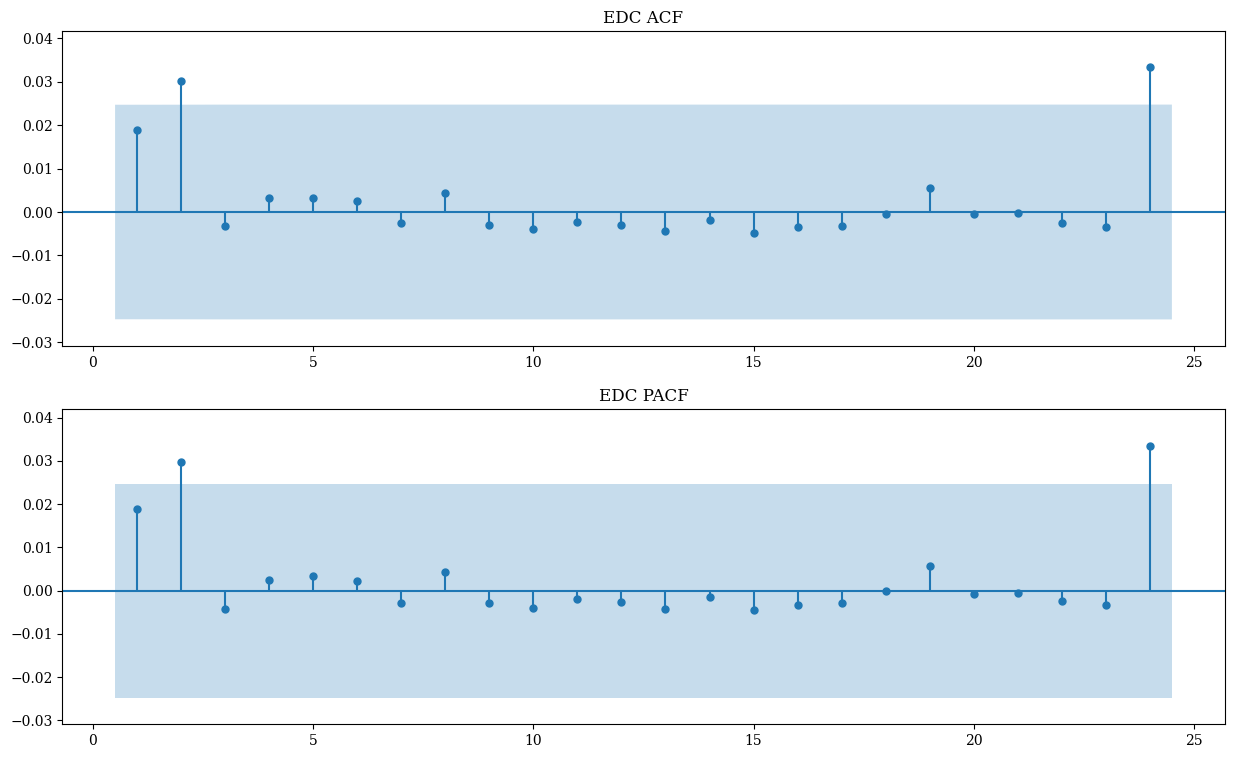

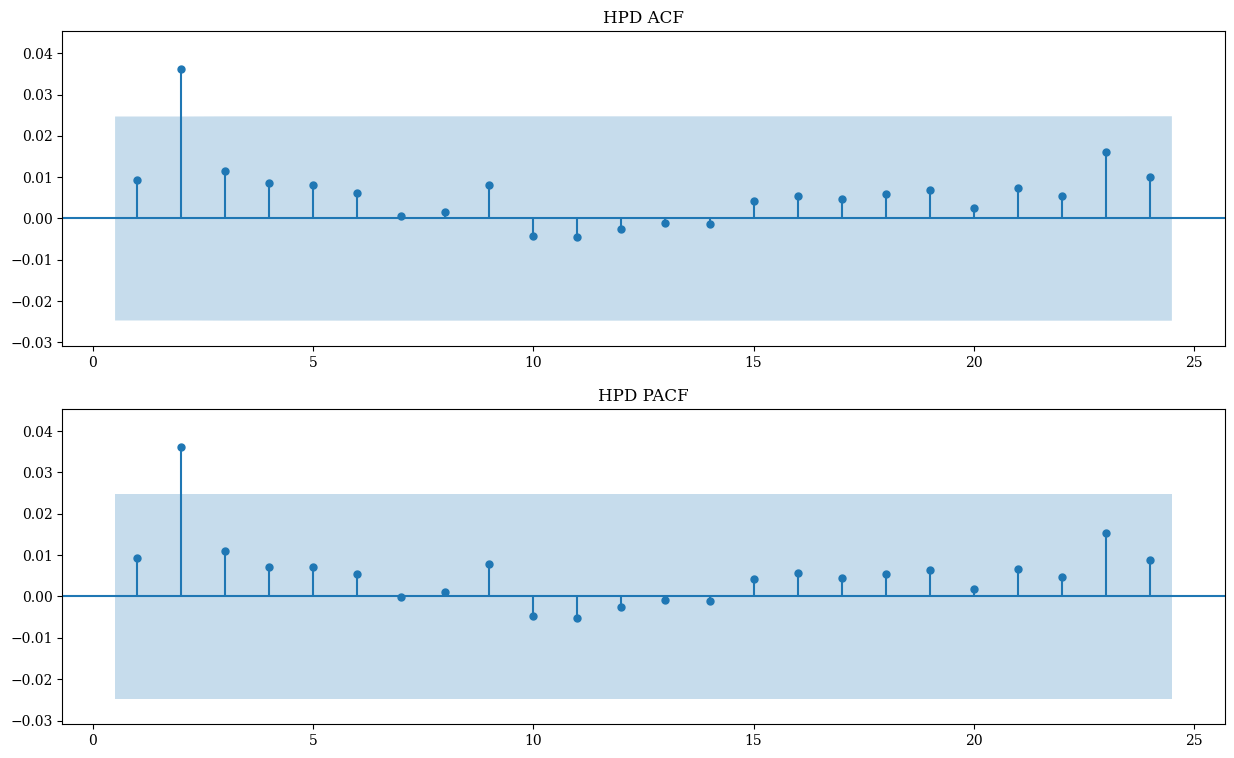

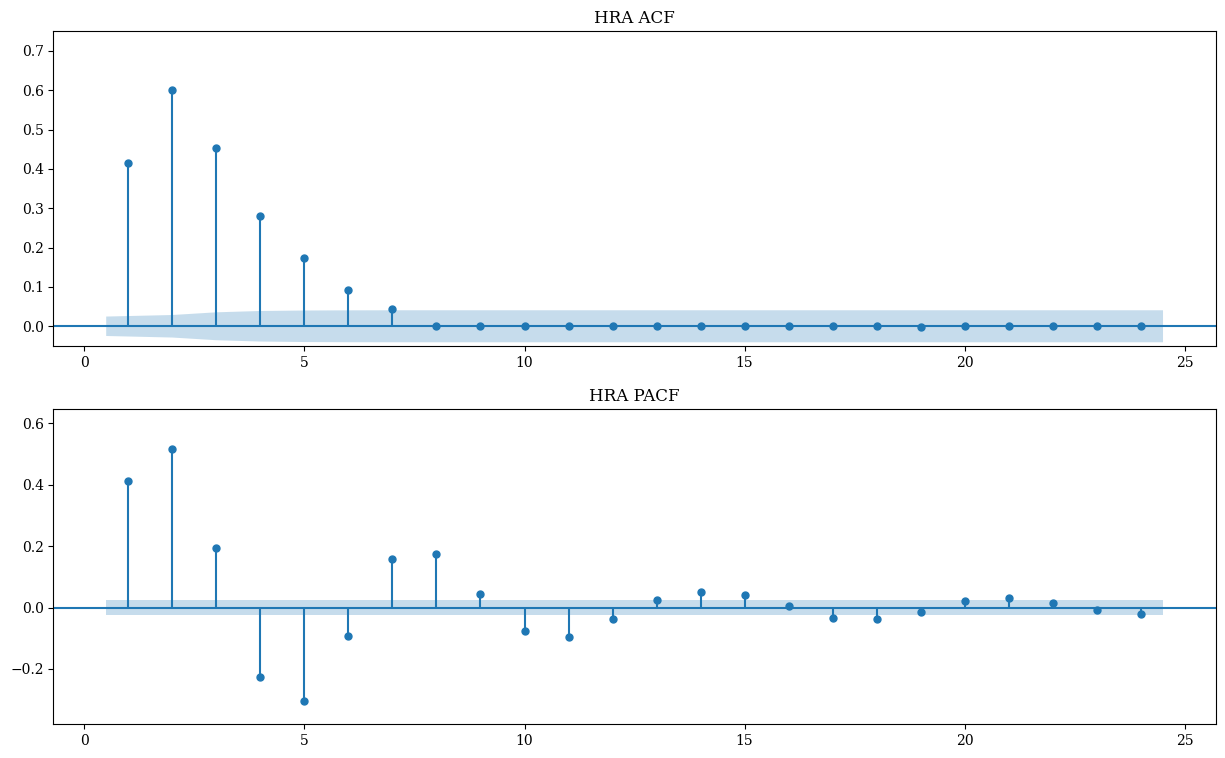

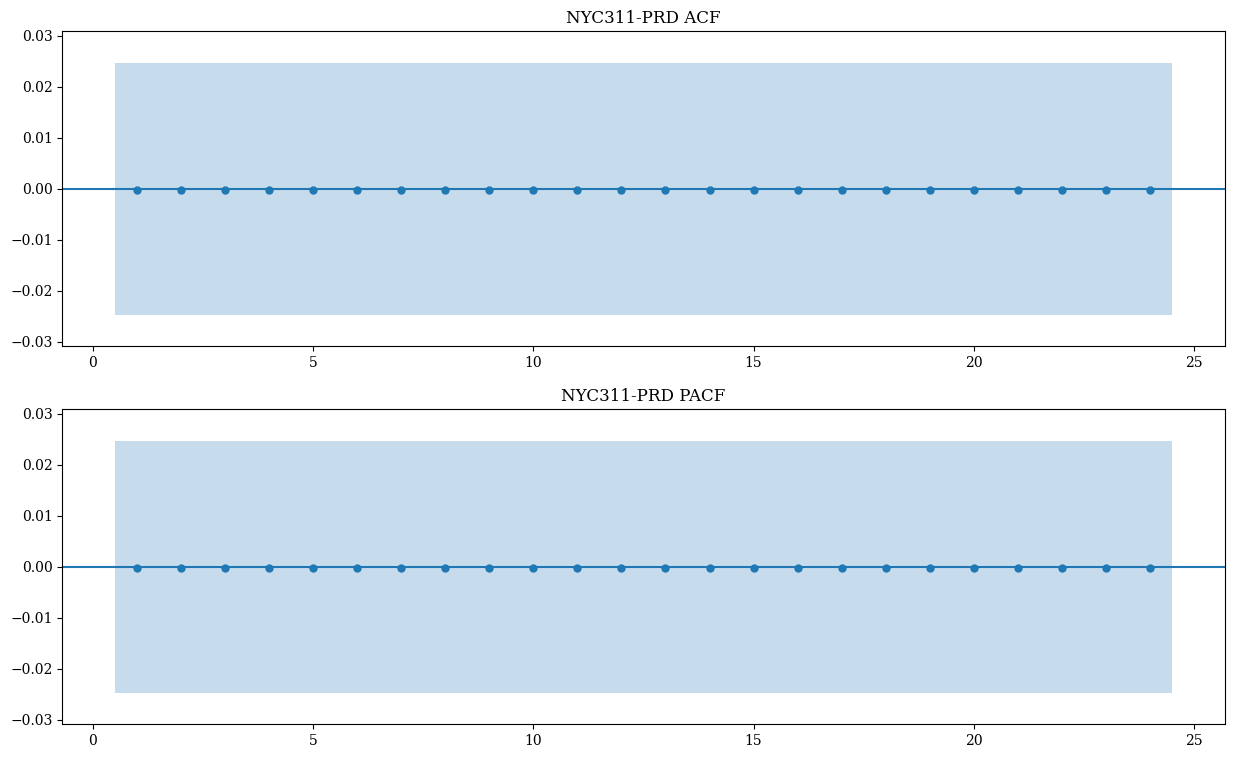

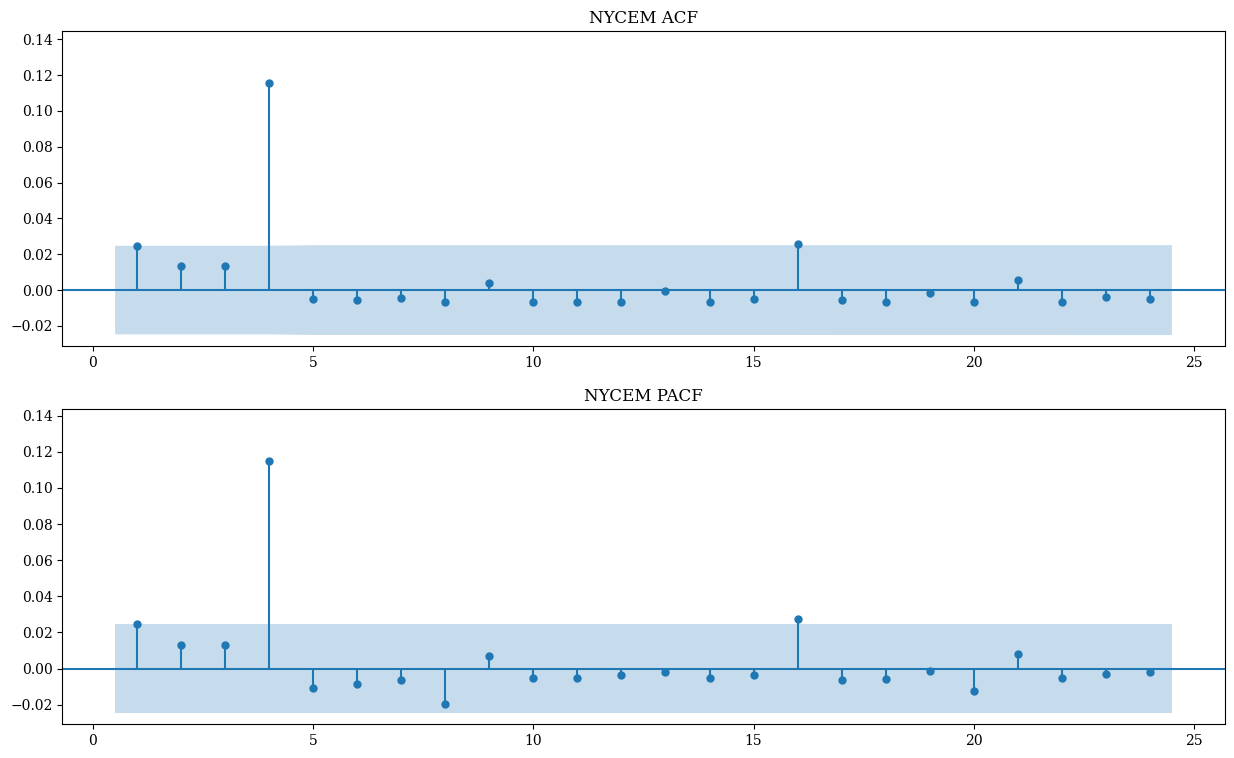

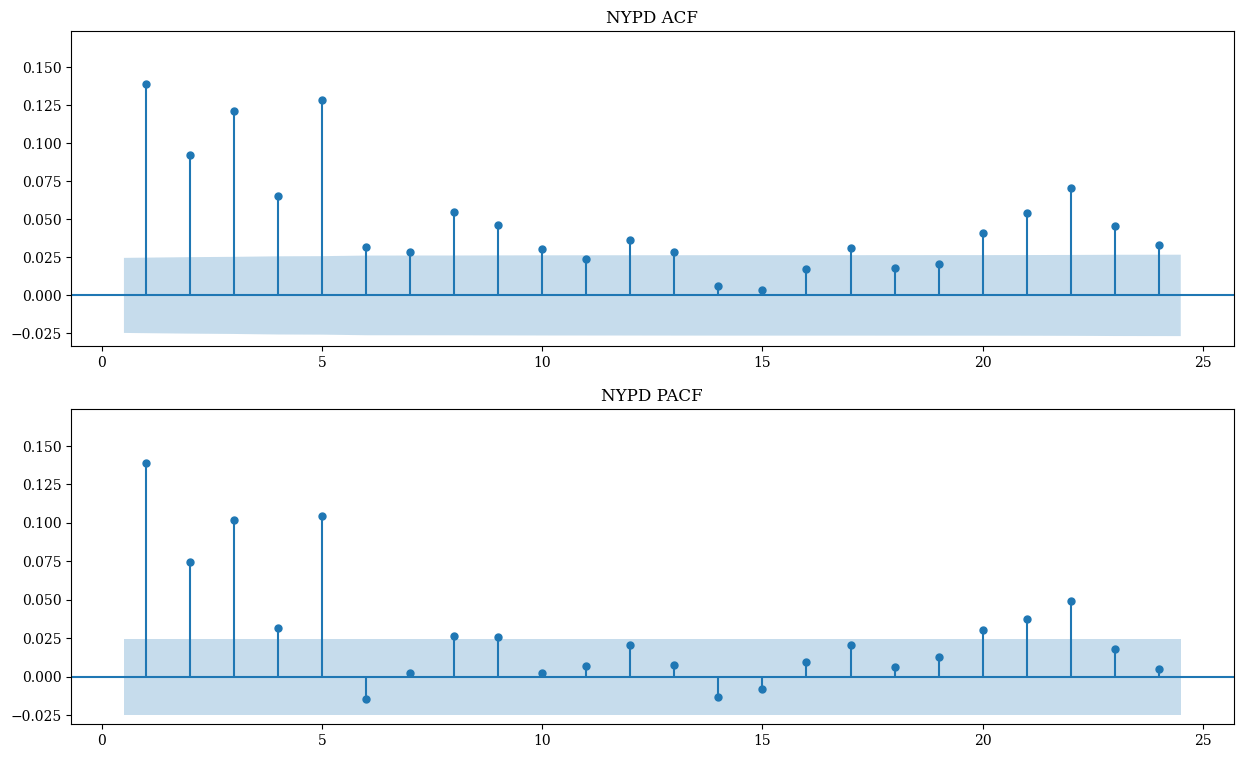

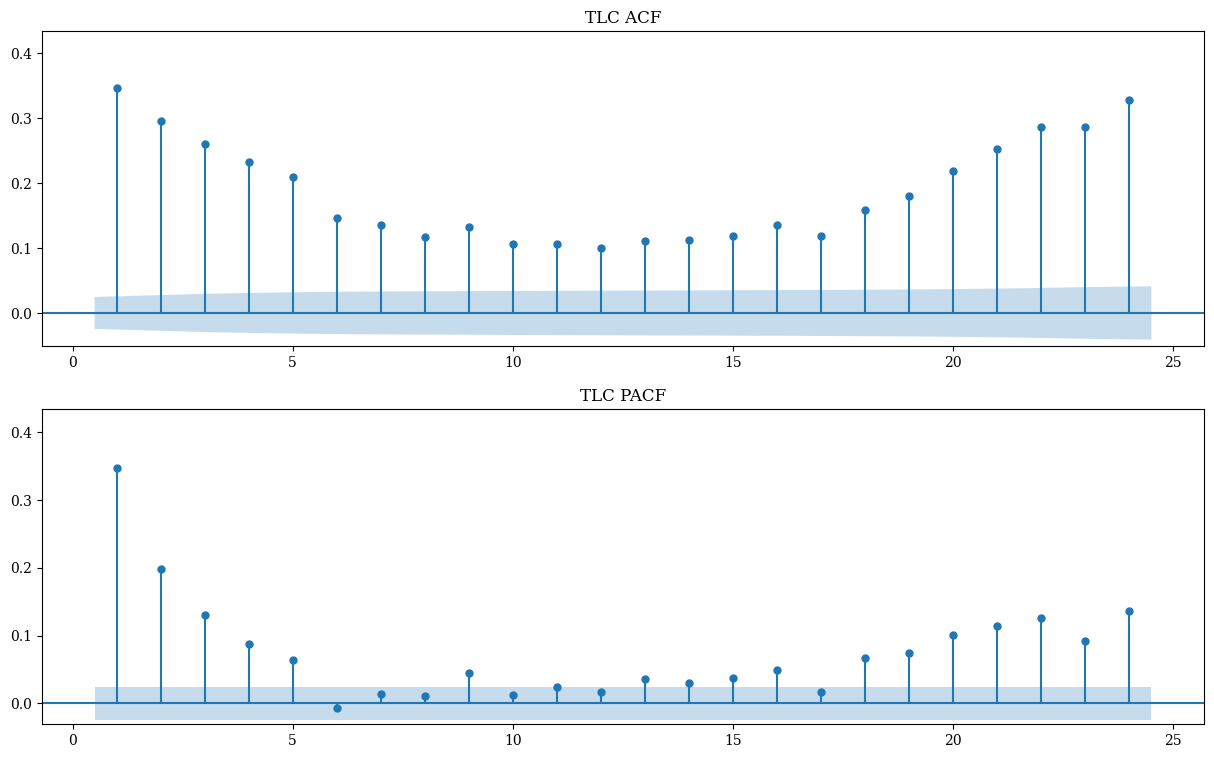

In [37]:
# columns of agency hours to complete
# rows of hour when created
target_df = target_df.fillna(0)
for c in target_df.columns:
    print(c[1])
    check_stationarity(target_df[c])
    display(acorr_ljungbox(target_df[c], lags=24))
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 9))
    plot_acf(target_df[c],lags=lags, ax=ax[0], zero=False, auto_ylims=True)
    ax[0].set_title(f'{c[1]} ACF')
    plot_pacf(target_df[c],lags=lags, ax=ax[1], method='ols', zero=False, auto_ylims=True)
    ax[1].set_title(f'{c[1]} PACF')


In [ ]:
# df = df.dropna(axis=0)

In [1]:
df.columns

NameError: name 'df' is not defined